<a href="https://colab.research.google.com/github/adhiiisetiawan/road-pothole-SAM/blob/main/Old_Copy_of_Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook: fine-tune SAM (segment anything) on a custom dataset

In this notebook, we'll reproduce the [MedSAM](https://github.com/bowang-lab/MedSAM) project, which fine-tunes [SAM](https://huggingface.co/docs/transformers/main/en/model_doc/sam) on a dataset of medical images. For demo purposes, we'll use a toy dataset, but this can easily be scaled up.

Resources used to create this notebook (thanks 🙏):
* [Encode blog post](https://encord.com/blog/learn-how-to-fine-tune-the-segment-anything-model-sam/)
* [MedSAM repository](https://github.com/bowang-lab/MedSAM).

## Set-up environment

We first install 🤗 Transformers and 🤗 Datasets.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00


We also install the [Monai](https://github.com/Project-MONAI/MONAI) repository as we'll use a custom loss function from it.

In [ ]:
!pip install -q monai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.6 MB/s eta 0:00:00


## Load dataset

Here we load a small dataset of 130 (image, ground truth mask) pairs.

To load your own images and masks, refer to the bottom of my [SAM inference notebook](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Run_inference_with_MedSAM_using_HuggingFace_Transformers.ipynb).

See also [this guide](https://huggingface.co/docs/datasets/image_dataset).

### Real breast cancer data

In [ ]:
from datasets import load_dataset

dataset = load_dataset("adhisetiawan/pothole-segmentation-v2", split="train")

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/79 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 79
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 5
    })
})

We can visualize an example:

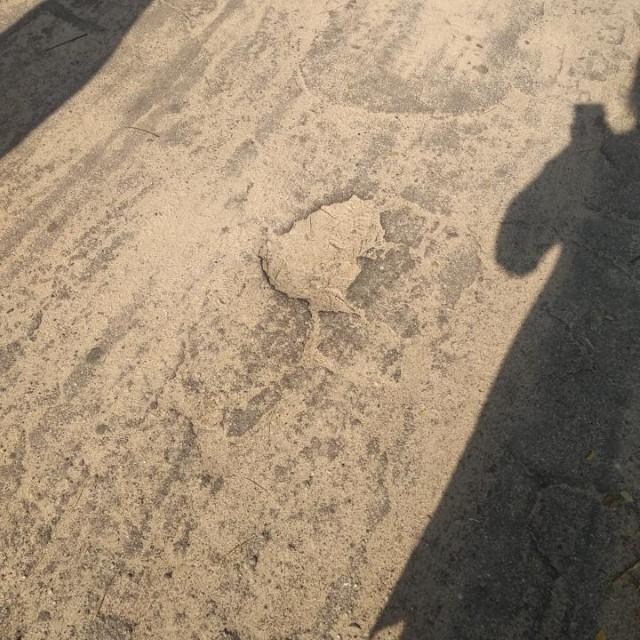

In [ ]:
example = dataset[1]
example
image = example["image"]
image

(-0.5, 639.5, 639.5, -0.5)

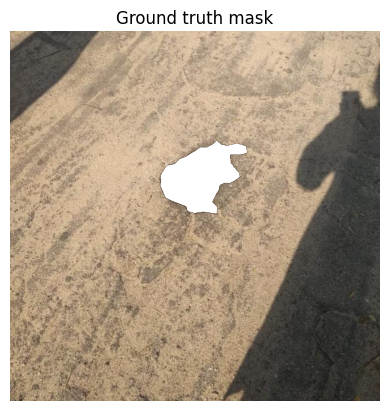

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")

## Create PyTorch dataset

Below we define a regular PyTorch dataset, which gives us examples of the data prepared in the format for the model. Each example consists of:

* pixel values (which is the image prepared for the model)
* a prompt in the form of a bounding box
* a ground truth segmentation mask.

The function below defines how to get a bounding box prompt based on the ground truth segmentation. This was taken from [here](https://github.com/bowang-lab/MedSAM/blob/66cf4799a9ab9a8e08428a5087e73fc21b2b61cd/train.py#L29).

Note that SAM is always trained using certain "prompts", which you could be bounding boxes, points, text, or rudimentary masks. The model is then trained to output the appropriate mask given the image + prompt.

In [ ]:
np.set_printoptions(threshold=np.inf)
np.where(ground_truth_seg > 0)

(array([189, 190, 190, 190, 191, 191, 191, 191, 191, 192, 192, 192, 192,
        192, 192, 192, 193, 193, 193, 193, 193, 193, 193, 193, 193, 193,
        194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194, 194,
        194, 194, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195,
        195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195, 195,
        196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196,
        196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196, 196,
        196, 196, 196, 196, 196, 196, 196, 196, 196, 197, 197, 197, 197,
        197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197,
        197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197,
        197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197, 197,
        197, 197, 197, 197, 197, 197, 197, 198, 198, 198, 198, 198, 198,
        198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198, 198,
        198, 198, 198, 198, 198, 198, 198, 198, 198

In [ ]:
ground_truth_seg

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  if len(x_indices) == 0 or len(y_indices) == 0:
    # Handle the case where there are no elements satisfying the condition
    # This could involve skipping the current data point or taking alternative actions.
      print("No segmentation mask found.")
  else:
      x_min, x_max = np.min(x_indices), np.max(x_indices)
      y_min, y_max = np.min(y_indices), np.max(y_indices)

      # add perturbation to bounding box coordinates
      H, W = ground_truth_map.shape
      x_min = max(0, x_min - np.random.randint(0, 20))
      x_max = min(W, x_max + np.random.randint(0, 20))
      y_min = max(0, y_min - np.random.randint(0, 20))
      y_max = min(H, y_max + np.random.randint(0, 20))
      bbox = [x_min, y_min, x_max, y_max]

      return bbox

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  # print(f"y indices: {y_indices}")
  # print(f"x indices: {x_indices}")

  x_min, x_max = np.min(x_indices), np.max(x_indices)
  # print(f"X Min: {x_min} | X Max: {x_max}")

  y_min, y_max = np.min(y_indices), np.max(y_indices)

  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
import matplotlib.pyplot as plt

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

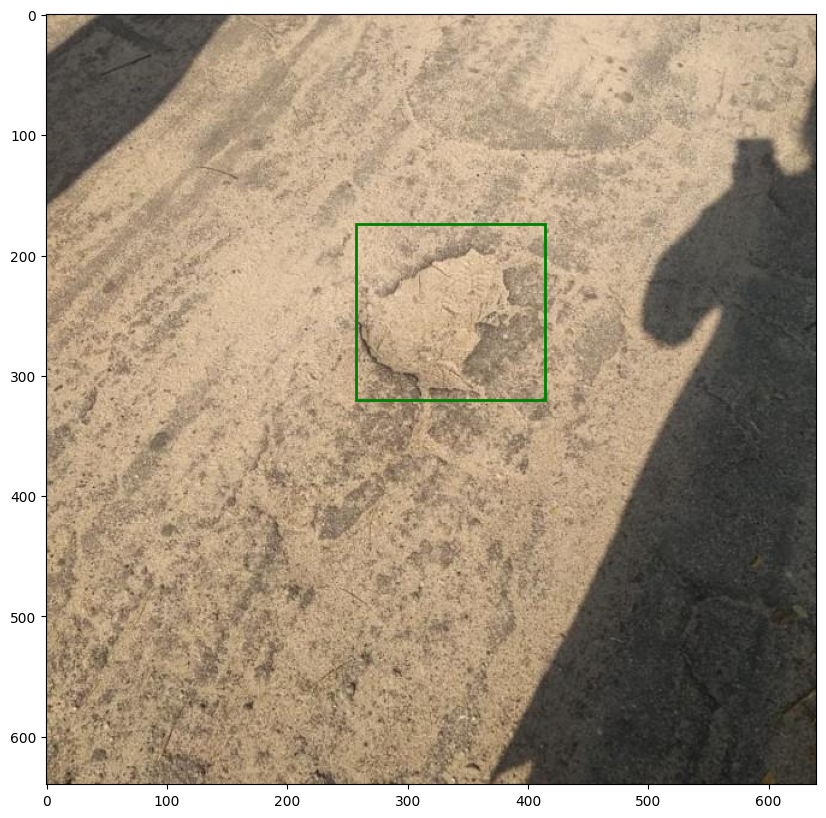

In [ ]:
input_boxes = get_bounding_box(ground_truth_seg)
input_boxes
show_boxes_on_image(image, [input_boxes])

In [ ]:
from torch.utils.data import Dataset
import cv2

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    ground_truth_mask = ground_truth_mask / 255.0


    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # ground_truth_mask = cv2.resize(ground_truth_mask, (256, 256))

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask
    print(type(inputs["ground_truth_mask"]))

    return inputs

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

<class 'numpy.ndarray'>
pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (640, 640)


## Create PyTorch DataLoader

Next we define a PyTorch Dataloader, which allows us to get batches from the dataset.



In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 640, 640])


In [ ]:
batch["pixel_values"].shape

torch.Size([2, 3, 1024, 1024])

In [ ]:
batch["ground_truth_mask"].shape

torch.Size([2, 640, 640])

## Load the model

In [ ]:
from transformers import SamModel

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

## Train the model

In [ ]:
from torch.optim import Adam
# import monai
from torch.nn import BCEWithLogitsLoss
import torchvision

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

# seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# seg_loss = BCEWithLogitsLoss()
# seg_loss = torchvision.ops.sigmoid_focal_loss()

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize
from torch import nn


num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      print(f"Before interpolation: {predicted_masks}")
      predicted_masks = nn.functional.interpolate(predicted_masks,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)
      print(f"After interpolation: {predicted_masks}")
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      print(f"Ground truth mask: {ground_truth_masks}")
      # loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
      loss = torchvision.ops.sigmoid_focal_loss(predicted_masks, ground_truth_masks.unsqueeze(1), reduction='mean')

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:00<00:38,  1.02it/s]

Before interpolation: tensor([[[[-2.8386, -3.3700, -3.1227,  ..., -2.7264, -2.7424, -2.8838],
          [-2.2060, -2.7529, -2.6037,  ..., -2.0990, -2.0569, -2.2778],
          [-3.0527, -3.2803, -3.2251,  ..., -2.5159, -2.3756, -2.4251],
          ...,
          [-0.7457, -0.3861,  0.0350,  ..., -0.9454, -1.1534, -0.8599],
          [-0.4622, -0.0548,  0.3332,  ..., -0.7248, -0.5344, -0.9761],
          [-0.7365, -0.2561, -0.2054,  ..., -0.7210, -1.0808, -0.8720]]],


        [[[-4.1065, -4.3322, -3.8092,  ..., -3.9200, -3.7890, -3.8116],
          [-4.0813, -4.2129, -3.7822,  ..., -3.9969, -4.1024, -3.9635],
          [-4.1103, -4.2343, -3.9919,  ..., -3.8126, -3.9349, -3.7485],
          ...,
          [-4.4196, -4.7601, -4.4305,  ..., -4.7558, -4.8200, -4.7615],
          [-4.5595, -4.7758, -4.4467,  ..., -4.5591, -4.6018, -4.3769],
          [-4.3428, -4.5990, -4.3827,  ..., -4.5007, -4.5292, -4.5085]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:01<00:35,  1.08it/s]

Before interpolation: tensor([[[[-5.6962, -6.0542, -5.3281,  ..., -5.6575, -5.5048, -5.5767],
          [-5.8737, -6.1253, -5.5735,  ..., -5.8012, -5.9699, -5.8569],
          [-5.5084, -5.8255, -5.5043,  ..., -5.3829, -5.7030, -5.5986],
          ...,
          [-6.1640, -6.5360, -6.2061,  ..., -6.7495, -6.9193, -6.4603],
          [-6.1138, -6.4445, -6.1723,  ..., -6.5091, -6.6150, -6.1828],
          [-5.9668, -6.0983, -6.0597,  ..., -6.3576, -6.4675, -6.3406]]],


        [[[-7.1173, -7.3355, -6.8951,  ..., -7.0170, -6.8247, -6.9605],
          [-7.3853, -7.5782, -7.3566,  ..., -7.2414, -7.3545, -7.3994],
          [-6.9616, -7.1764, -7.0171,  ..., -6.7463, -7.0269, -6.9668],
          ...,
          [-7.1061, -6.9937, -6.7542,  ..., -6.8601, -7.0095, -6.5939],
          [-6.6001, -6.7550, -6.2960,  ..., -6.6416, -6.2298, -6.1038],
          [-6.8249, -6.6800, -6.7272,  ..., -6.3731, -6.5772, -6.1865]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:02<00:34,  1.09it/s]

Before interpolation: tensor([[[[-5.4074, -5.7664, -5.1966,  ..., -5.8228, -5.4161, -5.6957],
          [-5.6041, -5.7949, -5.4776,  ..., -6.0191, -5.8543, -6.0427],
          [-5.3652, -5.6768, -5.4263,  ..., -5.7135, -5.7753, -5.7843],
          ...,
          [-5.4648, -5.4808, -5.4369,  ..., -5.7483, -5.6746, -5.7512],
          [-5.3099, -5.5672, -5.0565,  ..., -5.6322, -5.1664, -5.1870],
          [-5.3023, -5.2673, -5.2837,  ..., -5.4595, -5.3947, -5.4256]]],


        [[[-8.4834, -8.6157, -8.1656,  ..., -8.2379, -8.0471, -8.0116],
          [-8.5685, -8.8028, -8.4379,  ..., -8.4075, -8.4067, -8.2658],
          [-8.2243, -8.3327, -8.3330,  ..., -7.8869, -8.2885, -7.8172],
          ...,
          [-8.3882, -8.6725, -8.1952,  ..., -8.2504, -8.6589, -8.2638],
          [-8.2004, -8.4198, -8.1080,  ..., -8.0224, -8.7384, -7.9919],
          [-8.1095, -8.2312, -8.0307,  ..., -8.1006, -8.4597, -8.3516]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:03<00:32,  1.10it/s]

Before interpolation: tensor([[[[-4.8975, -5.0308, -4.7673,  ..., -4.3824, -4.2825, -4.3218],
          [-5.1288, -5.2654, -5.0556,  ..., -4.5831, -4.5584, -4.6059],
          [-4.9415, -5.0267, -4.9920,  ..., -4.4377, -4.5554, -4.3740],
          ...,
          [-4.2688, -4.5419, -4.2159,  ..., -4.8845, -4.8407, -4.8020],
          [-4.2447, -4.3372, -3.9412,  ..., -4.7798, -4.4377, -4.4007],
          [-4.2663, -4.4062, -4.2362,  ..., -4.6731, -4.6646, -4.6117]]],


        [[[-6.1174, -6.2744, -5.8058,  ..., -6.3343, -6.1449, -6.3020],
          [-6.5385, -6.4531, -6.3140,  ..., -6.3642, -6.5510, -6.5187],
          [-5.8618, -6.1505, -5.8581,  ..., -5.9586, -6.2565, -6.1143],
          ...,
          [-6.4782, -6.7014, -6.6764,  ..., -6.7081, -6.8904, -6.6635],
          [-6.3783, -6.6259, -6.2245,  ..., -6.5047, -6.1210, -6.1275],
          [-6.3555, -6.4147, -6.4993,  ..., -6.2335, -6.3483, -6.3661]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:04<00:31,  1.11it/s]

Before interpolation: tensor([[[[-7.6666, -8.1313, -7.2681,  ..., -7.7869, -7.4004, -7.8301],
          [-7.8364, -8.0399, -7.4186,  ..., -7.7010, -8.0765, -8.0562],
          [-7.1411, -7.7034, -7.4713,  ..., -7.5707, -7.6153, -7.9266],
          ...,
          [-8.2311, -8.6543, -8.0400,  ..., -8.1487, -8.4063, -8.1361],
          [-7.5749, -8.3904, -7.8365,  ..., -8.0797, -7.8136, -8.1574],
          [-7.9982, -8.3245, -7.7910,  ..., -7.7390, -7.8802, -8.1153]]],


        [[[-0.2551, -0.3597, -0.2046,  ..., -1.2927, -1.3923, -1.3454],
          [-0.2002, -0.1887, -0.0715,  ..., -1.2772, -1.4268, -1.3584],
          [-0.0247, -0.0823,  0.1118,  ..., -1.2660, -1.3027, -1.2294],
          ...,
          [-1.9010, -1.8451, -1.6131,  ..., -2.2267, -2.0848, -2.0555],
          [-1.6977, -1.5188, -1.4550,  ..., -2.0201, -1.8413, -1.8718],
          [-1.6419, -1.6223, -1.5510,  ..., -2.0512, -1.9900, -2.0018]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:05<00:30,  1.11it/s]

Before interpolation: tensor([[[[-7.9078, -8.1974, -7.6416,  ..., -8.1120, -8.2144, -8.0784],
          [-8.0721, -8.3722, -7.8248,  ..., -8.2433, -8.6455, -8.7003],
          [-7.2470, -7.5921, -7.6106,  ..., -7.6990, -7.9919, -8.0227],
          ...,
          [-8.8825, -9.5498, -8.7922,  ..., -8.9749, -9.2648, -8.8876],
          [-8.5458, -8.9813, -8.6175,  ..., -8.4469, -8.7431, -8.5127],
          [-8.7301, -8.9762, -8.5474,  ..., -8.4101, -8.5151, -8.6144]]],


        [[[-9.5398, -9.5883, -9.2021,  ..., -8.9772, -8.8798, -9.0198],
          [-9.4095, -9.6053, -9.1430,  ..., -8.9875, -9.0423, -9.0243],
          [-9.0469, -9.1503, -9.1385,  ..., -8.4921, -9.0355, -8.7832],
          ...,
          [-9.3656, -9.8387, -9.3408,  ..., -9.6981, -9.7259, -9.7328],
          [-9.5990, -9.9032, -9.6717,  ..., -9.6132, -9.9392, -9.4788],
          [-9.2491, -9.5094, -9.4696,  ..., -9.3844, -9.4424, -9.6673]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:06<00:29,  1.11it/s]

Before interpolation: tensor([[[[ -9.8299,  -9.9369,  -9.5283,  ...,  -9.8740,  -9.6442,  -9.7204],
          [-10.0301, -10.1698,  -9.8016,  ..., -10.0380, -10.1151, -10.0264],
          [ -9.5981,  -9.5968,  -9.7435,  ...,  -9.2901,  -9.9889,  -9.6246],
          ...,
          [-10.0104, -10.2298,  -9.9157,  ..., -10.0525, -10.4282, -10.0204],
          [ -9.7606, -10.0411,  -9.9036,  ...,  -9.7001, -10.3521,  -9.7183],
          [ -9.8153,  -9.9310,  -9.9087,  ...,  -9.6542,  -9.9726, -10.1149]]],


        [[[ -9.4541,  -9.5190,  -9.0811,  ...,  -9.3491,  -9.1666,  -9.4017],
          [ -9.6793,  -9.7464,  -9.3592,  ...,  -9.7084,  -9.5978,  -9.7189],
          [ -9.1388,  -9.0944,  -9.1523,  ...,  -8.6801,  -8.7336,  -8.7320],
          ...,
          [ -9.6982, -10.0235,  -9.2723,  ...,  -9.8221,  -9.6557,  -9.7110],
          [ -9.1931,  -9.5811,  -8.9708,  ...,  -9.4954,  -9.1569,  -8.9633],
          [ -9.1450,  -9.1858,  -9.1222,  ...,  -9.2680,  -9.2266,  -9.3184]]]],
     

 20%|██        | 8/40 [00:07<00:28,  1.11it/s]

Before interpolation: tensor([[[[ -9.4716,  -9.5837,  -9.1477,  ...,  -9.6368,  -9.5465,  -9.4222],
          [ -9.7524,  -9.9968,  -9.5467,  ..., -10.0228,  -9.9671,  -9.7706],
          [ -9.0808,  -9.1028,  -9.1300,  ...,  -9.2399,  -9.7187,  -9.1793],
          ...,
          [-10.0829, -10.2132,  -9.9517,  ..., -10.2519, -10.2491,  -9.9275],
          [ -9.7888,  -9.8788,  -9.7954,  ...,  -9.8577,  -9.9234,  -9.3697],
          [ -9.8369,  -9.6673,  -9.8056,  ...,  -9.8409,  -9.7890,  -9.8686]]],


        [[[ -3.9648,  -4.2457,  -3.9043,  ...,  -3.9827,  -3.9165,  -3.9687],
          [ -3.8057,  -4.0572,  -3.8684,  ...,  -4.1279,  -4.1666,  -4.2063],
          [ -3.8381,  -4.0899,  -4.1107,  ...,  -3.8602,  -3.9982,  -3.8348],
          ...,
          [ -3.4755,  -3.5930,  -3.3917,  ...,  -3.8756,  -4.0147,  -3.6844],
          [ -3.1990,  -3.2746,  -3.0590,  ...,  -3.7168,  -3.6219,  -3.4412],
          [ -3.1418,  -2.9583,  -3.1358,  ...,  -3.5354,  -3.6476,  -3.3935]]]],
     

 22%|██▎       | 9/40 [00:08<00:27,  1.12it/s]

Before interpolation: tensor([[[[-7.5750, -7.7619, -7.2198,  ..., -7.8636, -7.5953, -7.7886],
          [-7.8788, -7.8358, -7.4938,  ..., -7.9640, -8.1229, -8.1419],
          [-7.3124, -7.4808, -7.4547,  ..., -7.5663, -7.8494, -7.7166],
          ...,
          [-7.5959, -7.6070, -7.4101,  ..., -7.9566, -8.1640, -8.0258],
          [-7.3155, -7.6872, -7.3139,  ..., -7.8380, -7.7831, -7.6853],
          [-7.4320, -7.3992, -7.3858,  ..., -7.6078, -7.6583, -7.7613]]],


        [[[-7.2938, -7.8112, -7.2789,  ..., -7.2870, -7.0227, -7.0839],
          [-7.9052, -8.3093, -7.9192,  ..., -7.6092, -7.6022, -7.7413],
          [-7.0795, -7.5614, -7.4358,  ..., -7.1469, -7.3822, -7.2576],
          ...,
          [-7.9785, -8.3481, -7.8116,  ..., -8.4040, -8.2121, -8.1367],
          [-7.1140, -7.7430, -7.2707,  ..., -7.7953, -7.5316, -7.4279],
          [-7.8092, -7.8923, -7.5125,  ..., -7.7967, -7.7633, -7.9378]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:09<00:26,  1.12it/s]

Before interpolation: tensor([[[[-6.9340, -7.1983, -6.8200,  ..., -7.0626, -6.9799, -6.9150],
          [-7.4824, -7.6116, -7.4255,  ..., -7.3008, -7.5651, -7.3971],
          [-6.6477, -6.8642, -6.7291,  ..., -6.7127, -6.8617, -6.7477],
          ...,
          [-7.4279, -7.7550, -7.4277,  ..., -7.8300, -7.7444, -7.4628],
          [-7.3020, -7.5850, -6.9516,  ..., -7.3940, -7.0575, -6.9196],
          [-7.2622, -7.3639, -7.2444,  ..., -7.2643, -7.2107, -7.2133]]],


        [[[-7.5995, -7.6506, -7.3056,  ..., -7.7606, -7.6872, -7.5851],
          [-7.9322, -8.1596, -7.7588,  ..., -8.1875, -8.2006, -8.1902],
          [-7.1547, -7.3070, -7.4759,  ..., -7.5045, -7.7750, -7.5459],
          ...,
          [-7.4610, -7.8874, -7.4181,  ..., -7.9652, -7.9858, -7.7517],
          [-7.0997, -7.5071, -7.0972,  ..., -7.6151, -7.4838, -7.1397],
          [-7.3521, -7.4434, -7.3535,  ..., -7.5121, -7.6088, -7.6772]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:09<00:25,  1.12it/s]

Before interpolation: tensor([[[[-6.3015, -6.4554, -5.9075,  ..., -6.1822, -5.6339, -6.0065],
          [-6.5533, -6.7126, -6.3896,  ..., -6.2316, -6.1957, -6.3053],
          [-6.2209, -6.4271, -6.4749,  ..., -6.0942, -6.0620, -6.1073],
          ...,
          [-5.3390, -5.4423, -5.1418,  ..., -6.4573, -6.2605, -5.9709],
          [-5.3074, -5.3756, -4.9929,  ..., -6.2147, -5.5186, -5.4002],
          [-5.3440, -5.4683, -5.1764,  ..., -6.0062, -5.7985, -5.6892]]],


        [[[-4.7449, -4.9544, -4.4636,  ..., -4.8739, -4.6987, -4.9225],
          [-5.0129, -4.9841, -4.8195,  ..., -4.8654, -5.0503, -5.1485],
          [-4.6493, -4.8707, -4.4153,  ..., -4.5574, -4.6274, -4.6872],
          ...,
          [-5.0146, -5.0674, -5.0780,  ..., -4.9834, -5.1789, -5.0594],
          [-5.0006, -5.1425, -4.7633,  ..., -4.9149, -4.6590, -4.8782],
          [-4.9513, -4.9266, -5.0018,  ..., -4.7779, -4.8760, -5.0624]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:10<00:25,  1.09it/s]

Before interpolation: tensor([[[[ -4.2488,  -4.6977,  -4.1093,  ...,  -4.5910,  -4.9256,  -4.8052],
          [ -4.6295,  -4.8015,  -4.5087,  ...,  -4.8879,  -5.3366,  -5.2452],
          [ -4.3334,  -4.5438,  -4.2335,  ...,  -4.5562,  -4.9144,  -4.7723],
          ...,
          [ -4.8070,  -4.9858,  -4.4638,  ...,  -4.9796,  -5.3087,  -4.7779],
          [ -4.5888,  -4.5606,  -3.9877,  ...,  -4.7117,  -4.8976,  -4.7938],
          [ -4.5474,  -4.6322,  -4.0361,  ...,  -4.3606,  -4.7640,  -4.6110]]],


        [[[-10.4491, -10.4607, -10.0634,  ..., -10.4624, -10.3520, -10.2120],
          [-10.6080, -10.8120, -10.2519,  ..., -10.7710, -10.7100, -10.6741],
          [ -9.8952,  -9.8529, -10.0317,  ...,  -9.9857, -10.6018, -10.1058],
          ...,
          [-10.7692, -10.9832, -10.5463,  ..., -10.9600, -11.0876, -10.7940],
          [-10.6185, -10.6992, -10.5802,  ..., -10.4591, -11.0393, -10.2999],
          [-10.4737, -10.4430, -10.5592,  ..., -10.5118, -10.6226, -10.7744]]]],
     

 32%|███▎      | 13/40 [00:11<00:25,  1.07it/s]

Before interpolation: tensor([[[[-5.7134, -5.9858, -5.4682,  ..., -5.8715, -5.5055, -5.8020],
          [-5.9662, -6.1719, -5.7963,  ..., -6.1212, -5.9900, -6.0777],
          [-5.5249, -5.8678, -5.6325,  ..., -5.6624, -5.5555, -5.6885],
          ...,
          [-5.8247, -6.2207, -5.8922,  ..., -5.9316, -5.8984, -5.8509],
          [-5.9067, -6.2159, -5.7685,  ..., -5.9614, -5.7309, -5.7904],
          [-5.6839, -5.8340, -5.7307,  ..., -5.6272, -5.6904, -5.7792]]],


        [[[-0.9817, -1.0062, -0.9339,  ..., -1.0193, -1.0539, -0.9846],
          [-0.8841, -0.8543, -0.7580,  ..., -0.9825, -1.0197, -0.9796],
          [-1.1115, -0.9102, -0.8496,  ..., -0.9304, -0.9739, -0.8409],
          ...,
          [-1.7628, -1.7800, -1.5981,  ..., -2.2709, -2.1303, -2.1330],
          [-1.8020, -1.7023, -1.5192,  ..., -1.9786, -1.8557, -1.8930],
          [-1.7198, -1.7256, -1.5630,  ..., -2.0779, -1.9542, -2.0052]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:12<00:24,  1.06it/s]

Before interpolation: tensor([[[[-7.6770, -8.0197, -7.5484,  ..., -7.0407, -7.1822, -7.2053],
          [-7.8628, -8.1687, -7.7182,  ..., -7.1831, -7.5441, -7.4825],
          [-7.3065, -7.6479, -7.4662,  ..., -6.7278, -7.0851, -7.1406],
          ...,
          [-7.9575, -8.4765, -7.8902,  ..., -8.1899, -8.1645, -7.8011],
          [-7.7656, -8.2261, -7.8702,  ..., -7.8186, -7.7522, -7.6565],
          [-7.7253, -7.8906, -7.7464,  ..., -7.5692, -7.7210, -7.6973]]],


        [[[-6.9610, -7.2770, -6.6855,  ..., -6.8971, -6.6842, -6.8774],
          [-7.3068, -7.5279, -7.1946,  ..., -7.0645, -7.2528, -7.2736],
          [-6.8141, -7.1085, -6.8804,  ..., -6.6767, -6.9115, -6.8841],
          ...,
          [-6.6659, -6.8910, -6.7897,  ..., -7.2542, -7.0476, -6.7770],
          [-6.6797, -6.9667, -6.3666,  ..., -6.9844, -6.5120, -6.5213],
          [-6.5726, -6.6246, -6.6142,  ..., -6.8218, -6.7682, -6.6590]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:13<00:23,  1.08it/s]

Before interpolation: tensor([[[[-2.1149, -2.3396, -2.0300,  ..., -2.0937, -1.8788, -2.0009],
          [-2.2062, -2.2791, -1.9854,  ..., -2.0675, -1.7838, -1.8247],
          [-2.1085, -2.2619, -2.0263,  ..., -2.0860, -1.9290, -2.0649],
          ...,
          [-1.7044, -2.8703, -2.0789,  ..., -2.1882, -1.8845, -2.0137],
          [-1.5449, -1.9936, -1.8413,  ..., -1.7303, -1.4383, -1.7469],
          [-1.3934, -1.9508, -1.7355,  ..., -1.9577, -1.6912, -1.9159]]],


        [[[-2.8686, -3.0677, -2.7807,  ..., -2.9946, -3.0424, -3.0518],
          [-2.7645, -2.8619, -2.7396,  ..., -3.0439, -3.1322, -3.1370],
          [-2.8158, -2.9387, -2.8633,  ..., -3.2529, -3.2598, -3.1068],
          ...,
          [-2.8580, -3.1277, -3.0159,  ..., -3.4865, -3.5004, -3.3067],
          [-2.6949, -2.6647, -2.4457,  ..., -3.1151, -3.0190, -2.9647],
          [-2.6021, -2.7129, -2.7119,  ..., -3.0934, -3.2310, -3.0359]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:14<00:22,  1.09it/s]

Before interpolation: tensor([[[[-6.6718, -6.9576, -6.3715,  ..., -6.9093, -6.5283, -6.7170],
          [-6.7187, -6.9300, -6.4562,  ..., -7.0647, -6.8566, -6.7837],
          [-6.3547, -6.6327, -6.4269,  ..., -6.6149, -6.5484, -6.5757],
          ...,
          [-7.2001, -7.3418, -7.4158,  ..., -7.0751, -7.1600, -6.9567],
          [-7.2406, -7.4081, -7.4474,  ..., -6.9033, -7.1393, -6.7238],
          [-7.0299, -7.0690, -7.2386,  ..., -6.7617, -6.9133, -6.9747]]],


        [[[-5.0034, -5.2319, -4.8942,  ..., -4.7589, -4.6906, -4.5847],
          [-5.2733, -5.4293, -5.1405,  ..., -5.1498, -5.0531, -4.6602],
          [-4.8896, -5.2173, -5.0857,  ..., -5.1880, -4.8321, -4.6296],
          ...,
          [-4.0249, -4.6280, -3.4168,  ..., -4.9874, -4.9906, -4.3985],
          [-2.6411, -2.8459, -3.1722,  ..., -4.4953, -4.2574, -4.0396],
          [-2.9160, -2.8732, -3.8093,  ..., -4.4538, -4.3446, -4.1276]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:15<00:20,  1.10it/s]

Before interpolation: tensor([[[[-7.4858, -7.8036, -7.2808,  ..., -7.4671, -7.2810, -7.3353],
          [-7.8946, -8.2769, -7.7427,  ..., -7.6820, -7.9834, -8.0427],
          [-7.2157, -7.5211, -7.5807,  ..., -7.1847, -7.4397, -7.4380],
          ...,
          [-7.7149, -8.1315, -7.4831,  ..., -8.6069, -8.3581, -8.0672],
          [-7.2606, -7.6260, -7.0172,  ..., -7.8819, -7.5371, -7.5264],
          [-7.6302, -7.8536, -7.3478,  ..., -7.9728, -7.6174, -7.7747]]],


        [[[-5.4087, -5.7911, -5.1904,  ..., -5.4279, -5.3353, -5.4253],
          [-5.6994, -6.0613, -5.5306,  ..., -5.7459, -5.7392, -5.8445],
          [-5.3567, -5.7144, -5.4256,  ..., -5.3300, -5.3886, -5.3526],
          ...,
          [-5.9785, -6.5644, -5.9863,  ..., -6.3242, -6.1606, -6.0460],
          [-5.9954, -6.1838, -5.8693,  ..., -5.9904, -5.7744, -5.5870],
          [-5.7728, -6.0555, -5.8603,  ..., -5.8249, -5.7185, -5.7392]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:16<00:19,  1.10it/s]

Before interpolation: tensor([[[[-3.5275, -3.7185, -3.4724,  ..., -3.6255, -3.3359, -3.4671],
          [-3.8165, -3.9202, -3.7818,  ..., -3.8202, -3.6428, -3.7560],
          [-3.5697, -3.7428, -3.6135,  ..., -3.6308, -3.5087, -3.4697],
          ...,
          [-2.4253, -2.9567, -2.5509,  ..., -2.4359, -2.1677, -2.0522],
          [-2.2672, -2.3738, -1.9529,  ..., -2.0061, -1.5636, -1.9032],
          [-2.3738, -2.5292, -2.2825,  ..., -2.1805, -2.0338, -1.9102]]],


        [[[-5.8222, -6.1385, -5.6413,  ..., -6.0249, -5.7557, -5.8589],
          [-6.0673, -6.3069, -5.9000,  ..., -6.0739, -6.0975, -6.1039],
          [-5.6717, -5.9196, -5.7990,  ..., -5.7578, -5.8861, -5.7885],
          ...,
          [-5.9765, -5.9289, -5.8042,  ..., -6.3011, -6.1473, -6.1161],
          [-5.8082, -5.9486, -5.6655,  ..., -6.2183, -5.9528, -5.8852],
          [-5.7563, -5.8188, -5.7156,  ..., -5.9457, -5.8815, -5.9703]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:17<00:19,  1.10it/s]

Before interpolation: tensor([[[[-7.2973, -7.4638, -7.0227,  ..., -7.5400, -7.2585, -7.4596],
          [-7.5706, -7.5721, -7.3265,  ..., -7.7637, -7.8167, -7.9036],
          [-6.9851, -7.2116, -7.1676,  ..., -7.3661, -7.5843, -7.4591],
          ...,
          [-7.5223, -7.3171, -7.4431,  ..., -7.6984, -8.0084, -7.7605],
          [-6.9525, -7.1855, -7.1345,  ..., -7.4818, -7.6603, -7.4368],
          [-7.3674, -7.1580, -7.2914,  ..., -7.2985, -7.6581, -7.7121]]],


        [[[-1.0827, -1.3711, -1.2234,  ..., -1.8538, -1.8769, -1.8069],
          [-1.0246, -1.1159, -1.1013,  ..., -1.8909, -1.9284, -1.8496],
          [-0.9551, -1.2460, -1.2335,  ..., -1.8582, -1.9502, -1.7824],
          ...,
          [-1.6393, -1.7619, -1.8419,  ..., -1.9725, -1.9683, -1.8389],
          [-1.6553, -1.6939, -1.6491,  ..., -1.8391, -1.7005, -1.7544],
          [-1.5963, -1.6795, -1.7188,  ..., -1.7816, -1.7647, -1.7173]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:18<00:18,  1.10it/s]

Before interpolation: tensor([[[[ -6.5689,  -6.7416,  -6.4233,  ...,  -6.8757,  -6.7292,  -6.8757],
          [ -7.0128,  -7.0981,  -6.8858,  ...,  -7.1168,  -7.2191,  -7.4094],
          [ -6.4644,  -6.5996,  -6.5632,  ...,  -6.6186,  -6.7315,  -6.6771],
          ...,
          [ -6.5399,  -6.3598,  -6.4019,  ...,  -6.9616,  -6.9975,  -6.9523],
          [ -6.3561,  -6.3355,  -6.0497,  ...,  -6.6143,  -6.3597,  -6.3952],
          [ -6.4822,  -6.2076,  -6.3404,  ...,  -6.5284,  -6.5526,  -6.6424]]],


        [[[ -9.7985,  -9.9760,  -9.5806,  ...,  -9.4514,  -9.5793,  -9.5466],
          [-10.1576, -10.5561,  -9.9313,  ...,  -9.9380, -10.0041, -10.0245],
          [ -9.4306,  -9.4758,  -9.6317,  ...,  -8.9859,  -9.6762,  -9.3554],
          ...,
          [ -9.6642, -10.0923,  -9.7932,  ..., -10.6564, -10.4099, -10.3627],
          [ -9.6132,  -9.9928,  -9.7052,  ..., -10.3961, -10.2345,  -9.6521],
          [ -9.5524,  -9.6008,  -9.6619,  ..., -10.0643, -10.0831, -10.2457]]]],
     

 52%|█████▎    | 21/40 [00:19<00:17,  1.10it/s]

Before interpolation: tensor([[[[-7.9798, -8.3317, -7.8797,  ..., -8.1401, -7.9668, -8.2052],
          [-8.1386, -8.6799, -8.0743,  ..., -8.3065, -8.1358, -8.5272],
          [-7.8166, -8.0801, -8.0617,  ..., -7.8458, -7.9847, -8.1086],
          ...,
          [-8.1376, -8.3892, -8.0537,  ..., -8.5462, -8.1296, -8.2544],
          [-7.8789, -8.0755, -8.0195,  ..., -8.1032, -8.0296, -7.8204],
          [-7.9598, -8.0820, -7.9194,  ..., -7.9404, -7.8653, -8.0698]]],


        [[[-5.2752, -5.5851, -5.0776,  ..., -5.7382, -5.3647, -5.4335],
          [-5.3933, -5.5509, -5.2499,  ..., -5.7072, -5.7551, -5.5234],
          [-5.1063, -5.4139, -5.2506,  ..., -5.4367, -5.3937, -5.2997],
          ...,
          [-5.9917, -6.0799, -6.0836,  ..., -6.1418, -6.2211, -5.7221],
          [-5.8545, -6.0585, -5.8433,  ..., -5.9041, -5.8313, -5.4974],
          [-5.8283, -5.7981, -5.8490,  ..., -5.7199, -5.8586, -5.6074]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:20<00:16,  1.09it/s]

Before interpolation: tensor([[[[-6.5248, -7.0180, -6.4615,  ..., -6.8850, -6.5348, -6.3808],
          [-7.2109, -7.6447, -6.9456,  ..., -7.2284, -7.1444, -7.0614],
          [-6.2904, -6.8030, -6.5783,  ..., -6.7073, -6.7117, -6.5510],
          ...,
          [-7.6630, -7.8987, -7.4670,  ..., -7.7441, -7.9451, -7.3539],
          [-6.8507, -7.2550, -6.7686,  ..., -7.1886, -7.2819, -6.9050],
          [-7.1068, -7.2986, -6.9766,  ..., -7.2250, -7.2730, -7.3215]]],


        [[[-2.4896, -2.6022, -2.3656,  ..., -1.9099, -2.1036, -1.9130],
          [-2.4827, -2.4937, -2.3715,  ..., -1.9381, -2.1702, -1.9747],
          [-2.5124, -2.5894, -2.3410,  ..., -2.0033, -2.0474, -1.8596],
          ...,
          [-2.6637, -2.7744, -2.7234,  ..., -2.9522, -3.0621, -2.9895],
          [-2.6985, -2.8357, -2.7137,  ..., -2.9207, -2.9050, -2.8327],
          [-2.5492, -2.6466, -2.6533,  ..., -2.8137, -2.8690, -2.8280]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:20<00:15,  1.09it/s]

Before interpolation: tensor([[[[-7.7570, -8.0562, -7.5102,  ..., -7.2565, -7.0671, -7.2387],
          [-7.8547, -8.0971, -7.6443,  ..., -7.2631, -7.4774, -7.3499],
          [-7.4790, -7.7893, -7.6633,  ..., -6.8919, -7.1841, -7.1736],
          ...,
          [-7.7086, -7.9802, -7.6920,  ..., -7.2223, -7.5233, -7.0889],
          [-7.4123, -7.6954, -7.4211,  ..., -7.0988, -7.2671, -7.0211],
          [-7.4190, -7.4308, -7.3835,  ..., -6.9780, -7.1347, -7.1268]]],


        [[[-5.8411, -6.1689, -5.6974,  ..., -5.5752, -5.6206, -5.5922],
          [-6.0785, -6.3691, -6.0364,  ..., -5.9473, -6.0417, -6.0267],
          [-5.7927, -6.0850, -5.8899,  ..., -5.4313, -5.7616, -5.5416],
          ...,
          [-5.0980, -5.4206, -4.0744,  ..., -5.4966, -5.6015, -5.3619],
          [-4.8926, -5.2582, -4.5920,  ..., -5.4424, -5.3599, -5.0686],
          [-4.8143, -4.9762, -4.6750,  ..., -4.9646, -5.1818, -5.0499]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:21<00:14,  1.10it/s]

Before interpolation: tensor([[[[-4.7012, -4.8852, -4.4447,  ..., -4.6369, -4.3913, -4.3782],
          [-4.8810, -4.9492, -4.5906,  ..., -4.5964, -4.5373, -4.4027],
          [-4.6075, -4.7725, -4.6526,  ..., -4.7405, -4.7024, -4.4557],
          ...,
          [-4.2560, -4.3959, -4.1101,  ..., -4.4131, -4.2683, -4.2789],
          [-4.0999, -4.2704, -3.9604,  ..., -4.2560, -3.9660, -3.9089],
          [-4.1458, -4.3359, -4.1623,  ..., -4.2035, -4.1220, -4.0928]]],


        [[[-7.6928, -7.9588, -7.5609,  ..., -7.5364, -7.3963, -7.4296],
          [-8.0517, -8.4492, -7.9507,  ..., -7.8089, -8.0038, -7.9511],
          [-7.5387, -7.7574, -7.6907,  ..., -7.2548, -7.5381, -7.3435],
          ...,
          [-8.0269, -8.4481, -7.9846,  ..., -8.3865, -8.2180, -8.0287],
          [-7.8316, -8.0853, -7.5355,  ..., -7.9449, -7.6666, -7.3449],
          [-7.9164, -8.0167, -7.6971,  ..., -7.7468, -7.8079, -7.7426]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:22<00:13,  1.10it/s]

Before interpolation: tensor([[[[-1.2251, -1.4173, -1.1968,  ..., -1.9675, -1.9016, -1.8619],
          [-1.1810, -1.1738, -1.1230,  ..., -1.9553, -1.9504, -1.8740],
          [-1.1007, -1.2936, -1.0823,  ..., -2.0063, -1.9729, -1.8942],
          ...,
          [-0.9034, -0.7598, -0.5899,  ..., -1.6069, -1.5347, -1.3611],
          [-0.7214, -0.6059, -0.6208,  ..., -1.3526, -1.3452, -1.3187],
          [-0.6877, -0.5048, -0.6247,  ..., -1.2388, -1.4673, -1.2495]]],


        [[[-2.5705, -2.8248, -2.5033,  ..., -2.5794, -2.3482, -2.4501],
          [-2.7077, -2.8534, -2.6760,  ..., -2.5671, -2.5214, -2.4571],
          [-2.6407, -2.8478, -2.6336,  ..., -2.5518, -2.4315, -2.3851],
          ...,
          [-2.5699, -2.7108, -2.5963,  ..., -2.7639, -2.6997, -2.5943],
          [-2.7293, -2.7523, -2.4975,  ..., -2.5595, -2.3871, -2.3064],
          [-2.5179, -2.5936, -2.5417,  ..., -2.4980, -2.5086, -2.4461]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:23<00:13,  1.07it/s]

Before interpolation: tensor([[[[-7.6187, -7.8546, -7.2956,  ..., -7.1134, -7.0451, -7.0631],
          [-7.8574, -8.0141, -7.4914,  ..., -7.2047, -7.3038, -7.2759],
          [-7.2316, -7.4416, -7.2621,  ..., -6.7709, -6.9469, -6.9275],
          ...,
          [-8.0846, -8.4691, -7.9756,  ..., -8.1692, -8.1154, -7.7587],
          [-7.9537, -8.2606, -7.8078,  ..., -7.7248, -7.7367, -7.5777],
          [-7.9723, -8.1159, -7.8301,  ..., -7.5605, -7.5697, -7.8053]]],


        [[[-6.7958, -7.0756, -6.5222,  ..., -6.8893, -6.4923, -6.6172],
          [-6.9786, -7.2265, -6.8175,  ..., -7.1470, -6.9114, -6.9292],
          [-6.5763, -6.8652, -6.6568,  ..., -6.8404, -6.7150, -6.6745],
          ...,
          [-6.5546, -6.7118, -6.7993,  ..., -6.6700, -6.6751, -6.5373],
          [-6.6384, -6.8071, -6.6914,  ..., -6.6747, -6.4090, -6.1123],
          [-6.4438, -6.4611, -6.5950,  ..., -6.2804, -6.3885, -6.2034]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:24<00:12,  1.06it/s]

Before interpolation: tensor([[[[-4.0004, -4.2407, -3.7393,  ..., -4.6516, -4.3835, -4.5772],
          [-4.4019, -4.4229, -4.2460,  ..., -4.7881, -4.6597, -4.7938],
          [-3.9097, -4.1728, -3.9608,  ..., -4.5101, -4.3971, -4.5700],
          ...,
          [-3.9690, -4.3166, -3.9906,  ..., -4.1301, -4.0316, -3.9091],
          [-3.9942, -4.2309, -3.6931,  ..., -3.8987, -3.5060, -3.7061],
          [-3.8120, -3.9754, -3.9114,  ..., -3.6283, -3.6131, -3.5181]]],


        [[[-7.3200, -7.8500, -7.3963,  ..., -7.7185, -7.7321, -7.7063],
          [-7.8350, -8.2934, -7.9136,  ..., -8.2121, -8.3137, -8.3545],
          [-7.0971, -7.5600, -7.3504,  ..., -7.5382, -7.6402, -7.6115],
          ...,
          [-7.8868, -8.2692, -7.8933,  ..., -8.4009, -8.2519, -8.2711],
          [-7.8988, -8.3121, -7.9951,  ..., -8.2994, -8.0216, -8.0055],
          [-7.8849, -7.9719, -7.9661,  ..., -7.9481, -7.9271, -8.2074]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:25<00:11,  1.05it/s]

Before interpolation: tensor([[[[-6.4376, -6.6427, -6.0728,  ..., -6.6859, -6.3879, -6.4755],
          [-6.3365, -6.5416, -6.0226,  ..., -6.6385, -6.4196, -6.5551],
          [-6.1913, -6.3561, -6.3301,  ..., -6.3433, -6.6401, -6.5619],
          ...,
          [-6.5131, -6.3056, -5.6752,  ..., -6.8140, -6.6814, -6.8357],
          [-6.3246, -6.3196, -6.0927,  ..., -6.6759, -6.7736, -6.5149],
          [-6.2108, -5.9474, -5.7796,  ..., -6.6213, -6.5740, -6.7412]]],


        [[[-6.4540, -6.6243, -6.2874,  ..., -6.8762, -6.7351, -6.7733],
          [-6.8113, -6.8408, -6.6150,  ..., -6.9895, -7.0619, -7.1182],
          [-6.2031, -6.3196, -6.2507,  ..., -6.5226, -6.8052, -6.6793],
          ...,
          [-6.8639, -6.9396, -6.4558,  ..., -6.8820, -7.1321, -6.9317],
          [-6.4732, -6.5415, -6.2268,  ..., -6.6096, -6.6322, -6.4503],
          [-6.6264, -6.5949, -6.4398,  ..., -6.6090, -6.7231, -6.7493]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:26<00:10,  1.06it/s]

Before interpolation: tensor([[[[-5.6563, -5.8925, -5.3188,  ..., -6.4052, -5.9155, -6.1023],
          [-5.9942, -6.0837, -5.7357,  ..., -6.7221, -6.4719, -6.5176],
          [-5.4502, -5.7267, -5.5914,  ..., -6.3622, -6.3384, -6.3528],
          ...,
          [-6.0057, -6.1193, -6.1983,  ..., -6.0933, -6.4287, -5.9924],
          [-5.7902, -6.2364, -5.5807,  ..., -5.8441, -5.6047, -5.5320],
          [-5.8897, -5.8447, -5.7799,  ..., -5.7021, -5.8107, -5.7087]]],


        [[[-6.1548, -6.2698, -5.8768,  ..., -6.4672, -6.0680, -6.2007],
          [-6.3774, -6.4215, -6.1574,  ..., -6.7135, -6.4894, -6.4210],
          [-5.9445, -6.1030, -5.9697,  ..., -6.2901, -6.2698, -6.2383],
          ...,
          [-6.1588, -6.1989, -6.1677,  ..., -6.4811, -6.4590, -6.4325],
          [-6.0375, -6.3052, -5.8744,  ..., -6.2112, -6.0816, -5.9137],
          [-6.0884, -6.1041, -6.0633,  ..., -6.2585, -6.2228, -6.2791]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:27<00:09,  1.07it/s]

Before interpolation: tensor([[[[-6.8713, -7.2517, -6.7705,  ..., -7.2340, -7.0441, -7.0786],
          [-7.2661, -7.6749, -7.1176,  ..., -7.7461, -7.5860, -7.6932],
          [-6.7003, -6.9356, -6.8848,  ..., -7.0731, -7.2307, -7.0930],
          ...,
          [-7.5454, -7.5612, -7.4580,  ..., -7.5700, -7.7879, -7.3000],
          [-6.9103, -7.1730, -7.0541,  ..., -7.1037, -7.2980, -6.8537],
          [-7.1807, -6.9137, -6.9652,  ..., -7.0065, -7.1113, -7.0770]]],


        [[[-7.9949, -8.1013, -7.9138,  ..., -7.7911, -7.4303, -7.4972],
          [-8.1857, -8.3940, -8.1715,  ..., -7.9246, -7.8291, -7.8891],
          [-7.7984, -7.8685, -8.0968,  ..., -7.4985, -7.6316, -7.5204],
          ...,
          [-7.8331, -8.0787, -8.0388,  ..., -8.2832, -8.2796, -8.1673],
          [-7.7874, -8.0934, -7.8506,  ..., -8.0929, -8.0240, -7.6758],
          [-7.8181, -7.9037, -8.0605,  ..., -8.0526, -8.1350, -8.1465]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:28<00:08,  1.08it/s]

Before interpolation: tensor([[[[-3.9894, -4.0926, -3.8021,  ..., -2.7103, -2.8497, -2.8798],
          [-3.9884, -4.0592, -3.8464,  ..., -2.8822, -2.9962, -2.9993],
          [-3.8674, -4.0332, -3.8441,  ..., -2.8311, -2.8571, -2.8271],
          ...,
          [-4.3318, -4.6938, -4.3719,  ..., -4.2851, -4.2261, -4.2245],
          [-4.3561, -4.3773, -4.2068,  ..., -4.3217, -4.0184, -3.9959],
          [-4.1373, -4.2532, -4.2462,  ..., -3.9822, -3.8667, -3.9072]]],


        [[[-4.7737, -5.0119, -4.4218,  ..., -5.3528, -4.9787, -5.1447],
          [-5.1140, -5.1612, -4.8612,  ..., -5.5965, -5.5014, -5.4439],
          [-4.6297, -4.9141, -4.5974,  ..., -5.4720, -5.1872, -5.2480],
          ...,
          [-4.7151, -4.7722, -4.6252,  ..., -5.0699, -5.3068, -4.8029],
          [-4.6721, -4.7663, -4.2597,  ..., -4.7234, -4.4978, -4.4460],
          [-4.6412, -4.5969, -4.5273,  ..., -4.7367, -4.7242, -4.4551]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:29<00:07,  1.07it/s]

Before interpolation: tensor([[[[-5.2097, -5.4741, -5.0354,  ..., -5.6312, -5.3227, -5.5155],
          [-5.4943, -5.6567, -5.4210,  ..., -5.9429, -5.7072, -5.8231],
          [-5.0949, -5.3422, -5.1665,  ..., -5.3956, -5.3662, -5.4061],
          ...,
          [-5.5649, -5.6557, -5.5158,  ..., -5.9778, -6.0270, -5.7408],
          [-5.6712, -5.6637, -5.4105,  ..., -5.7062, -5.5298, -5.3055],
          [-5.4048, -5.3517, -5.4250,  ..., -5.5334, -5.5804, -5.5196]]],


        [[[-7.0783, -7.4237, -6.8464,  ..., -6.6732, -6.5482, -6.6729],
          [-7.0893, -7.4490, -7.0207,  ..., -6.9310, -6.8368, -6.8474],
          [-6.8536, -7.1993, -6.9187,  ..., -6.4870, -6.6525, -6.5455],
          ...,
          [-7.1219, -7.4005, -7.2808,  ..., -7.5150, -7.4385, -7.2970],
          [-7.1986, -7.5180, -7.4157,  ..., -7.5287, -7.4057, -7.1774],
          [-6.9681, -7.1056, -7.1854,  ..., -7.0278, -7.2004, -7.3501]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:30<00:06,  1.07it/s]

Before interpolation: tensor([[[[-6.3039, -6.3975, -5.9692,  ..., -6.2395, -6.0608, -6.0112],
          [-6.4966, -6.6835, -6.3046,  ..., -6.5343, -6.3992, -6.2817],
          [-6.0705, -6.1875, -6.0366,  ..., -6.2418, -6.2935, -5.9965],
          ...,
          [-6.4605, -6.5431, -6.4591,  ..., -6.2916, -6.4455, -6.1564],
          [-6.7270, -6.7217, -6.5727,  ..., -6.3097, -6.2866, -5.8558],
          [-6.3038, -6.1923, -6.3412,  ..., -5.9398, -6.0990, -6.0442]]],


        [[[-8.4240, -8.5845, -8.2003,  ..., -8.0770, -8.1938, -8.1979],
          [-8.4919, -8.6567, -8.3516,  ..., -8.1949, -8.4565, -8.3768],
          [-8.0174, -8.1223, -8.1242,  ..., -7.6816, -8.0789, -8.0182],
          ...,
          [-8.6284, -9.0203, -8.6775,  ..., -8.2858, -8.5239, -8.2931],
          [-8.5937, -8.9306, -8.8555,  ..., -8.3110, -8.5655, -8.3515],
          [-8.5071, -8.5822, -8.6580,  ..., -8.0377, -8.3278, -8.4891]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:31<00:05,  1.08it/s]

Before interpolation: tensor([[[[-8.2016, -8.4619, -8.3305,  ..., -8.5781, -9.3059, -8.7817],
          [-8.9760, -9.3756, -8.9594,  ..., -9.4069, -9.9439, -9.8442],
          [-7.7931, -7.8970, -8.1615,  ..., -8.1813, -8.7915, -8.4473],
          ...,
          [-9.3989, -9.9315, -9.5733,  ..., -9.2978, -9.7272, -9.3940],
          [-9.2879, -9.5100, -9.4499,  ..., -9.1511, -9.3895, -8.9207],
          [-9.3431, -9.3605, -9.3781,  ..., -8.8730, -9.1703, -9.5841]]],


        [[[-7.2845, -7.5473, -6.9692,  ..., -6.8998, -6.6978, -6.7993],
          [-7.2933, -7.6335, -7.0514,  ..., -6.9979, -7.0937, -7.0760],
          [-6.7907, -7.0906, -7.0905,  ..., -6.4948, -6.8503, -6.8625],
          ...,
          [-7.8892, -8.5628, -7.7925,  ..., -8.1961, -8.0445, -7.9654],
          [-7.5930, -8.0558, -7.7961,  ..., -7.7455, -7.8198, -7.5898],
          [-7.6116, -7.9560, -7.5019,  ..., -7.6235, -7.5205, -7.7169]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:32<00:04,  1.08it/s]

Before interpolation: tensor([[[[-7.0401, -7.3347, -6.9426,  ..., -7.6670, -7.4443, -7.4796],
          [-7.4942, -7.6290, -7.3779,  ..., -7.9204, -7.9167, -7.8705],
          [-6.8855, -7.1100, -7.0869,  ..., -7.4609, -7.6114, -7.4675],
          ...,
          [-7.5441, -7.6482, -7.6933,  ..., -7.7285, -7.6017, -7.4911],
          [-7.3942, -7.6405, -7.3683,  ..., -7.6071, -7.2665, -7.0673],
          [-7.4669, -7.3298, -7.4463,  ..., -7.2625, -7.3835, -7.3855]]],


        [[[-7.2350, -7.3681, -6.9571,  ..., -7.4167, -7.1746, -7.3493],
          [-7.6500, -7.6357, -7.3965,  ..., -7.6699, -7.7425, -7.7390],
          [-7.0115, -7.1574, -6.9349,  ..., -7.0114, -7.1672, -7.1111],
          ...,
          [-7.5296, -7.5339, -7.2989,  ..., -7.4638, -7.6645, -7.4047],
          [-7.3454, -7.3992, -7.0574,  ..., -7.3361, -7.2464, -7.0114],
          [-7.4031, -7.1711, -7.3015,  ..., -7.1348, -7.3710, -7.2772]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:33<00:03,  1.09it/s]

Before interpolation: tensor([[[[-8.7277, -8.5859, -8.4583,  ..., -8.7273, -8.7542, -8.5425],
          [-9.0447, -8.7742, -8.7011,  ..., -9.0190, -9.0797, -8.9527],
          [-8.3046, -8.1308, -8.2790,  ..., -8.2859, -8.6431, -8.2538],
          ...,
          [-8.6329, -8.3118, -8.2315,  ..., -8.8798, -9.0740, -8.9613],
          [-8.2842, -8.2802, -7.7817,  ..., -8.5263, -8.5114, -8.2669],
          [-8.4458, -8.1938, -8.0792,  ..., -8.6583, -8.8128, -8.9803]]],


        [[[-8.1977, -8.4309, -8.1183,  ..., -8.0703, -8.0646, -7.9808],
          [-8.5873, -8.7882, -8.5284,  ..., -8.4552, -8.5250, -8.3915],
          [-7.9402, -8.0546, -8.1471,  ..., -7.7916, -8.2201, -7.8589],
          ...,
          [-8.6694, -8.8157, -8.6510,  ..., -8.8296, -8.9183, -8.5485],
          [-8.4672, -8.6266, -8.2846,  ..., -8.3347, -8.4772, -7.9863],
          [-8.5656, -8.5041, -8.5700,  ..., -8.3499, -8.4901, -8.5214]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:34<00:02,  1.08it/s]

Before interpolation: tensor([[[[-6.1287, -6.5975, -6.0287,  ..., -5.7876, -5.9273, -6.0363],
          [-6.5071, -6.7155, -6.3110,  ..., -6.0547, -6.2405, -6.1580],
          [-5.8588, -6.3146, -5.9192,  ..., -5.7213, -5.8502, -5.9597],
          ...,
          [-6.5441, -6.6988, -6.7753,  ..., -6.8866, -7.0339, -6.8584],
          [-6.7040, -6.7944, -6.8432,  ..., -6.8578, -6.9298, -6.8622],
          [-6.4832, -6.3725, -6.5151,  ..., -6.4024, -6.6713, -6.8072]]],


        [[[-6.3606, -6.6530, -6.2779,  ..., -6.5091, -6.1741, -6.3168],
          [-6.6056, -6.9851, -6.5239,  ..., -6.7464, -6.7043, -6.6441],
          [-6.1327, -6.4520, -6.5054,  ..., -6.3764, -6.6235, -6.5300],
          ...,
          [-6.4357, -6.9985, -6.7944,  ..., -7.0100, -6.8844, -6.5435],
          [-6.2923, -6.8859, -6.4325,  ..., -6.6704, -6.4130, -6.1693],
          [-6.3685, -6.5620, -6.6028,  ..., -6.4049, -6.5002, -6.3218]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:34<00:01,  1.08it/s]

Before interpolation: tensor([[[[-5.0242, -5.2097, -4.7509,  ..., -5.1622, -4.7886, -4.9198],
          [-5.2142, -5.3270, -4.9405,  ..., -5.2388, -5.2556, -5.2242],
          [-4.8937, -5.1585, -4.9217,  ..., -5.0894, -5.1079, -5.0061],
          ...,
          [-5.1801, -5.5094, -5.0732,  ..., -4.7773, -5.0313, -4.6245],
          [-5.0060, -5.3327, -5.0390,  ..., -4.4712, -4.7150, -4.3611],
          [-4.9321, -5.0995, -4.9372,  ..., -4.5762, -4.7245, -4.5012]]],


        [[[-6.1006, -6.3740, -5.7065,  ..., -6.5857, -6.1492, -6.2796],
          [-6.1215, -6.2425, -5.8117,  ..., -6.6281, -6.3655, -6.2823],
          [-5.8764, -6.0923, -5.8592,  ..., -6.2953, -6.4284, -6.2842],
          ...,
          [-6.3994, -6.7339, -6.3825,  ..., -6.9141, -6.6367, -6.5747],
          [-6.4848, -6.7130, -6.4100,  ..., -6.8000, -6.5850, -6.3516],
          [-6.2782, -6.4788, -6.3764,  ..., -6.5708, -6.4405, -6.4207]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:35<00:00,  1.08it/s]

Before interpolation: tensor([[[[-3.1870, -3.4192, -3.0088,  ..., -3.3129, -3.2471, -3.1687],
          [-3.3661, -3.5887, -3.2689,  ..., -3.5626, -3.4942, -3.3813],
          [-3.1083, -3.3601, -3.0725,  ..., -3.5037, -3.3630, -3.1689],
          ...,
          [-2.8573, -3.1852, -2.7853,  ..., -3.3642, -3.2443, -3.1823],
          [-2.8721, -2.8514, -2.4433,  ..., -3.2375, -2.7765, -2.8402],
          [-2.7204, -2.7667, -2.6290,  ..., -3.0845, -2.9539, -2.9597]]],


        [[[-2.4380, -2.4772, -2.3018,  ..., -2.4395, -2.3140, -2.4015],
          [-2.6012, -2.5493, -2.4729,  ..., -2.4781, -2.5177, -2.5352],
          [-2.4133, -2.4920, -2.3213,  ..., -2.3272, -2.3961, -2.3667],
          ...,
          [-2.0147, -2.1709, -1.8521,  ..., -1.7894, -1.2908, -1.3043],
          [-1.8232, -1.6432, -1.6019,  ..., -1.1193, -1.1735, -1.0558],
          [-1.6926, -1.6824, -1.6280,  ..., -1.1703, -1.0679, -1.0510]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:36<00:00,  1.10it/s]


Before interpolation: tensor([[[[-3.0006, -3.1497, -2.8035,  ..., -3.0726, -2.8697, -3.0023],
          [-3.1103, -3.1720, -2.9947,  ..., -3.1670, -3.0827, -3.1453],
          [-2.9248, -3.1166, -2.8932,  ..., -3.0411, -2.9757, -3.0138],
          ...,
          [-2.7958, -2.7879, -2.7393,  ..., -3.2553, -3.1682, -3.2525],
          [-2.8785, -2.8469, -2.6845,  ..., -3.2120, -3.0021, -3.0095],
          [-2.7140, -2.7238, -2.6856,  ..., -3.1098, -3.0575, -3.1159]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-3.0006, -3.0155, -3.0751,  ..., -2.9360, -2.9890, -3.0023],
          [-3.0116, -3.0256, -3.0817,  ..., -2.9538, -3.0040, -3.0166],
          [-3.0555, -3.0660, -3.1081,  ..., -3.0250, -3.0640, -3.0738],
          ...,
          [-2.7963, -2.7952, -2.7908,  ..., -3.0462, -3.0594, -3.0627],
          [-2.7305, -2.7310, -2.7333,  ..., -3.0786, -3.1000, -3.1053],
          [-2.7140, -2.7150, -2.7189,  ..., -3.0867, -3.1101, -3.1159]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:00<00:38,  1.01it/s]

Before interpolation: tensor([[[[-6.7916, -7.1410, -6.6020,  ..., -6.2786, -6.2397, -6.3410],
          [-6.8310, -7.1625, -6.7539,  ..., -6.5361, -6.5167, -6.4879],
          [-6.6236, -6.9525, -6.6454,  ..., -6.1432, -6.3198, -6.2230],
          ...,
          [-6.8429, -7.1316, -6.9866,  ..., -7.2143, -7.1224, -7.0171],
          [-6.9519, -7.2414, -7.1509,  ..., -7.2531, -7.1136, -6.9258],
          [-6.7019, -6.8445, -6.9128,  ..., -6.7621, -6.9190, -7.0808]]],


        [[[-3.6772, -3.8733, -3.4281,  ..., -4.0637, -3.7573, -4.0012],
          [-3.9706, -3.9921, -3.7487,  ..., -4.1056, -3.9307, -4.0563],
          [-3.5553, -3.7916, -3.5909,  ..., -3.9069, -3.7675, -3.9613],
          ...,
          [-3.8275, -4.1322, -3.7760,  ..., -3.9445, -3.7858, -3.7331],
          [-3.8441, -4.0196, -3.5622,  ..., -3.7160, -3.3356, -3.5680],
          [-3.7090, -3.8231, -3.7161,  ..., -3.5093, -3.4043, -3.3723]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:01<00:37,  1.01it/s]

Before interpolation: tensor([[[[-4.0213, -4.1646, -3.8597,  ..., -4.0383, -3.8061, -3.9776],
          [-4.1145, -4.2715, -3.9852,  ..., -4.1443, -3.9970, -4.0976],
          [-3.9195, -4.1043, -3.9455,  ..., -3.8847, -3.8536, -3.8913],
          ...,
          [-3.9676, -4.2003, -3.9766,  ..., -4.1248, -4.0643, -4.1587],
          [-4.0787, -4.2208, -3.9790,  ..., -4.1650, -4.0740, -4.0778],
          [-3.8914, -4.0297, -3.9663,  ..., -4.0088, -4.0270, -4.1389]]],


        [[[-2.0599, -2.2949, -1.9802,  ..., -2.1041, -1.9187, -2.0119],
          [-2.1873, -2.2522, -1.9850,  ..., -2.1052, -1.8709, -1.8670],
          [-2.0746, -2.2470, -1.9838,  ..., -2.1151, -1.9651, -2.0724],
          ...,
          [-1.6279, -2.7570, -2.0264,  ..., -2.1194, -1.8701, -1.9819],
          [-1.5236, -2.0243, -1.8520,  ..., -1.6748, -1.4661, -1.7185],
          [-1.3347, -1.9257, -1.7132,  ..., -1.9023, -1.6671, -1.8776]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:02<00:35,  1.04it/s]

Before interpolation: tensor([[[[-6.9457, -7.2283, -6.8563,  ..., -6.3976, -6.4439, -6.4895],
          [-7.1036, -7.3886, -7.0021,  ..., -6.5002, -6.7405, -6.7424],
          [-6.6179, -6.8933, -6.7606,  ..., -6.1293, -6.3936, -6.4520],
          ...,
          [-7.0464, -7.5514, -7.0651,  ..., -7.5017, -7.2870, -7.0661],
          [-6.9045, -7.2621, -7.0277,  ..., -7.0600, -6.9381, -6.8587],
          [-6.8984, -7.0668, -6.9829,  ..., -6.9168, -6.9611, -6.9630]]],


        [[[-4.5187, -4.7649, -4.3495,  ..., -4.8715, -4.5411, -4.6278],
          [-4.6172, -4.7272, -4.4794,  ..., -4.8194, -4.8649, -4.6455],
          [-4.3720, -4.6305, -4.4736,  ..., -4.6299, -4.5913, -4.5077],
          ...,
          [-5.0135, -5.1683, -5.0850,  ..., -5.2480, -5.2693, -4.9626],
          [-4.9778, -5.1765, -4.9636,  ..., -5.0440, -4.9727, -4.7759],
          [-4.9195, -4.9576, -4.9577,  ..., -4.9237, -4.9949, -4.8479]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:03<00:33,  1.06it/s]

Before interpolation: tensor([[[[-5.7386, -5.9879, -5.3402,  ..., -6.2177, -5.8052, -5.9341],
          [-5.7625, -5.8539, -5.4475,  ..., -6.2423, -5.9960, -5.9112],
          [-5.5463, -5.7498, -5.5009,  ..., -5.9593, -6.0649, -5.9257],
          ...,
          [-5.9709, -6.2865, -5.9731,  ..., -6.4707, -6.1964, -6.1808],
          [-6.0973, -6.3165, -6.0299,  ..., -6.4225, -6.1801, -5.9861],
          [-5.8831, -6.0690, -5.9925,  ..., -6.1639, -6.0377, -6.0164]]],


        [[[-4.5629, -4.7325, -4.2456,  ..., -4.6519, -4.4254, -4.6713],
          [-4.7452, -4.7269, -4.5129,  ..., -4.6073, -4.7259, -4.8440],
          [-4.4192, -4.5965, -4.2000,  ..., -4.2863, -4.3872, -4.4616],
          ...,
          [-4.9803, -5.0576, -4.9849,  ..., -4.9919, -5.0914, -5.0199],
          [-5.0333, -5.1243, -4.7804,  ..., -4.9023, -4.6656, -4.8036],
          [-4.9517, -4.9376, -4.9427,  ..., -4.8251, -4.8303, -5.0358]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:04<00:33,  1.05it/s]

Before interpolation: tensor([[[[-4.1800, -4.4211, -4.1188,  ..., -3.9395, -4.0451, -3.9905],
          [-4.3962, -4.5842, -4.4127,  ..., -4.2611, -4.3433, -4.3278],
          [-4.1610, -4.3946, -4.2289,  ..., -3.8671, -4.1378, -3.9357],
          ...,
          [-3.4624, -3.7045, -2.7855,  ..., -3.7635, -3.8143, -3.6920],
          [-3.3725, -3.5729, -3.1302,  ..., -3.7226, -3.6486, -3.4752],
          [-3.2906, -3.4181, -3.2399,  ..., -3.3869, -3.5696, -3.4615]]],


        [[[-3.0383, -3.1962, -2.8447,  ..., -3.1115, -2.9171, -3.0507],
          [-3.1618, -3.2285, -3.0738,  ..., -3.2250, -3.1653, -3.2180],
          [-2.9446, -3.1642, -2.9213,  ..., -3.0780, -3.0201, -3.0535],
          ...,
          [-2.7269, -2.6843, -2.6708,  ..., -3.2193, -3.1435, -3.1993],
          [-2.8272, -2.7824, -2.6128,  ..., -3.2050, -2.9823, -2.9780],
          [-2.6490, -2.6190, -2.6223,  ..., -3.0564, -3.0380, -3.0645]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:05<00:33,  1.02it/s]

Before interpolation: tensor([[[[-2.6409, -2.8120, -2.5610,  ..., -2.7117, -2.7200, -2.7405],
          [-2.5943, -2.6751, -2.5712,  ..., -2.7554, -2.8147, -2.8158],
          [-2.5920, -2.7219, -2.6126,  ..., -2.9636, -2.9189, -2.8065],
          ...,
          [-2.5641, -2.7924, -2.7252,  ..., -3.1818, -3.1424, -3.0161],
          [-2.4727, -2.4607, -2.2599,  ..., -2.8740, -2.7357, -2.7420],
          [-2.3847, -2.4803, -2.4851,  ..., -2.8372, -2.9086, -2.7928]]],


        [[[-1.6700, -1.8196, -1.5946,  ..., -1.7557, -1.7457, -1.6741],
          [-1.6468, -1.6616, -1.5003,  ..., -1.7167, -1.7858, -1.6871],
          [-1.7215, -1.7747, -1.4447,  ..., -1.7537, -1.7262, -1.5728],
          ...,
          [-1.8923, -1.9925, -1.8123,  ..., -2.3310, -2.2431, -2.1963],
          [-1.9477, -1.9567, -1.6885,  ..., -2.0693, -1.9248, -2.0082],
          [-1.8408, -1.9373, -1.7106,  ..., -2.1210, -1.9938, -2.0728]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:06<00:32,  1.00it/s]

Before interpolation: tensor([[[[-3.1639, -3.3913, -3.1216,  ..., -3.1560, -3.0929, -3.1348],
          [-3.0614, -3.2186, -3.1365,  ..., -3.2415, -3.3090, -3.2968],
          [-3.0809, -3.2969, -3.3108,  ..., -3.0788, -3.1826, -3.0449],
          ...,
          [-2.7070, -2.8135, -2.6724,  ..., -3.0017, -3.1150, -2.8406],
          [-2.5393, -2.6235, -2.4888,  ..., -2.8994, -2.8267, -2.6965],
          [-2.4976, -2.3889, -2.5249,  ..., -2.7197, -2.8477, -2.6302]]],


        [[[-3.5864, -3.6848, -3.4052,  ..., -2.5146, -2.6559, -2.6735],
          [-3.5800, -3.6480, -3.4330,  ..., -2.6844, -2.7968, -2.8023],
          [-3.4717, -3.6260, -3.4038,  ..., -2.6357, -2.6669, -2.6215],
          ...,
          [-3.8023, -4.1054, -3.8000,  ..., -3.7986, -3.7325, -3.7442],
          [-3.8560, -3.8560, -3.6619,  ..., -3.8504, -3.5528, -3.5409],
          [-3.6418, -3.7458, -3.7051,  ..., -3.5359, -3.4329, -3.4657]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:07<00:31,  1.01it/s]

Before interpolation: tensor([[[[-0.9374, -1.2326, -1.0981,  ..., -1.6998, -1.7503, -1.6651],
          [-0.9581, -1.0418, -1.0614,  ..., -1.7505, -1.8158, -1.7168],
          [-0.8396, -1.1237, -1.1070,  ..., -1.7283, -1.8129, -1.6507],
          ...,
          [-1.4805, -1.5999, -1.6537,  ..., -1.8309, -1.8225, -1.7029],
          [-1.5236, -1.5574, -1.5068,  ..., -1.7177, -1.6070, -1.6581],
          [-1.4512, -1.5557, -1.5618,  ..., -1.6573, -1.6461, -1.6054]]],


        [[[-4.0858, -4.1946, -3.8631,  ..., -4.0275, -3.7270, -3.8922],
          [-4.2446, -4.3425, -4.1080,  ..., -4.1306, -4.0589, -4.0999],
          [-4.0339, -4.2141, -4.1473,  ..., -3.9996, -3.9891, -3.9946],
          ...,
          [-3.3634, -3.4957, -3.1870,  ..., -4.2186, -4.1068, -3.9826],
          [-3.4402, -3.4585, -3.2217,  ..., -4.0966, -3.7819, -3.7397],
          [-3.4559, -3.4917, -3.3190,  ..., -4.0193, -3.9237, -3.8917]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:08<00:30,  1.03it/s]

Before interpolation: tensor([[[[-6.5988, -6.7082, -6.3012,  ..., -6.8697, -6.5521, -6.6977],
          [-6.7934, -6.7398, -6.5292,  ..., -6.9263, -6.9782, -6.9556],
          [-6.3917, -6.4799, -6.4938,  ..., -6.6145, -6.8356, -6.6436],
          ...,
          [-6.4178, -6.4829, -6.3103,  ..., -6.7894, -6.8535, -6.7436],
          [-6.2430, -6.5035, -6.2571,  ..., -6.6704, -6.6316, -6.4706],
          [-6.2957, -6.3313, -6.3482,  ..., -6.5336, -6.5581, -6.5562]]],


        [[[-2.4163, -2.6759, -2.3832,  ..., -2.4742, -2.3114, -2.3740],
          [-2.5784, -2.7268, -2.5715,  ..., -2.4865, -2.4761, -2.3938],
          [-2.5018, -2.7068, -2.4780,  ..., -2.4689, -2.3788, -2.3203],
          ...,
          [-2.3694, -2.4884, -2.4114,  ..., -2.5179, -2.4965, -2.3823],
          [-2.5706, -2.5613, -2.3459,  ..., -2.3471, -2.2245, -2.1437],
          [-2.3132, -2.3845, -2.3653,  ..., -2.2656, -2.3109, -2.2466]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:09<00:28,  1.05it/s]

Before interpolation: tensor([[[[-3.4925, -3.5681, -3.3298,  ..., -3.3441, -3.2725, -3.3310],
          [-3.7005, -3.7005, -3.5783,  ..., -3.4345, -3.5288, -3.5189],
          [-3.5048, -3.5702, -3.4409,  ..., -3.3234, -3.3974, -3.3155],
          ...,
          [-3.0560, -3.1349, -2.8609,  ..., -3.6565, -3.6677, -3.5863],
          [-3.0073, -3.0941, -2.6728,  ..., -3.5062, -3.3350, -3.3675],
          [-3.0959, -3.0918, -2.8752,  ..., -3.4932, -3.5163, -3.5060]]],


        [[[-6.5371, -6.9002, -6.5004,  ..., -6.8662, -6.7718, -6.7277],
          [-6.9392, -7.3315, -6.8412,  ..., -7.3760, -7.2919, -7.3466],
          [-6.3827, -6.5880, -6.5720,  ..., -6.6751, -6.9075, -6.7258],
          ...,
          [-7.1633, -7.2203, -7.1152,  ..., -7.2681, -7.5064, -7.0731],
          [-6.5557, -6.8349, -6.7686,  ..., -6.7691, -7.0638, -6.6413],
          [-6.8328, -6.6162, -6.6923,  ..., -6.7474, -6.8576, -6.8892]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:10<00:27,  1.06it/s]

Before interpolation: tensor([[[[-3.0165, -3.2522, -2.8553,  ..., -3.0984, -3.0820, -2.9744],
          [-3.2031, -3.4178, -3.1246,  ..., -3.3528, -3.3208, -3.1778],
          [-2.9376, -3.1934, -2.8993,  ..., -3.2906, -3.1734, -2.9655],
          ...,
          [-2.8633, -3.1360, -2.8217,  ..., -3.2616, -3.1519, -3.0946],
          [-2.8755, -2.8553, -2.4879,  ..., -3.1536, -2.7309, -2.8067],
          [-2.7183, -2.7599, -2.6453,  ..., -3.0066, -2.8834, -2.9027]]],


        [[[-2.1590, -2.2267, -2.0335,  ..., -2.2174, -2.0818, -2.1604],
          [-2.3068, -2.2554, -2.1889,  ..., -2.2327, -2.2869, -2.2616],
          [-2.1148, -2.2429, -2.0488,  ..., -2.1161, -2.1495, -2.1377],
          ...,
          [-1.6489, -1.8507, -1.5212,  ..., -1.7505, -1.3098, -1.3513],
          [-1.4642, -1.3189, -1.2363,  ..., -1.0930, -1.0171, -1.0365],
          [-1.3227, -1.3325, -1.2905,  ..., -1.0876, -1.0543, -0.9879]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:11<00:26,  1.06it/s]

Before interpolation: tensor([[[[-4.3052, -4.5842, -4.0964,  ..., -4.5342, -4.2645, -4.4110],
          [-4.3992, -4.5796, -4.2696,  ..., -4.6703, -4.5059, -4.5679],
          [-4.2085, -4.4693, -4.2309,  ..., -4.3675, -4.4780, -4.4278],
          ...,
          [-4.6108, -4.7539, -4.5895,  ..., -4.9264, -4.7018, -4.7563],
          [-4.6316, -4.7953, -4.4958,  ..., -4.8031, -4.4826, -4.4178],
          [-4.4727, -4.5521, -4.4836,  ..., -4.6449, -4.4759, -4.5501]]],


        [[[-2.0570, -2.1793, -2.0160,  ..., -1.4651, -1.6484, -1.4445],
          [-2.0814, -2.1126, -2.0476,  ..., -1.4269, -1.6861, -1.4715],
          [-2.1205, -2.2060, -1.9745,  ..., -1.5828, -1.6300, -1.4315],
          ...,
          [-1.8810, -1.9770, -1.9266,  ..., -2.1733, -2.2364, -2.1972],
          [-1.9405, -2.0797, -1.9507,  ..., -2.2043, -2.1536, -2.0949],
          [-1.8143, -1.9051, -1.9218,  ..., -2.0742, -2.1167, -2.0590]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:12<00:25,  1.06it/s]

Before interpolation: tensor([[[[-6.9550, -7.2321, -6.8347,  ..., -7.5175, -7.2850, -7.3451],
          [-7.3483, -7.4638, -7.2237,  ..., -7.7170, -7.7167, -7.6381],
          [-6.7833, -7.0345, -6.9864,  ..., -7.3413, -7.4703, -7.3226],
          ...,
          [-7.2436, -7.3961, -7.4264,  ..., -7.4703, -7.3545, -7.2264],
          [-7.1476, -7.4638, -7.2109,  ..., -7.4303, -7.1151, -6.9073],
          [-7.2201, -7.1191, -7.2599,  ..., -7.0551, -7.2014, -7.1806]]],


        [[[-6.3109, -6.6761, -6.0294,  ..., -6.4890, -6.1571, -6.4686],
          [-6.5186, -6.7081, -6.2258,  ..., -6.5281, -6.7619, -6.6979],
          [-5.9689, -6.3648, -6.2390,  ..., -6.2771, -6.4459, -6.6024],
          ...,
          [-6.7447, -7.0920, -6.6062,  ..., -6.6992, -6.9798, -6.6716],
          [-6.2545, -6.8507, -6.4921,  ..., -6.5701, -6.5105, -6.6381],
          [-6.5518, -6.7743, -6.4435,  ..., -6.3603, -6.5209, -6.6526]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:13<00:24,  1.05it/s]

Before interpolation: tensor([[[[-6.0012, -6.2413, -5.7545,  ..., -6.2091, -5.9200, -6.0428],
          [-6.0673, -6.2212, -5.8392,  ..., -6.3459, -6.1981, -6.1117],
          [-5.7046, -5.9418, -5.7540,  ..., -5.9334, -5.8755, -5.8815],
          ...,
          [-6.5213, -6.6903, -6.7332,  ..., -6.4201, -6.4504, -6.2633],
          [-6.5770, -6.7061, -6.7644,  ..., -6.1859, -6.4142, -6.0942],
          [-6.3812, -6.4485, -6.6146,  ..., -6.1329, -6.2336, -6.3418]]],


        [[[-5.8480, -6.1410, -5.7644,  ..., -6.0025, -5.6605, -5.8165],
          [-6.1764, -6.5061, -6.0757,  ..., -6.2649, -6.2533, -6.1443],
          [-5.6329, -5.9830, -6.0227,  ..., -5.8721, -6.0740, -5.9875],
          ...,
          [-5.9808, -6.4318, -6.3054,  ..., -6.4725, -6.4325, -6.0135],
          [-5.7411, -6.3406, -5.8880,  ..., -6.1680, -5.8253, -5.7066],
          [-5.9489, -6.0492, -6.1143,  ..., -5.8664, -6.0044, -5.8179]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:14<00:24,  1.03it/s]

Before interpolation: tensor([[[[-7.1872, -7.4965, -7.0835,  ..., -7.3265, -7.1446, -7.3689],
          [-7.2530, -7.7332, -7.2009,  ..., -7.4128, -7.2441, -7.5515],
          [-7.0338, -7.2892, -7.2426,  ..., -7.0928, -7.1843, -7.2965],
          ...,
          [-7.2819, -7.4711, -7.2290,  ..., -7.6509, -7.3030, -7.3808],
          [-7.0751, -7.2765, -7.2505,  ..., -7.3217, -7.2845, -7.0962],
          [-7.1457, -7.2366, -7.1071,  ..., -7.1307, -7.0966, -7.2840]]],


        [[[-6.4702, -6.6140, -6.2582,  ..., -6.4251, -6.2270, -6.1824],
          [-6.5393, -6.7349, -6.4434,  ..., -6.5001, -6.4526, -6.3402],
          [-6.2937, -6.4161, -6.3366,  ..., -6.1651, -6.4008, -6.0699],
          ...,
          [-6.1622, -6.4053, -5.9501,  ..., -6.3004, -6.5248, -6.1825],
          [-6.0851, -6.2898, -5.8715,  ..., -6.1940, -6.6392, -6.0656],
          [-5.9995, -6.0922, -5.8773,  ..., -6.1974, -6.5142, -6.3532]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:15<00:23,  1.04it/s]

Before interpolation: tensor([[[[-7.4296, -7.7000, -7.2954,  ..., -7.3324, -7.1256, -7.2243],
          [-7.6423, -8.0127, -7.5501,  ..., -7.4578, -7.5971, -7.5635],
          [-7.3062, -7.5066, -7.4154,  ..., -7.0545, -7.2770, -7.1658],
          ...,
          [-7.7296, -8.1316, -7.6591,  ..., -8.1285, -7.8753, -7.7129],
          [-7.5936, -7.7997, -7.3863,  ..., -7.7238, -7.4644, -7.1755],
          [-7.6538, -7.7115, -7.4432,  ..., -7.5038, -7.5140, -7.4302]]],


        [[[-5.9053, -6.3182, -5.7944,  ..., -5.6088, -5.6788, -5.7843],
          [-6.2565, -6.4189, -6.0463,  ..., -5.8478, -5.9929, -5.9001],
          [-5.6337, -6.0380, -5.6907,  ..., -5.4984, -5.5938, -5.6901],
          ...,
          [-6.3153, -6.4726, -6.4524,  ..., -6.6685, -6.6725, -6.5478],
          [-6.4277, -6.5065, -6.5022,  ..., -6.5631, -6.5444, -6.4808],
          [-6.2677, -6.1504, -6.2434,  ..., -6.1981, -6.3610, -6.4857]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:16<00:21,  1.05it/s]

Before interpolation: tensor([[[[ -4.6522,  -4.7799,  -4.4734,  ...,  -4.7885,  -4.8723,  -4.8056],
          [ -5.0694,  -4.9959,  -4.8549,  ...,  -4.8664,  -5.0754,  -4.9713],
          [ -4.4009,  -4.5735,  -4.3416,  ...,  -4.4568,  -4.8133,  -4.6056],
          ...,
          [ -5.0902,  -5.3217,  -5.2935,  ...,  -5.2150,  -5.2538,  -5.1435],
          [ -5.1500,  -5.2274,  -5.0909,  ...,  -4.9546,  -4.8814,  -4.7838],
          [ -4.9500,  -5.0029,  -5.1133,  ...,  -4.7713,  -4.7931,  -4.9058]]],


        [[[ -9.7611,  -9.7477,  -9.3595,  ...,  -9.7818,  -9.6429,  -9.4986],
          [ -9.9651, -10.1199,  -9.5887,  ..., -10.1413,  -9.9805,  -9.9086],
          [ -9.2978,  -9.2347,  -9.2934,  ...,  -9.3452,  -9.8960,  -9.3859],
          ...,
          [-10.0357, -10.2514,  -9.8076,  ..., -10.3470, -10.3213, -10.0338],
          [ -9.9665,  -9.9951,  -9.8007,  ...,  -9.8035, -10.2722,  -9.5861],
          [ -9.7742,  -9.7435,  -9.8254,  ...,  -9.9128,  -9.9132, -10.0658]]]],
     

 45%|████▌     | 18/40 [00:17<00:20,  1.06it/s]

Before interpolation: tensor([[[[-5.8373, -5.9604, -5.5605,  ..., -6.1023, -5.7161, -5.8484],
          [-6.0330, -6.0887, -5.8140,  ..., -6.3127, -6.0886, -6.0081],
          [-5.6369, -5.8131, -5.6274,  ..., -5.9355, -5.9054, -5.8908],
          ...,
          [-5.7796, -5.8296, -5.8294,  ..., -6.0668, -6.0344, -6.0221],
          [-5.7550, -5.9864, -5.6850,  ..., -5.8950, -5.7858, -5.6225],
          [-5.7375, -5.7433, -5.7465,  ..., -5.8715, -5.8644, -5.9001]]],


        [[[-5.3100, -5.5757, -5.1734,  ..., -5.7074, -5.4104, -5.5967],
          [-5.6326, -5.7928, -5.5836,  ..., -6.0363, -5.8035, -5.9275],
          [-5.2020, -5.4518, -5.2668,  ..., -5.4789, -5.4365, -5.4748],
          ...,
          [-5.5643, -5.5956, -5.4945,  ..., -5.8887, -5.9412, -5.6709],
          [-5.6487, -5.6079, -5.3682,  ..., -5.6432, -5.4090, -5.2468],
          [-5.4395, -5.3239, -5.4261,  ..., -5.4591, -5.5290, -5.5088]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:18<00:19,  1.07it/s]

Before interpolation: tensor([[[[-3.9134, -4.0880, -3.6522,  ..., -4.4140, -4.0977, -4.2224],
          [-4.1861, -4.2172, -3.9715,  ..., -4.5444, -4.4689, -4.3976],
          [-3.7927, -4.0280, -3.7574,  ..., -4.4803, -4.2332, -4.2672],
          ...,
          [-3.8051, -3.9485, -3.7224,  ..., -4.2234, -4.3778, -4.0230],
          [-3.9173, -3.9450, -3.5433,  ..., -3.9728, -3.8116, -3.6944],
          [-3.7791, -3.8044, -3.7022,  ..., -3.9548, -3.9552, -3.7390]]],


        [[[-6.2815, -6.6782, -6.3418,  ..., -6.4135, -6.2639, -6.2613],
          [-6.8606, -7.2115, -6.9609,  ..., -6.8065, -6.7696, -6.9175],
          [-6.1412, -6.4704, -6.4903,  ..., -6.2488, -6.5808, -6.3939],
          ...,
          [-6.8078, -7.0958, -6.7378,  ..., -7.2609, -7.1568, -7.0742],
          [-6.1170, -6.5734, -6.3192,  ..., -6.7027, -6.6242, -6.4437],
          [-6.7179, -6.7308, -6.5240,  ..., -6.7401, -6.7902, -6.9136]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:19<00:18,  1.07it/s]

Before interpolation: tensor([[[[-3.9953, -4.2285, -3.8096,  ..., -3.9244, -3.9094, -3.9405],
          [-4.1365, -4.3358, -3.9162,  ..., -4.1333, -4.0598, -4.1348],
          [-3.9694, -4.1932, -3.9414,  ..., -3.8326, -3.9257, -3.8666],
          ...,
          [-4.3749, -4.7644, -4.3783,  ..., -4.5992, -4.5028, -4.4588],
          [-4.4648, -4.4962, -4.3920,  ..., -4.3720, -4.3088, -4.1514],
          [-4.2695, -4.4429, -4.3701,  ..., -4.2775, -4.2156, -4.2287]]],


        [[[-6.7220, -6.9467, -6.5197,  ..., -6.9910, -6.9260, -6.8698],
          [-6.8513, -7.0669, -6.6713,  ..., -7.0659, -7.2875, -7.3469],
          [-6.2183, -6.4761, -6.5257,  ..., -6.5943, -6.8406, -6.8686],
          ...,
          [-7.4151, -7.9680, -7.4238,  ..., -7.8501, -7.8818, -7.6263],
          [-7.1788, -7.5007, -7.2678,  ..., -7.3059, -7.4814, -7.2921],
          [-7.3308, -7.5205, -7.2147,  ..., -7.3003, -7.2336, -7.4189]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:20<00:17,  1.08it/s]

Before interpolation: tensor([[[[-6.7513, -7.0897, -6.6105,  ..., -6.7754, -6.6509, -6.7071],
          [-7.1112, -7.4870, -7.0262,  ..., -7.0032, -7.2636, -7.3178],
          [-6.5187, -6.8356, -6.8473,  ..., -6.5518, -6.7814, -6.7889],
          ...,
          [-6.8697, -7.2374, -6.6727,  ..., -7.8892, -7.6182, -7.3169],
          [-6.5731, -6.8454, -6.4239,  ..., -7.2561, -6.9646, -6.8650],
          [-6.8125, -6.9214, -6.6181,  ..., -7.2619, -6.9673, -7.0088]]],


        [[[-8.6976, -8.6974, -8.3493,  ..., -8.3695, -8.1784, -8.3525],
          [-8.7053, -8.8319, -8.4485,  ..., -8.6120, -8.4472, -8.5825],
          [-8.3331, -8.2774, -8.3497,  ..., -7.8363, -8.0305, -7.9159],
          ...,
          [-8.8608, -9.2285, -8.5137,  ..., -9.0277, -8.7738, -8.8073],
          [-8.5999, -8.8470, -8.4456,  ..., -8.8458, -8.7145, -8.3875],
          [-8.4098, -8.5184, -8.4839,  ..., -8.5650, -8.4401, -8.5966]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:20<00:16,  1.08it/s]

Before interpolation: tensor([[[[-4.7191, -4.8580, -4.4480,  ..., -4.8153, -4.4142, -4.5883],
          [-4.8381, -4.8944, -4.5620,  ..., -4.8453, -4.8358, -4.7798],
          [-4.6170, -4.8331, -4.6407,  ..., -4.7537, -4.7850, -4.7271],
          ...,
          [-4.7837, -5.0691, -4.7242,  ..., -4.5214, -4.7868, -4.3996],
          [-4.6507, -4.9871, -4.7766,  ..., -4.2673, -4.4988, -4.2092],
          [-4.5938, -4.7026, -4.6252,  ..., -4.3373, -4.5080, -4.3051]]],


        [[[-5.5080, -5.6699, -5.3867,  ..., -5.7588, -5.6233, -5.7395],
          [-5.8556, -5.9133, -5.7348,  ..., -5.9203, -5.9636, -6.0975],
          [-5.3995, -5.5458, -5.4709,  ..., -5.5362, -5.6130, -5.5459],
          ...,
          [-5.4293, -5.3118, -5.3417,  ..., -5.8430, -5.7984, -5.8193],
          [-5.3629, -5.3161, -5.1333,  ..., -5.5626, -5.3437, -5.3657],
          [-5.4326, -5.2214, -5.3785,  ..., -5.5172, -5.5400, -5.6255]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:21<00:15,  1.08it/s]

Before interpolation: tensor([[[[-6.8362, -6.9250, -6.5903,  ..., -7.0398, -6.9277, -6.8863],
          [-7.1577, -7.3589, -7.0652,  ..., -7.4278, -7.4706, -7.3895],
          [-6.5259, -6.6833, -6.8134,  ..., -6.8448, -7.1212, -6.9247],
          ...,
          [-6.5912, -6.9499, -6.6290,  ..., -7.1130, -7.1682, -6.8978],
          [-6.3717, -6.7853, -6.4317,  ..., -6.9203, -6.7999, -6.4773],
          [-6.5496, -6.5607, -6.5799,  ..., -6.6781, -6.8513, -6.8453]]],


        [[[-5.7906, -6.0594, -5.5526,  ..., -5.8917, -5.5377, -5.6301],
          [-5.9985, -6.1857, -5.8525,  ..., -6.1074, -5.9130, -5.8868],
          [-5.6197, -5.9014, -5.6597,  ..., -5.8731, -5.7419, -5.6910],
          ...,
          [-5.5187, -5.6805, -5.6980,  ..., -5.6261, -5.6127, -5.4825],
          [-5.6553, -5.7841, -5.6345,  ..., -5.6514, -5.3881, -5.1300],
          [-5.4334, -5.4227, -5.5589,  ..., -5.2966, -5.3755, -5.1653]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:22<00:14,  1.08it/s]

Before interpolation: tensor([[[[-6.6387, -6.8510, -6.4369,  ..., -6.2756, -6.0535, -6.1851],
          [-6.7147, -6.8836, -6.5300,  ..., -6.2695, -6.3590, -6.2665],
          [-6.4364, -6.6758, -6.5716,  ..., -5.9941, -6.1574, -6.0950],
          ...,
          [-6.4584, -6.6861, -6.5055,  ..., -6.2547, -6.3917, -6.0887],
          [-6.2569, -6.4594, -6.2953,  ..., -6.1087, -6.2587, -5.9672],
          [-6.2542, -6.2753, -6.2838,  ..., -6.0532, -6.1891, -6.1256]]],


        [[[-1.5110, -1.7051, -1.4663,  ..., -2.0165, -1.9566, -1.9205],
          [-1.6233, -1.6591, -1.5568,  ..., -2.0360, -2.0331, -1.9506],
          [-1.4722, -1.6945, -1.4227,  ..., -2.1078, -2.0385, -1.9725],
          ...,
          [-1.1950, -1.2838, -1.0538,  ..., -1.6444, -1.4166, -1.1570],
          [-1.0906, -1.0344, -1.0099,  ..., -1.2455, -1.1615, -1.1090],
          [-0.9600, -0.9284, -1.0048,  ..., -0.9987, -1.2036, -0.9581]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:23<00:13,  1.07it/s]

Before interpolation: tensor([[[[-5.9817, -6.2027, -5.8821,  ..., -6.1324, -5.9918, -5.9761],
          [-6.4316, -6.5479, -6.3946,  ..., -6.3339, -6.5000, -6.3451],
          [-5.7742, -5.9560, -5.8350,  ..., -5.8226, -5.9506, -5.8508],
          ...,
          [-6.2869, -6.5678, -6.3149,  ..., -6.7304, -6.6186, -6.3706],
          [-6.2463, -6.4490, -6.0009,  ..., -6.3776, -6.1270, -5.9840],
          [-6.1906, -6.2452, -6.2110,  ..., -6.2595, -6.2100, -6.2110]]],


        [[[-5.5738, -5.6864, -5.4021,  ..., -5.4358, -5.2193, -5.3979],
          [-5.7301, -5.7943, -5.7881,  ..., -5.4573, -5.5744, -5.5514],
          [-5.5340, -5.6897, -5.6482,  ..., -5.1348, -5.3687, -5.3356],
          ...,
          [-5.3938, -5.3854, -5.2526,  ..., -5.3959, -5.4480, -5.1674],
          [-5.0154, -5.2118, -4.9147,  ..., -5.2266, -4.8584, -4.8803],
          [-5.2815, -5.1661, -5.2995,  ..., -5.0478, -5.1625, -4.9334]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:24<00:13,  1.05it/s]

Before interpolation: tensor([[[[-7.6216, -7.7755, -7.5277,  ..., -7.5347, -7.4553, -7.4281],
          [-7.8666, -7.9670, -7.8011,  ..., -7.7951, -7.7835, -7.7221],
          [-7.3475, -7.4267, -7.5417,  ..., -7.2080, -7.5643, -7.2629],
          ...,
          [-7.8797, -8.0445, -7.9074,  ..., -8.1817, -8.1556, -7.8988],
          [-7.7346, -7.8471, -7.6308,  ..., -7.6735, -7.8140, -7.3831],
          [-7.8521, -7.7956, -7.9158,  ..., -7.7585, -7.8687, -7.8733]]],


        [[[-8.3304, -8.4525, -8.0241,  ..., -8.3903, -8.0249, -8.1301],
          [-8.4665, -8.5778, -8.2756,  ..., -8.4993, -8.4414, -8.3476],
          [-8.1390, -8.2647, -8.2358,  ..., -7.9864, -8.3962, -8.1243],
          ...,
          [-8.1013, -8.2638, -7.9920,  ..., -8.3448, -8.4481, -8.2072],
          [-8.0313, -8.3329, -8.1340,  ..., -8.1988, -8.5248, -8.0885],
          [-8.0707, -8.1221, -8.1467,  ..., -8.0443, -8.3045, -8.3411]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:25<00:13,  1.01s/it]

Before interpolation: tensor([[[[-7.0899, -7.3153, -6.7909,  ..., -6.7148, -6.5036, -6.6007],
          [-7.0749, -7.3484, -6.8803,  ..., -6.7904, -6.8696, -6.8102],
          [-6.6682, -6.9342, -6.9036,  ..., -6.3472, -6.6808, -6.6638],
          ...,
          [-7.4585, -8.0607, -7.4118,  ..., -7.7446, -7.6075, -7.5042],
          [-7.2514, -7.6721, -7.4613,  ..., -7.3841, -7.4589, -7.2242],
          [-7.1894, -7.4740, -7.1851,  ..., -7.2187, -7.1892, -7.3137]]],


        [[[-0.5238, -0.9375, -0.7962,  ..., -2.2201, -2.4659, -2.3275],
          [-0.8257, -0.9805, -1.0201,  ..., -2.3619, -2.5473, -2.4002],
          [-0.4873, -0.8621, -0.5890,  ..., -2.2714, -2.3436, -2.2348],
          ...,
          [-2.4662, -2.5481, -2.4924,  ..., -2.7946, -2.7994, -2.5639],
          [-2.3271, -2.2320, -2.2843,  ..., -2.5111, -2.5116, -2.5333],
          [-2.2138, -2.2681, -2.2667,  ..., -2.5103, -2.4763, -2.4620]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:27<00:12,  1.07s/it]

Before interpolation: tensor([[[[-8.6051, -8.6944, -8.2696,  ..., -8.7279, -8.5073, -8.4759],
          [-8.6869, -8.9574, -8.4793,  ..., -8.9981, -8.7709, -8.6552],
          [-8.2228, -8.2724, -8.2417,  ..., -8.3700, -8.7308, -8.3008],
          ...,
          [-8.8873, -9.0916, -8.7384,  ..., -9.2263, -9.0335, -8.8391],
          [-8.7687, -8.8614, -8.8085,  ..., -8.9239, -9.0088, -8.4950],
          [-8.6989, -8.6571, -8.6889,  ..., -8.8886, -8.7525, -8.8728]]],


        [[[-5.6725, -6.0967, -5.6367,  ..., -6.0044, -5.6692, -5.5681],
          [-6.2764, -6.6881, -6.1371,  ..., -6.4037, -6.2821, -6.2724],
          [-5.5266, -5.9381, -5.7955,  ..., -5.8355, -5.9466, -5.7460],
          ...,
          [-6.4960, -6.6906, -6.3892,  ..., -6.7033, -6.8453, -6.3861],
          [-5.8503, -6.1472, -5.8300,  ..., -6.1843, -6.4557, -5.9675],
          [-6.0318, -6.1356, -5.9843,  ..., -6.2235, -6.3571, -6.3621]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:28<00:11,  1.09s/it]

Before interpolation: tensor([[[[ -9.7509,  -9.8631,  -9.4877,  ...,  -9.4256,  -9.4639,  -9.4572],
          [ -9.9000, -10.2351,  -9.6468,  ...,  -9.6894,  -9.7407,  -9.7421],
          [ -9.4074,  -9.3727,  -9.5400,  ...,  -8.9939,  -9.6495,  -9.3255],
          ...,
          [ -9.2882,  -9.6873,  -9.3448,  ..., -10.2066,  -9.9731,  -9.9389],
          [ -9.2705,  -9.6544,  -9.4056,  ..., -10.1466,  -9.9871,  -9.4716],
          [ -9.1882,  -9.2786,  -9.3594,  ...,  -9.7809,  -9.8532,  -9.9922]]],


        [[[ -5.6301,  -5.7876,  -5.2888,  ...,  -5.8943,  -5.5883,  -5.6829],
          [ -5.5044,  -5.6415,  -5.2091,  ...,  -5.8181,  -5.5768,  -5.7157],
          [ -5.4270,  -5.5522,  -5.4989,  ...,  -5.5885,  -5.8356,  -5.7545],
          ...,
          [ -5.6271,  -5.4769,  -4.8973,  ...,  -6.0399,  -5.8440,  -6.0302],
          [ -5.5214,  -5.4968,  -5.3176,  ...,  -5.8754,  -5.9918,  -5.7592],
          [ -5.4124,  -5.2479,  -5.0602,  ...,  -5.8751,  -5.8098,  -5.9620]]]],
     

 75%|███████▌  | 30/40 [00:29<00:10,  1.07s/it]

Before interpolation: tensor([[[[-6.7786, -7.2482, -6.8330,  ..., -7.1708, -7.1646, -7.1853],
          [-7.2220, -7.6103, -7.2989,  ..., -7.5641, -7.6498, -7.7029],
          [-6.5995, -6.9890, -6.8214,  ..., -6.9783, -7.1136, -7.1129],
          ...,
          [-7.1012, -7.4122, -7.1103,  ..., -7.6117, -7.5138, -7.5212],
          [-7.1765, -7.5203, -7.2981,  ..., -7.5615, -7.3614, -7.3559],
          [-7.1419, -7.1872, -7.2800,  ..., -7.2299, -7.2746, -7.5003]]],


        [[[-5.8977, -6.1650, -5.6635,  ..., -5.8767, -5.6751, -5.8734],
          [-6.1837, -6.3867, -6.0987,  ..., -6.0285, -6.1632, -6.1962],
          [-5.8091, -6.0596, -5.8616,  ..., -5.6918, -5.9344, -5.8772],
          ...,
          [-5.5775, -5.7863, -5.6821,  ..., -6.0773, -5.8963, -5.6892],
          [-5.6247, -5.8850, -5.4235,  ..., -5.8483, -5.4948, -5.4893],
          [-5.5242, -5.5892, -5.5940,  ..., -5.7310, -5.6687, -5.6233]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:30<00:09,  1.05s/it]

Before interpolation: tensor([[[[-7.6521, -7.6595, -7.3348,  ..., -7.1664, -7.0016, -7.1529],
          [-7.4615, -7.6775, -7.2414,  ..., -7.1741, -7.0958, -7.1316],
          [-7.3056, -7.3739, -7.2920,  ..., -6.8399, -7.2060, -6.9858],
          ...,
          [-7.3777, -7.7398, -7.2742,  ..., -7.7904, -7.6454, -7.7014],
          [-7.6578, -7.8643, -7.6168,  ..., -7.8261, -7.9431, -7.6347],
          [-7.3189, -7.5793, -7.4517,  ..., -7.5917, -7.5222, -7.7308]]],


        [[[-3.1038, -3.2654, -3.0801,  ..., -3.2205, -2.9680, -3.1164],
          [-3.3195, -3.3942, -3.3296,  ..., -3.3078, -3.2126, -3.2552],
          [-3.1702, -3.3167, -3.2133,  ..., -3.2628, -3.1495, -3.1477],
          ...,
          [-2.0438, -2.4886, -2.1636,  ..., -1.9147, -1.6794, -1.5825],
          [-1.9824, -2.0832, -1.7238,  ..., -1.5366, -1.2106, -1.4581],
          [-2.0039, -2.1165, -1.9174,  ..., -1.5397, -1.4590, -1.3398]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:31<00:08,  1.05s/it]

Before interpolation: tensor([[[[-3.9139, -4.0332, -3.8354,  ..., -3.6828, -3.5942, -3.5441],
          [-4.0539, -4.0982, -3.9626,  ..., -3.9336, -3.8917, -3.6277],
          [-3.8554, -4.0807, -4.0082,  ..., -4.0634, -3.8166, -3.6424],
          ...,
          [-2.6896, -2.9998, -2.3029,  ..., -3.7927, -3.7495, -3.4026],
          [-1.8509, -2.0493, -2.1262,  ..., -3.4745, -3.2832, -3.1777],
          [-2.0200, -2.0470, -2.4928,  ..., -3.3822, -3.3208, -3.1804]]],


        [[[-3.2993, -3.4512, -3.1809,  ..., -3.2660, -3.2422, -3.2090],
          [-3.4628, -3.5790, -3.3212,  ..., -3.3429, -3.4449, -3.3285],
          [-3.3784, -3.4765, -3.3236,  ..., -3.1872, -3.3306, -3.2019],
          ...,
          [-3.5424, -3.6882, -3.5932,  ..., -3.7960, -3.9161, -3.7456],
          [-3.5791, -3.8342, -3.6511,  ..., -3.7026, -3.8119, -3.6620],
          [-3.5116, -3.5786, -3.5430,  ..., -3.5659, -3.6851, -3.6784]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:32<00:07,  1.11s/it]

Before interpolation: tensor([[[[-3.9876, -4.2972, -3.7774,  ..., -3.9930, -3.9258, -3.9398],
          [-4.1122, -4.3240, -3.9655,  ..., -4.1167, -4.2625, -4.1025],
          [-3.9344, -4.2068, -3.9001,  ..., -3.8154, -4.0905, -3.9545],
          ...,
          [-4.2586, -4.5857, -4.3388,  ..., -4.7464, -4.8432, -4.5189],
          [-4.2947, -4.5659, -4.4302,  ..., -4.6093, -4.7308, -4.4102],
          [-4.1221, -4.2789, -4.2932,  ..., -4.4775, -4.5715, -4.4523]]],


        [[[-6.7886, -7.0234, -6.4913,  ..., -6.2689, -6.2451, -6.3029],
          [-6.9382, -7.0550, -6.5919,  ..., -6.3204, -6.4061, -6.3499],
          [-6.4379, -6.6406, -6.4353,  ..., -5.9317, -6.1290, -6.1402],
          ...,
          [-7.1327, -7.4523, -7.0295,  ..., -7.2226, -7.1492, -6.8458],
          [-7.0904, -7.3159, -6.9946,  ..., -6.8584, -6.9039, -6.8390],
          [-7.0568, -7.1115, -6.9448,  ..., -6.6919, -6.6975, -6.9140]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:33<00:06,  1.05s/it]

Before interpolation: tensor([[[[-5.7828, -5.8989, -5.6168,  ..., -6.1635, -5.9556, -6.0610],
          [-6.0199, -6.0003, -5.8394,  ..., -6.1803, -6.1973, -6.2674],
          [-5.5893, -5.6887, -5.6467,  ..., -5.8788, -6.1003, -5.9852],
          ...,
          [-6.0613, -6.1468, -5.6941,  ..., -6.0410, -6.2451, -6.0981],
          [-5.7581, -5.8234, -5.5352,  ..., -5.8609, -5.9035, -5.7322],
          [-5.8886, -5.8647, -5.7408,  ..., -5.8444, -5.9544, -5.9709]]],


        [[[-6.8629, -6.9778, -6.6358,  ..., -6.9816, -6.7894, -6.8965],
          [-7.1147, -7.1393, -6.9231,  ..., -7.1594, -7.1224, -7.1036],
          [-6.6306, -6.7695, -6.5848,  ..., -6.6062, -6.7506, -6.6390],
          ...,
          [-7.0633, -7.1620, -6.8609,  ..., -7.1562, -7.1534, -6.9874],
          [-7.0285, -7.0009, -6.8308,  ..., -6.9952, -7.0434, -6.6608],
          [-6.9812, -6.8723, -6.9507,  ..., -6.8840, -7.0053, -6.9512]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:34<00:05,  1.02s/it]

Before interpolation: tensor([[[[-8.0610, -7.9771, -7.7297,  ..., -8.0589, -8.0819, -7.9077],
          [-8.2539, -8.0866, -7.8944,  ..., -8.3115, -8.2899, -8.1756],
          [-7.6213, -7.4978, -7.5346,  ..., -7.6327, -7.9906, -7.6526],
          ...,
          [-8.0872, -7.8330, -7.5212,  ..., -8.3763, -8.3515, -8.3144],
          [-7.9166, -7.8114, -7.3640,  ..., -8.0786, -8.0512, -7.7910],
          [-7.9209, -7.7472, -7.4248,  ..., -8.1671, -8.1412, -8.3520]]],


        [[[-5.0088, -5.2406, -4.7258,  ..., -5.6740, -5.2036, -5.3414],
          [-5.2719, -5.4069, -5.0334,  ..., -5.9334, -5.5896, -5.6049],
          [-4.8331, -5.0859, -4.9430,  ..., -5.6747, -5.6473, -5.6002],
          ...,
          [-5.5141, -5.7079, -5.7341,  ..., -5.7240, -5.7953, -5.5031],
          [-5.4427, -5.7962, -5.5071,  ..., -5.4867, -5.3940, -5.1947],
          [-5.4209, -5.4412, -5.4412,  ..., -5.3518, -5.3994, -5.3537]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:35<00:04,  1.01s/it]

Before interpolation: tensor([[[[-7.6219, -7.7125, -7.4006,  ..., -7.2109, -7.2806, -7.3948],
          [-7.5875, -7.7451, -7.4612,  ..., -7.2738, -7.4758, -7.4684],
          [-7.2745, -7.2990, -7.3623,  ..., -6.8370, -7.2622, -7.2515],
          ...,
          [-7.6419, -8.0031, -7.7177,  ..., -7.2656, -7.4866, -7.3660],
          [-7.6893, -7.9140, -7.9157,  ..., -7.3118, -7.6194, -7.4353],
          [-7.5406, -7.6433, -7.7060,  ..., -7.1094, -7.3417, -7.5417]]],


        [[[-2.8721, -3.1412, -2.8196,  ..., -3.0322, -3.2799, -3.1922],
          [-3.0760, -3.0721, -2.9556,  ..., -3.1666, -3.4198, -3.3296],
          [-3.0281, -3.1727, -2.8267,  ..., -3.0515, -3.2874, -3.1601],
          ...,
          [-3.1707, -3.3184, -2.9303,  ..., -3.1556, -3.3180, -3.0766],
          [-3.1882, -3.1248, -2.7750,  ..., -3.0097, -3.1803, -3.1936],
          [-3.0611, -3.1783, -2.7691,  ..., -2.8263, -3.0959, -3.0372]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:36<00:03,  1.02s/it]

Before interpolation: tensor([[[[-3.5396, -3.7351, -3.4034,  ..., -3.7176, -3.5336, -3.5782],
          [-3.7041, -3.8054, -3.6196,  ..., -3.7364, -3.7653, -3.6889],
          [-3.4686, -3.6430, -3.4663,  ..., -3.5853, -3.5952, -3.5036],
          ...,
          [-3.4818, -3.4559, -3.3897,  ..., -3.7311, -3.6099, -3.5473],
          [-3.4958, -3.5382, -3.3505,  ..., -3.7427, -3.5169, -3.4789],
          [-3.3733, -3.4276, -3.3827,  ..., -3.5291, -3.4802, -3.4931]]],


        [[[-7.4264, -7.6547, -7.5658,  ..., -7.8751, -8.3645, -8.0305],
          [-8.1093, -8.5264, -8.2070,  ..., -8.6245, -9.1091, -9.0312],
          [-7.1298, -7.1669, -7.5763,  ..., -7.4823, -8.2103, -7.8205],
          ...,
          [-8.5068, -8.9578, -8.6456,  ..., -8.2502, -8.8246, -8.4378],
          [-8.2907, -8.5348, -8.5109,  ..., -8.1467, -8.4788, -7.9720],
          [-8.4729, -8.4260, -8.5092,  ..., -7.8961, -8.3084, -8.6389]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:37<00:02,  1.04s/it]

Before interpolation: tensor([[[[-3.6339, -3.7865, -3.4750,  ..., -3.5860, -3.3595, -3.3427],
          [-3.8039, -3.8814, -3.6170,  ..., -3.5824, -3.5228, -3.3957],
          [-3.5949, -3.7483, -3.6182,  ..., -3.6881, -3.6201, -3.4153],
          ...,
          [-3.2457, -3.3488, -3.1753,  ..., -3.3966, -3.3047, -3.2765],
          [-3.1945, -3.3367, -3.0902,  ..., -3.3370, -3.1111, -3.0452],
          [-3.2096, -3.3519, -3.2457,  ..., -3.2507, -3.2300, -3.1756]]],


        [[[-6.5476, -6.6989, -6.3346,  ..., -6.7186, -6.5148, -6.7059],
          [-6.7707, -6.7663, -6.5869,  ..., -6.9099, -7.0445, -7.1049],
          [-6.2998, -6.4990, -6.4556,  ..., -6.6002, -6.8373, -6.7114],
          ...,
          [-6.5929, -6.3775, -6.5976,  ..., -6.7039, -7.1056, -6.8500],
          [-6.0790, -6.3243, -6.3274,  ..., -6.5836, -6.8138, -6.6161],
          [-6.4845, -6.2946, -6.4891,  ..., -6.4224, -6.8386, -6.8744]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:38<00:01,  1.05s/it]

Before interpolation: tensor([[[[-1.9085, -2.3652, -2.1631,  ..., -2.1033, -2.1478, -2.1193],
          [-2.0793, -2.4343, -2.2510,  ..., -2.1317, -2.1576, -2.1997],
          [-2.2083, -2.4772, -2.3960,  ..., -2.1571, -2.0973, -2.0512],
          ...,
          [-1.3312, -1.5247, -1.2976,  ..., -2.1658, -1.8622, -1.8374],
          [-1.3648, -1.3919, -1.1502,  ..., -1.6821, -1.5955, -1.7636],
          [-1.2392, -1.4233, -1.3364,  ..., -1.7761, -1.7166, -1.5893]]],


        [[[-7.4355, -7.5507, -7.2973,  ..., -7.2453, -6.8923, -6.9870],
          [-7.5138, -7.7031, -7.4564,  ..., -7.3076, -7.1588, -7.2307],
          [-7.2815, -7.3715, -7.4499,  ..., -7.0040, -7.1214, -7.0292],
          ...,
          [-7.0163, -7.2290, -7.1342,  ..., -7.4595, -7.3954, -7.3357],
          [-7.1323, -7.3859, -7.1905,  ..., -7.4124, -7.3866, -7.0528],
          [-7.0188, -7.1055, -7.2455,  ..., -7.2801, -7.3823, -7.3679]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


Before interpolation: tensor([[[[-5.1833, -5.2624, -4.9000,  ..., -5.1151, -4.9921, -4.9319],
          [-5.3548, -5.5230, -5.2111,  ..., -5.3443, -5.2723, -5.1576],
          [-4.9851, -5.0917, -4.9388,  ..., -5.1081, -5.1690, -4.8850],
          ...,
          [-5.1944, -5.2751, -5.1678,  ..., -5.0955, -5.2353, -4.9674],
          [-5.4598, -5.4588, -5.2560,  ..., -5.1325, -5.0905, -4.7281],
          [-5.1037, -5.0106, -5.1020,  ..., -4.8320, -4.9713, -4.8770]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-5.1833, -5.1912, -5.2229,  ..., -4.9620, -4.9379, -4.9319],
          [-5.2005, -5.2093, -5.2445,  ..., -4.9873, -4.9610, -4.9544],
          [-5.2691, -5.2814, -5.3309,  ..., -5.0885, -5.0535, -5.0447],
          ...,
          [-5.2818, -5.2771, -5.2582,  ..., -4.9167, -4.8254, -4.8026],
          [-5.1393, -5.1309, -5.0974,  ..., -4.9226, -4.8742, -4.8621],
          [-5.1037, -5.0944, -5.0572,  ..., -4.9241, -4.8864, -4.8770]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:01<00:46,  1.19s/it]

Before interpolation: tensor([[[[-6.4998, -6.7797, -6.3733,  ..., -7.0956, -6.8326, -6.8818],
          [-6.9089, -7.0178, -6.8099,  ..., -7.2893, -7.2688, -7.1515],
          [-6.3471, -6.6310, -6.5285,  ..., -6.9581, -7.0355, -6.8634],
          ...,
          [-6.7411, -6.8941, -6.9396,  ..., -6.9923, -6.8699, -6.6964],
          [-6.7100, -7.0168, -6.7517,  ..., -6.9798, -6.6158, -6.4315],
          [-6.7398, -6.6309, -6.8039,  ..., -6.5792, -6.7361, -6.6548]]],


        [[[-5.9034, -6.1957, -5.6635,  ..., -6.0645, -5.7345, -5.9624],
          [-6.0655, -6.2421, -5.8373,  ..., -6.1236, -6.2189, -6.1805],
          [-5.6365, -5.9481, -5.8581,  ..., -5.8896, -6.0665, -6.1211],
          ...,
          [-6.1726, -6.4182, -6.1250,  ..., -6.2856, -6.4032, -6.2138],
          [-5.8134, -6.3175, -6.0851,  ..., -6.1597, -6.1199, -6.1235],
          [-6.0330, -6.1698, -6.0186,  ..., -5.9837, -6.1077, -6.2235]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:02<00:45,  1.19s/it]

Before interpolation: tensor([[[[-2.7577, -2.9100, -2.6637,  ..., -2.6892, -2.7028, -2.6438],
          [-2.9004, -2.9756, -2.7679,  ..., -2.7670, -2.8846, -2.7227],
          [-2.8600, -2.9625, -2.7767,  ..., -2.6874, -2.7978, -2.6505],
          ...,
          [-3.0502, -3.1906, -3.0749,  ..., -3.2899, -3.3527, -3.2088],
          [-3.1149, -3.3122, -3.1327,  ..., -3.1963, -3.2477, -3.1580],
          [-3.0307, -3.1012, -3.0564,  ..., -3.0850, -3.1599, -3.1498]]],


        [[[-3.4258, -3.6190, -3.2934,  ..., -3.6001, -3.4250, -3.4651],
          [-3.5957, -3.6943, -3.5144,  ..., -3.6211, -3.6590, -3.5779],
          [-3.3603, -3.5373, -3.3539,  ..., -3.4778, -3.4835, -3.3921],
          ...,
          [-3.3705, -3.3500, -3.2796,  ..., -3.6232, -3.5041, -3.4434],
          [-3.3899, -3.4316, -3.2327,  ..., -3.6312, -3.4007, -3.3741],
          [-3.2668, -3.3192, -3.2723,  ..., -3.4292, -3.3816, -3.3940]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:03<00:41,  1.12s/it]

Before interpolation: tensor([[[[-6.7542, -6.9641, -6.4753,  ..., -6.3552, -6.1727, -6.2674],
          [-6.7526, -6.9861, -6.5788,  ..., -6.4267, -6.5310, -6.4427],
          [-6.3644, -6.6271, -6.5652,  ..., -6.0214, -6.3264, -6.3129],
          ...,
          [-7.0275, -7.5805, -7.0154,  ..., -7.2834, -7.1776, -7.0566],
          [-6.8627, -7.2572, -7.0543,  ..., -6.9821, -7.0204, -6.8182],
          [-6.7874, -7.0337, -6.8133,  ..., -6.7935, -6.8071, -6.8988]]],


        [[[-5.2684, -5.6004, -5.1114,  ..., -4.9453, -4.9321, -5.0779],
          [-5.4619, -5.5690, -5.2409,  ..., -5.0181, -5.0995, -4.9962],
          [-5.0252, -5.3755, -5.0361,  ..., -4.8080, -4.8851, -5.0020],
          ...,
          [-5.4627, -5.6002, -5.5521,  ..., -5.7874, -5.7681, -5.7075],
          [-5.6521, -5.7439, -5.7447,  ..., -5.8251, -5.7824, -5.7650],
          [-5.4969, -5.4020, -5.4881,  ..., -5.4720, -5.6028, -5.7171]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:04<00:39,  1.08s/it]

Before interpolation: tensor([[[[-2.0384, -2.1665, -2.0107,  ..., -1.4898, -1.6534, -1.4678],
          [-2.0807, -2.0860, -2.0595,  ..., -1.4275, -1.7113, -1.4794],
          [-2.1330, -2.2208, -1.9700,  ..., -1.6199, -1.6691, -1.4690],
          ...,
          [-1.7865, -1.8660, -1.8324,  ..., -2.1352, -2.2095, -2.1417],
          [-1.8189, -1.9647, -1.8305,  ..., -2.1765, -2.1277, -2.0671],
          [-1.7220, -1.7967, -1.8263,  ..., -2.0459, -2.1174, -2.0186]]],


        [[[-5.7577, -6.0094, -5.5554,  ..., -5.3764, -5.2758, -5.3386],
          [-5.7281, -6.0480, -5.6434,  ..., -5.5888, -5.4794, -5.4646],
          [-5.5986, -5.8428, -5.6080,  ..., -5.2533, -5.3900, -5.2569],
          ...,
          [-5.7682, -6.0431, -5.8634,  ..., -6.1545, -6.0008, -5.8842],
          [-5.8944, -6.1109, -6.0556,  ..., -6.1188, -6.0387, -5.7728],
          [-5.6798, -5.8268, -5.8448,  ..., -5.7873, -5.8578, -5.9309]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:05<00:36,  1.05s/it]

Before interpolation: tensor([[[[-5.7740, -6.1313, -5.8536,  ..., -5.8356, -5.6728, -5.6857],
          [-6.2571, -6.6220, -6.4011,  ..., -6.1696, -6.0702, -6.2455],
          [-5.6885, -5.9580, -6.0188,  ..., -5.6857, -6.0305, -5.8172],
          ...,
          [-6.1840, -6.4372, -6.1534,  ..., -6.6176, -6.5607, -6.4545],
          [-5.5659, -5.9578, -5.7991,  ..., -6.1100, -6.0998, -5.8746],
          [-6.0929, -6.1094, -5.9680,  ..., -6.1389, -6.2212, -6.3135]]],


        [[[-7.7184, -7.7887, -7.5807,  ..., -7.4602, -7.1121, -7.1882],
          [-7.7258, -7.8905, -7.6699,  ..., -7.4714, -7.3294, -7.3965],
          [-7.5205, -7.5612, -7.6949,  ..., -7.1893, -7.3227, -7.2053],
          ...,
          [-7.1151, -7.3413, -7.2678,  ..., -7.5197, -7.4979, -7.4804],
          [-7.2581, -7.5464, -7.3832,  ..., -7.5650, -7.5539, -7.2090],
          [-7.1671, -7.2682, -7.4416,  ..., -7.3974, -7.5178, -7.5283]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:06<00:34,  1.02s/it]

Before interpolation: tensor([[[[-3.6391, -3.8152, -3.4626,  ..., -3.5210, -3.3361, -3.2790],
          [-3.8154, -3.9142, -3.6202,  ..., -3.5001, -3.4875, -3.2963],
          [-3.6118, -3.7868, -3.6297,  ..., -3.6571, -3.5970, -3.3514],
          ...,
          [-3.2294, -3.3638, -3.1403,  ..., -3.3397, -3.2787, -3.2035],
          [-3.1836, -3.3413, -3.0780,  ..., -3.3118, -3.1040, -3.0066],
          [-3.1758, -3.3412, -3.2262,  ..., -3.1992, -3.1854, -3.1070]]],


        [[[-2.6151, -2.6848, -2.4965,  ..., -2.5019, -2.5369, -2.5088],
          [-2.7999, -2.8014, -2.6926,  ..., -2.6360, -2.7231, -2.6878],
          [-2.6075, -2.6731, -2.5033,  ..., -2.5102, -2.5698, -2.4677],
          ...,
          [-2.1861, -2.2535, -2.0331,  ..., -2.7559, -2.7541, -2.6982],
          [-2.2011, -2.2258, -1.8919,  ..., -2.6616, -2.4675, -2.5117],
          [-2.2323, -2.2338, -2.0392,  ..., -2.6419, -2.6389, -2.6216]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:07<00:32,  1.01it/s]

Before interpolation: tensor([[[[-5.7237, -5.9391, -5.6317,  ..., -5.7978, -5.4756, -5.5934],
          [-5.9271, -6.2047, -5.8558,  ..., -6.0036, -5.9208, -5.8419],
          [-5.5663, -5.8189, -5.8369,  ..., -5.7255, -5.9269, -5.8152],
          ...,
          [-5.6001, -6.0537, -5.9388,  ..., -6.2022, -6.0511, -5.7721],
          [-5.5499, -6.0445, -5.7355,  ..., -5.9430, -5.7278, -5.5090],
          [-5.6003, -5.7412, -5.8419,  ..., -5.6860, -5.7503, -5.5928]]],


        [[[-3.6301, -3.7055, -3.4588,  ..., -3.6342, -3.3886, -3.4636],
          [-3.7645, -3.7314, -3.5762,  ..., -3.6782, -3.7423, -3.6127],
          [-3.5803, -3.7370, -3.5474,  ..., -3.6044, -3.6199, -3.5619],
          ...,
          [-3.5827, -3.7590, -3.5498,  ..., -3.3410, -3.5377, -3.2216],
          [-3.5071, -3.6628, -3.5085,  ..., -3.1391, -3.3098, -3.1112],
          [-3.4818, -3.4982, -3.4786,  ..., -3.2031, -3.3418, -3.1546]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:08<00:31,  1.03it/s]

Before interpolation: tensor([[[[-3.0279, -3.1749, -2.8200,  ..., -3.4232, -3.1756, -3.2698],
          [-3.2513, -3.2736, -3.0765,  ..., -3.5180, -3.4694, -3.3947],
          [-2.9472, -3.1467, -2.9024,  ..., -3.5233, -3.2788, -3.3029],
          ...,
          [-2.8699, -3.0010, -2.7812,  ..., -3.2205, -3.3621, -3.0798],
          [-2.9994, -2.9991, -2.6757,  ..., -3.0323, -2.9242, -2.7974],
          [-2.8585, -2.9083, -2.7856,  ..., -3.0040, -3.0333, -2.8178]]],


        [[[-2.8664, -3.0687, -2.8104,  ..., -2.8831, -2.8263, -2.8610],
          [-2.7970, -2.9149, -2.8430,  ..., -2.9603, -3.0258, -2.9981],
          [-2.7838, -2.9702, -2.9553,  ..., -2.8046, -2.8956, -2.7747],
          ...,
          [-2.4908, -2.5561, -2.4412,  ..., -2.7402, -2.8399, -2.5833],
          [-2.3453, -2.3766, -2.2509,  ..., -2.6434, -2.5494, -2.4597],
          [-2.2908, -2.1760, -2.3007,  ..., -2.4856, -2.5840, -2.3980]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:09<00:29,  1.04it/s]

Before interpolation: tensor([[[[-4.0025, -4.2476, -3.7636,  ..., -4.0090, -3.9104, -3.9341],
          [-4.1386, -4.3016, -3.9556,  ..., -4.1370, -4.2231, -4.0971],
          [-3.9426, -4.1760, -3.8757,  ..., -3.8288, -4.0858, -3.9451],
          ...,
          [-4.0567, -4.3157, -4.0755,  ..., -4.5069, -4.6227, -4.3151],
          [-4.1199, -4.3584, -4.1749,  ..., -4.4148, -4.5339, -4.2368],
          [-3.9333, -4.0361, -4.0491,  ..., -4.2663, -4.3850, -4.2564]]],


        [[[-5.1301, -5.2856, -4.7823,  ..., -5.3529, -4.9673, -5.1189],
          [-5.0651, -5.1717, -4.7603,  ..., -5.2843, -5.0255, -5.1687],
          [-4.9876, -5.1457, -5.0132,  ..., -5.1194, -5.2670, -5.2376],
          ...,
          [-5.0549, -4.9272, -4.4744,  ..., -5.4591, -5.2944, -5.4280],
          [-4.9911, -5.0898, -4.8379,  ..., -5.3536, -5.4019, -5.2032],
          [-4.9027, -4.8562, -4.6190,  ..., -5.3246, -5.2946, -5.3801]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:10<00:28,  1.05it/s]

Before interpolation: tensor([[[[-3.4632, -3.6462, -3.4308,  ..., -3.2174, -3.3329, -3.2709],
          [-3.6423, -3.7866, -3.7013,  ..., -3.5145, -3.5905, -3.5475],
          [-3.4950, -3.6719, -3.5325,  ..., -3.1970, -3.4437, -3.2021],
          ...,
          [-2.6683, -2.8945, -2.1313,  ..., -2.9372, -3.0233, -2.8583],
          [-2.6614, -2.8339, -2.4285,  ..., -2.9813, -2.9120, -2.7119],
          [-2.5498, -2.6848, -2.5440,  ..., -2.5879, -2.8132, -2.6450]]],


        [[[-4.6831, -4.9108, -4.4359,  ..., -5.2862, -4.8707, -4.9849],
          [-4.9595, -5.0750, -4.7492,  ..., -5.5429, -5.2694, -5.2330],
          [-4.5215, -4.7834, -4.6216,  ..., -5.3148, -5.2768, -5.2211],
          ...,
          [-5.0629, -5.2327, -5.2949,  ..., -5.2552, -5.4053, -5.0527],
          [-5.0381, -5.3593, -5.0885,  ..., -5.0457, -4.9976, -4.7695],
          [-4.9992, -4.9806, -5.0222,  ..., -4.9010, -5.0089, -4.8977]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:11<00:27,  1.06it/s]

Before interpolation: tensor([[[[-8.1714, -8.2222, -7.9251,  ..., -8.3674, -8.3043, -8.2009],
          [-8.3484, -8.5085, -8.1864,  ..., -8.6888, -8.5696, -8.4605],
          [-7.8139, -7.8166, -7.8614,  ..., -7.9459, -8.4647, -7.9862],
          ...,
          [-8.5469, -8.7035, -8.4799,  ..., -8.9679, -8.8639, -8.6127],
          [-8.3350, -8.4191, -8.4508,  ..., -8.4908, -8.7075, -8.1578],
          [-8.3926, -8.2713, -8.4411,  ..., -8.5778, -8.5101, -8.6093]]],


        [[[-5.3239, -5.5554, -5.1049,  ..., -5.3696, -5.0472, -5.1389],
          [-5.4857, -5.6496, -5.3562,  ..., -5.5298, -5.3732, -5.3552],
          [-5.1621, -5.4221, -5.1791,  ..., -5.3631, -5.2111, -5.1787],
          ...,
          [-4.8841, -5.0123, -5.0918,  ..., -5.0023, -5.0252, -4.9198],
          [-5.0485, -5.1774, -5.0691,  ..., -5.0882, -4.8588, -4.6339],
          [-4.8610, -4.8433, -5.0126,  ..., -4.7350, -4.8574, -4.6638]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:12<00:27,  1.03it/s]

Before interpolation: tensor([[[[-2.2059, -2.4085, -2.1464,  ..., -2.3359, -2.3844, -2.3631],
          [-2.2050, -2.2574, -2.1737,  ..., -2.4012, -2.4780, -2.4538],
          [-2.1557, -2.3279, -2.1617,  ..., -2.5403, -2.5205, -2.4085],
          ...,
          [-2.0652, -2.2672, -2.2003,  ..., -2.5950, -2.5766, -2.4644],
          [-2.0561, -2.0352, -1.8407,  ..., -2.3179, -2.2531, -2.2105],
          [-1.9090, -2.0219, -2.0125,  ..., -2.2925, -2.3906, -2.2571]]],


        [[[-3.8898, -3.9242, -3.6868,  ..., -3.7666, -3.5378, -3.6567],
          [-4.0146, -4.0353, -3.8430,  ..., -3.8306, -3.7949, -3.8056],
          [-3.8266, -3.9425, -3.8784,  ..., -3.7179, -3.7396, -3.7160],
          ...,
          [-2.9664, -3.1159, -2.8116,  ..., -3.8690, -3.7503, -3.6142],
          [-3.1373, -3.0639, -2.8724,  ..., -3.7540, -3.4404, -3.4232],
          [-3.1110, -3.1140, -2.9702,  ..., -3.6792, -3.6091, -3.5189]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:13<00:28,  1.06s/it]

Before interpolation: tensor([[[[-5.6017, -5.8618, -5.5050,  ..., -5.8260, -5.6204, -5.6943],
          [-5.8661, -6.1254, -5.7452,  ..., -6.1528, -6.0344, -6.0860],
          [-5.5002, -5.6443, -5.6252,  ..., -5.7238, -5.8574, -5.7296],
          ...,
          [-5.7765, -5.7636, -5.7235,  ..., -5.8104, -6.0190, -5.6453],
          [-5.3760, -5.5536, -5.4975,  ..., -5.5488, -5.7476, -5.3837],
          [-5.5378, -5.2926, -5.4157,  ..., -5.4291, -5.5984, -5.4838]]],


        [[[-7.8970, -7.9944, -7.6274,  ..., -7.9635, -7.6489, -7.7688],
          [-7.9877, -8.0391, -7.7669,  ..., -8.0090, -7.9697, -7.9258],
          [-7.7014, -7.7891, -7.7677,  ..., -7.5573, -7.9469, -7.7239],
          ...,
          [-7.5930, -7.7600, -7.4997,  ..., -7.8874, -8.0063, -7.8081],
          [-7.5272, -7.7976, -7.6515,  ..., -7.7187, -8.0680, -7.7006],
          [-7.6153, -7.6691, -7.6965,  ..., -7.6187, -7.8760, -7.9622]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:14<00:31,  1.21s/it]

Before interpolation: tensor([[[[-2.9733, -3.0804, -2.8578,  ..., -2.0453, -2.1928, -2.2311],
          [-2.9347, -2.9909, -2.8419,  ..., -2.1583, -2.3025, -2.3016],
          [-2.8959, -3.0629, -2.8249,  ..., -2.2312, -2.2341, -2.2235],
          ...,
          [-2.9027, -3.1750, -2.9221,  ..., -2.8641, -2.8641, -2.8511],
          [-3.0316, -3.0103, -2.8400,  ..., -2.9777, -2.7724, -2.8010],
          [-2.8160, -2.9182, -2.8834,  ..., -2.6983, -2.6779, -2.6724]]],


        [[[-4.7910, -4.8867, -4.5072,  ..., -4.7540, -4.6021, -4.5574],
          [-4.9507, -5.1124, -4.7931,  ..., -4.9504, -4.8695, -4.7699],
          [-4.6077, -4.7237, -4.5342,  ..., -4.7468, -4.7582, -4.5211],
          ...,
          [-4.8324, -4.8973, -4.8041,  ..., -4.7081, -4.8618, -4.5990],
          [-5.1090, -5.0956, -4.8890,  ..., -4.7534, -4.7192, -4.3681],
          [-4.7464, -4.6529, -4.7358,  ..., -4.4585, -4.6068, -4.5006]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:16<00:31,  1.28s/it]

Before interpolation: tensor([[[[-6.4881, -6.7226, -6.2463,  ..., -5.9977, -6.0210, -6.0371],
          [-6.6398, -6.7361, -6.3014,  ..., -6.0526, -6.1175, -6.0534],
          [-6.1458, -6.3507, -6.1011,  ..., -5.6893, -5.8446, -5.8621],
          ...,
          [-6.8901, -7.1723, -6.7945,  ..., -6.9298, -6.8360, -6.5318],
          [-6.8336, -7.0101, -6.7442,  ..., -6.5535, -6.5826, -6.5628],
          [-6.8066, -6.8300, -6.7049,  ..., -6.4131, -6.4018, -6.5942]]],


        [[[-7.3462, -7.3730, -7.0345,  ..., -7.0221, -6.8751, -7.0099],
          [-7.2703, -7.3929, -7.0210,  ..., -7.0634, -7.0130, -7.0176],
          [-7.0127, -7.0866, -6.9748,  ..., -6.6587, -7.0123, -6.8016],
          ...,
          [-7.1694, -7.4537, -7.0682,  ..., -7.6334, -7.4729, -7.4902],
          [-7.4212, -7.6180, -7.3717,  ..., -7.5619, -7.5841, -7.2983],
          [-7.1647, -7.3138, -7.2586,  ..., -7.4167, -7.3175, -7.5201]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:17<00:30,  1.25s/it]

Before interpolation: tensor([[[[-3.3074, -3.4973, -3.0989,  ..., -3.7088, -3.4393, -3.6441],
          [-3.5354, -3.5807, -3.3834,  ..., -3.7965, -3.6722, -3.7682],
          [-3.1925, -3.4373, -3.2031,  ..., -3.5772, -3.4501, -3.6073],
          ...,
          [-3.3022, -3.5584, -3.2865,  ..., -3.4171, -3.4135, -3.3179],
          [-3.4247, -3.5855, -3.2118,  ..., -3.3557, -3.1853, -3.2297],
          [-3.2400, -3.3266, -3.2807,  ..., -3.0980, -3.1265, -3.0458]]],


        [[[-6.9455, -7.1607, -7.1080,  ..., -7.3639, -7.8408, -7.4521],
          [-7.6000, -7.9707, -7.6555,  ..., -8.0872, -8.4512, -8.3676],
          [-6.6804, -6.6925, -7.0622,  ..., -6.9911, -7.6417, -7.2347],
          ...,
          [-7.7755, -8.1836, -7.9519,  ..., -7.8100, -8.1579, -7.8207],
          [-7.6439, -7.8298, -7.8357,  ..., -7.5832, -7.8725, -7.3498],
          [-7.7685, -7.7133, -7.8296,  ..., -7.4100, -7.7068, -7.9906]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:18<00:27,  1.19s/it]

Before interpolation: tensor([[[[-3.8138, -3.9182, -3.6410,  ..., -3.9509, -3.9578, -3.9734],
          [-4.1663, -4.1048, -3.9552,  ..., -4.0306, -4.1761, -4.1246],
          [-3.6248, -3.7813, -3.5722,  ..., -3.6913, -3.9835, -3.8130],
          ...,
          [-4.1233, -4.3555, -4.2419,  ..., -4.2526, -4.2189, -4.1495],
          [-4.2253, -4.2402, -4.0765,  ..., -4.0469, -3.8761, -3.8104],
          [-4.0249, -4.1146, -4.1425,  ..., -3.8927, -3.8703, -3.9327]]],


        [[[-2.9959, -3.1519, -2.9643,  ..., -3.0782, -2.8332, -2.9713],
          [-3.2080, -3.2774, -3.2063,  ..., -3.1744, -3.0765, -3.1259],
          [-3.0442, -3.1868, -3.0721,  ..., -3.1248, -2.9917, -3.0005],
          ...,
          [-1.9671, -2.3281, -2.0346,  ..., -1.8706, -1.6716, -1.5950],
          [-1.9174, -1.9721, -1.6267,  ..., -1.5674, -1.2246, -1.5000],
          [-1.9435, -2.0095, -1.8386,  ..., -1.5608, -1.4836, -1.3879]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:19<00:25,  1.18s/it]

Before interpolation: tensor([[[[-2.7923, -2.9307, -2.6101,  ..., -2.8775, -2.7121, -2.8346],
          [-2.8775, -2.9466, -2.8135,  ..., -2.9750, -2.9411, -2.9865],
          [-2.7261, -2.9270, -2.6854,  ..., -2.8820, -2.8183, -2.8493],
          ...,
          [-2.4079, -2.3492, -2.3755,  ..., -2.8255, -2.7881, -2.8414],
          [-2.5536, -2.5199, -2.3441,  ..., -2.8804, -2.6676, -2.6593],
          [-2.3458, -2.3155, -2.3436,  ..., -2.7016, -2.7088, -2.7318]]],


        [[[-6.2252, -6.4896, -6.1339,  ..., -6.3843, -6.1530, -6.2323],
          [-6.6178, -6.8668, -6.5970,  ..., -6.5826, -6.7795, -6.8115],
          [-6.1050, -6.3457, -6.3893,  ..., -6.2102, -6.3668, -6.3444],
          ...,
          [-6.1430, -6.3650, -6.0045,  ..., -7.0637, -6.9212, -6.5652],
          [-5.8429, -6.0270, -5.6820,  ..., -6.4951, -6.2742, -6.1039],
          [-6.1004, -6.1015, -5.9690,  ..., -6.5104, -6.3652, -6.3039]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:21<00:26,  1.26s/it]

Before interpolation: tensor([[[[-0.4374, -0.8589, -0.7311,  ..., -1.9200, -2.1317, -2.0184],
          [-0.7682, -0.8864, -0.9327,  ..., -2.0367, -2.1880, -2.0768],
          [-0.4477, -0.7916, -0.5469,  ..., -1.9774, -1.9965, -1.9228],
          ...,
          [-2.0625, -2.1436, -2.0797,  ..., -2.3784, -2.3667, -2.1837],
          [-1.9889, -1.8733, -1.9159,  ..., -2.1285, -2.1063, -2.1571],
          [-1.8242, -1.8995, -1.8780,  ..., -2.1138, -2.0925, -2.0793]]],


        [[[-8.2554, -8.2395, -7.9094,  ..., -7.9219, -7.7904, -7.9684],
          [-8.2485, -8.3401, -7.9935,  ..., -8.1636, -7.9888, -8.1425],
          [-7.9411, -7.8560, -7.9117,  ..., -7.3862, -7.5784, -7.5001],
          ...,
          [-8.3955, -8.6905, -8.0517,  ..., -8.5671, -8.2760, -8.3309],
          [-8.1730, -8.3851, -8.0343,  ..., -8.3919, -8.2558, -7.9448],
          [-7.9891, -8.0423, -8.0512,  ..., -8.1222, -7.9623, -8.1379]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:22<00:25,  1.28s/it]

Before interpolation: tensor([[[[-6.3473, -6.5716, -6.2108,  ..., -5.8608, -5.7766, -5.9261],
          [-6.4465, -6.6689, -6.3358,  ..., -5.8824, -6.0038, -6.0473],
          [-6.1344, -6.3403, -6.2021,  ..., -5.6431, -5.8215, -5.8491],
          ...,
          [-6.1628, -6.5361, -6.1032,  ..., -6.5630, -6.3660, -6.1982],
          [-6.1019, -6.3537, -6.1408,  ..., -6.2741, -6.1128, -6.0346],
          [-6.0808, -6.1828, -6.1738,  ..., -6.1041, -6.1698, -6.1521]]],


        [[[-5.5462, -5.6478, -5.3934,  ..., -5.8884, -5.6731, -5.7842],
          [-5.7691, -5.7342, -5.6135,  ..., -5.8883, -5.9206, -5.9653],
          [-5.3891, -5.4801, -5.4399,  ..., -5.6478, -5.8284, -5.7084],
          ...,
          [-5.7120, -5.7580, -5.3483,  ..., -5.6500, -5.8655, -5.7064],
          [-5.3874, -5.4197, -5.1822,  ..., -5.4565, -5.5267, -5.3362],
          [-5.5321, -5.4996, -5.3912,  ..., -5.4651, -5.5895, -5.5687]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:23<00:23,  1.22s/it]

Before interpolation: tensor([[[[-5.1255, -5.2283, -4.9815,  ..., -4.9988, -4.8247, -4.9714],
          [-5.2810, -5.3267, -5.3397,  ..., -5.0345, -5.1623, -5.1328],
          [-5.1086, -5.2491, -5.1865,  ..., -4.7565, -4.9614, -4.9193],
          ...,
          [-4.8780, -4.8391, -4.7550,  ..., -4.8495, -4.9104, -4.6342],
          [-4.5586, -4.6930, -4.4543,  ..., -4.7170, -4.3694, -4.3834],
          [-4.7994, -4.6590, -4.8130,  ..., -4.5350, -4.6466, -4.4166]]],


        [[[-2.3799, -2.4281, -2.2604,  ..., -2.3847, -2.2869, -2.3494],
          [-2.5506, -2.4977, -2.4309,  ..., -2.4289, -2.4931, -2.4791],
          [-2.3561, -2.4541, -2.2598,  ..., -2.2865, -2.3405, -2.3099],
          ...,
          [-1.8970, -2.0635, -1.7629,  ..., -1.7246, -1.2939, -1.2636],
          [-1.7092, -1.5849, -1.5679,  ..., -1.0591, -1.1635, -1.0025],
          [-1.5567, -1.5524, -1.5358,  ..., -1.0460, -0.9720, -0.9600]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:24<00:20,  1.16s/it]

Before interpolation: tensor([[[[-5.1881, -5.4349, -5.0087,  ..., -5.1088, -4.9720, -5.1322],
          [-5.4711, -5.6331, -5.4060,  ..., -5.2527, -5.4175, -5.4343],
          [-5.1128, -5.3492, -5.1593,  ..., -4.9761, -5.1744, -5.1311],
          ...,
          [-4.8364, -5.0233, -4.9873,  ..., -5.2894, -5.1342, -4.9499],
          [-4.9315, -5.1317, -4.7638,  ..., -5.1059, -4.7877, -4.7750],
          [-4.8364, -4.8610, -4.9388,  ..., -4.9946, -4.9878, -4.8923]]],


        [[[-4.2243, -4.4459, -4.0699,  ..., -4.5750, -4.3150, -4.4596],
          [-4.4849, -4.6039, -4.4107,  ..., -4.8217, -4.6642, -4.7437],
          [-4.1254, -4.3604, -4.1395,  ..., -4.4159, -4.3213, -4.3525],
          ...,
          [-4.2977, -4.3551, -4.2036,  ..., -4.6761, -4.6638, -4.4864],
          [-4.4744, -4.3946, -4.1617,  ..., -4.5107, -4.2428, -4.1110],
          [-4.2100, -4.1229, -4.2037,  ..., -4.3226, -4.3463, -4.3160]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:25<00:18,  1.11s/it]

Before interpolation: tensor([[[[-7.6137, -7.7113, -7.4082,  ..., -7.1851, -7.3477, -7.3930],
          [-7.5881, -7.7019, -7.4464,  ..., -7.2640, -7.5231, -7.4338],
          [-7.2070, -7.2502, -7.2782,  ..., -6.8111, -7.1972, -7.1813],
          ...,
          [-7.5843, -7.9284, -7.6805,  ..., -7.2473, -7.4924, -7.3434],
          [-7.6711, -7.9215, -7.9492,  ..., -7.3370, -7.6818, -7.4899],
          [-7.5071, -7.5558, -7.6986,  ..., -7.0970, -7.3813, -7.5504]]],


        [[[-5.5390, -5.6134, -5.2960,  ..., -5.4986, -5.3173, -5.3011],
          [-5.5022, -5.6266, -5.4251,  ..., -5.5094, -5.4940, -5.4044],
          [-5.3904, -5.4902, -5.3379,  ..., -5.3257, -5.4557, -5.1963],
          ...,
          [-5.1061, -5.2646, -4.9027,  ..., -5.2880, -5.4709, -5.2284],
          [-5.1071, -5.2652, -4.8655,  ..., -5.2723, -5.5669, -5.1434],
          [-4.9953, -5.0497, -4.8756,  ..., -5.2446, -5.5190, -5.3699]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:26<00:17,  1.12s/it]

Before interpolation: tensor([[[[-6.5755, -6.6024, -6.3381,  ..., -6.7538, -6.5859, -6.5346],
          [-6.8356, -6.9644, -6.7229,  ..., -7.0805, -7.0364, -6.9334],
          [-6.3118, -6.3957, -6.5522,  ..., -6.5487, -6.8268, -6.5660],
          ...,
          [-6.2818, -6.5855, -6.2790,  ..., -6.8427, -6.8494, -6.6040],
          [-6.0704, -6.4125, -6.1157,  ..., -6.5897, -6.5611, -6.2009],
          [-6.2843, -6.2894, -6.3085,  ..., -6.4811, -6.6045, -6.6022]]],


        [[[-6.0552, -6.2838, -5.9139,  ..., -6.1039, -5.9202, -6.1709],
          [-6.1098, -6.4985, -6.0669,  ..., -6.1668, -6.0560, -6.2758],
          [-5.9872, -6.2090, -6.0975,  ..., -5.9856, -6.0439, -6.1277],
          ...,
          [-5.9263, -5.9616, -5.8242,  ..., -6.0814, -5.8645, -5.8818],
          [-5.7705, -5.9443, -5.8411,  ..., -5.9695, -5.8175, -5.7560],
          [-5.8169, -5.8292, -5.7643,  ..., -5.7148, -5.7087, -5.8692]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:28<00:18,  1.25s/it]

Before interpolation: tensor([[[[-8.8269, -8.9758, -8.5912,  ..., -8.6136, -8.5343, -8.6094],
          [-8.9575, -9.2564, -8.7853,  ..., -8.7938, -8.7993, -8.8055],
          [-8.5746, -8.6162, -8.6665,  ..., -8.2550, -8.7157, -8.5050],
          ...,
          [-8.3250, -8.6613, -8.4108,  ..., -9.2986, -9.0720, -8.9853],
          [-8.3286, -8.7308, -8.4883,  ..., -9.2538, -9.0543, -8.6328],
          [-8.2701, -8.3195, -8.4616,  ..., -8.8725, -8.9819, -9.0330]]],


        [[[-3.2401, -3.3716, -2.9719,  ..., -3.2786, -3.1365, -3.3183],
          [-3.3353, -3.2986, -3.1311,  ..., -3.2109, -3.3497, -3.3928],
          [-3.1067, -3.2784, -2.8749,  ..., -3.0246, -3.0814, -3.1377],
          ...,
          [-3.5358, -3.6463, -3.4715,  ..., -3.5116, -3.5319, -3.5387],
          [-3.6637, -3.6948, -3.3860,  ..., -3.4555, -3.2338, -3.3771],
          [-3.5357, -3.5600, -3.4811,  ..., -3.4086, -3.3478, -3.5326]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:29<00:18,  1.34s/it]

Before interpolation: tensor([[[[-5.2742, -5.3958, -5.0129,  ..., -5.4833, -5.1111, -5.2514],
          [-5.4490, -5.4983, -5.2442,  ..., -5.6446, -5.4341, -5.3576],
          [-5.1066, -5.2886, -5.0601,  ..., -5.3572, -5.2837, -5.2891],
          ...,
          [-5.1452, -5.1687, -5.1788,  ..., -5.3802, -5.3558, -5.3390],
          [-5.1936, -5.3753, -5.1434,  ..., -5.3082, -5.1916, -5.0418],
          [-5.1290, -5.1120, -5.1448,  ..., -5.2384, -5.2444, -5.2567]]],


        [[[-5.8835, -6.1213, -5.7750,  ..., -5.5323, -5.3879, -5.5032],
          [-6.0252, -6.2011, -5.9439,  ..., -5.5655, -5.7250, -5.6058],
          [-5.7532, -6.0055, -5.9083,  ..., -5.3037, -5.5048, -5.4239],
          ...,
          [-5.6264, -5.7299, -5.7153,  ..., -5.3357, -5.5688, -5.2350],
          [-5.3737, -5.5258, -5.4392,  ..., -5.1882, -5.3580, -5.1082],
          [-5.4399, -5.3732, -5.4952,  ..., -5.1437, -5.3605, -5.2807]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:31<00:16,  1.30s/it]

Before interpolation: tensor([[[[-2.7549, -3.0334, -2.7098,  ..., -2.9765, -3.2285, -3.1400],
          [-2.9787, -2.9662, -2.8847,  ..., -3.1160, -3.3854, -3.2925],
          [-2.9107, -3.0790, -2.6979,  ..., -2.9785, -3.2380, -3.0959],
          ...,
          [-2.9649, -3.1402, -2.7540,  ..., -2.9889, -3.1455, -2.9220],
          [-2.9681, -2.9198, -2.5571,  ..., -2.7875, -2.9805, -3.0000],
          [-2.8565, -3.0039, -2.5785,  ..., -2.6487, -2.9146, -2.8619]]],


        [[[-1.9354, -2.4029, -2.2011,  ..., -2.1491, -2.1917, -2.1598],
          [-2.1472, -2.5031, -2.3237,  ..., -2.2069, -2.2345, -2.2716],
          [-2.2411, -2.5200, -2.4447,  ..., -2.2140, -2.1456, -2.0913],
          ...,
          [-1.3838, -1.6107, -1.3701,  ..., -2.2099, -1.8974, -1.8790],
          [-1.4271, -1.4699, -1.2112,  ..., -1.7193, -1.6022, -1.7820],
          [-1.2934, -1.5062, -1.4032,  ..., -1.8145, -1.7468, -1.6101]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:32<00:15,  1.28s/it]

Before interpolation: tensor([[[[-7.2311, -7.3885, -7.1357,  ..., -7.0814, -7.0028, -7.0002],
          [-7.4603, -7.5460, -7.3915,  ..., -7.3032, -7.2988, -7.2294],
          [-6.9810, -7.0574, -7.1372,  ..., -6.7764, -7.1214, -6.8221],
          ...,
          [-7.4197, -7.5211, -7.4236,  ..., -7.6729, -7.6807, -7.4329],
          [-7.3376, -7.3843, -7.1975,  ..., -7.2652, -7.3676, -6.9859],
          [-7.4169, -7.3160, -7.4550,  ..., -7.3093, -7.4267, -7.4264]]],


        [[[-4.9964, -5.1111, -4.8597,  ..., -5.0538, -4.9758, -5.0298],
          [-5.2072, -5.2568, -5.1234,  ..., -5.2124, -5.2654, -5.2419],
          [-4.8127, -4.9637, -4.7801,  ..., -4.8077, -4.8888, -4.8035],
          ...,
          [-4.9619, -5.0952, -4.9864,  ..., -5.0998, -5.1468, -5.0613],
          [-5.0559, -5.0494, -4.9836,  ..., -5.0569, -5.0827, -4.8535],
          [-4.9728, -4.9302, -5.0777,  ..., -4.9388, -5.0962, -5.0299]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:33<00:13,  1.21s/it]

Before interpolation: tensor([[[[-7.6572, -7.5477, -7.3870,  ..., -7.6927, -7.6441, -7.5342],
          [-7.8457, -7.6864, -7.5291,  ..., -7.9210, -7.8352, -7.8070],
          [-7.2561, -7.0854, -7.2091,  ..., -7.2577, -7.6125, -7.2693],
          ...,
          [-7.7029, -7.4882, -7.2311,  ..., -8.0915, -8.1200, -8.0610],
          [-7.4826, -7.4123, -7.0285,  ..., -7.6977, -7.7849, -7.4899],
          [-7.5277, -7.4079, -7.1880,  ..., -7.9202, -7.9140, -8.1263]]],


        [[[-3.5132, -3.6196, -3.4504,  ..., -3.2925, -3.2325, -3.1751],
          [-3.6426, -3.6577, -3.5700,  ..., -3.5167, -3.5045, -3.2698],
          [-3.4625, -3.6698, -3.5799,  ..., -3.6388, -3.4128, -3.2682],
          ...,
          [-2.2564, -2.5510, -1.9578,  ..., -3.3831, -3.3570, -3.0757],
          [-1.5625, -1.7612, -1.8166,  ..., -3.1194, -2.9542, -2.8750],
          [-1.6891, -1.7575, -2.1159,  ..., -3.0275, -3.0007, -2.8746]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:34<00:11,  1.16s/it]

Before interpolation: tensor([[[[-0.7766, -1.1510, -1.0081,  ..., -1.6360, -1.7524, -1.6244],
          [-0.9228, -1.0706, -1.1146,  ..., -1.7400, -1.8406, -1.7193],
          [-0.7267, -1.0658, -1.0518,  ..., -1.7091, -1.8004, -1.6214],
          ...,
          [-1.3678, -1.4956, -1.5611,  ..., -1.7680, -1.7925, -1.6550],
          [-1.4433, -1.4678, -1.4289,  ..., -1.6681, -1.6086, -1.6270],
          [-1.3268, -1.4504, -1.4532,  ..., -1.5887, -1.5993, -1.5445]]],


        [[[-1.9251, -2.1179, -1.8507,  ..., -2.3724, -2.3100, -2.2848],
          [-2.0762, -2.1338, -1.9854,  ..., -2.4052, -2.3763, -2.3330],
          [-1.9049, -2.1263, -1.8323,  ..., -2.4657, -2.3944, -2.3332],
          ...,
          [-1.5901, -1.7456, -1.5141,  ..., -2.0188, -1.7250, -1.4951],
          [-1.4868, -1.3713, -1.3931,  ..., -1.5423, -1.4085, -1.3907],
          [-1.3463, -1.3347, -1.4483,  ..., -1.2719, -1.4455, -1.2112]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:35<00:10,  1.11s/it]

Before interpolation: tensor([[[[-5.0549, -5.2205, -4.8288,  ..., -5.1918, -4.8900, -5.0369],
          [-5.0611, -5.1469, -4.8391,  ..., -5.2327, -5.0587, -5.0072],
          [-4.8015, -4.9684, -4.8215,  ..., -4.9807, -4.8700, -4.9054],
          ...,
          [-5.3794, -5.5584, -5.5527,  ..., -5.3207, -5.2874, -5.1900],
          [-5.4744, -5.5983, -5.6521,  ..., -5.1375, -5.2864, -5.0803],
          [-5.3148, -5.3952, -5.5234,  ..., -5.1136, -5.1667, -5.2621]]],


        [[[-9.1667, -9.1692, -8.7917,  ..., -9.1732, -8.9756, -8.9200],
          [-9.3114, -9.4996, -8.9746,  ..., -9.4708, -9.2681, -9.2432],
          [-8.7602, -8.7339, -8.7310,  ..., -8.7969, -9.3055, -8.7917],
          ...,
          [-9.2239, -9.3917, -9.0010,  ..., -9.5264, -9.5087, -9.2781],
          [-9.2289, -9.2300, -9.1110,  ..., -9.0537, -9.6526, -8.9154],
          [-9.0266, -8.9940, -9.0663,  ..., -9.1487, -9.1803, -9.3438]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:36<00:08,  1.08s/it]

Before interpolation: tensor([[[[-5.4342, -5.6515, -5.3103,  ..., -5.5780, -5.3213, -5.3966],
          [-5.8377, -5.9471, -5.7918,  ..., -5.7399, -5.8298, -5.6979],
          [-5.3134, -5.5160, -5.3337,  ..., -5.3428, -5.4051, -5.3228],
          ...,
          [-5.4912, -5.6913, -5.4792,  ..., -5.9520, -5.8055, -5.6299],
          [-5.4511, -5.6478, -5.1901,  ..., -5.7112, -5.3548, -5.2767],
          [-5.4390, -5.4447, -5.4465,  ..., -5.5745, -5.5256, -5.5010]]],


        [[[-5.9262, -6.3093, -5.9624,  ..., -6.1543, -6.1811, -6.1900],
          [-6.2904, -6.6217, -6.3728,  ..., -6.5264, -6.6379, -6.6211],
          [-5.7699, -6.0962, -5.9662,  ..., -6.0359, -6.1912, -6.1214],
          ...,
          [-6.0654, -6.2881, -6.0929,  ..., -6.4907, -6.4787, -6.4458],
          [-6.1293, -6.3941, -6.1967,  ..., -6.5064, -6.3652, -6.3220],
          [-6.1475, -6.1370, -6.2297,  ..., -6.2393, -6.3204, -6.4824]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:37<00:07,  1.04s/it]

Before interpolation: tensor([[[[-3.3735, -3.4840, -3.2170,  ..., -3.4116, -3.2269, -3.3547],
          [-3.5072, -3.5277, -3.3617,  ..., -3.4661, -3.4305, -3.4244],
          [-3.2639, -3.4413, -3.2264,  ..., -3.2903, -3.2123, -3.2500],
          ...,
          [-3.2698, -3.4465, -3.1957,  ..., -3.3796, -3.3203, -3.3248],
          [-3.3307, -3.4526, -3.1583,  ..., -3.4544, -3.2484, -3.4056],
          [-3.2600, -3.3233, -3.2452,  ..., -3.3100, -3.3134, -3.3798]]],


        [[[-2.5030, -2.7498, -2.4715,  ..., -2.5349, -2.3859, -2.4399],
          [-2.6460, -2.7812, -2.6503,  ..., -2.5331, -2.5467, -2.4407],
          [-2.5924, -2.7999, -2.5628,  ..., -2.5317, -2.4328, -2.3700],
          ...,
          [-2.3131, -2.4273, -2.3718,  ..., -2.5122, -2.4936, -2.4015],
          [-2.5288, -2.5455, -2.3533,  ..., -2.3978, -2.2633, -2.2002],
          [-2.2777, -2.3419, -2.3486,  ..., -2.2841, -2.3283, -2.2907]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:38<00:06,  1.01s/it]

Before interpolation: tensor([[[[-2.1815, -2.4521, -2.1007,  ..., -2.3255, -2.0871, -2.1769],
          [-2.2873, -2.3746, -2.1168,  ..., -2.3981, -2.0960, -2.0602],
          [-2.1385, -2.3237, -2.0354,  ..., -2.3430, -2.0529, -2.2201],
          ...,
          [-1.8731, -3.2435, -2.5272,  ..., -2.5291, -2.3027, -2.4132],
          [-1.8341, -2.3780, -2.1215,  ..., -1.9785, -1.7921, -2.0079],
          [-1.6048, -2.2401, -2.0833,  ..., -2.2047, -2.0115, -2.1882]]],


        [[[-4.5344, -4.6796, -4.4359,  ..., -4.7386, -4.6269, -4.7267],
          [-4.8117, -4.8174, -4.6746,  ..., -4.8323, -4.8793, -4.9546],
          [-4.4286, -4.5635, -4.4676,  ..., -4.5577, -4.5934, -4.5347],
          ...,
          [-4.3208, -4.2258, -4.2338,  ..., -4.7505, -4.6933, -4.7528],
          [-4.3233, -4.2355, -4.1091,  ..., -4.5155, -4.3193, -4.3420],
          [-4.3734, -4.2006, -4.3213,  ..., -4.5299, -4.5229, -4.6019]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:39<00:04,  1.01it/s]

Before interpolation: tensor([[[[-2.7209, -2.9487, -2.5723,  ..., -2.8813, -2.8431, -2.7577],
          [-2.8848, -3.1039, -2.7895,  ..., -3.0868, -3.0456, -2.9415],
          [-2.6651, -2.8935, -2.5916,  ..., -3.0409, -2.9249, -2.7468],
          ...,
          [-2.3068, -2.6194, -2.2376,  ..., -2.8048, -2.6685, -2.6420],
          [-2.3539, -2.3507, -1.9629,  ..., -2.6629, -2.2436, -2.3084],
          [-2.1929, -2.2863, -2.1048,  ..., -2.5478, -2.3907, -2.4460]]],


        [[[-5.7870, -6.1499, -5.8257,  ..., -5.9996, -5.8154, -5.5879],
          [-6.2862, -6.6412, -6.2346,  ..., -6.3276, -6.2777, -6.1880],
          [-5.6050, -5.9465, -5.8694,  ..., -5.7876, -5.9682, -5.6985],
          ...,
          [-6.3632, -6.5716, -6.4600,  ..., -6.6565, -6.6867, -6.2536],
          [-5.8054, -6.0135, -5.9075,  ..., -6.0283, -6.3961, -5.8526],
          [-5.9157, -5.9533, -6.0586,  ..., -6.0953, -6.2608, -6.2694]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:40<00:03,  1.01it/s]

Before interpolation: tensor([[[[-4.6333, -4.8559, -4.2871,  ..., -5.0506, -4.7107, -4.8203],
          [-4.6796, -4.7629, -4.3894,  ..., -5.0822, -4.8970, -4.8082],
          [-4.4607, -4.6423, -4.3456,  ..., -4.8436, -4.8961, -4.7972],
          ...,
          [-4.8531, -5.0782, -4.8030,  ..., -5.2353, -5.0019, -4.9866],
          [-5.0098, -5.1383, -4.8706,  ..., -5.2178, -4.9829, -4.8769],
          [-4.7707, -4.9167, -4.8097,  ..., -5.0027, -4.8746, -4.8893]]],


        [[[-5.5582, -5.6169, -5.2569,  ..., -5.8344, -5.5254, -5.6996],
          [-5.7097, -5.6229, -5.4100,  ..., -5.8491, -5.8633, -5.8759],
          [-5.3788, -5.4249, -5.3886,  ..., -5.6324, -5.7699, -5.6349],
          ...,
          [-5.3606, -5.3728, -5.1772,  ..., -5.7579, -5.7713, -5.7149],
          [-5.2555, -5.4204, -5.1592,  ..., -5.6602, -5.5693, -5.4778],
          [-5.2930, -5.3167, -5.2561,  ..., -5.5864, -5.5517, -5.5985]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:41<00:02,  1.01it/s]

Before interpolation: tensor([[[[-5.9676, -6.0531, -5.7377,  ..., -6.1177, -5.8604, -6.0754],
          [-6.1329, -6.0566, -5.9239,  ..., -6.2219, -6.2822, -6.3247],
          [-5.7389, -5.9085, -5.8556,  ..., -6.0353, -6.1849, -6.0834],
          ...,
          [-5.8920, -5.6984, -5.8184,  ..., -6.0768, -6.3809, -6.1894],
          [-5.5049, -5.7008, -5.6607,  ..., -6.0189, -6.1701, -6.0355],
          [-5.8724, -5.6547, -5.8042,  ..., -5.8392, -6.1933, -6.1993]]],


        [[[-3.1542, -3.3003, -2.9984,  ..., -3.4350, -3.1500, -3.2597],
          [-3.1912, -3.2387, -3.0145,  ..., -3.3817, -3.3218, -3.2158],
          [-3.0374, -3.2153, -3.0372,  ..., -3.2923, -3.2163, -3.1789],
          ...,
          [-3.6615, -3.7790, -3.6481,  ..., -3.9181, -3.8596, -3.7173],
          [-3.7396, -3.8224, -3.7045,  ..., -3.7714, -3.7336, -3.6182],
          [-3.6405, -3.6753, -3.6325,  ..., -3.6819, -3.7009, -3.6457]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:42<00:02,  1.00s/it]

Before interpolation: tensor([[[[-7.1377, -7.3678, -7.0199,  ..., -7.0526, -6.8568, -6.9489],
          [-7.3222, -7.6879, -7.2776,  ..., -7.1609, -7.3327, -7.2864],
          [-7.0916, -7.2450, -7.1648,  ..., -6.8201, -7.0575, -6.9064],
          ...,
          [-7.1002, -7.4283, -7.0079,  ..., -7.4535, -7.3238, -7.1601],
          [-7.0120, -7.2211, -6.8112,  ..., -7.2344, -6.9748, -6.7202],
          [-7.0679, -7.1077, -6.9365,  ..., -6.9954, -7.0699, -7.0100]]],


        [[[-5.7285, -5.8885, -5.5519,  ..., -5.9216, -5.8939, -5.8951],
          [-5.8047, -5.9133, -5.6282,  ..., -6.0097, -6.1150, -6.1785],
          [-5.3503, -5.4801, -5.4941,  ..., -5.5391, -5.8456, -5.8424],
          ...,
          [-6.2617, -6.6230, -6.2613,  ..., -6.5479, -6.5914, -6.5023],
          [-6.1099, -6.2502, -6.2376,  ..., -6.1072, -6.4716, -6.2442],
          [-6.2014, -6.2807, -6.1373,  ..., -6.1950, -6.1951, -6.3880]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:43<00:01,  1.00s/it]

Before interpolation: tensor([[[[-2.0085, -2.2130, -1.9150,  ..., -2.0639, -2.0763, -1.9967],
          [-2.0220, -2.0622, -1.8515,  ..., -2.0579, -2.1304, -2.0502],
          [-2.0439, -2.1682, -1.7732,  ..., -2.1156, -2.0194, -1.8541],
          ...,
          [-1.9709, -2.1495, -1.9201,  ..., -2.4183, -2.3775, -2.3190],
          [-2.0611, -2.1078, -1.7668,  ..., -2.2021, -2.0278, -2.1252],
          [-1.8996, -2.0566, -1.7884,  ..., -2.1799, -2.0878, -2.1460]]],


        [[[-3.3740, -3.5966, -3.1929,  ..., -3.5761, -3.3786, -3.4705],
          [-3.4617, -3.5976, -3.3316,  ..., -3.6904, -3.5610, -3.5905],
          [-3.2992, -3.5014, -3.2673,  ..., -3.4524, -3.5338, -3.4681],
          ...,
          [-3.6877, -3.7964, -3.6529,  ..., -3.9419, -3.7706, -3.8092],
          [-3.7507, -3.8347, -3.5988,  ..., -3.8429, -3.5878, -3.5237],
          [-3.5826, -3.6516, -3.5925,  ..., -3.7314, -3.5870, -3.6406]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:43<00:00,  1.09s/it]


Before interpolation: tensor([[[[-3.6280, -3.8228, -3.4658,  ..., -3.6499, -3.6357, -3.6425],
          [-3.7958, -3.9704, -3.6101,  ..., -3.8465, -3.8002, -3.8572],
          [-3.6406, -3.8283, -3.5807,  ..., -3.5756, -3.6876, -3.5680],
          ...,
          [-3.7713, -4.0916, -3.7551,  ..., -4.0798, -4.0225, -3.9787],
          [-3.8832, -3.9187, -3.7860,  ..., -3.9517, -3.8700, -3.7041],
          [-3.7172, -3.8472, -3.8157,  ..., -3.8121, -3.8080, -3.7724]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-3.6280, -3.6475, -3.7254,  ..., -3.6391, -3.6418, -3.6425],
          [-3.6448, -3.6641, -3.7412,  ..., -3.6581, -3.6628, -3.6640],
          [-3.7119, -3.7304, -3.8042,  ..., -3.7339, -3.7467, -3.7499],
          ...,
          [-3.8002, -3.8085, -3.8416,  ..., -3.7886, -3.7484, -3.7383],
          [-3.7338, -3.7459, -3.7941,  ..., -3.7899, -3.7705, -3.7656],
          [-3.7172, -3.7302, -3.7822,  ..., -3.7902, -3.7760, -3.7724]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:00<00:37,  1.03it/s]

Before interpolation: tensor([[[[-6.3195, -6.5127, -6.1973,  ..., -5.8268, -5.7962, -5.9275],
          [-6.4058, -6.5948, -6.2791,  ..., -5.8526, -5.9692, -6.0242],
          [-6.0982, -6.2650, -6.1487,  ..., -5.5926, -5.7973, -5.8208],
          ...,
          [-6.1516, -6.4785, -6.0755,  ..., -6.5151, -6.3463, -6.2084],
          [-6.0958, -6.3184, -6.1545,  ..., -6.2427, -6.1278, -6.0626],
          [-6.0901, -6.1542, -6.1662,  ..., -6.0859, -6.1575, -6.1564]]],


        [[[-4.4911, -4.6693, -4.1644,  ..., -4.8966, -4.5897, -4.7022],
          [-4.5206, -4.5674, -4.2408,  ..., -4.9076, -4.7250, -4.6654],
          [-4.3348, -4.4808, -4.2299,  ..., -4.6925, -4.7588, -4.6613],
          ...,
          [-4.6217, -4.8439, -4.5784,  ..., -5.0117, -4.8247, -4.7843],
          [-4.7519, -4.8684, -4.6169,  ..., -4.9380, -4.7449, -4.6454],
          [-4.5794, -4.7150, -4.6262,  ..., -4.8143, -4.7020, -4.6994]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:01<00:36,  1.04it/s]

Before interpolation: tensor([[[[-5.5235, -5.7160, -5.4107,  ..., -5.5686, -5.2329, -5.3658],
          [-5.7150, -5.9558, -5.6160,  ..., -5.7488, -5.6561, -5.5809],
          [-5.3793, -5.6116, -5.6024,  ..., -5.5067, -5.6812, -5.5814],
          ...,
          [-5.3831, -5.7819, -5.6744,  ..., -5.9326, -5.8015, -5.5542],
          [-5.3557, -5.8218, -5.5156,  ..., -5.7000, -5.4813, -5.3048],
          [-5.4068, -5.5293, -5.6214,  ..., -5.4620, -5.5171, -5.3764]]],


        [[[-2.6039, -2.9027, -2.5660,  ..., -2.8889, -3.1467, -3.0300],
          [-2.8303, -2.8247, -2.7379,  ..., -3.0561, -3.3139, -3.2079],
          [-2.7169, -2.8923, -2.5105,  ..., -2.9062, -3.1489, -2.9923],
          ...,
          [-2.8783, -3.0319, -2.6371,  ..., -2.9148, -3.0852, -2.8192],
          [-2.9145, -2.8159, -2.4705,  ..., -2.6988, -2.9121, -2.8917],
          [-2.7567, -2.8800, -2.4626,  ..., -2.5599, -2.9005, -2.7639]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:02<00:35,  1.04it/s]

Before interpolation: tensor([[[[-6.1216, -6.1975, -5.8471,  ..., -6.0576, -5.8577, -5.7746],
          [-5.9641, -6.1342, -5.9029,  ..., -6.0121, -5.9579, -5.8604],
          [-5.9259, -6.0430, -5.9088,  ..., -5.8630, -6.0698, -5.6915],
          ...,
          [-5.6252, -5.7910, -5.3854,  ..., -5.7530, -5.9386, -5.7531],
          [-5.6139, -5.7917, -5.4424,  ..., -5.7475, -6.1917, -5.6791],
          [-5.4504, -5.5450, -5.4083,  ..., -5.7015, -6.0168, -5.9004]]],


        [[[-6.0750, -6.2158, -5.8885,  ..., -6.2417, -6.0707, -6.2623],
          [-6.3004, -6.2685, -6.1346,  ..., -6.4237, -6.6142, -6.6407],
          [-5.8653, -6.0439, -5.9975,  ..., -6.1536, -6.3651, -6.2535],
          ...,
          [-6.1492, -5.9076, -6.2037,  ..., -6.2167, -6.6632, -6.3843],
          [-5.6584, -5.8936, -5.9001,  ..., -6.1159, -6.3278, -6.1748],
          [-6.0735, -5.8550, -6.0931,  ..., -5.9777, -6.3985, -6.4212]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:03<00:34,  1.05it/s]

Before interpolation: tensor([[[[-2.3084, -2.5302, -2.2636,  ..., -2.4378, -2.4738, -2.4619],
          [-2.3308, -2.3893, -2.3165,  ..., -2.4896, -2.5719, -2.5449],
          [-2.2728, -2.4499, -2.2814,  ..., -2.6674, -2.5974, -2.5195],
          ...,
          [-2.1617, -2.3560, -2.3226,  ..., -2.6983, -2.6981, -2.5818],
          [-2.1404, -2.1100, -1.9594,  ..., -2.4036, -2.3448, -2.3379],
          [-1.9812, -2.0809, -2.1269,  ..., -2.3648, -2.4955, -2.3535]]],


        [[[-2.7914, -2.9675, -2.6071,  ..., -3.1554, -2.8860, -3.0603],
          [-3.0470, -3.0743, -2.9019,  ..., -3.1936, -3.0742, -3.1300],
          [-2.6949, -2.9114, -2.7034,  ..., -3.0453, -2.8640, -3.0284],
          ...,
          [-2.8620, -3.0860, -2.8573,  ..., -2.9633, -2.8760, -2.8368],
          [-2.9686, -3.0641, -2.7213,  ..., -2.8128, -2.5451, -2.7255],
          [-2.8042, -2.8730, -2.8407,  ..., -2.6432, -2.6175, -2.5688]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:04<00:33,  1.04it/s]

Before interpolation: tensor([[[[-2.6168, -2.6642, -2.5022,  ..., -2.6151, -2.5356, -2.5828],
          [-2.8060, -2.7713, -2.6846,  ..., -2.6846, -2.7494, -2.7380],
          [-2.6000, -2.6995, -2.4993,  ..., -2.5159, -2.5872, -2.5416],
          ...,
          [-2.0911, -2.3060, -1.9866,  ..., -2.0639, -1.6216, -1.5747],
          [-1.8820, -1.7856, -1.7782,  ..., -1.3340, -1.4696, -1.2518],
          [-1.7227, -1.7553, -1.7209,  ..., -1.3378, -1.2250, -1.2415]]],


        [[[-6.4077, -6.5901, -6.1418,  ..., -5.9877, -5.8465, -5.9415],
          [-6.4161, -6.6115, -6.2383,  ..., -6.0647, -6.1767, -6.0912],
          [-6.0490, -6.2890, -6.1836,  ..., -5.6779, -5.9720, -5.9514],
          ...,
          [-6.6430, -7.1070, -6.6126,  ..., -6.8064, -6.7744, -6.6449],
          [-6.5251, -6.8605, -6.6668,  ..., -6.5696, -6.6192, -6.4511],
          [-6.4417, -6.6399, -6.4541,  ..., -6.4077, -6.4306, -6.5332]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:05<00:32,  1.04it/s]

Before interpolation: tensor([[[[-3.1248, -3.2943, -3.1006,  ..., -3.2528, -2.9957, -3.1531],
          [-3.3307, -3.4088, -3.3377,  ..., -3.3168, -3.2363, -3.2688],
          [-3.1852, -3.3398, -3.2114,  ..., -3.2891, -3.1628, -3.1791],
          ...,
          [-1.9511, -2.3500, -2.0512,  ..., -1.7651, -1.5790, -1.4640],
          [-1.9136, -2.0118, -1.6642,  ..., -1.4445, -1.1272, -1.3372],
          [-1.9025, -2.0002, -1.8310,  ..., -1.3691, -1.3166, -1.1864]]],


        [[[-4.3463, -4.4850, -4.2565,  ..., -4.5660, -4.4616, -4.5451],
          [-4.6759, -4.6889, -4.5598,  ..., -4.7059, -4.7663, -4.8363],
          [-4.2778, -4.4027, -4.3100,  ..., -4.4096, -4.4401, -4.3699],
          ...,
          [-4.1484, -4.0636, -4.0833,  ..., -4.5571, -4.5355, -4.5858],
          [-4.1367, -4.0633, -3.9092,  ..., -4.3245, -4.1347, -4.1719],
          [-4.2009, -4.0345, -4.1481,  ..., -4.3471, -4.3574, -4.4440]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:06<00:31,  1.04it/s]

Before interpolation: tensor([[[[-3.3018, -3.3879, -3.1726,  ..., -3.3293, -3.1648, -3.2611],
          [-3.4038, -3.4417, -3.2844,  ..., -3.3740, -3.3099, -3.3437],
          [-3.2138, -3.3549, -3.1750,  ..., -3.1927, -3.1305, -3.1423],
          ...,
          [-3.0377, -3.1540, -2.9790,  ..., -3.1965, -3.1603, -3.2046],
          [-3.1219, -3.2214, -2.9779,  ..., -3.2808, -3.1348, -3.2287],
          [-3.0434, -3.0953, -3.0563,  ..., -3.1627, -3.1887, -3.2561]]],


        [[[-2.4711, -2.5882, -2.3742,  ..., -1.7875, -1.8867, -1.7507],
          [-2.4771, -2.4973, -2.4042,  ..., -1.6740, -1.9606, -1.7468],
          [-2.5490, -2.6309, -2.3481,  ..., -1.8893, -1.9253, -1.7158],
          ...,
          [-2.0701, -2.1425, -2.1353,  ..., -2.4519, -2.5450, -2.4727],
          [-2.1077, -2.2764, -2.1317,  ..., -2.4940, -2.4620, -2.3287],
          [-2.0036, -2.0872, -2.1375,  ..., -2.3495, -2.4469, -2.3186]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:07<00:30,  1.04it/s]

Before interpolation: tensor([[[[-4.0820, -4.3281, -3.8222,  ..., -4.1201, -4.0327, -4.0362],
          [-4.2319, -4.3914, -4.0205,  ..., -4.2477, -4.3218, -4.1742],
          [-4.0186, -4.2469, -3.9158,  ..., -3.9346, -4.1996, -4.0304],
          ...,
          [-4.1201, -4.3758, -4.1067,  ..., -4.6156, -4.6960, -4.4430],
          [-4.1858, -4.4242, -4.2178,  ..., -4.5397, -4.6219, -4.3596],
          [-4.0017, -4.1069, -4.0994,  ..., -4.3617, -4.4483, -4.3585]]],


        [[[-6.1085, -6.3720, -5.9676,  ..., -6.2556, -5.9679, -6.0853],
          [-6.4947, -6.7463, -6.4260,  ..., -6.4296, -6.5924, -6.6014],
          [-6.0155, -6.2398, -6.2396,  ..., -6.0733, -6.2132, -6.1887],
          ...,
          [-6.0839, -6.3211, -5.8912,  ..., -6.9518, -6.7868, -6.4679],
          [-5.7761, -5.9411, -5.5776,  ..., -6.4041, -6.1481, -6.0021],
          [-6.0211, -6.0718, -5.8434,  ..., -6.4373, -6.2427, -6.2407]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:08<00:29,  1.04it/s]

Before interpolation: tensor([[[[-7.3866, -7.4329, -7.2559,  ..., -7.1242, -6.7932, -6.9186],
          [-7.3803, -7.5203, -7.3135,  ..., -7.1153, -6.9854, -7.0919],
          [-7.2090, -7.2210, -7.3663,  ..., -6.8664, -7.0111, -6.9079],
          ...,
          [-6.8162, -6.9705, -6.9035,  ..., -7.1503, -7.1587, -7.1755],
          [-6.9264, -7.1612, -6.9995,  ..., -7.1861, -7.1634, -6.8874],
          [-6.8716, -6.9344, -7.0880,  ..., -7.0729, -7.1714, -7.2216]]],


        [[[-5.1218, -5.2040, -4.8055,  ..., -5.0764, -4.9271, -4.8789],
          [-5.2974, -5.4644, -5.1172,  ..., -5.2910, -5.2089, -5.1107],
          [-4.9285, -5.0144, -4.8304,  ..., -5.0801, -5.1135, -4.8477],
          ...,
          [-5.2114, -5.2410, -5.2082,  ..., -5.0416, -5.2763, -4.9835],
          [-5.5063, -5.4537, -5.3182,  ..., -5.0893, -5.1429, -4.7139],
          [-5.1192, -4.9914, -5.1316,  ..., -4.7839, -4.9816, -4.8649]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:09<00:28,  1.04it/s]

Before interpolation: tensor([[[[-9.3236, -9.4069, -9.0466,  ..., -9.0445, -8.9052, -9.0143],
          [-9.3134, -9.6518, -9.0931,  ..., -9.1356, -9.0602, -9.1158],
          [-9.0352, -8.9800, -9.1191,  ..., -8.6235, -9.1774, -8.9300],
          ...,
          [-8.8676, -9.2188, -8.8160,  ..., -9.8452, -9.5864, -9.5387],
          [-8.8144, -9.1644, -8.9017,  ..., -9.7150, -9.5839, -9.1198],
          [-8.7313, -8.8805, -8.9103,  ..., -9.4538, -9.4734, -9.6155]]],


        [[[-2.4262, -2.6678, -2.3276,  ..., -2.8906, -2.8545, -2.8100],
          [-2.6194, -2.7034, -2.5076,  ..., -2.9361, -2.8864, -2.8622],
          [-2.4207, -2.6733, -2.3345,  ..., -2.9546, -2.9115, -2.8216],
          ...,
          [-2.0374, -2.2451, -1.9727,  ..., -2.4360, -2.0043, -1.7737],
          [-1.8086, -1.6865, -1.7551,  ..., -1.7768, -1.5799, -1.5958],
          [-1.6818, -1.6589, -1.8302,  ..., -1.4661, -1.6117, -1.3704]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:10<00:28,  1.02it/s]

Before interpolation: tensor([[[[-3.7036, -3.8900, -3.5593,  ..., -3.7731, -3.7417, -3.7474],
          [-3.8887, -4.0765, -3.7277,  ..., -3.9758, -3.9282, -3.9851],
          [-3.7240, -3.9011, -3.6814,  ..., -3.6975, -3.8213, -3.6803],
          ...,
          [-3.7926, -4.0970, -3.7750,  ..., -4.1406, -4.0811, -4.0292],
          [-3.8855, -3.9419, -3.8026,  ..., -4.0061, -3.9268, -3.7314],
          [-3.7410, -3.8686, -3.8448,  ..., -3.8744, -3.8835, -3.8348]]],


        [[[-2.3346, -2.5841, -2.2198,  ..., -2.4715, -2.2289, -2.3133],
          [-2.4609, -2.5362, -2.2784,  ..., -2.5823, -2.2854, -2.2155],
          [-2.2840, -2.4467, -2.1570,  ..., -2.5035, -2.1910, -2.3675],
          ...,
          [-1.9647, -3.6645, -2.7384,  ..., -2.7870, -2.4899, -2.6348],
          [-1.8719, -2.5865, -2.4057,  ..., -2.1211, -1.9501, -2.1395],
          [-1.6643, -2.4554, -2.2406,  ..., -2.4492, -2.2308, -2.4014]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:11<00:27,  1.01it/s]

Before interpolation: tensor([[[[-6.2029, -6.3690, -5.9428,  ..., -5.7761, -5.6566, -5.7820],
          [-6.3095, -6.4196, -6.0267,  ..., -5.7951, -5.7705, -5.8074],
          [-5.9262, -6.0423, -5.9426,  ..., -5.4179, -5.6454, -5.6290],
          ...,
          [-6.4505, -6.7175, -6.3813,  ..., -6.5898, -6.4944, -6.2784],
          [-6.4233, -6.5628, -6.3437,  ..., -6.2191, -6.3088, -6.2011],
          [-6.4063, -6.4706, -6.3299,  ..., -6.1529, -6.1128, -6.3451]]],


        [[[-5.2779, -5.4146, -4.9260,  ..., -5.5467, -5.2049, -5.3547],
          [-5.1571, -5.2614, -4.8533,  ..., -5.4384, -5.1855, -5.3480],
          [-5.1129, -5.2267, -5.1332,  ..., -5.2637, -5.4560, -5.3999],
          ...,
          [-5.1267, -5.0905, -4.6651,  ..., -5.6804, -5.4654, -5.6767],
          [-5.0601, -5.2399, -5.0452,  ..., -5.5870, -5.5696, -5.4448],
          [-5.0093, -5.0724, -4.8332,  ..., -5.5786, -5.4537, -5.6443]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:12<00:26,  1.02it/s]

Before interpolation: tensor([[[[-3.0256, -3.2657, -2.8668,  ..., -3.0895, -3.1509, -3.0039],
          [-3.2062, -3.4157, -3.0983,  ..., -3.3277, -3.3327, -3.1771],
          [-2.9510, -3.1898, -2.8920,  ..., -3.2608, -3.2019, -2.9592],
          ...,
          [-2.7852, -3.0458, -2.7202,  ..., -3.2065, -3.1427, -3.0830],
          [-2.8092, -2.7797, -2.3942,  ..., -3.1067, -2.7272, -2.7739],
          [-2.6373, -2.6939, -2.5451,  ..., -2.9491, -2.8365, -2.8662]]],


        [[[-2.1732, -2.6724, -2.4649,  ..., -2.3904, -2.4398, -2.3998],
          [-2.3853, -2.8040, -2.6094,  ..., -2.4740, -2.4910, -2.5301],
          [-2.4940, -2.7818, -2.7377,  ..., -2.4765, -2.4101, -2.3215],
          ...,
          [-1.6972, -1.9346, -1.6724,  ..., -2.6056, -2.2360, -2.2047],
          [-1.7378, -1.7956, -1.4811,  ..., -2.0805, -1.9102, -2.0765],
          [-1.6143, -1.8360, -1.7259,  ..., -2.1691, -2.0606, -1.8917]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:13<00:25,  1.03it/s]

Before interpolation: tensor([[[[-5.6858, -5.8578, -5.4901,  ..., -5.9068, -5.8515, -5.8596],
          [-5.8234, -5.9293, -5.5929,  ..., -5.9914, -6.1011, -6.1278],
          [-5.3094, -5.4527, -5.4127,  ..., -5.5213, -5.7975, -5.7912],
          ...,
          [-6.3136, -6.6538, -6.2346,  ..., -6.5363, -6.5835, -6.4325],
          [-6.1159, -6.2250, -6.1281,  ..., -6.0550, -6.3744, -6.1682],
          [-6.2024, -6.2885, -6.0578,  ..., -6.1616, -6.1198, -6.3021]]],


        [[[-3.3777, -3.5458, -3.2493,  ..., -3.5396, -3.3703, -3.4066],
          [-3.5276, -3.6198, -3.4450,  ..., -3.5467, -3.5718, -3.5083],
          [-3.3156, -3.4644, -3.2912,  ..., -3.4109, -3.4158, -3.3185],
          ...,
          [-3.2749, -3.2379, -3.1801,  ..., -3.5265, -3.4324, -3.3648],
          [-3.2936, -3.3178, -3.1249,  ..., -3.5323, -3.3248, -3.2854],
          [-3.1891, -3.2352, -3.1833,  ..., -3.3551, -3.3171, -3.3241]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:14<00:24,  1.03it/s]

Before interpolation: tensor([[[[-2.3236, -2.5543, -2.1449,  ..., -2.3064, -2.3049, -2.2234],
          [-2.3147, -2.4117, -2.1256,  ..., -2.3287, -2.3659, -2.3038],
          [-2.3902, -2.5213, -2.0608,  ..., -2.4367, -2.3310, -2.0767],
          ...,
          [-2.3979, -2.6257, -2.3990,  ..., -2.8061, -2.8026, -2.7282],
          [-2.4768, -2.5749, -2.1935,  ..., -2.5687, -2.3723, -2.5042],
          [-2.3015, -2.4992, -2.1958,  ..., -2.5327, -2.4154, -2.5089]]],


        [[[-5.3901, -5.5394, -5.1808,  ..., -5.5344, -5.3308, -5.4771],
          [-5.7358, -5.7393, -5.5413,  ..., -5.7186, -5.7868, -5.7350],
          [-5.2223, -5.3976, -5.1208,  ..., -5.2622, -5.3135, -5.2759],
          ...,
          [-5.4614, -5.4769, -5.3511,  ..., -5.4792, -5.6328, -5.4323],
          [-5.4823, -5.4722, -5.2663,  ..., -5.4589, -5.4054, -5.1986],
          [-5.4362, -5.2379, -5.4166,  ..., -5.2529, -5.4846, -5.3451]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:15<00:23,  1.03it/s]

Before interpolation: tensor([[[[-0.4674, -0.9797, -0.7637,  ..., -2.5593, -2.8693, -2.7011],
          [-0.8167, -0.9835, -1.0154,  ..., -2.7289, -2.9257, -2.8104],
          [-0.4329, -0.8747, -0.5676,  ..., -2.6080, -2.7130, -2.5648],
          ...,
          [-2.7253, -2.8808, -2.8280,  ..., -3.2223, -3.2092, -2.9890],
          [-2.6424, -2.5504, -2.5819,  ..., -2.9183, -2.8990, -2.8881],
          [-2.4466, -2.5593, -2.5708,  ..., -2.8635, -2.8365, -2.8075]]],


        [[[-6.0888, -6.3375, -5.8140,  ..., -6.2172, -5.8689, -6.0760],
          [-6.2063, -6.3511, -5.9646,  ..., -6.2603, -6.2869, -6.2461],
          [-5.8133, -6.1036, -5.9879,  ..., -6.0356, -6.1850, -6.1908],
          ...,
          [-6.2012, -6.4816, -6.1611,  ..., -6.4044, -6.4401, -6.3214],
          [-5.9508, -6.4492, -6.1887,  ..., -6.3363, -6.2726, -6.2329],
          [-6.0830, -6.2447, -6.1401,  ..., -6.1309, -6.2447, -6.3605]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:16<00:22,  1.03it/s]

Before interpolation: tensor([[[[-2.8745, -3.0830, -2.8267,  ..., -2.9128, -2.8626, -2.8941],
          [-2.8108, -2.9207, -2.8775,  ..., -2.9901, -3.0724, -3.0382],
          [-2.8118, -3.0049, -2.9947,  ..., -2.8413, -2.9392, -2.8017],
          ...,
          [-2.4364, -2.5272, -2.4109,  ..., -2.7629, -2.8874, -2.6264],
          [-2.3164, -2.3815, -2.2457,  ..., -2.6924, -2.6226, -2.5042],
          [-2.2505, -2.1777, -2.2854,  ..., -2.5236, -2.6449, -2.4357]]],


        [[[-4.4261, -4.4471, -4.1884,  ..., -4.2864, -4.0844, -4.1887],
          [-4.5678, -4.5793, -4.3379,  ..., -4.3683, -4.3286, -4.3518],
          [-4.3501, -4.4422, -4.3674,  ..., -4.2175, -4.2815, -4.2242],
          ...,
          [-3.4305, -3.5680, -3.2451,  ..., -4.3891, -4.2882, -4.1896],
          [-3.5982, -3.5285, -3.2915,  ..., -4.2987, -3.9817, -3.9643],
          [-3.5887, -3.5674, -3.3904,  ..., -4.2176, -4.1536, -4.0816]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:17<00:21,  1.03it/s]

Before interpolation: tensor([[[[-2.9229, -3.0541, -2.6893,  ..., -2.9647, -2.8224, -2.9859],
          [-3.0515, -3.0172, -2.8780,  ..., -2.9098, -3.0554, -3.0714],
          [-2.8216, -2.9939, -2.5967,  ..., -2.7499, -2.7749, -2.8209],
          ...,
          [-3.1605, -3.2466, -3.0951,  ..., -3.1366, -3.1704, -3.1753],
          [-3.2584, -3.2709, -2.9490,  ..., -3.0646, -2.8381, -2.9797],
          [-3.1511, -3.1735, -3.1049,  ..., -3.0346, -2.9838, -3.1346]]],


        [[[-5.5450, -5.9338, -5.5871,  ..., -5.7890, -5.5791, -5.4070],
          [-6.1036, -6.4769, -6.0316,  ..., -6.1351, -6.1109, -6.0403],
          [-5.4030, -5.7607, -5.6720,  ..., -5.5977, -5.7867, -5.5323],
          ...,
          [-6.2597, -6.4418, -6.2798,  ..., -6.4536, -6.6006, -6.1427],
          [-5.6045, -5.8485, -5.6806,  ..., -5.8431, -6.2568, -5.7246],
          [-5.7817, -5.8212, -5.8498,  ..., -5.9355, -6.1416, -6.1301]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:18<00:20,  1.03it/s]

Before interpolation: tensor([[[[-9.0599, -9.0855, -8.6980,  ..., -9.0784, -8.9345, -8.8833],
          [-9.2120, -9.3419, -8.8877,  ..., -9.3395, -9.2512, -9.1694],
          [-8.6406, -8.6380, -8.6600,  ..., -8.6979, -9.2293, -8.7525],
          ...,
          [-9.1273, -9.2680, -8.9246,  ..., -9.3420, -9.4512, -9.1890],
          [-9.1153, -9.1491, -9.0790,  ..., -8.9241, -9.5389, -8.8642],
          [-8.9356, -8.8523, -9.0225,  ..., -8.9648, -9.1510, -9.2354]]],


        [[[-7.5868, -7.4604, -7.2812,  ..., -7.6845, -7.6110, -7.5226],
          [-7.7342, -7.5526, -7.3659,  ..., -7.8941, -7.7844, -7.7702],
          [-7.1646, -6.9833, -7.0828,  ..., -7.2660, -7.5675, -7.2612],
          ...,
          [-7.5741, -7.4067, -7.0916,  ..., -7.9247, -7.9094, -7.8723],
          [-7.4301, -7.3519, -6.9405,  ..., -7.6450, -7.6679, -7.3831],
          [-7.4118, -7.3372, -7.0386,  ..., -7.7379, -7.7074, -7.8951]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:19<00:19,  1.03it/s]

Before interpolation: tensor([[[[-4.7156, -4.9685, -4.5505,  ..., -4.8041, -4.5133, -4.6039],
          [-4.9472, -5.0950, -4.8351,  ..., -4.9656, -4.8466, -4.7960],
          [-4.5950, -4.8538, -4.5980,  ..., -4.8026, -4.6418, -4.6259],
          ...,
          [-4.3155, -4.4343, -4.5459,  ..., -4.4017, -4.4797, -4.3624],
          [-4.5171, -4.5791, -4.4762,  ..., -4.4615, -4.2669, -4.0702],
          [-4.2800, -4.2561, -4.4451,  ..., -4.1455, -4.2789, -4.0771]]],


        [[[-4.1200, -4.2086, -3.9016,  ..., -4.1255, -3.8192, -3.9572],
          [-4.2165, -4.1938, -3.9880,  ..., -4.1201, -4.1766, -4.0680],
          [-4.0364, -4.2051, -3.9966,  ..., -4.0876, -4.0886, -4.0540],
          ...,
          [-3.9680, -4.1460, -3.9494,  ..., -3.8262, -4.0740, -3.7562],
          [-3.8675, -4.1278, -3.9207,  ..., -3.6274, -3.7873, -3.6031],
          [-3.8676, -3.8963, -3.8819,  ..., -3.6892, -3.8472, -3.6640]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:20<00:18,  1.03it/s]

Before interpolation: tensor([[[[-5.5414, -5.7649, -5.4614,  ..., -5.7008, -5.5018, -5.5416],
          [-5.9797, -6.1015, -5.9545,  ..., -5.8874, -5.9925, -5.8555],
          [-5.3890, -5.5715, -5.4315,  ..., -5.4185, -5.5199, -5.4288],
          ...,
          [-5.7587, -6.0024, -5.8043,  ..., -6.2375, -6.1124, -5.8902],
          [-5.7382, -5.8766, -5.5013,  ..., -5.9006, -5.6205, -5.5072],
          [-5.6764, -5.7093, -5.7191,  ..., -5.7992, -5.7431, -5.7312]]],


        [[[-5.2001, -5.4399, -4.9990,  ..., -5.1694, -5.0125, -5.1931],
          [-5.4659, -5.6183, -5.3768,  ..., -5.2994, -5.4467, -5.4636],
          [-5.1257, -5.3522, -5.1427,  ..., -5.0236, -5.2076, -5.1654],
          ...,
          [-4.8280, -4.9939, -4.9444,  ..., -5.2866, -5.1557, -4.9764],
          [-4.9176, -5.1101, -4.7395,  ..., -5.1006, -4.7883, -4.7836],
          [-4.8196, -4.8434, -4.9081,  ..., -5.0009, -4.9810, -4.9065]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:21<00:17,  1.03it/s]

Before interpolation: tensor([[[[-2.9191, -3.0598, -2.7341,  ..., -3.0107, -2.8591, -2.9717],
          [-3.0234, -3.0996, -2.9637,  ..., -3.1332, -3.1081, -3.1414],
          [-2.8421, -3.0377, -2.7928,  ..., -3.0029, -2.9543, -2.9749],
          ...,
          [-2.5286, -2.4580, -2.4996,  ..., -2.9587, -2.9462, -2.9728],
          [-2.6795, -2.6161, -2.4448,  ..., -2.9919, -2.7919, -2.7688],
          [-2.4577, -2.4085, -2.4472,  ..., -2.8197, -2.8414, -2.8502]]],


        [[[-3.3758, -3.4183, -3.2211,  ..., -3.1623, -3.1755, -3.2175],
          [-3.5844, -3.5703, -3.4303,  ..., -3.2643, -3.3817, -3.3956],
          [-3.3551, -3.3806, -3.2472,  ..., -3.1437, -3.2237, -3.1549],
          ...,
          [-2.8024, -2.8545, -2.6054,  ..., -3.4726, -3.5365, -3.4707],
          [-2.7878, -2.8350, -2.4456,  ..., -3.3688, -3.2059, -3.2675],
          [-2.8785, -2.8526, -2.6328,  ..., -3.3455, -3.3944, -3.3924]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:22<00:16,  1.03it/s]

Before interpolation: tensor([[[[-8.1769, -8.1810, -7.8360,  ..., -7.8434, -7.7312, -7.9444],
          [-8.2273, -8.2985, -7.9451,  ..., -8.0738, -7.9685, -8.0900],
          [-7.8914, -7.8311, -7.8675,  ..., -7.2796, -7.4774, -7.4294],
          ...,
          [-8.2840, -8.5623, -7.9193,  ..., -8.3294, -8.1328, -8.1859],
          [-7.9945, -8.2224, -7.8823,  ..., -8.1805, -8.0245, -7.8426],
          [-7.8947, -7.9405, -7.9340,  ..., -7.9147, -7.8312, -8.0110]]],


        [[[-3.0235, -3.3096, -2.9707,  ..., -2.9675, -2.7846, -2.8513],
          [-3.1774, -3.3540, -3.1637,  ..., -2.9630, -2.9530, -2.8435],
          [-3.1136, -3.3366, -3.0758,  ..., -2.9366, -2.8330, -2.7513],
          ...,
          [-2.8533, -2.9822, -2.9213,  ..., -3.0465, -3.0183, -2.9016],
          [-3.1000, -3.1135, -2.9147,  ..., -2.9119, -2.7796, -2.6490],
          [-2.7950, -2.8710, -2.8755,  ..., -2.7612, -2.8092, -2.7610]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:23<00:15,  1.01it/s]

Before interpolation: tensor([[[[-7.1368, -7.2010, -6.8564,  ..., -6.6470, -6.6635, -6.8481],
          [-7.0087, -7.1414, -6.7822,  ..., -6.6682, -6.7946, -6.8003],
          [-6.7947, -6.8330, -6.8037,  ..., -6.3201, -6.6361, -6.7035],
          ...,
          [-7.0872, -7.4615, -7.1707,  ..., -6.7662, -6.9286, -6.9020],
          [-7.2222, -7.4227, -7.4483,  ..., -6.8679, -7.1684, -7.0628],
          [-7.0012, -7.1707, -7.1746,  ..., -6.6585, -6.8392, -7.0888]]],


        [[[-7.8324, -7.8994, -7.5291,  ..., -7.9325, -7.7188, -7.7377],
          [-7.9052, -8.1126, -7.7090,  ..., -8.1602, -7.9482, -7.8493],
          [-7.4955, -7.5365, -7.4722,  ..., -7.6167, -7.8980, -7.5402],
          ...,
          [-8.0480, -8.2105, -7.9411,  ..., -8.3626, -8.2297, -8.0642],
          [-7.9966, -8.0143, -8.0292,  ..., -8.0889, -8.2337, -7.7708],
          [-7.8960, -7.8577, -7.9240,  ..., -8.0749, -8.0029, -8.0951]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:24<00:15,  1.00s/it]

Before interpolation: tensor([[[[-3.5446, -3.7475, -3.3824,  ..., -3.7211, -3.5278, -3.6272],
          [-3.6179, -3.7548, -3.4927,  ..., -3.7953, -3.6626, -3.7072],
          [-3.4700, -3.6570, -3.4283,  ..., -3.5910, -3.6483, -3.5899],
          ...,
          [-3.7059, -3.8107, -3.7028,  ..., -3.9839, -3.8139, -3.8915],
          [-3.7833, -3.8504, -3.6456,  ..., -3.8904, -3.6597, -3.5908],
          [-3.6285, -3.7011, -3.6711,  ..., -3.8145, -3.6807, -3.7391]]],


        [[[-3.8539, -3.9724, -3.7720,  ..., -3.6399, -3.5459, -3.4917],
          [-4.0200, -4.0335, -3.9317,  ..., -3.8763, -3.8304, -3.5872],
          [-3.7901, -4.0101, -3.8828,  ..., -3.9798, -3.7096, -3.5721],
          ...,
          [-2.5618, -2.8840, -2.2224,  ..., -3.7053, -3.6818, -3.3955],
          [-1.7651, -1.9404, -2.0022,  ..., -3.3916, -3.2339, -3.1520],
          [-1.8410, -1.8846, -2.3224,  ..., -3.3374, -3.2905, -3.1720]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:25<00:14,  1.00s/it]

Before interpolation: tensor([[[[-2.8858, -3.0350, -2.8055,  ..., -2.8882, -2.9379, -2.8739],
          [-3.0552, -3.1407, -2.9417,  ..., -2.9670, -3.0871, -2.9518],
          [-2.9581, -3.0568, -2.8715,  ..., -2.8565, -3.0131, -2.8545],
          ...,
          [-3.0866, -3.1787, -3.1309,  ..., -3.3019, -3.4500, -3.2935],
          [-3.1494, -3.3374, -3.1967,  ..., -3.2350, -3.3804, -3.2523],
          [-3.0771, -3.1260, -3.1086,  ..., -3.1191, -3.2607, -3.2417]]],


        [[[-4.0492, -4.2777, -3.8970,  ..., -4.4146, -4.1641, -4.3132],
          [-4.3075, -4.4237, -4.2321,  ..., -4.6589, -4.5197, -4.5802],
          [-3.9637, -4.1830, -3.9577,  ..., -4.2454, -4.1572, -4.1962],
          ...,
          [-4.1598, -4.2332, -4.0888,  ..., -4.5461, -4.6175, -4.3971],
          [-4.3619, -4.2704, -4.0547,  ..., -4.3875, -4.2159, -4.0335],
          [-4.0553, -3.9903, -4.0710,  ..., -4.1825, -4.2633, -4.1797]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:26<00:12,  1.01it/s]

Before interpolation: tensor([[[[-6.8992, -7.0574, -6.8289,  ..., -6.8413, -6.8200, -6.8082],
          [-7.1740, -7.2143, -7.1095,  ..., -7.0779, -7.0919, -7.0208],
          [-6.6699, -6.7610, -6.7829,  ..., -6.5400, -6.8524, -6.5891],
          ...,
          [-7.0543, -7.1423, -7.1102,  ..., -7.3736, -7.3665, -7.1662],
          [-6.9830, -6.9965, -6.8562,  ..., -6.9551, -7.0232, -6.7102],
          [-7.0630, -6.9376, -7.1361,  ..., -7.0052, -7.1568, -7.1269]]],


        [[[-6.0806, -6.1123, -5.7896,  ..., -6.3202, -6.0049, -6.1872],
          [-6.2088, -6.1402, -5.9046,  ..., -6.3301, -6.3193, -6.3594],
          [-5.8808, -5.8784, -5.9057,  ..., -6.0378, -6.2617, -6.0895],
          ...,
          [-5.9262, -5.9605, -5.7448,  ..., -6.2943, -6.3179, -6.2644],
          [-5.8264, -5.9765, -5.7353,  ..., -6.1827, -6.1346, -6.0164],
          [-5.8432, -5.9146, -5.8381,  ..., -6.1351, -6.0952, -6.1874]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:27<00:11,  1.01it/s]

Before interpolation: tensor([[[[-5.2311, -5.4057, -5.1020,  ..., -4.9022, -4.7318, -4.8761],
          [-5.3440, -5.4712, -5.1990,  ..., -4.8965, -4.9928, -4.9384],
          [-5.0828, -5.3082, -5.1763,  ..., -4.7253, -4.7979, -4.7703],
          ...,
          [-4.9041, -5.0374, -4.9665,  ..., -4.6908, -4.8667, -4.6473],
          [-4.7762, -4.8844, -4.7481,  ..., -4.6086, -4.7028, -4.5191],
          [-4.7876, -4.7625, -4.8248,  ..., -4.5566, -4.7353, -4.6727]]],


        [[[-2.8150, -2.9180, -2.6492,  ..., -1.8577, -1.9858, -1.9819],
          [-2.6929, -2.7780, -2.5351,  ..., -1.9374, -1.9870, -2.0046],
          [-2.6850, -2.8244, -2.5449,  ..., -1.9738, -1.9476, -1.9323],
          ...,
          [-2.8724, -3.1056, -2.8425,  ..., -2.9064, -2.8661, -2.9435],
          [-2.9972, -2.9792, -2.8214,  ..., -2.9900, -2.8282, -2.7994],
          [-2.7667, -2.9357, -2.8108,  ..., -2.7792, -2.6977, -2.7648]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:28<00:10,  1.02it/s]

Before interpolation: tensor([[[[-6.7028, -6.9393, -6.8368,  ..., -7.1539, -7.4889, -7.2901],
          [-7.2777, -7.5917, -7.3583,  ..., -7.7676, -8.1563, -8.0613],
          [-6.4581, -6.5315, -6.8001,  ..., -6.7829, -7.4053, -7.1238],
          ...,
          [-7.5663, -7.9005, -7.7506,  ..., -7.5230, -8.0033, -7.6094],
          [-7.3670, -7.5323, -7.5565,  ..., -7.2531, -7.6066, -7.2174],
          [-7.5362, -7.4415, -7.5996,  ..., -7.1589, -7.5175, -7.7468]]],


        [[[-3.8811, -4.0130, -3.7154,  ..., -4.0911, -4.1358, -4.1440],
          [-4.2558, -4.1961, -4.0276,  ..., -4.1751, -4.3609, -4.2638],
          [-3.7101, -3.8501, -3.6384,  ..., -3.7975, -4.1546, -3.9685],
          ...,
          [-4.2859, -4.5265, -4.4338,  ..., -4.3976, -4.4187, -4.3477],
          [-4.4492, -4.4097, -4.2990,  ..., -4.1982, -4.1089, -3.9946],
          [-4.1651, -4.2833, -4.3191,  ..., -4.0457, -4.0417, -4.1039]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:29<00:09,  1.02it/s]

Before interpolation: tensor([[[[-4.6212, -4.8315, -4.3933,  ..., -5.1860, -4.7749, -4.8541],
          [-4.8877, -5.0016, -4.6826,  ..., -5.4286, -5.0953, -5.0633],
          [-4.4805, -4.7056, -4.5502,  ..., -5.2226, -5.1594, -5.0794],
          ...,
          [-4.9672, -5.1489, -5.1616,  ..., -5.1862, -5.2292, -4.9370],
          [-5.0249, -5.2762, -5.0563,  ..., -4.9679, -4.9300, -4.6637],
          [-4.8906, -4.9114, -4.9513,  ..., -4.8431, -4.8996, -4.7978]]],


        [[[-6.9783, -7.2132, -6.8204,  ..., -6.8805, -6.6905, -6.8207],
          [-7.1712, -7.4811, -7.0713,  ..., -6.9831, -7.1109, -7.0842],
          [-6.8810, -7.0670, -6.9149,  ..., -6.6311, -6.7909, -6.7142],
          ...,
          [-6.9369, -7.2373, -6.9013,  ..., -7.3108, -7.1608, -7.0079],
          [-6.9313, -7.1084, -6.7732,  ..., -7.1252, -6.8713, -6.6757],
          [-6.9564, -6.9630, -6.8356,  ..., -6.8892, -6.9466, -6.8917]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:30<00:08,  1.03it/s]

Before interpolation: tensor([[[[-3.3058, -3.4666, -3.1743,  ..., -3.5988, -3.3368, -3.4212],
          [-3.3433, -3.4002, -3.1950,  ..., -3.5252, -3.4909, -3.3729],
          [-3.1918, -3.3720, -3.1925,  ..., -3.4467, -3.3717, -3.3081],
          ...,
          [-3.7681, -3.8413, -3.8040,  ..., -3.9832, -3.9567, -3.7821],
          [-3.8280, -3.8570, -3.8120,  ..., -3.8155, -3.8097, -3.6582],
          [-3.7376, -3.7269, -3.7663,  ..., -3.7382, -3.7912, -3.6917]]],


        [[[-6.3143, -6.5585, -6.1961,  ..., -6.3692, -6.2137, -6.4545],
          [-6.3649, -6.7726, -6.3130,  ..., -6.4364, -6.3180, -6.5447],
          [-6.2042, -6.4249, -6.3341,  ..., -6.2047, -6.2841, -6.3678],
          ...,
          [-6.2031, -6.2561, -6.1731,  ..., -6.4628, -6.2544, -6.3271],
          [-6.0873, -6.2154, -6.2232,  ..., -6.2721, -6.2169, -6.1172],
          [-6.1582, -6.1679, -6.1365,  ..., -6.0971, -6.1068, -6.2877]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:31<00:07,  1.03it/s]

Before interpolation: tensor([[[[-5.2266, -5.4638, -5.1791,  ..., -5.4401, -5.3014, -5.3744],
          [-5.4881, -5.7150, -5.3852,  ..., -5.7419, -5.6590, -5.7097],
          [-5.1529, -5.2681, -5.2561,  ..., -5.3518, -5.4916, -5.3812],
          ...,
          [-5.3574, -5.3068, -5.3100,  ..., -5.3737, -5.6194, -5.2930],
          [-5.0249, -5.1216, -5.1088,  ..., -5.1339, -5.3625, -5.0298],
          [-5.1632, -4.9106, -5.0578,  ..., -5.0499, -5.2347, -5.1348]]],


        [[[-3.4768, -3.6035, -3.3217,  ..., -3.4180, -3.1845, -3.1954],
          [-3.5978, -3.6485, -3.4191,  ..., -3.3773, -3.3180, -3.2025],
          [-3.4384, -3.5743, -3.4427,  ..., -3.5106, -3.4296, -3.2567],
          ...,
          [-3.0445, -3.1275, -3.0015,  ..., -3.1937, -3.1169, -3.0780],
          [-3.0311, -3.1803, -2.9617,  ..., -3.1831, -2.9722, -2.9071],
          [-3.0443, -3.1535, -3.0821,  ..., -3.0829, -3.0764, -3.0017]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:32<00:06,  1.03it/s]

Before interpolation: tensor([[[[-3.3656, -3.5095, -3.1267,  ..., -3.7988, -3.5473, -3.6320],
          [-3.6354, -3.6760, -3.4339,  ..., -3.9388, -3.8593, -3.8026],
          [-3.2777, -3.4592, -3.1796,  ..., -3.8707, -3.6025, -3.6464],
          ...,
          [-3.3535, -3.4470, -3.3190,  ..., -3.6780, -3.7961, -3.5376],
          [-3.4840, -3.4276, -3.1520,  ..., -3.3983, -3.3370, -3.2100],
          [-3.3211, -3.3319, -3.2657,  ..., -3.4514, -3.4200, -3.2523]]],


        [[[-6.1516, -6.3688, -6.0127,  ..., -6.6633, -6.3956, -6.4604],
          [-6.4692, -6.5722, -6.3438,  ..., -6.8155, -6.7201, -6.6373],
          [-5.9943, -6.2002, -6.1093,  ..., -6.5204, -6.5522, -6.3998],
          ...,
          [-6.4125, -6.5047, -6.5542,  ..., -6.6557, -6.5162, -6.4053],
          [-6.3769, -6.5783, -6.4133,  ..., -6.5917, -6.3022, -6.1234],
          [-6.3848, -6.2791, -6.4201,  ..., -6.2809, -6.3557, -6.3690]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:33<00:05,  1.03it/s]

Before interpolation: tensor([[[[-6.1593, -6.5170, -6.1894,  ..., -6.4178, -6.4338, -6.4869],
          [-6.4590, -6.7890, -6.5072,  ..., -6.7209, -6.7845, -6.8379],
          [-5.9875, -6.2745, -6.1743,  ..., -6.2360, -6.4125, -6.4056],
          ...,
          [-6.2402, -6.4798, -6.2456,  ..., -6.7246, -6.6839, -6.7030],
          [-6.3207, -6.5608, -6.4250,  ..., -6.7042, -6.6059, -6.5973],
          [-6.3254, -6.3611, -6.4442,  ..., -6.4915, -6.5408, -6.7565]]],


        [[[-6.6890, -6.6934, -6.4391,  ..., -6.2403, -6.1894, -6.3165],
          [-6.5779, -6.7327, -6.3827,  ..., -6.2589, -6.3069, -6.3051],
          [-6.3751, -6.4581, -6.3261,  ..., -5.9725, -6.3057, -6.1214],
          ...,
          [-6.2953, -6.6328, -6.2351,  ..., -6.5943, -6.6037, -6.6226],
          [-6.5939, -6.7755, -6.5254,  ..., -6.6796, -6.8077, -6.5711],
          [-6.3044, -6.5313, -6.4309,  ..., -6.4677, -6.5094, -6.6614]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:34<00:04,  1.03it/s]

Before interpolation: tensor([[[[-5.3752, -5.4738, -5.2417,  ..., -5.7346, -5.5692, -5.6758],
          [-5.5727, -5.5421, -5.4225,  ..., -5.7478, -5.7690, -5.8292],
          [-5.2185, -5.2924, -5.2310,  ..., -5.4735, -5.6895, -5.5607],
          ...,
          [-5.5326, -5.6110, -5.2260,  ..., -5.5297, -5.7436, -5.6371],
          [-5.2525, -5.2638, -5.0603,  ..., -5.3353, -5.4492, -5.2646],
          [-5.3745, -5.3862, -5.2611,  ..., -5.3896, -5.4988, -5.5195]]],


        [[[-1.0752, -1.4644, -1.2794,  ..., -2.0329, -2.1273, -2.0048],
          [-1.1283, -1.2740, -1.2385,  ..., -2.1361, -2.1975, -2.1100],
          [-0.9829, -1.3459, -1.3349,  ..., -2.0674, -2.1973, -1.9821],
          ...,
          [-1.6529, -1.8053, -1.9217,  ..., -2.1158, -2.1520, -2.0011],
          [-1.7659, -1.8013, -1.7694,  ..., -2.0293, -1.9330, -1.9242],
          [-1.6043, -1.6979, -1.7888,  ..., -1.8833, -1.9200, -1.8387]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:35<00:03,  1.03it/s]

Before interpolation: tensor([[[[-7.3097, -7.3717, -7.0724,  ..., -7.3435, -7.0837, -7.2134],
          [-7.3707, -7.3908, -7.1401,  ..., -7.3667, -7.3337, -7.3121],
          [-7.1107, -7.1687, -7.1451,  ..., -6.9635, -7.3183, -7.1292],
          ...,
          [-6.9479, -7.0690, -6.8373,  ..., -7.2320, -7.3725, -7.2180],
          [-6.8939, -7.1030, -6.9829,  ..., -7.0867, -7.4105, -7.1163],
          [-7.0060, -7.0438, -7.0545,  ..., -7.0236, -7.2726, -7.3797]]],


        [[[-5.3436, -5.4359, -5.1049,  ..., -5.5214, -5.1863, -5.3112],
          [-5.5281, -5.5374, -5.3208,  ..., -5.6714, -5.4961, -5.4066],
          [-5.1693, -5.3274, -5.1260,  ..., -5.3688, -5.3095, -5.3168],
          ...,
          [-4.9740, -5.0034, -5.0408,  ..., -5.3465, -5.3663, -5.3301],
          [-5.0433, -5.2200, -4.9807,  ..., -5.2564, -5.2090, -5.0358],
          [-4.9906, -4.9583, -5.0414,  ..., -5.2085, -5.2769, -5.2660]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:36<00:02,  1.01it/s]

Before interpolation: tensor([[[[-5.4584, -5.5800, -5.3610,  ..., -5.3771, -5.2215, -5.3545],
          [-5.6359, -5.6718, -5.7133,  ..., -5.4352, -5.5418, -5.5028],
          [-5.4412, -5.5796, -5.5567,  ..., -5.0837, -5.3257, -5.2435],
          ...,
          [-5.2729, -5.2650, -5.1970,  ..., -5.3552, -5.3573, -5.1191],
          [-4.9668, -5.0689, -4.8939,  ..., -5.1285, -4.8478, -4.7783],
          [-5.1758, -5.0667, -5.2362,  ..., -5.0063, -5.0865, -4.9019]]],


        [[[-5.2626, -5.4101, -5.0146,  ..., -5.3802, -5.0550, -5.2190],
          [-5.2134, -5.3083, -4.9533,  ..., -5.3941, -5.1612, -5.1273],
          [-4.9809, -5.1169, -4.9628,  ..., -5.1481, -5.0122, -5.0722],
          ...,
          [-5.5253, -5.7268, -5.7159,  ..., -5.5068, -5.4739, -5.4310],
          [-5.6952, -5.8118, -5.9105,  ..., -5.4044, -5.5809, -5.3910],
          [-5.4883, -5.5918, -5.7187,  ..., -5.3328, -5.4052, -5.5170]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:37<00:02,  1.01s/it]

Before interpolation: tensor([[[[-4.9655, -5.2042, -4.8205,  ..., -4.6911, -4.6206, -4.7010],
          [-5.0334, -5.2710, -4.9518,  ..., -4.8346, -4.8182, -4.7981],
          [-4.7947, -5.0436, -4.7812,  ..., -4.5601, -4.6199, -4.5781],
          ...,
          [-4.8720, -5.0726, -5.0087,  ..., -5.2085, -5.1190, -5.0568],
          [-5.0148, -5.1334, -5.1291,  ..., -5.1768, -5.0743, -4.9708],
          [-4.8458, -4.9072, -5.0223,  ..., -4.9036, -5.0034, -5.0966]]],


        [[[-5.2218, -5.5119, -5.1046,  ..., -4.8502, -4.8834, -5.0192],
          [-5.3915, -5.5106, -5.2184,  ..., -4.9195, -5.0278, -4.8923],
          [-5.0311, -5.3157, -5.0094,  ..., -4.6821, -4.8120, -4.8821],
          ...,
          [-5.2618, -5.3146, -5.3857,  ..., -5.5578, -5.6036, -5.5705],
          [-5.5247, -5.4905, -5.6199,  ..., -5.6395, -5.6522, -5.6111],
          [-5.3347, -5.1790, -5.3383,  ..., -5.3068, -5.4453, -5.5850]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:38<00:01,  1.01s/it]

Before interpolation: tensor([[[[-5.7325, -6.0089, -5.7943,  ..., -5.7609, -5.6066, -5.5926],
          [-6.0994, -6.4201, -6.1999,  ..., -6.0527, -5.8516, -6.0188],
          [-5.6612, -5.8351, -5.8907,  ..., -5.5498, -5.8924, -5.6463],
          ...,
          [-6.1323, -6.3571, -6.0692,  ..., -6.6058, -6.4756, -6.3712],
          [-5.6156, -5.8462, -5.8038,  ..., -6.0289, -6.0480, -5.8166],
          [-5.9766, -6.0241, -5.9036,  ..., -6.0989, -6.1118, -6.2061]]],


        [[[-3.7330, -3.9455, -3.7035,  ..., -3.5186, -3.6918, -3.5958],
          [-3.9493, -4.1141, -3.9966,  ..., -3.8525, -3.9544, -3.9028],
          [-3.7353, -3.9358, -3.7681,  ..., -3.4686, -3.7615, -3.5015],
          ...,
          [-2.9198, -3.1520, -2.3589,  ..., -3.2524, -3.3646, -3.2109],
          [-2.9106, -3.0753, -2.6773,  ..., -3.2682, -3.2486, -3.0186],
          [-2.7895, -2.9220, -2.7957,  ..., -2.9104, -3.1617, -3.0102]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:38<00:00,  1.04it/s]


Before interpolation: tensor([[[[-6.4569, -6.4877, -6.2327,  ..., -6.6885, -6.4761, -6.4723],
          [-6.6990, -6.7816, -6.5651,  ..., -6.9704, -6.8890, -6.7932],
          [-6.2075, -6.2954, -6.4154,  ..., -6.5033, -6.7033, -6.4923],
          ...,
          [-6.0976, -6.3610, -6.1066,  ..., -6.6866, -6.6799, -6.4593],
          [-5.9067, -6.2247, -5.9648,  ..., -6.4546, -6.4032, -6.0953],
          [-6.1118, -6.1012, -6.1550,  ..., -6.3371, -6.4726, -6.4532]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-6.4569, -6.4600, -6.4723,  ..., -6.4742, -6.4727, -6.4723],
          [-6.4811, -6.4847, -6.4991,  ..., -6.5109, -6.5057, -6.5044],
          [-6.5779, -6.5836, -6.6063,  ..., -6.6577, -6.6377, -6.6327],
          ...,
          [-6.0093, -6.0246, -6.0861,  ..., -6.3561, -6.2906, -6.2743],
          [-6.0913, -6.0935, -6.1024,  ..., -6.4415, -6.4222, -6.4174],
          [-6.1118, -6.1108, -6.1065,  ..., -6.4629, -6.4551, -6.4532]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:00<00:38,  1.02it/s]

Before interpolation: tensor([[[[-3.0151, -3.0683, -2.8902,  ..., -2.9884, -2.9084, -2.9604],
          [-3.2284, -3.1849, -3.1006,  ..., -3.0636, -3.1421, -3.1299],
          [-2.9885, -3.0992, -2.8784,  ..., -2.8707, -2.9537, -2.9022],
          ...,
          [-2.3574, -2.6199, -2.2526,  ..., -2.0519, -1.5340, -1.4296],
          [-2.0998, -2.0076, -1.9865,  ..., -1.2429, -1.3438, -1.1171],
          [-1.9451, -1.9740, -1.9429,  ..., -1.2152, -1.0344, -1.0612]]],


        [[[-6.0277, -6.2213, -5.9010,  ..., -6.6117, -6.3087, -6.3727],
          [-6.3309, -6.4075, -6.2128,  ..., -6.7541, -6.6141, -6.5299],
          [-5.8746, -6.0515, -6.0021,  ..., -6.4585, -6.4734, -6.3103],
          ...,
          [-6.3193, -6.4520, -6.5072,  ..., -6.5908, -6.4309, -6.2965],
          [-6.2852, -6.4818, -6.3150,  ..., -6.4708, -6.1779, -5.9889],
          [-6.3170, -6.2443, -6.4040,  ..., -6.2242, -6.3169, -6.2576]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:01<00:36,  1.03it/s]

Before interpolation: tensor([[[[-5.5126, -5.6349, -5.2974,  ..., -5.6141, -5.4197, -5.5649],
          [-5.8201, -5.8164, -5.6191,  ..., -5.7878, -5.8380, -5.8102],
          [-5.3294, -5.4876, -5.2343,  ..., -5.3484, -5.3811, -5.3523],
          ...,
          [-5.4652, -5.4696, -5.3363,  ..., -5.5144, -5.6481, -5.4919],
          [-5.5037, -5.4929, -5.2917,  ..., -5.5104, -5.4794, -5.2615],
          [-5.4567, -5.2596, -5.4451,  ..., -5.3167, -5.5537, -5.4356]]],


        [[[-6.9641, -7.1967, -6.8346,  ..., -6.8490, -6.7012, -6.8245],
          [-7.1444, -7.4193, -7.0358,  ..., -6.9308, -7.0852, -7.0558],
          [-6.8594, -7.0272, -6.8785,  ..., -6.5908, -6.7714, -6.6964],
          ...,
          [-6.9768, -7.2458, -6.9030,  ..., -7.3260, -7.1696, -7.0254],
          [-6.9473, -7.0671, -6.7495,  ..., -7.0749, -6.8103, -6.6487],
          [-6.9901, -6.9583, -6.8121,  ..., -6.8693, -6.8931, -6.8660]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:02<00:35,  1.03it/s]

Before interpolation: tensor([[[[-2.4922, -2.7253, -2.4549,  ..., -2.6320, -2.7077, -2.6809],
          [-2.5111, -2.5786, -2.5029,  ..., -2.6942, -2.7914, -2.7700],
          [-2.4424, -2.6208, -2.4652,  ..., -2.8598, -2.8102, -2.7213],
          ...,
          [-2.3421, -2.5529, -2.5328,  ..., -2.8963, -2.9118, -2.7912],
          [-2.3148, -2.2953, -2.1721,  ..., -2.5755, -2.5609, -2.5301],
          [-2.1449, -2.2566, -2.3334,  ..., -2.5298, -2.6919, -2.5544]]],


        [[[-2.3854, -2.6728, -2.2863,  ..., -2.9739, -2.9640, -2.8897],
          [-2.5753, -2.6659, -2.4475,  ..., -3.0239, -2.9475, -2.9527],
          [-2.3352, -2.6272, -2.2283,  ..., -3.0266, -3.0015, -2.8869],
          ...,
          [-1.7323, -1.8841, -1.6202,  ..., -2.4641, -2.0409, -1.8370],
          [-1.4337, -1.2642, -1.3945,  ..., -1.8014, -1.6514, -1.6605],
          [-1.3240, -1.1911, -1.4615,  ..., -1.5234, -1.6750, -1.4391]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:03<00:35,  1.03it/s]

Before interpolation: tensor([[[[-3.4880, -3.6780, -3.3134,  ..., -3.6574, -3.4555, -3.5456],
          [-3.5608, -3.6970, -3.4345,  ..., -3.7533, -3.6074, -3.6505],
          [-3.4136, -3.5909, -3.3671,  ..., -3.5359, -3.5861, -3.5150],
          ...,
          [-3.7172, -3.8235, -3.7162,  ..., -3.9942, -3.8127, -3.8738],
          [-3.7927, -3.8639, -3.6550,  ..., -3.8879, -3.6453, -3.5622],
          [-3.6354, -3.7160, -3.6815,  ..., -3.8175, -3.6733, -3.7234]]],


        [[[-6.1063, -6.3593, -5.9593,  ..., -6.2306, -5.9911, -6.1291],
          [-6.4518, -6.6664, -6.3565,  ..., -6.3714, -6.5466, -6.5555],
          [-6.0160, -6.2237, -6.2046,  ..., -6.0522, -6.2066, -6.1998],
          ...,
          [-6.0053, -6.1951, -5.8070,  ..., -6.8105, -6.7072, -6.3959],
          [-5.7616, -5.9016, -5.5743,  ..., -6.3298, -6.1330, -5.9949],
          [-5.9590, -5.9670, -5.7900,  ..., -6.3229, -6.1834, -6.1804]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:04<00:34,  1.03it/s]

Before interpolation: tensor([[[[-3.9750, -4.0493, -3.7723,  ..., -3.9478, -3.6845, -3.8036],
          [-4.0596, -4.0220, -3.8456,  ..., -3.9385, -4.0201, -3.9041],
          [-3.9030, -4.0517, -3.8476,  ..., -3.9230, -3.9377, -3.8907],
          ...,
          [-3.7905, -3.9459, -3.7837,  ..., -3.6635, -3.9133, -3.6052],
          [-3.7161, -3.9514, -3.7661,  ..., -3.4806, -3.6543, -3.4606],
          [-3.6997, -3.7149, -3.7222,  ..., -3.5422, -3.7082, -3.5248]]],


        [[[-1.2090, -1.5663, -1.3951,  ..., -2.1862, -2.2503, -2.1500],
          [-1.2457, -1.3727, -1.3400,  ..., -2.2826, -2.3211, -2.2513],
          [-1.1128, -1.4540, -1.4728,  ..., -2.2051, -2.3341, -2.1226],
          ...,
          [-1.7780, -1.9193, -2.0596,  ..., -2.2208, -2.2530, -2.1029],
          [-1.9050, -1.9161, -1.9072,  ..., -2.1266, -2.0292, -2.0082],
          [-1.7272, -1.7973, -1.9206,  ..., -1.9867, -2.0230, -1.9402]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:05<00:33,  1.03it/s]

Before interpolation: tensor([[[[-3.6285, -3.8238, -3.4828,  ..., -3.6088, -3.6421, -3.6463],
          [-3.7471, -3.9000, -3.5591,  ..., -3.7697, -3.7616, -3.7975],
          [-3.6318, -3.8087, -3.5474,  ..., -3.5402, -3.6469, -3.5425],
          ...,
          [-3.7033, -3.9978, -3.7016,  ..., -3.9728, -3.9644, -3.9392],
          [-3.8674, -3.8936, -3.8075,  ..., -3.8915, -3.8690, -3.7173],
          [-3.6622, -3.8059, -3.7829,  ..., -3.7495, -3.7688, -3.7616]]],


        [[[-3.2103, -3.5037, -3.1521,  ..., -3.1431, -2.9461, -3.0100],
          [-3.3596, -3.5556, -3.3455,  ..., -3.1602, -3.1225, -3.0338],
          [-3.2971, -3.5276, -3.2601,  ..., -3.1063, -2.9908, -2.9006],
          ...,
          [-3.0139, -3.1569, -3.0863,  ..., -3.2839, -3.2069, -3.1117],
          [-3.2663, -3.2977, -3.1057,  ..., -3.1421, -2.9884, -2.8331],
          [-2.9711, -3.0505, -3.0560,  ..., -2.9877, -3.0148, -2.9834]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:06<00:32,  1.03it/s]

Before interpolation: tensor([[[[-3.3811, -3.4718, -3.2642,  ..., -3.4123, -3.2643, -3.3732],
          [-3.4853, -3.5185, -3.3628,  ..., -3.4632, -3.4197, -3.4482],
          [-3.2798, -3.4243, -3.2528,  ..., -3.2621, -3.2158, -3.2453],
          ...,
          [-3.0164, -3.1206, -2.9906,  ..., -3.1811, -3.2067, -3.2442],
          [-3.1324, -3.2235, -3.0085,  ..., -3.2836, -3.2040, -3.2738],
          [-3.0407, -3.0615, -3.0644,  ..., -3.1471, -3.2309, -3.2809]]],


        [[[-5.9876, -6.2467, -6.0526,  ..., -6.0118, -5.9013, -5.8745],
          [-6.3742, -6.6820, -6.4560,  ..., -6.3232, -6.1602, -6.3533],
          [-5.8992, -6.0484, -6.1333,  ..., -5.7926, -6.1578, -5.9410],
          ...,
          [-6.2837, -6.4964, -6.2081,  ..., -6.7476, -6.6598, -6.5021],
          [-5.7806, -5.9803, -5.9645,  ..., -6.1614, -6.2613, -5.9723],
          [-6.1542, -6.1674, -6.0756,  ..., -6.2252, -6.3106, -6.3258]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:07<00:31,  1.03it/s]

Before interpolation: tensor([[[[-5.2465, -5.4841, -5.1194,  ..., -4.7819, -4.7973, -4.8272],
          [-5.2678, -5.5457, -5.1700,  ..., -4.9460, -4.9275, -4.9367],
          [-5.0930, -5.2867, -5.0256,  ..., -4.6592, -4.7638, -4.6970],
          ...,
          [-5.1199, -5.3431, -5.2338,  ..., -5.4432, -5.3595, -5.2977],
          [-5.2825, -5.3704, -5.3706,  ..., -5.3920, -5.3354, -5.1917],
          [-5.0820, -5.1963, -5.2577,  ..., -5.1528, -5.2415, -5.3588]]],


        [[[-4.9754, -5.1019, -4.7371,  ..., -5.0684, -4.7714, -4.9213],
          [-4.9325, -5.0000, -4.6720,  ..., -5.0720, -4.8584, -4.8222],
          [-4.7062, -4.8204, -4.6778,  ..., -4.8346, -4.7104, -4.7657],
          ...,
          [-5.2550, -5.4294, -5.3869,  ..., -5.2253, -5.1746, -5.1277],
          [-5.3985, -5.4816, -5.5587,  ..., -5.0737, -5.2394, -5.0648],
          [-5.2103, -5.3025, -5.3959,  ..., -5.0513, -5.0890, -5.2067]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:08<00:30,  1.03it/s]

Before interpolation: tensor([[[[-8.9673, -9.0000, -8.6831,  ..., -8.6261, -8.4902, -8.6467],
          [-8.8864, -9.1777, -8.6588,  ..., -8.6596, -8.5713, -8.6503],
          [-8.7067, -8.6253, -8.7192,  ..., -8.2487, -8.7579, -8.5654],
          ...,
          [-8.3772, -8.6607, -8.3102,  ..., -9.3255, -9.1149, -9.0583],
          [-8.3700, -8.7024, -8.5029,  ..., -9.2964, -9.1912, -8.7803],
          [-8.2732, -8.4218, -8.4396,  ..., -9.0089, -9.0271, -9.1626]]],


        [[[-4.9166, -5.0478, -4.5839,  ..., -5.1692, -4.8321, -4.9917],
          [-4.8418, -4.9329, -4.5424,  ..., -5.0851, -4.8363, -4.9926],
          [-4.7840, -4.9088, -4.7762,  ..., -4.9271, -5.0843, -5.0398],
          ...,
          [-4.7172, -4.6823, -4.2972,  ..., -5.2472, -5.0714, -5.2322],
          [-4.6661, -4.8459, -4.6436,  ..., -5.1822, -5.1724, -5.0314],
          [-4.6215, -4.7103, -4.4830,  ..., -5.1705, -5.0875, -5.2221]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:09<00:29,  1.00it/s]

Before interpolation: tensor([[[[-6.9701, -7.0190, -6.7258,  ..., -6.4706, -6.5671, -6.6945],
          [-6.8588, -6.9540, -6.6413,  ..., -6.5040, -6.6586, -6.6231],
          [-6.5929, -6.6306, -6.5904,  ..., -6.1335, -6.4394, -6.4903],
          ...,
          [-6.8967, -7.2136, -6.9350,  ..., -6.5307, -6.7244, -6.6594],
          [-7.0295, -7.2028, -7.2365,  ..., -6.6601, -6.9802, -6.8822],
          [-6.8263, -6.9333, -6.9727,  ..., -6.4479, -6.6735, -6.8741]]],


        [[[-7.7030, -7.5995, -7.3524,  ..., -7.7834, -7.7059, -7.6357],
          [-7.7451, -7.6175, -7.3429,  ..., -7.9507, -7.7811, -7.7923],
          [-7.2641, -7.0758, -7.1454,  ..., -7.3764, -7.7051, -7.3818],
          ...,
          [-7.6358, -7.5082, -7.1116,  ..., -8.0517, -7.9879, -7.9859],
          [-7.5915, -7.4972, -7.1015,  ..., -7.8363, -7.8829, -7.5486],
          [-7.4742, -7.5055, -7.1041,  ..., -7.9365, -7.8334, -8.0531]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:10<00:29,  1.01s/it]

Before interpolation: tensor([[[[-5.0460, -5.2025, -4.9550,  ..., -4.7124, -4.6047, -4.7175],
          [-5.1368, -5.2288, -5.0237,  ..., -4.6979, -4.8239, -4.7302],
          [-4.9065, -5.1202, -5.0060,  ..., -4.5378, -4.6282, -4.5964],
          ...,
          [-4.7382, -4.9087, -4.8381,  ..., -4.5180, -4.6894, -4.4722],
          [-4.6243, -4.7379, -4.6304,  ..., -4.4079, -4.5309, -4.3455],
          [-4.6388, -4.6308, -4.7140,  ..., -4.3946, -4.5639, -4.5064]]],


        [[[-6.6799, -6.6729, -6.4297,  ..., -6.2306, -6.2081, -6.3319],
          [-6.5570, -6.6996, -6.3495,  ..., -6.2420, -6.2939, -6.3005],
          [-6.3580, -6.4201, -6.2889,  ..., -5.9395, -6.3121, -6.1141],
          ...,
          [-6.3085, -6.6204, -6.2324,  ..., -6.5321, -6.5818, -6.5752],
          [-6.6110, -6.7680, -6.5292,  ..., -6.6022, -6.7833, -6.5107],
          [-6.3189, -6.5334, -6.4335,  ..., -6.4342, -6.4818, -6.6350]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:11<00:28,  1.02s/it]

Before interpolation: tensor([[[[-2.6327, -2.8814, -2.4890,  ..., -2.7628, -2.8123, -2.7034],
          [-2.6294, -2.6985, -2.4253,  ..., -2.8012, -2.8806, -2.8228],
          [-2.6544, -2.8027, -2.3899,  ..., -2.8209, -2.7517, -2.5004],
          ...,
          [-2.4092, -2.6688, -2.4113,  ..., -2.9723, -3.0308, -2.9005],
          [-2.5193, -2.5842, -2.1649,  ..., -2.7671, -2.6288, -2.6448],
          [-2.2720, -2.4821, -2.1785,  ..., -2.6909, -2.6340, -2.6275]]],


        [[[-6.1265, -6.4829, -6.1460,  ..., -6.4399, -6.4338, -6.4923],
          [-6.4249, -6.7392, -6.4640,  ..., -6.7627, -6.7707, -6.8519],
          [-5.9504, -6.2300, -6.1265,  ..., -6.2531, -6.4073, -6.3848],
          ...,
          [-6.1969, -6.4036, -6.1684,  ..., -6.6408, -6.6023, -6.6023],
          [-6.2699, -6.5037, -6.3498,  ..., -6.6326, -6.5158, -6.4829],
          [-6.2789, -6.2782, -6.3800,  ..., -6.4190, -6.4712, -6.6553]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:12<00:27,  1.00s/it]

Before interpolation: tensor([[[[-8.1114, -8.0529, -7.7773,  ..., -7.7401, -7.6201, -7.8335],
          [-8.0586, -8.1139, -7.7989,  ..., -7.9351, -7.7596, -7.9372],
          [-7.8035, -7.6863, -7.7584,  ..., -7.2148, -7.4050, -7.3640],
          ...,
          [-8.0995, -8.3435, -7.7581,  ..., -8.2787, -8.0046, -8.0671],
          [-7.9205, -8.0732, -7.8005,  ..., -8.1583, -8.0593, -7.7585],
          [-7.7530, -7.7874, -7.8311,  ..., -7.8871, -7.7512, -7.9212]]],


        [[[-6.4243, -6.5976, -6.3122,  ..., -5.8757, -5.8213, -6.0050],
          [-6.4574, -6.6577, -6.3475,  ..., -5.8558, -5.9375, -6.0215],
          [-6.2226, -6.3582, -6.2767,  ..., -5.6469, -5.8517, -5.8853],
          ...,
          [-6.1217, -6.4309, -6.0918,  ..., -6.5404, -6.3626, -6.2753],
          [-6.0933, -6.2964, -6.2106,  ..., -6.2773, -6.1976, -6.1292],
          [-6.1004, -6.1863, -6.2204,  ..., -6.1580, -6.2296, -6.2417]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:13<00:25,  1.01it/s]

Before interpolation: tensor([[[[-3.8306, -3.9866, -3.6527,  ..., -3.7220, -3.5336, -3.4765],
          [-4.0002, -4.0819, -3.8026,  ..., -3.7041, -3.7046, -3.5041],
          [-3.7911, -3.9533, -3.8026,  ..., -3.8702, -3.7893, -3.5355],
          ...,
          [-3.3236, -3.3984, -3.2596,  ..., -3.4621, -3.4092, -3.3313],
          [-3.2952, -3.4436, -3.1937,  ..., -3.4661, -3.2267, -3.1123],
          [-3.2997, -3.4126, -3.3424,  ..., -3.3249, -3.3408, -3.2259]]],


        [[[-4.0290, -4.2160, -3.7297,  ..., -4.4646, -4.1868, -4.2933],
          [-4.1004, -4.1439, -3.8405,  ..., -4.4891, -4.3618, -4.2757],
          [-3.9081, -4.0656, -3.7921,  ..., -4.3152, -4.3409, -4.2470],
          ...,
          [-4.1114, -4.3001, -4.1047,  ..., -4.4777, -4.3209, -4.3117],
          [-4.2954, -4.3903, -4.1489,  ..., -4.4868, -4.2842, -4.1910],
          [-4.0872, -4.1859, -4.1441,  ..., -4.2987, -4.2366, -4.2228]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:14<00:24,  1.01it/s]

Before interpolation: tensor([[[[-7.0101, -7.0783, -6.7433,  ..., -7.0917, -6.7823, -6.9409],
          [-7.0892, -7.0953, -6.8448,  ..., -7.1043, -7.0454, -7.0266],
          [-6.8442, -6.9231, -6.8589,  ..., -6.7770, -7.0471, -6.8823],
          ...,
          [-6.5789, -6.6187, -6.4067,  ..., -6.9147, -7.0435, -6.9117],
          [-6.5331, -6.7166, -6.5434,  ..., -6.8245, -7.0375, -6.7946],
          [-6.6596, -6.6490, -6.6559,  ..., -6.7385, -6.9900, -7.0406]]],


        [[[-3.1797, -3.3552, -3.0623,  ..., -3.3219, -3.1912, -3.2202],
          [-3.3649, -3.4623, -3.2819,  ..., -3.3455, -3.4101, -3.3352],
          [-3.1334, -3.2915, -3.0944,  ..., -3.2208, -3.2192, -3.1262],
          ...,
          [-3.0174, -2.9997, -2.9481,  ..., -3.2807, -3.2109, -3.1666],
          [-3.0885, -3.1096, -2.8852,  ..., -3.2982, -3.0871, -3.0716],
          [-2.9356, -2.9875, -2.9398,  ..., -3.1237, -3.1046, -3.1265]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:15<00:23,  1.02it/s]

Before interpolation: tensor([[[[-0.3339, -0.8192, -0.6436,  ..., -2.1568, -2.4266, -2.2835],
          [-0.6630, -0.7879, -0.8016,  ..., -2.2925, -2.4478, -2.3759],
          [-0.3261, -0.7056, -0.4409,  ..., -2.2092, -2.2562, -2.1470],
          ...,
          [-2.1990, -2.3237, -2.2738,  ..., -2.7055, -2.6961, -2.5411],
          [-2.2480, -2.1302, -2.1468,  ..., -2.4838, -2.4568, -2.4467],
          [-1.9750, -2.0896, -2.0931,  ..., -2.3924, -2.4104, -2.3654]]],


        [[[-5.6752, -5.8926, -5.4040,  ..., -5.8108, -5.4639, -5.6490],
          [-5.8022, -5.8953, -5.5569,  ..., -5.8326, -5.8285, -5.7767],
          [-5.4406, -5.7186, -5.5511,  ..., -5.6658, -5.7748, -5.7571],
          ...,
          [-5.7266, -5.8969, -5.6382,  ..., -5.9034, -5.9188, -5.8049],
          [-5.4963, -5.9097, -5.6388,  ..., -5.8249, -5.7169, -5.7067],
          [-5.6199, -5.7318, -5.6547,  ..., -5.6739, -5.7677, -5.8658]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:16<00:22,  1.02it/s]

Before interpolation: tensor([[[[-5.2617, -5.3614, -5.1229,  ..., -5.5567, -5.4227, -5.5300],
          [-5.4404, -5.3980, -5.2819,  ..., -5.5596, -5.5934, -5.6141],
          [-5.0865, -5.1619, -5.0863,  ..., -5.2985, -5.4856, -5.3900],
          ...,
          [-5.4353, -5.4870, -5.1384,  ..., -5.3776, -5.5886, -5.4763],
          [-5.2080, -5.1791, -5.0157,  ..., -5.2101, -5.3066, -5.1392],
          [-5.2906, -5.2636, -5.1787,  ..., -5.2268, -5.3422, -5.3558]]],


        [[[-5.2237, -5.6098, -5.2543,  ..., -5.4746, -5.2947, -5.1555],
          [-5.8001, -6.1703, -5.6929,  ..., -5.8416, -5.8201, -5.7643],
          [-5.1258, -5.4599, -5.3625,  ..., -5.3359, -5.5487, -5.3028],
          ...,
          [-6.0018, -6.0925, -5.9573,  ..., -6.0850, -6.3116, -5.8682],
          [-5.3837, -5.5683, -5.4048,  ..., -5.5581, -5.9838, -5.4774],
          [-5.5808, -5.5703, -5.5594,  ..., -5.6542, -5.8674, -5.8612]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:17<00:21,  1.02it/s]

Before interpolation: tensor([[[[-6.2157, -6.3465, -6.0579,  ..., -6.3904, -6.2588, -6.4655],
          [-6.4979, -6.3974, -6.3312,  ..., -6.5823, -6.8927, -6.8651],
          [-6.0352, -6.1884, -6.1580,  ..., -6.3246, -6.5160, -6.4208],
          ...,
          [-6.3779, -6.0731, -6.5017,  ..., -6.3796, -6.9352, -6.5620],
          [-5.8025, -6.0463, -6.0228,  ..., -6.2524, -6.3955, -6.3218],
          [-6.2907, -5.9853, -6.3094,  ..., -6.1332, -6.5847, -6.5997]]],


        [[[-3.6265, -3.8375, -3.3914,  ..., -4.0528, -3.7378, -3.9415],
          [-3.8978, -3.9419, -3.7224,  ..., -4.1286, -3.9725, -4.0684],
          [-3.5112, -3.7480, -3.5120,  ..., -3.8868, -3.6950, -3.8749],
          ...,
          [-3.6103, -3.8766, -3.6121,  ..., -3.7251, -3.6757, -3.5894],
          [-3.7328, -3.8932, -3.5107,  ..., -3.6217, -3.4160, -3.4525],
          [-3.5342, -3.6167, -3.6319,  ..., -3.3665, -3.4116, -3.2982]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:18<00:20,  1.03it/s]

Before interpolation: tensor([[[[-5.1436, -5.3011, -5.0135,  ..., -5.1314, -4.8100, -4.9688],
          [-5.3037, -5.4820, -5.1685,  ..., -5.2514, -5.1648, -5.1125],
          [-5.0101, -5.2087, -5.1694,  ..., -5.0897, -5.2148, -5.1604],
          ...,
          [-4.9328, -5.2525, -5.1799,  ..., -5.4184, -5.3258, -5.1167],
          [-4.9371, -5.3438, -5.0751,  ..., -5.2585, -5.0486, -4.9214],
          [-4.9882, -5.0654, -5.1776,  ..., -5.0105, -5.0911, -4.9581]]],


        [[[-6.6491, -6.8316, -6.7734,  ..., -7.1355, -7.4305, -7.2290],
          [-7.1049, -7.4378, -7.1870,  ..., -7.6820, -7.9776, -7.9446],
          [-6.4209, -6.4034, -6.7561,  ..., -6.7617, -7.3928, -7.0811],
          ...,
          [-7.2971, -7.6869, -7.5054,  ..., -7.3464, -7.7416, -7.4579],
          [-7.1962, -7.3371, -7.4221,  ..., -7.1451, -7.5280, -7.1056],
          [-7.2851, -7.2758, -7.4340,  ..., -7.0392, -7.3838, -7.6473]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:19<00:19,  1.03it/s]

Before interpolation: tensor([[[[-3.8528, -4.0037, -3.7364,  ..., -4.1421, -4.0155, -4.1104],
          [-4.1987, -4.1936, -4.0593,  ..., -4.2856, -4.3534, -4.3954],
          [-3.8238, -3.9483, -3.7991,  ..., -4.0206, -3.9778, -3.9360],
          ...,
          [-3.6308, -3.5829, -3.5144,  ..., -4.0111, -3.9731, -4.0214],
          [-3.6219, -3.5467, -3.2903,  ..., -3.8062, -3.5279, -3.6085],
          [-3.6492, -3.5303, -3.5374,  ..., -3.8226, -3.7645, -3.8581]]],


        [[[-3.0094, -3.0686, -2.8535,  ..., -2.7966, -2.8448, -2.8466],
          [-3.1681, -3.1560, -3.0240,  ..., -2.9169, -3.0224, -2.9984],
          [-2.9855, -3.0340, -2.8667,  ..., -2.7873, -2.8547, -2.7719],
          ...,
          [-2.4000, -2.4753, -2.2338,  ..., -3.0517, -3.0549, -3.0039],
          [-2.4365, -2.4687, -2.1199,  ..., -2.9571, -2.7599, -2.8069],
          [-2.4684, -2.4652, -2.2644,  ..., -2.9259, -2.9250, -2.9214]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:20<00:18,  1.03it/s]

Before interpolation: tensor([[[[-4.5602, -4.8063, -4.4012,  ..., -4.6425, -4.3689, -4.4605],
          [-4.7858, -4.9179, -4.6748,  ..., -4.7878, -4.6851, -4.6316],
          [-4.4540, -4.7030, -4.4356,  ..., -4.6503, -4.4794, -4.4742],
          ...,
          [-4.1080, -4.2056, -4.3219,  ..., -4.1919, -4.2974, -4.1806],
          [-4.3208, -4.3745, -4.2701,  ..., -4.2846, -4.1039, -3.9310],
          [-4.0903, -4.0433, -4.2498,  ..., -3.9636, -4.1191, -3.9139]]],


        [[[-4.0033, -4.0230, -3.7822,  ..., -3.9278, -3.8133, -3.8468],
          [-4.1680, -4.1799, -3.9456,  ..., -4.0624, -4.0494, -4.0492],
          [-3.9409, -4.0158, -3.8722,  ..., -3.8879, -3.9597, -3.8674],
          ...,
          [-2.9750, -3.1283, -2.7736,  ..., -4.0373, -3.8912, -3.7786],
          [-3.1727, -3.0274, -2.8570,  ..., -3.8929, -3.5647, -3.5561],
          [-3.1040, -3.0833, -2.9276,  ..., -3.8451, -3.7017, -3.6496]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:21<00:17,  1.02it/s]

Before interpolation: tensor([[[[-5.6823, -5.8415, -5.4725,  ..., -5.9118, -5.8142, -5.8914],
          [-5.7774, -5.8707, -5.5448,  ..., -5.9474, -6.0470, -6.1041],
          [-5.3280, -5.4452, -5.4270,  ..., -5.5055, -5.8324, -5.8077],
          ...,
          [-6.2038, -6.5197, -6.0926,  ..., -6.3859, -6.4800, -6.3400],
          [-6.0278, -6.1136, -6.0441,  ..., -5.9393, -6.3330, -6.0745],
          [-6.1088, -6.1859, -5.9877,  ..., -6.0545, -6.0770, -6.2461]]],


        [[[-2.4187, -2.5761, -2.3521,  ..., -2.4243, -2.4855, -2.4307],
          [-2.5318, -2.5787, -2.4339,  ..., -2.4917, -2.6270, -2.4731],
          [-2.4939, -2.6073, -2.3964,  ..., -2.4482, -2.5531, -2.4122],
          ...,
          [-2.5915, -2.6896, -2.6177,  ..., -2.8164, -2.9110, -2.7969],
          [-2.6815, -2.8065, -2.6716,  ..., -2.7497, -2.8287, -2.7771],
          [-2.5980, -2.6622, -2.6254,  ..., -2.6815, -2.7778, -2.7541]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:22<00:16,  1.00it/s]

Before interpolation: tensor([[[[-3.3550, -3.5305, -3.3133,  ..., -3.3324, -3.0892, -3.2282],
          [-3.5637, -3.6504, -3.5523,  ..., -3.4444, -3.3435, -3.4043],
          [-3.4171, -3.5698, -3.4275,  ..., -3.3955, -3.2481, -3.2562],
          ...,
          [-2.0004, -2.4205, -2.0611,  ..., -1.9255, -1.7006, -1.6193],
          [-1.9086, -2.0057, -1.6267,  ..., -1.6146, -1.2144, -1.5135],
          [-1.9330, -2.0284, -1.8635,  ..., -1.5721, -1.4849, -1.3767]]],


        [[[-3.3124, -3.4277, -3.0840,  ..., -3.6853, -3.4497, -3.5456],
          [-3.5336, -3.5470, -3.3312,  ..., -3.7605, -3.6891, -3.6421],
          [-3.2295, -3.4009, -3.1394,  ..., -3.7650, -3.4909, -3.5271],
          ...,
          [-3.1438, -3.2439, -3.1338,  ..., -3.5299, -3.6415, -3.4353],
          [-3.3333, -3.2922, -3.0397,  ..., -3.3289, -3.2197, -3.1112],
          [-3.1649, -3.1774, -3.1349,  ..., -3.3133, -3.3035, -3.1506]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:23<00:16,  1.01s/it]

Before interpolation: tensor([[[[-2.9261, -3.0227, -2.8128,  ..., -1.8305, -2.0510, -2.0258],
          [-2.8440, -2.9262, -2.7340,  ..., -1.9918, -2.1059, -2.0956],
          [-2.8294, -2.9579, -2.7285,  ..., -2.0027, -2.0192, -1.9603],
          ...,
          [-3.0161, -3.2686, -2.9985,  ..., -2.9120, -2.8840, -2.9413],
          [-3.1552, -3.1397, -3.0120,  ..., -3.0116, -2.8872, -2.8560],
          [-2.9074, -3.0756, -2.9874,  ..., -2.7761, -2.7116, -2.7852]]],


        [[[-2.4228, -2.6307, -2.2831,  ..., -2.5685, -2.6120, -2.4994],
          [-2.5277, -2.7309, -2.4181,  ..., -2.7413, -2.6915, -2.6088],
          [-2.3693, -2.5472, -2.2666,  ..., -2.6771, -2.5909, -2.4433],
          ...,
          [-2.0772, -2.3298, -1.9994,  ..., -2.6242, -2.5239, -2.4686],
          [-2.1270, -2.0609, -1.7655,  ..., -2.4629, -2.1190, -2.1696],
          [-1.9201, -1.9773, -1.8466,  ..., -2.3799, -2.2187, -2.2711]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:24<00:15,  1.01s/it]

Before interpolation: tensor([[[[-5.8005, -5.9522, -5.5579,  ..., -5.3086, -5.2522, -5.3621],
          [-5.7673, -5.9169, -5.5752,  ..., -5.3404, -5.4649, -5.3667],
          [-5.4571, -5.6713, -5.5140,  ..., -5.0245, -5.2833, -5.3041],
          ...,
          [-5.9035, -6.3034, -5.9205,  ..., -6.0477, -6.0299, -5.9552],
          [-5.8947, -6.1524, -6.0332,  ..., -5.9105, -5.9250, -5.8547],
          [-5.7624, -5.9379, -5.8107,  ..., -5.7283, -5.7540, -5.8867]]],


        [[[-4.4636, -4.6989, -4.3163,  ..., -4.4625, -4.3405, -4.5031],
          [-4.7802, -4.9059, -4.7205,  ..., -4.6156, -4.7859, -4.7779],
          [-4.4288, -4.6594, -4.4420,  ..., -4.3753, -4.5167, -4.4853],
          ...,
          [-4.0972, -4.2334, -4.2391,  ..., -4.5606, -4.4284, -4.3112],
          [-4.2253, -4.3414, -4.0064,  ..., -4.3721, -4.0372, -4.0766],
          [-4.0864, -4.1020, -4.1891,  ..., -4.2936, -4.2627, -4.2296]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:25<00:14,  1.00s/it]

Before interpolation: tensor([[[[-7.3207, -7.3699, -7.0121,  ..., -7.4656, -7.2644, -7.2997],
          [-7.4339, -7.5483, -7.1901,  ..., -7.6643, -7.4571, -7.3863],
          [-7.0120, -7.0344, -6.9429,  ..., -7.1545, -7.3792, -7.0640],
          ...,
          [-7.6378, -7.7399, -7.5752,  ..., -7.9359, -7.7848, -7.6342],
          [-7.6098, -7.5559, -7.6468,  ..., -7.6654, -7.7281, -7.3270],
          [-7.5504, -7.4561, -7.5708,  ..., -7.6869, -7.5619, -7.6650]]],


        [[[-5.0725, -5.3073, -5.0526,  ..., -5.2526, -5.1711, -5.1880],
          [-5.3105, -5.5299, -5.2829,  ..., -5.5371, -5.5407, -5.4992],
          [-5.0241, -5.1380, -5.1440,  ..., -5.1701, -5.3701, -5.1841],
          ...,
          [-5.0981, -5.1211, -5.1041,  ..., -5.1492, -5.4402, -5.1008],
          [-4.8151, -4.9302, -4.9311,  ..., -4.8933, -5.2201, -4.8434],
          [-4.9239, -4.7562, -4.8974,  ..., -4.8858, -5.0967, -4.9608]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:26<00:12,  1.01it/s]

Before interpolation: tensor([[[[-3.0733, -3.1909, -2.9768,  ..., -2.0879, -2.1956, -2.0259],
          [-3.0840, -3.1936, -3.0333,  ..., -1.9341, -2.2649, -2.0231],
          [-3.1225, -3.1871, -2.9506,  ..., -2.2705, -2.3293, -2.0475],
          ...,
          [-2.3875, -2.5407, -2.5104,  ..., -3.0832, -3.1637, -3.0954],
          [-2.4096, -2.6913, -2.5155,  ..., -3.1342, -3.0966, -2.8253],
          [-2.2905, -2.4081, -2.5292,  ..., -2.9187, -3.0277, -2.8563]]],


        [[[-4.0411, -4.1605, -3.9677,  ..., -3.7878, -3.7457, -3.6635],
          [-4.1584, -4.1752, -4.0709,  ..., -4.0534, -4.0066, -3.7798],
          [-3.9637, -4.1750, -4.0617,  ..., -4.1592, -3.8890, -3.7492],
          ...,
          [-2.5064, -2.8541, -2.1897,  ..., -3.9294, -3.8745, -3.5934],
          [-1.7238, -1.9258, -2.0240,  ..., -3.5745, -3.4051, -3.2909],
          [-1.8676, -1.9459, -2.3937,  ..., -3.5070, -3.4532, -3.3426]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:27<00:11,  1.01it/s]

Before interpolation: tensor([[[[-2.3888, -2.9191, -2.7415,  ..., -2.6836, -2.7362, -2.6892],
          [-2.6340, -3.1008, -2.9244,  ..., -2.7821, -2.7788, -2.8217],
          [-2.7514, -3.0438, -3.0544,  ..., -2.7843, -2.7285, -2.5994],
          ...,
          [-1.6620, -1.8725, -1.6141,  ..., -2.5617, -2.0934, -1.9941],
          [-1.6244, -1.6917, -1.3932,  ..., -1.9150, -1.7035, -1.8943],
          [-1.5546, -1.7281, -1.6555,  ..., -1.9911, -1.8919, -1.6772]]],


        [[[-5.3623, -5.4956, -5.2611,  ..., -5.2780, -5.1496, -5.2688],
          [-5.5086, -5.5350, -5.5667,  ..., -5.3326, -5.4359, -5.3937],
          [-5.3532, -5.5010, -5.4443,  ..., -5.0038, -5.2279, -5.1426],
          ...,
          [-5.1820, -5.1816, -5.1287,  ..., -5.2538, -5.2296, -5.0096],
          [-4.9162, -5.0092, -4.8508,  ..., -5.0603, -4.7511, -4.6900],
          [-5.1157, -5.0078, -5.1776,  ..., -4.9336, -4.9940, -4.8014]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:28<00:10,  1.02it/s]

Before interpolation: tensor([[[[-5.1890, -5.3107, -4.8713,  ..., -5.1627, -5.0336, -4.9656],
          [-5.4341, -5.6265, -5.2450,  ..., -5.4220, -5.3535, -5.2223],
          [-4.9707, -5.0924, -4.8711,  ..., -5.1559, -5.1795, -4.9095],
          ...,
          [-5.3433, -5.3541, -5.3571,  ..., -5.1306, -5.4130, -5.0669],
          [-5.6963, -5.5764, -5.4584,  ..., -5.1725, -5.2792, -4.7733],
          [-5.2357, -5.0592, -5.2459,  ..., -4.8258, -5.0748, -4.9189]]],


        [[[-6.6940, -6.7406, -6.4486,  ..., -6.9470, -6.6977, -6.6988],
          [-6.8919, -6.9902, -6.7471,  ..., -7.1636, -7.0737, -6.9990],
          [-6.4570, -6.5383, -6.6401,  ..., -6.7349, -6.9717, -6.7308],
          ...,
          [-6.1844, -6.4425, -6.1459,  ..., -6.8054, -6.8331, -6.6123],
          [-6.0124, -6.3521, -6.0510,  ..., -6.6118, -6.6133, -6.2745],
          [-6.2129, -6.2402, -6.2244,  ..., -6.4923, -6.6226, -6.6175]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:29<00:09,  1.02it/s]

Before interpolation: tensor([[[[-8.1789, -8.2109, -7.8195,  ..., -8.2024, -8.0667, -8.0204],
          [-8.3375, -8.4588, -7.9920,  ..., -8.4479, -8.3244, -8.2469],
          [-7.8135, -7.8305, -7.7185,  ..., -7.8957, -8.2820, -7.8670],
          ...,
          [-8.1196, -8.2341, -7.9382,  ..., -8.4491, -8.4781, -8.2307],
          [-8.1796, -8.1567, -8.0295,  ..., -8.0700, -8.5030, -7.9291],
          [-7.9995, -7.9172, -8.0310,  ..., -8.1189, -8.2007, -8.2628]]],


        [[[-3.6599, -3.8982, -3.6346,  ..., -3.3862, -3.6378, -3.5049],
          [-3.8758, -4.0534, -3.8964,  ..., -3.7508, -3.8626, -3.8130],
          [-3.6371, -3.8445, -3.6438,  ..., -3.3384, -3.6476, -3.3732],
          ...,
          [-2.9356, -3.1698, -2.3824,  ..., -3.3438, -3.4633, -3.3396],
          [-2.9243, -3.0496, -2.6906,  ..., -3.3151, -3.3400, -3.0927],
          [-2.7960, -2.9241, -2.7921,  ..., -3.0137, -3.2446, -3.1347]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:30<00:08,  1.02it/s]

Before interpolation: tensor([[[[-4.3755, -4.6122, -4.2179,  ..., -4.7100, -4.4705, -4.6067],
          [-4.6610, -4.8085, -4.6036,  ..., -4.9967, -4.8601, -4.9197],
          [-4.2864, -4.5111, -4.2610,  ..., -4.5418, -4.4539, -4.4716],
          ...,
          [-4.3705, -4.4218, -4.3088,  ..., -4.7345, -4.8063, -4.5894],
          [-4.6373, -4.5274, -4.2961,  ..., -4.6257, -4.3969, -4.1963],
          [-4.2928, -4.2078, -4.3142,  ..., -4.3671, -4.4612, -4.3994]]],


        [[[-3.3425, -3.4920, -3.2112,  ..., -3.6083, -3.3614, -3.4407],
          [-3.3624, -3.4094, -3.2057,  ..., -3.5248, -3.4878, -3.3777],
          [-3.2347, -3.4010, -3.2184,  ..., -3.4641, -3.4041, -3.3287],
          ...,
          [-3.7305, -3.7702, -3.6963,  ..., -3.9117, -3.9038, -3.7157],
          [-3.7760, -3.7805, -3.7367,  ..., -3.7537, -3.7799, -3.5927],
          [-3.7001, -3.6517, -3.6952,  ..., -3.6823, -3.7615, -3.6352]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:31<00:07,  1.02it/s]

Before interpolation: tensor([[[[-6.7047, -6.8494, -6.6057,  ..., -6.6236, -6.5582, -6.5905],
          [-6.9593, -7.0134, -6.8811,  ..., -6.8338, -6.8411, -6.8016],
          [-6.4788, -6.5769, -6.5879,  ..., -6.3404, -6.6405, -6.3968],
          ...,
          [-6.6601, -6.7633, -6.7230,  ..., -6.9811, -7.0271, -6.8328],
          [-6.6313, -6.6834, -6.5153,  ..., -6.6491, -6.7528, -6.4340],
          [-6.7066, -6.5906, -6.7974,  ..., -6.6803, -6.8712, -6.8302]]],


        [[[-4.3765, -4.5501, -4.1330,  ..., -4.9532, -4.5578, -4.6243],
          [-4.6063, -4.6993, -4.3842,  ..., -5.1633, -4.8568, -4.8041],
          [-4.2204, -4.4099, -4.2509,  ..., -4.9754, -4.9025, -4.8232],
          ...,
          [-4.8044, -4.9670, -5.0080,  ..., -4.9946, -5.0286, -4.7702],
          [-4.8128, -5.0303, -4.8695,  ..., -4.7930, -4.7533, -4.5308],
          [-4.7375, -4.7509, -4.8025,  ..., -4.6990, -4.7500, -4.6698]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:32<00:06,  1.03it/s]

Before interpolation: tensor([[[[-5.4357, -5.5344, -5.2105,  ..., -5.4135, -5.2489, -5.2469],
          [-5.5409, -5.6121, -5.4431,  ..., -5.4364, -5.5413, -5.3437],
          [-5.3020, -5.3966, -5.2504,  ..., -5.2154, -5.3374, -5.0838],
          ...,
          [-5.1345, -5.2879, -4.9604,  ..., -5.2811, -5.6046, -5.2521],
          [-5.1188, -5.2609, -4.8779,  ..., -5.2214, -5.5332, -5.1409],
          [-5.0362, -5.1041, -4.9030,  ..., -5.2143, -5.5679, -5.3947]]],


        [[[-4.9235, -5.1665, -4.7631,  ..., -4.5713, -4.5273, -4.6638],
          [-5.0759, -5.1693, -4.8632,  ..., -4.6258, -4.6713, -4.5331],
          [-4.7368, -4.9877, -4.6956,  ..., -4.3871, -4.5002, -4.5505],
          ...,
          [-4.9803, -5.0467, -4.9982,  ..., -5.2585, -5.1974, -5.1991],
          [-5.2232, -5.1612, -5.1989,  ..., -5.2718, -5.2271, -5.1760],
          [-5.0405, -4.9125, -4.9867,  ..., -5.0261, -5.0894, -5.2075]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:33<00:05,  1.03it/s]

Before interpolation: tensor([[[[-3.3277, -3.4713, -3.0995,  ..., -3.3997, -3.2280, -3.3474],
          [-3.4336, -3.5204, -3.3403,  ..., -3.5375, -3.4945, -3.5360],
          [-3.2337, -3.4322, -3.1587,  ..., -3.3815, -3.3247, -3.3428],
          ...,
          [-2.7859, -2.7176, -2.7153,  ..., -3.2944, -3.2662, -3.2938],
          [-2.9650, -2.9227, -2.6934,  ..., -3.3618, -3.1220, -3.0787],
          [-2.7104, -2.6688, -2.6901,  ..., -3.1453, -3.1666, -3.1742]]],


        [[[-3.8658, -4.0137, -3.6701,  ..., -4.0949, -4.1531, -4.1529],
          [-4.2087, -4.1486, -3.9319,  ..., -4.1412, -4.3401, -4.2445],
          [-3.6872, -3.8367, -3.5609,  ..., -3.8182, -4.1672, -3.9687],
          ...,
          [-4.3739, -4.6070, -4.4795,  ..., -4.4544, -4.4838, -4.3818],
          [-4.5043, -4.4894, -4.3410,  ..., -4.2283, -4.1526, -4.0167],
          [-4.2475, -4.3635, -4.3723,  ..., -4.0804, -4.0732, -4.1204]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:34<00:04,  1.03it/s]

Before interpolation: tensor([[[[-3.2204, -3.3708, -2.9851,  ..., -3.2482, -3.1509, -3.2995],
          [-3.3380, -3.3241, -3.1785,  ..., -3.2070, -3.3841, -3.3934],
          [-3.0913, -3.2864, -2.8587,  ..., -3.0115, -3.0615, -3.0965],
          ...,
          [-3.4170, -3.5153, -3.3931,  ..., -3.3503, -3.4164, -3.4083],
          [-3.5712, -3.5767, -3.3045,  ..., -3.3096, -3.1243, -3.2242],
          [-3.4198, -3.4289, -3.4312,  ..., -3.2519, -3.2371, -3.3809]]],


        [[[-2.7942, -3.1207, -2.6450,  ..., -2.9497, -2.6724, -2.7460],
          [-2.9446, -3.1050, -2.7177,  ..., -3.1974, -2.7989, -2.7118],
          [-2.7385, -2.9021, -2.5447,  ..., -2.9819, -2.6634, -2.8311],
          ...,
          [-2.5589, -4.0763, -3.4046,  ..., -3.5588, -3.2624, -3.3429],
          [-2.4840, -3.0684, -2.8320,  ..., -2.8443, -2.6085, -2.7447],
          [-2.2326, -2.9403, -2.8975,  ..., -3.0806, -2.8884, -3.0169]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:35<00:03,  1.03it/s]

Before interpolation: tensor([[[[-6.9635, -7.0548, -6.8287,  ..., -6.7341, -6.4708, -6.5806],
          [-6.9903, -7.1362, -6.9232,  ..., -6.7526, -6.6687, -6.7263],
          [-6.8154, -6.8737, -6.9228,  ..., -6.5061, -6.6619, -6.5526],
          ...,
          [-6.3655, -6.4975, -6.4911,  ..., -6.7010, -6.7513, -6.6921],
          [-6.5653, -6.7479, -6.6295,  ..., -6.7565, -6.7949, -6.4836],
          [-6.4415, -6.4865, -6.6789,  ..., -6.6157, -6.7896, -6.7350]]],


        [[[-4.9006, -5.1063, -4.8019,  ..., -5.0693, -4.9080, -4.9384],
          [-5.3490, -5.4329, -5.2833,  ..., -5.3003, -5.3678, -5.2461],
          [-4.7787, -4.9561, -4.7437,  ..., -4.8294, -4.8868, -4.8040],
          ...,
          [-5.1441, -5.3155, -5.1621,  ..., -5.5470, -5.4074, -5.2636],
          [-5.1925, -5.2195, -4.8894,  ..., -5.2479, -4.9710, -4.8861],
          [-5.0728, -5.0627, -5.0934,  ..., -5.1740, -5.1113, -5.0995]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:36<00:02,  1.01it/s]

Before interpolation: tensor([[[[-3.8135, -4.0164, -3.5915,  ..., -3.7949, -3.8031, -3.7641],
          [-3.9428, -4.0649, -3.7390,  ..., -3.8931, -4.0500, -3.8724],
          [-3.7731, -3.9644, -3.6416,  ..., -3.6360, -3.9299, -3.7350],
          ...,
          [-3.7533, -3.9460, -3.7296,  ..., -4.2916, -4.4505, -4.1519],
          [-3.8566, -4.0315, -3.8543,  ..., -4.2209, -4.3797, -4.0572],
          [-3.6930, -3.7728, -3.7873,  ..., -4.0899, -4.2663, -4.0864]]],


        [[[-2.7376, -3.0338, -2.7128,  ..., -2.8547, -3.1427, -3.0672],
          [-2.9221, -2.9344, -2.8103,  ..., -2.9338, -3.2183, -3.1055],
          [-2.8863, -3.0654, -2.6460,  ..., -2.8660, -3.1325, -2.9980],
          ...,
          [-2.9122, -3.1139, -2.7018,  ..., -2.9496, -3.1343, -2.9396],
          [-3.0295, -2.9940, -2.6624,  ..., -2.8512, -3.1101, -3.0634],
          [-2.8320, -3.0288, -2.5968,  ..., -2.6728, -3.0109, -2.9417]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:37<00:02,  1.01s/it]

Before interpolation: tensor([[[[-5.0840, -5.1943, -4.8748,  ..., -5.3108, -4.9602, -5.0859],
          [-5.2850, -5.3017, -5.1118,  ..., -5.4524, -5.2784, -5.1843],
          [-4.9293, -5.0906, -4.8781,  ..., -5.1624, -5.0669, -5.0855],
          ...,
          [-4.7708, -4.7792, -4.8386,  ..., -5.0782, -5.1237, -5.0444],
          [-4.8230, -4.9570, -4.7269,  ..., -4.9765, -4.9137, -4.7328],
          [-4.7725, -4.7335, -4.8204,  ..., -4.9443, -4.9982, -4.9700]]],


        [[[-5.1625, -5.1850, -4.8539,  ..., -5.4277, -5.1799, -5.3389],
          [-5.2928, -5.1949, -4.9724,  ..., -5.4474, -5.4694, -5.4656],
          [-4.9897, -4.9773, -4.9197,  ..., -5.2061, -5.3720, -5.2194],
          ...,
          [-5.0436, -5.0513, -4.8343,  ..., -5.4227, -5.4722, -5.3985],
          [-5.0019, -5.0664, -4.8387,  ..., -5.3030, -5.2850, -5.1625],
          [-4.9936, -5.0151, -4.9141,  ..., -5.2828, -5.2632, -5.3017]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:38<00:00,  1.00it/s]

Before interpolation: tensor([[[[-3.1234, -3.3495, -3.1014,  ..., -3.2097, -3.2029, -3.2152],
          [-3.0481, -3.1841, -3.1506,  ..., -3.2969, -3.4012, -3.3641],
          [-3.0597, -3.2575, -3.2718,  ..., -3.1357, -3.2666, -3.0990],
          ...,
          [-2.5631, -2.6448, -2.5425,  ..., -2.9780, -3.1430, -2.8742],
          [-2.4785, -2.5383, -2.4266,  ..., -2.9400, -2.9243, -2.7462],
          [-2.3967, -2.2962, -2.4419,  ..., -2.7376, -2.9060, -2.6653]]],


        [[[-6.0095, -6.2064, -5.8451,  ..., -5.5267, -5.7176, -5.6906],
          [-6.1787, -6.2507, -5.9178,  ..., -5.6455, -5.7946, -5.7316],
          [-5.7207, -5.8746, -5.6973,  ..., -5.2562, -5.5145, -5.4791],
          ...,
          [-6.2642, -6.4685, -6.2336,  ..., -6.1104, -6.2403, -5.9702],
          [-6.2439, -6.3425, -6.2386,  ..., -5.7744, -6.0622, -5.9711],
          [-6.2200, -6.2005, -6.1813,  ..., -5.7295, -5.8880, -6.0728]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:38<00:00,  1.03it/s]


Before interpolation: tensor([[[[-5.5826, -5.7881, -5.4707,  ..., -5.6063, -5.4818, -5.7027],
          [-5.6598, -5.9835, -5.6096,  ..., -5.6622, -5.6039, -5.7767],
          [-5.5069, -5.7165, -5.5840,  ..., -5.5018, -5.5525, -5.6159],
          ...,
          [-5.3087, -5.2786, -5.2700,  ..., -5.4992, -5.3658, -5.4116],
          [-5.2631, -5.4092, -5.3525,  ..., -5.5071, -5.3662, -5.3289],
          [-5.3159, -5.2568, -5.3019,  ..., -5.2544, -5.3001, -5.4479]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-5.5826, -5.6032, -5.6854,  ..., -5.5922, -5.6806, -5.7027],
          [-5.5903, -5.6121, -5.6990,  ..., -5.6021, -5.6885, -5.7101],
          [-5.6212, -5.6477, -5.7535,  ..., -5.6413, -5.7200, -5.7397],
          ...,
          [-5.2895, -5.2938, -5.3112,  ..., -5.3608, -5.3829, -5.3884],
          [-5.3106, -5.3067, -5.2913,  ..., -5.3714, -5.4231, -5.4360],
          [-5.3159, -5.3100, -5.2863,  ..., -5.3740, -5.4332, -5.4479]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:01<00:42,  1.09s/it]

Before interpolation: tensor([[[[-5.3370, -5.5291, -5.2159,  ..., -5.3459, -5.2185, -5.4415],
          [-5.3884, -5.6939, -5.3426,  ..., -5.3757, -5.3346, -5.5018],
          [-5.2775, -5.4820, -5.3423,  ..., -5.2513, -5.3130, -5.3627],
          ...,
          [-5.0359, -4.9897, -4.9749,  ..., -5.1322, -5.0472, -5.0777],
          [-4.9727, -5.1163, -5.0561,  ..., -5.1590, -5.0497, -5.0198],
          [-5.0156, -4.9490, -5.0013,  ..., -4.8965, -4.9706, -5.0944]]],


        [[[-5.2496, -5.4271, -5.1204,  ..., -5.2454, -4.9043, -5.0565],
          [-5.4474, -5.6501, -5.3310,  ..., -5.3956, -5.3165, -5.2357],
          [-5.1383, -5.3541, -5.3062,  ..., -5.2052, -5.3430, -5.2652],
          ...,
          [-4.9683, -5.2859, -5.1997,  ..., -5.4380, -5.3470, -5.0937],
          [-4.9763, -5.3983, -5.0863,  ..., -5.3052, -5.0586, -4.9274],
          [-5.0129, -5.0782, -5.1994,  ..., -5.0113, -5.1113, -4.9501]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:02<00:48,  1.28s/it]

Before interpolation: tensor([[[[-6.2928, -6.3613, -6.0685,  ..., -6.5662, -6.3106, -6.3395],
          [-6.5062, -6.5865, -6.3688,  ..., -6.7869, -6.6833, -6.6100],
          [-6.0679, -6.1830, -6.2374,  ..., -6.3824, -6.5288, -6.3752],
          ...,
          [-5.8666, -6.0930, -5.8584,  ..., -6.4363, -6.4425, -6.2342],
          [-5.7524, -6.0560, -5.7862,  ..., -6.2956, -6.2464, -5.9489],
          [-5.9032, -5.8980, -5.9132,  ..., -6.1165, -6.2837, -6.2292]]],


        [[[-3.5079, -3.8106, -3.4581,  ..., -3.4515, -3.2491, -3.3075],
          [-3.6628, -3.8928, -3.6773,  ..., -3.4818, -3.4421, -3.3486],
          [-3.6339, -3.8593, -3.6018,  ..., -3.3952, -3.3035, -3.1827],
          ...,
          [-3.2681, -3.4091, -3.3568,  ..., -3.5831, -3.5274, -3.3978],
          [-3.5220, -3.5854, -3.4023,  ..., -3.4881, -3.3590, -3.1516],
          [-3.2162, -3.2842, -3.3296,  ..., -3.2627, -3.3235, -3.2567]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:03<00:42,  1.15s/it]

Before interpolation: tensor([[[[-2.2137, -2.7291, -2.5219,  ..., -2.4680, -2.5112, -2.4632],
          [-2.4263, -2.8637, -2.6864,  ..., -2.5735, -2.5758, -2.6175],
          [-2.5352, -2.8258, -2.7959,  ..., -2.5501, -2.4768, -2.3832],
          ...,
          [-1.8391, -2.0968, -1.8445,  ..., -2.7682, -2.3935, -2.3927],
          [-1.9227, -1.9972, -1.6617,  ..., -2.2693, -2.0759, -2.2169],
          [-1.7792, -2.0230, -1.9027,  ..., -2.3413, -2.1921, -2.0346]]],


        [[[-3.7770, -3.8511, -3.5939,  ..., -3.6973, -3.4956, -3.5529],
          [-3.8726, -3.8180, -3.6738,  ..., -3.6758, -3.7989, -3.6315],
          [-3.7264, -3.8643, -3.6291,  ..., -3.6680, -3.6903, -3.6012],
          ...,
          [-3.5295, -3.6651, -3.4946,  ..., -3.3611, -3.5781, -3.2821],
          [-3.4938, -3.6319, -3.4633,  ..., -3.2140, -3.3702, -3.1646],
          [-3.4480, -3.4572, -3.4424,  ..., -3.2518, -3.4030, -3.1980]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:04<00:39,  1.10s/it]

Before interpolation: tensor([[[[-6.0943, -6.2264, -5.8331,  ..., -5.5615, -5.4948, -5.6005],
          [-6.0425, -6.1967, -5.8446,  ..., -5.6056, -5.7184, -5.6367],
          [-5.7466, -5.9370, -5.7947,  ..., -5.2569, -5.5549, -5.5510],
          ...,
          [-6.2048, -6.6013, -6.1895,  ..., -6.3015, -6.3091, -6.2191],
          [-6.1792, -6.4331, -6.3181,  ..., -6.1631, -6.2452, -6.1307],
          [-6.0487, -6.2309, -6.0843,  ..., -5.9979, -6.0315, -6.1686]]],


        [[[-2.5633, -2.8783, -2.4607,  ..., -3.2129, -3.1927, -3.1192],
          [-2.8014, -2.9117, -2.6722,  ..., -3.2715, -3.1841, -3.1903],
          [-2.5387, -2.8499, -2.4402,  ..., -3.2536, -3.2275, -3.1058],
          ...,
          [-1.9110, -2.1717, -1.8709,  ..., -2.7350, -2.2420, -2.0542],
          [-1.6110, -1.5021, -1.6461,  ..., -1.9946, -1.8323, -1.8052],
          [-1.4784, -1.4085, -1.6804,  ..., -1.7063, -1.8251, -1.6071]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:05<00:36,  1.05s/it]

Before interpolation: tensor([[[[-6.7176, -6.8667, -6.6174,  ..., -6.6309, -6.5710, -6.5902],
          [-6.9815, -7.0164, -6.8753,  ..., -6.8455, -6.8460, -6.7862],
          [-6.4945, -6.5667, -6.5731,  ..., -6.3405, -6.6470, -6.3839],
          ...,
          [-6.8596, -6.8870, -6.8432,  ..., -7.1076, -7.1489, -6.9238],
          [-6.7979, -6.7743, -6.6103,  ..., -6.7432, -6.8144, -6.5002],
          [-6.8833, -6.7120, -6.8880,  ..., -6.7899, -6.9351, -6.9054]]],


        [[[-2.7974, -3.0197, -2.6487,  ..., -2.8538, -2.9468, -2.7892],
          [-2.9408, -3.1464, -2.8212,  ..., -3.0640, -3.0455, -2.9147],
          [-2.7422, -2.9386, -2.6510,  ..., -2.9985, -2.9298, -2.7275],
          ...,
          [-2.5435, -2.7774, -2.4720,  ..., -2.9875, -2.9303, -2.8582],
          [-2.6158, -2.5551, -2.2301,  ..., -2.8875, -2.5443, -2.5832],
          [-2.3898, -2.4444, -2.3077,  ..., -2.7440, -2.6166, -2.6489]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:06<00:34,  1.03s/it]

Before interpolation: tensor([[[[-5.4418, -5.4979, -5.2326,  ..., -5.3479, -5.2263, -5.2127],
          [-5.4685, -5.5679, -5.3790,  ..., -5.3745, -5.4228, -5.2963],
          [-5.2994, -5.3583, -5.2333,  ..., -5.1594, -5.3234, -5.0434],
          ...,
          [-4.9982, -5.1469, -4.8354,  ..., -5.1323, -5.4113, -5.1367],
          [-5.0379, -5.1443, -4.7920,  ..., -5.1028, -5.4334, -4.9927],
          [-4.9063, -4.9949, -4.8038,  ..., -5.1156, -5.4138, -5.2619]]],


        [[[-4.8838, -5.0197, -4.7571,  ..., -4.5431, -4.4087, -4.5316],
          [-4.9931, -5.0754, -4.8399,  ..., -4.5221, -4.6363, -4.5580],
          [-4.7435, -4.9440, -4.8004,  ..., -4.3989, -4.4473, -4.4142],
          ...,
          [-4.4472, -4.5596, -4.5058,  ..., -4.2879, -4.4424, -4.2355],
          [-4.3735, -4.4708, -4.3060,  ..., -4.2617, -4.3140, -4.1384],
          [-4.3743, -4.3306, -4.4037,  ..., -4.1816, -4.3659, -4.2846]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:07<00:33,  1.01s/it]

Before interpolation: tensor([[[[-3.1608, -3.3077, -3.0435,  ..., -3.3758, -3.1564, -3.2260],
          [-3.1805, -3.2245, -3.0401,  ..., -3.2889, -3.2771, -3.1602],
          [-3.0649, -3.2292, -3.0428,  ..., -3.2484, -3.1931, -3.1113],
          ...,
          [-3.5209, -3.5675, -3.5098,  ..., -3.7028, -3.7047, -3.5370],
          [-3.5864, -3.5993, -3.5468,  ..., -3.5613, -3.5766, -3.4238],
          [-3.4964, -3.4661, -3.5055,  ..., -3.4922, -3.5636, -3.4511]]],


        [[[-4.5910, -4.8092, -4.4233,  ..., -4.2186, -4.1850, -4.3158],
          [-4.6786, -4.7629, -4.4768,  ..., -4.2205, -4.2618, -4.1260],
          [-4.4197, -4.6642, -4.3623,  ..., -4.0655, -4.1542, -4.2065],
          ...,
          [-4.5060, -4.5439, -4.5586,  ..., -4.7379, -4.7214, -4.7176],
          [-4.7780, -4.7221, -4.8008,  ..., -4.8509, -4.8347, -4.7854],
          [-4.5989, -4.4591, -4.5637,  ..., -4.5693, -4.6541, -4.7571]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:08<00:32,  1.03s/it]

Before interpolation: tensor([[[[-5.9971, -6.1376, -5.7415,  ..., -5.5348, -5.4919, -5.6146],
          [-6.0531, -6.1399, -5.7430,  ..., -5.5581, -5.5241, -5.5730],
          [-5.7157, -5.7962, -5.6918,  ..., -5.1793, -5.4655, -5.4276],
          ...,
          [-6.1691, -6.3843, -6.0672,  ..., -6.1967, -6.1628, -5.9984],
          [-6.1918, -6.2491, -6.1094,  ..., -5.8599, -6.0785, -5.9627],
          [-6.1404, -6.1781, -6.0625,  ..., -5.8478, -5.8461, -6.0848]]],


        [[[-3.3587, -3.4685, -3.3095,  ..., -3.1513, -3.0932, -3.0205],
          [-3.5111, -3.5041, -3.4485,  ..., -3.3471, -3.3227, -3.1104],
          [-3.3128, -3.5208, -3.3840,  ..., -3.4481, -3.2051, -3.0780],
          ...,
          [-2.0515, -2.3104, -1.8147,  ..., -3.1675, -3.1591, -2.9108],
          [-1.5151, -1.6438, -1.6168,  ..., -2.9094, -2.7623, -2.6773],
          [-1.4923, -1.5466, -1.8231,  ..., -2.8330, -2.8255, -2.6837]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:09<00:31,  1.03s/it]

Before interpolation: tensor([[[[-6.6900, -6.8752, -6.7738,  ..., -7.1743, -7.3968, -7.2719],
          [-7.1481, -7.4061, -7.1619,  ..., -7.6628, -7.9721, -7.9104],
          [-6.4534, -6.4577, -6.7511,  ..., -6.7883, -7.3595, -7.1011],
          ...,
          [-7.4155, -7.7460, -7.5051,  ..., -7.3686, -7.8034, -7.4692],
          [-7.2026, -7.3240, -7.3568,  ..., -7.0799, -7.4025, -7.0915],
          [-7.3895, -7.3271, -7.4307,  ..., -7.0606, -7.3933, -7.6081]]],


        [[[-3.3331, -3.5247, -3.3021,  ..., -3.4495, -3.1720, -3.3243],
          [-3.5596, -3.6576, -3.5523,  ..., -3.5477, -3.4366, -3.4953],
          [-3.3924, -3.5521, -3.3955,  ..., -3.4742, -3.3120, -3.3384],
          ...,
          [-2.1789, -2.5849, -2.2449,  ..., -2.0764, -1.8749, -1.7871],
          [-2.0983, -2.2525, -1.8092,  ..., -1.7612, -1.3600, -1.6009],
          [-2.1033, -2.2435, -2.0514,  ..., -1.6802, -1.6136, -1.4500]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:10<00:30,  1.03s/it]

Before interpolation: tensor([[[[-3.2200, -3.3570, -2.9789,  ..., -3.2960, -3.1115, -3.2238],
          [-3.3045, -3.3745, -3.2025,  ..., -3.4090, -3.3472, -3.3925],
          [-3.1262, -3.3042, -3.0361,  ..., -3.2761, -3.1965, -3.2210],
          ...,
          [-2.7813, -2.6343, -2.7061,  ..., -3.2218, -3.2030, -3.2208],
          [-2.9733, -2.8576, -2.6939,  ..., -3.3016, -3.0658, -3.0119],
          [-2.7127, -2.6049, -2.6707,  ..., -3.0721, -3.0861, -3.0926]]],


        [[[-3.4471, -3.6457, -3.2318,  ..., -3.8299, -3.5761, -3.7247],
          [-3.7418, -3.7984, -3.6068,  ..., -3.9393, -3.8127, -3.8848],
          [-3.3436, -3.5695, -3.3492,  ..., -3.6878, -3.5234, -3.6679],
          ...,
          [-3.3765, -3.6263, -3.4048,  ..., -3.3891, -3.3429, -3.2546],
          [-3.5567, -3.6796, -3.3471,  ..., -3.3106, -3.1073, -3.1288],
          [-3.2783, -3.3574, -3.4173,  ..., -2.9876, -3.0303, -2.9298]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:11<00:30,  1.04s/it]

Before interpolation: tensor([[[[-4.2139, -4.4086, -3.9824,  ..., -4.7340, -4.3757, -4.4427],
          [-4.4507, -4.5548, -4.2432,  ..., -4.9414, -4.6884, -4.6200],
          [-4.0651, -4.2816, -4.0970,  ..., -4.7711, -4.7053, -4.6355],
          ...,
          [-4.6078, -4.7372, -4.8015,  ..., -4.7523, -4.8651, -4.5525],
          [-4.6634, -4.8598, -4.7037,  ..., -4.5855, -4.5862, -4.3335],
          [-4.5515, -4.5252, -4.5918,  ..., -4.4558, -4.5586, -4.4396]]],


        [[[-3.0348, -3.1238, -2.9174,  ..., -1.9839, -2.1419, -2.1563],
          [-2.9597, -3.0280, -2.8536,  ..., -2.0933, -2.2105, -2.2019],
          [-2.9555, -3.0847, -2.8503,  ..., -2.1601, -2.1524, -2.1330],
          ...,
          [-2.8927, -3.1633, -2.8896,  ..., -2.8638, -2.8541, -2.8952],
          [-3.0354, -3.0548, -2.8954,  ..., -2.9985, -2.8414, -2.8345],
          [-2.8101, -2.9686, -2.8981,  ..., -2.7309, -2.7021, -2.7376]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:12<00:29,  1.05s/it]

Before interpolation: tensor([[[[-3.7353, -3.8827, -3.6496,  ..., -3.9589, -3.8892, -3.9604],
          [-4.0677, -4.0692, -3.9607,  ..., -4.1166, -4.2099, -4.2429],
          [-3.6902, -3.8093, -3.6656,  ..., -3.8461, -3.8189, -3.7837],
          ...,
          [-3.5311, -3.4309, -3.4729,  ..., -3.8496, -3.8543, -3.9014],
          [-3.5619, -3.4314, -3.2509,  ..., -3.6412, -3.4424, -3.4807],
          [-3.5685, -3.4013, -3.4913,  ..., -3.6747, -3.6756, -3.7501]]],


        [[[-6.1491, -6.4272, -6.1093,  ..., -6.4170, -6.3647, -6.4645],
          [-6.3031, -6.5880, -6.2854,  ..., -6.6299, -6.5741, -6.7067],
          [-5.9284, -6.1453, -6.0857,  ..., -6.1882, -6.3486, -6.3616],
          ...,
          [-6.1165, -6.2994, -6.0059,  ..., -6.5564, -6.4518, -6.5225],
          [-6.1890, -6.3688, -6.2123,  ..., -6.5522, -6.4401, -6.4353],
          [-6.1978, -6.2174, -6.2545,  ..., -6.3838, -6.3756, -6.5847]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:13<00:28,  1.05s/it]

Before interpolation: tensor([[[[-6.6088, -6.6032, -6.2521,  ..., -6.2244, -6.0692, -6.2191],
          [-6.4647, -6.6002, -6.1953,  ..., -6.2189, -6.1790, -6.1928],
          [-6.2988, -6.3669, -6.1694,  ..., -5.9607, -6.1913, -6.0141],
          ...,
          [-6.1958, -6.4498, -6.0673,  ..., -6.6348, -6.5115, -6.5868],
          [-6.5471, -6.7101, -6.4037,  ..., -6.7726, -6.7373, -6.5467],
          [-6.2479, -6.4296, -6.2925,  ..., -6.5354, -6.4625, -6.6377]]],


        [[[-5.1836, -5.2871, -5.0307,  ..., -5.4867, -5.3678, -5.4604],
          [-5.3573, -5.3300, -5.1840,  ..., -5.4962, -5.5325, -5.5478],
          [-5.0136, -5.0887, -4.9859,  ..., -5.2282, -5.4305, -5.3087],
          ...,
          [-5.3106, -5.3861, -5.0023,  ..., -5.2339, -5.4592, -5.3428],
          [-5.0988, -5.0748, -4.8811,  ..., -5.0692, -5.2184, -5.0143],
          [-5.1650, -5.1762, -5.0458,  ..., -5.1042, -5.2321, -5.2257]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:14<00:26,  1.03s/it]

Before interpolation: tensor([[[[-8.5014, -8.5332, -8.1649,  ..., -8.0661, -7.8945, -8.0879],
          [-8.4033, -8.6549, -8.1442,  ..., -8.0548, -7.9636, -8.0378],
          [-8.2472, -8.2078, -8.1953,  ..., -7.7013, -8.1247, -7.9787],
          ...,
          [-7.9138, -8.1340, -7.8183,  ..., -8.8293, -8.6112, -8.5478],
          [-7.9222, -8.2368, -8.0413,  ..., -8.7841, -8.6476, -8.3309],
          [-7.8208, -7.9457, -7.9291,  ..., -8.4975, -8.4530, -8.6134]]],


        [[[-5.1622, -5.2770, -5.0295,  ..., -5.0613, -4.9200, -5.0403],
          [-5.2589, -5.2913, -5.2957,  ..., -5.0964, -5.1665, -5.1287],
          [-5.1538, -5.2921, -5.2313,  ..., -4.7974, -5.0012, -4.9223],
          ...,
          [-4.8886, -4.8963, -4.7987,  ..., -4.9900, -4.9374, -4.7576],
          [-4.6774, -4.7487, -4.5871,  ..., -4.8430, -4.5446, -4.4965],
          [-4.8424, -4.7524, -4.8853,  ..., -4.7269, -4.7630, -4.5823]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:15<00:25,  1.01s/it]

Before interpolation: tensor([[[[-7.9852, -7.9195, -7.6219,  ..., -7.5012, -7.3895, -7.6112],
          [-7.8735, -7.9153, -7.5847,  ..., -7.6345, -7.4918, -7.6507],
          [-7.6575, -7.5489, -7.5705,  ..., -7.0067, -7.2116, -7.1806],
          ...,
          [-7.9589, -8.1888, -7.6052,  ..., -8.1222, -7.8852, -7.9507],
          [-7.8496, -7.9741, -7.7048,  ..., -8.0749, -8.0212, -7.7429],
          [-7.6258, -7.6731, -7.6939,  ..., -7.7803, -7.6643, -7.8586]]],


        [[[-5.4680, -5.6146, -5.2978,  ..., -5.5332, -5.2863, -5.3722],
          [-5.7767, -5.8601, -5.6745,  ..., -5.6695, -5.6793, -5.5499],
          [-5.3570, -5.4713, -5.2940,  ..., -5.2482, -5.3571, -5.2480],
          ...,
          [-5.5695, -5.7201, -5.4735,  ..., -5.9939, -5.8404, -5.6806],
          [-5.5549, -5.6254, -5.2525,  ..., -5.7445, -5.4549, -5.3532],
          [-5.5067, -5.5186, -5.4592,  ..., -5.6724, -5.5616, -5.5728]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:16<00:24,  1.00s/it]

Before interpolation: tensor([[[[-6.4595, -6.5090, -6.1976,  ..., -6.4868, -6.2510, -6.3760],
          [-6.5419, -6.5481, -6.3113,  ..., -6.5157, -6.5006, -6.4717],
          [-6.3040, -6.3744, -6.2840,  ..., -6.1838, -6.4744, -6.2898],
          ...,
          [-6.0363, -6.1072, -5.9023,  ..., -6.3199, -6.4825, -6.3459],
          [-6.0529, -6.2191, -6.0553,  ..., -6.2570, -6.5477, -6.2775],
          [-6.1197, -6.1224, -6.1367,  ..., -6.1629, -6.4517, -6.4802]]],


        [[[-4.7446, -4.8728, -4.4284,  ..., -4.9369, -4.6076, -4.7500],
          [-4.6991, -4.7627, -4.3982,  ..., -4.8778, -4.6319, -4.7571],
          [-4.6006, -4.7388, -4.5752,  ..., -4.7121, -4.8497, -4.7970],
          ...,
          [-4.5888, -4.4594, -4.0423,  ..., -5.0033, -4.8468, -4.9872],
          [-4.5663, -4.6235, -4.4295,  ..., -4.9178, -4.9835, -4.7902],
          [-4.4880, -4.4671, -4.2523,  ..., -4.8915, -4.8806, -4.9540]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:17<00:22,  1.01it/s]

Before interpolation: tensor([[[[-3.7186, -3.8764, -3.4207,  ..., -4.1106, -3.8525, -3.9526],
          [-3.7763, -3.8106, -3.5021,  ..., -4.1181, -3.9884, -3.9189],
          [-3.6075, -3.7406, -3.4635,  ..., -3.9619, -3.9786, -3.8934],
          ...,
          [-3.7624, -3.9121, -3.7119,  ..., -4.1131, -3.9717, -3.9664],
          [-3.9514, -4.0224, -3.7771,  ..., -4.1363, -3.9363, -3.8574],
          [-3.7565, -3.8405, -3.7744,  ..., -3.9733, -3.9040, -3.8938]]],


        [[[-2.6537, -2.8812, -2.5937,  ..., -2.7883, -2.9085, -2.8665],
          [-2.6175, -2.7133, -2.5966,  ..., -2.8707, -2.9579, -2.9533],
          [-2.5837, -2.7425, -2.5931,  ..., -3.0190, -2.9902, -2.8772],
          ...,
          [-2.5255, -2.7396, -2.7199,  ..., -3.1680, -3.1805, -3.0762],
          [-2.4794, -2.4855, -2.3752,  ..., -2.8709, -2.8557, -2.7909],
          [-2.3115, -2.4396, -2.5205,  ..., -2.8011, -2.9579, -2.8358]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:18<00:21,  1.01it/s]

Before interpolation: tensor([[[[-3.6817, -3.8617, -3.4634,  ..., -3.7047, -3.6881, -3.6613],
          [-3.7958, -3.8975, -3.5969,  ..., -3.7935, -3.9123, -3.7560],
          [-3.6346, -3.8100, -3.5004,  ..., -3.5389, -3.8049, -3.6191],
          ...,
          [-3.5631, -3.7238, -3.5172,  ..., -4.0471, -4.1934, -3.9171],
          [-3.6573, -3.8192, -3.6331,  ..., -3.9942, -4.1324, -3.8388],
          [-3.4985, -3.5639, -3.5657,  ..., -3.8616, -4.0242, -3.8564]]],


        [[[-5.7256, -5.9342, -5.7425,  ..., -5.7436, -5.6235, -5.5983],
          [-6.0577, -6.3211, -6.1137,  ..., -6.0347, -5.8574, -6.0057],
          [-5.6491, -5.7724, -5.8339,  ..., -5.5211, -5.8644, -5.6214],
          ...,
          [-5.9870, -6.1717, -5.8976,  ..., -6.4257, -6.3230, -6.1933],
          [-5.5602, -5.7355, -5.7066,  ..., -5.9400, -5.9873, -5.7346],
          [-5.8656, -5.8833, -5.8040,  ..., -5.9715, -6.0275, -6.0589]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:19<00:20,  1.02it/s]

Before interpolation: tensor([[[[-3.0690, -3.1768, -2.9748,  ..., -2.1958, -2.3533, -2.1539],
          [-3.0774, -3.1522, -3.0110,  ..., -2.0982, -2.3912, -2.1932],
          [-3.0829, -3.1473, -2.9256,  ..., -2.3837, -2.4740, -2.1615],
          ...,
          [-2.2671, -2.4157, -2.3723,  ..., -2.9450, -3.0273, -2.9808],
          [-2.2850, -2.5446, -2.3743,  ..., -2.9837, -2.9770, -2.7176],
          [-2.1631, -2.2882, -2.3937,  ..., -2.7978, -2.9097, -2.7581]]],


        [[[-6.7728, -6.8286, -6.4802,  ..., -6.9356, -6.6973, -6.7402],
          [-6.9143, -6.9982, -6.6898,  ..., -7.1143, -6.9089, -6.8329],
          [-6.4736, -6.5101, -6.3864,  ..., -6.6210, -6.7753, -6.4941],
          ...,
          [-6.9646, -7.0877, -6.8908,  ..., -7.2827, -7.0996, -6.9599],
          [-6.9050, -6.8667, -6.8566,  ..., -7.0037, -6.9679, -6.6312],
          [-6.8577, -6.7957, -6.8710,  ..., -7.0542, -6.8954, -6.9587]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:20<00:19,  1.03it/s]

Before interpolation: tensor([[[[-3.2124, -3.2677, -3.0295,  ..., -3.0258, -3.0546, -3.0978],
          [-3.3944, -3.3675, -3.2187,  ..., -3.1315, -3.2495, -3.2471],
          [-3.1755, -3.2202, -3.0459,  ..., -2.9862, -3.0674, -3.0048],
          ...,
          [-2.7178, -2.7733, -2.5018,  ..., -3.3431, -3.3637, -3.3027],
          [-2.7145, -2.7644, -2.3504,  ..., -3.2019, -3.0438, -3.1031],
          [-2.7818, -2.7586, -2.5261,  ..., -3.1939, -3.2183, -3.2319]]],


        [[[-4.6274, -4.8265, -4.6099,  ..., -4.7805, -4.7068, -4.7316],
          [-4.8325, -4.9980, -4.8034,  ..., -5.0080, -5.0279, -4.9730],
          [-4.5852, -4.6853, -4.6768,  ..., -4.7145, -4.8818, -4.7157],
          ...,
          [-4.5966, -4.5957, -4.6237,  ..., -4.6491, -4.9145, -4.6044],
          [-4.3687, -4.4670, -4.4743,  ..., -4.4413, -4.7052, -4.3806],
          [-4.4719, -4.3029, -4.4629,  ..., -4.4202, -4.6286, -4.4731]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:21<00:18,  1.03it/s]

Before interpolation: tensor([[[[-0.4718, -1.0642, -0.8522,  ..., -2.6455, -3.0002, -2.7927],
          [-0.8765, -1.0382, -1.0826,  ..., -2.8338, -3.0056, -2.9152],
          [-0.4885, -0.9404, -0.6942,  ..., -2.6909, -2.8177, -2.6339],
          ...,
          [-2.7818, -2.9152, -2.9428,  ..., -3.2628, -3.2968, -3.0710],
          [-2.8563, -2.7024, -2.7601,  ..., -2.9963, -3.0152, -2.9240],
          [-2.5001, -2.6436, -2.6893,  ..., -2.8661, -2.9001, -2.8192]]],


        [[[-3.3236, -3.4342, -3.1647,  ..., -3.0828, -2.9158, -2.9223],
          [-3.3791, -3.4120, -3.1993,  ..., -3.0050, -2.9937, -2.8602],
          [-3.2734, -3.4029, -3.2535,  ..., -3.1747, -3.1086, -2.9579],
          ...,
          [-2.8549, -2.9424, -2.8196,  ..., -2.9036, -2.8775, -2.8275],
          [-2.8953, -3.0491, -2.8790,  ..., -2.9884, -2.8477, -2.7891],
          [-2.8805, -2.9908, -2.9469,  ..., -2.8489, -2.8778, -2.8003]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:22<00:17,  1.03it/s]

Before interpolation: tensor([[[[-2.3742, -2.5323, -2.3223,  ..., -2.3663, -2.4469, -2.3797],
          [-2.5058, -2.5524, -2.4107,  ..., -2.4287, -2.5779, -2.4058],
          [-2.4650, -2.5690, -2.3513,  ..., -2.4046, -2.5112, -2.3585],
          ...,
          [-2.5947, -2.6742, -2.6029,  ..., -2.8123, -2.8926, -2.7912],
          [-2.6720, -2.7880, -2.6416,  ..., -2.7676, -2.8049, -2.7900],
          [-2.5996, -2.6622, -2.6150,  ..., -2.6857, -2.7576, -2.7521]]],


        [[[-3.5000, -3.4993, -3.3143,  ..., -3.4391, -3.3193, -3.3478],
          [-3.6201, -3.5991, -3.4232,  ..., -3.5162, -3.5164, -3.4939],
          [-3.4465, -3.5082, -3.3774,  ..., -3.4190, -3.4519, -3.3876],
          ...,
          [-2.5015, -2.6155, -2.3016,  ..., -3.3859, -3.2563, -3.1777],
          [-2.6831, -2.5451, -2.3896,  ..., -3.2845, -2.9699, -3.0010],
          [-2.6300, -2.5963, -2.4760,  ..., -3.2428, -3.1219, -3.0648]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:23<00:16,  1.03it/s]

Before interpolation: tensor([[[[-4.3103, -4.5385, -4.1567,  ..., -4.6498, -4.4106, -4.5557],
          [-4.6206, -4.7458, -4.5396,  ..., -4.9465, -4.7957, -4.8676],
          [-4.2336, -4.4439, -4.1849,  ..., -4.4730, -4.3714, -4.4129],
          ...,
          [-4.3223, -4.3236, -4.2229,  ..., -4.6499, -4.7315, -4.5219],
          [-4.5725, -4.4088, -4.1778,  ..., -4.5134, -4.2925, -4.1270],
          [-4.2344, -4.0993, -4.2131,  ..., -4.2748, -4.3746, -4.3302]]],


        [[[-2.7726, -3.0934, -2.6130,  ..., -2.8998, -2.6123, -2.6949],
          [-2.9123, -3.0614, -2.6792,  ..., -3.1223, -2.7327, -2.6563],
          [-2.7115, -2.8815, -2.5250,  ..., -2.9176, -2.5918, -2.7598],
          ...,
          [-2.5188, -3.8818, -3.3085,  ..., -3.4547, -3.2023, -3.2739],
          [-2.4546, -2.9862, -2.7244,  ..., -2.7916, -2.5470, -2.6949],
          [-2.1975, -2.8546, -2.8441,  ..., -2.9859, -2.8241, -2.9392]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:24<00:15,  1.00it/s]

Before interpolation: tensor([[[[-4.8895, -5.1098, -4.6945,  ..., -4.9218, -4.6501, -4.7302],
          [-5.0608, -5.1881, -4.9282,  ..., -5.0353, -4.9154, -4.8978],
          [-4.7561, -4.9897, -4.7082,  ..., -4.9066, -4.7406, -4.7254],
          ...,
          [-4.2738, -4.3142, -4.4098,  ..., -4.2955, -4.4010, -4.2803],
          [-4.4845, -4.5511, -4.4111,  ..., -4.4665, -4.2455, -4.0607],
          [-4.2774, -4.1884, -4.3910,  ..., -4.0913, -4.2663, -4.0305]]],


        [[[-4.6960, -4.8827, -4.5192,  ..., -4.2856, -4.2548, -4.2840],
          [-4.7032, -4.9364, -4.5603,  ..., -4.4262, -4.3894, -4.3876],
          [-4.5295, -4.7015, -4.4180,  ..., -4.1643, -4.2163, -4.1603],
          ...,
          [-4.6000, -4.8015, -4.6361,  ..., -4.9145, -4.7579, -4.7519],
          [-4.7732, -4.8125, -4.7620,  ..., -4.8432, -4.7234, -4.6165],
          [-4.5634, -4.6617, -4.6775,  ..., -4.6539, -4.6713, -4.7811]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:25<00:15,  1.01s/it]

Before interpolation: tensor([[[[-1.2491, -1.6301, -1.4482,  ..., -2.3771, -2.4451, -2.3408],
          [-1.2996, -1.4398, -1.4112,  ..., -2.4813, -2.5062, -2.4424],
          [-1.1326, -1.5040, -1.5492,  ..., -2.3837, -2.5235, -2.2994],
          ...,
          [-2.0155, -2.1569, -2.3420,  ..., -2.4199, -2.4711, -2.2941],
          [-2.1478, -2.1527, -2.1680,  ..., -2.3093, -2.2076, -2.1777],
          [-1.9631, -2.0108, -2.1816,  ..., -2.1564, -2.2049, -2.0965]]],


        [[[-3.6841, -3.8132, -3.4789,  ..., -3.8593, -3.8594, -3.9072],
          [-3.9925, -3.9405, -3.7120,  ..., -3.9126, -4.0691, -3.9952],
          [-3.5185, -3.6614, -3.4062,  ..., -3.6101, -3.9086, -3.7369],
          ...,
          [-4.1052, -4.3268, -4.1566,  ..., -4.1745, -4.1608, -4.0803],
          [-4.2432, -4.2074, -4.0315,  ..., -3.9866, -3.8292, -3.7193],
          [-3.9847, -4.1083, -4.0728,  ..., -3.8281, -3.7958, -3.8417]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:26<00:14,  1.01s/it]

Before interpolation: tensor([[[[-5.2889, -5.4395, -5.0697,  ..., -5.4155, -5.3317, -5.4125],
          [-5.3835, -5.4231, -5.1379,  ..., -5.4535, -5.5504, -5.5553],
          [-4.9880, -5.1177, -5.0172,  ..., -5.0899, -5.3528, -5.3244],
          ...,
          [-5.6583, -5.8564, -5.5379,  ..., -5.7880, -5.9342, -5.7616],
          [-5.5229, -5.6214, -5.5315,  ..., -5.4619, -5.8078, -5.5643],
          [-5.5931, -5.5941, -5.4840,  ..., -5.5027, -5.6327, -5.6785]]],


        [[[-5.8721, -5.9969, -5.6986,  ..., -6.3580, -6.0549, -6.1402],
          [-6.1021, -6.1449, -5.9326,  ..., -6.4557, -6.3029, -6.2439],
          [-5.7147, -5.8402, -5.7762,  ..., -6.2192, -6.2070, -6.0624],
          ...,
          [-6.0839, -6.1648, -6.1733,  ..., -6.3358, -6.1901, -6.0703],
          [-6.0633, -6.2407, -6.0745,  ..., -6.2572, -5.9836, -5.8009],
          [-6.0952, -6.0159, -6.1371,  ..., -6.0252, -6.0881, -6.0555]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:27<00:13,  1.00s/it]

Before interpolation: tensor([[[[-3.7133, -3.8962, -3.5557,  ..., -3.7965, -3.7891, -3.8068],
          [-3.8734, -4.0271, -3.6907,  ..., -3.9614, -3.9511, -3.9821],
          [-3.7219, -3.8867, -3.6369,  ..., -3.7107, -3.8103, -3.6955],
          ...,
          [-3.7361, -4.0026, -3.7009,  ..., -4.0873, -4.0588, -4.0131],
          [-3.8654, -3.9031, -3.7693,  ..., -3.9957, -3.9130, -3.7476],
          [-3.7119, -3.8147, -3.7938,  ..., -3.8603, -3.8695, -3.8356]]],


        [[[-5.3631, -5.5360, -5.0797,  ..., -5.4745, -5.1646, -5.3253],
          [-5.4601, -5.4835, -5.2027,  ..., -5.4674, -5.4491, -5.3900],
          [-5.1442, -5.3688, -5.1746,  ..., -5.3251, -5.4109, -5.3777],
          ...,
          [-5.3202, -5.4623, -5.2154,  ..., -5.4859, -5.5037, -5.4264],
          [-5.1862, -5.5391, -5.2689,  ..., -5.4650, -5.3916, -5.3692],
          [-5.2284, -5.3179, -5.2851,  ..., -5.3074, -5.4156, -5.4780]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:28<00:11,  1.01it/s]

Before interpolation: tensor([[[[-3.4610, -3.6566, -3.3065,  ..., -3.7025, -3.5243, -3.6208],
          [-3.5440, -3.6738, -3.4277,  ..., -3.7909, -3.6735, -3.7003],
          [-3.4182, -3.5827, -3.3695,  ..., -3.5736, -3.6670, -3.5843],
          ...,
          [-3.6798, -3.7839, -3.6940,  ..., -3.9323, -3.8048, -3.8407],
          [-3.7510, -3.8294, -3.6259,  ..., -3.8468, -3.6120, -3.5286],
          [-3.5932, -3.6670, -3.6528,  ..., -3.7554, -3.6364, -3.6726]]],


        [[[-4.8944, -4.9081, -4.6079,  ..., -5.1325, -4.9029, -5.0464],
          [-5.0071, -4.9094, -4.7028,  ..., -5.1388, -5.1554, -5.1525],
          [-4.7236, -4.7098, -4.6486,  ..., -4.9192, -5.0598, -4.9178],
          ...,
          [-4.7298, -4.7243, -4.5292,  ..., -5.0810, -5.1150, -5.0668],
          [-4.7093, -4.7653, -4.5381,  ..., -4.9908, -4.9501, -4.8406],
          [-4.6890, -4.7082, -4.6205,  ..., -4.9636, -4.9418, -4.9771]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:29<00:10,  1.01it/s]

Before interpolation: tensor([[[[-2.9391, -3.1675, -2.7515,  ..., -2.8303, -2.7632, -2.6999],
          [-2.8896, -2.9744, -2.6970,  ..., -2.7996, -2.8137, -2.7754],
          [-2.9893, -3.0759, -2.6780,  ..., -2.9158, -2.7324, -2.4600],
          ...,
          [-2.8338, -3.1215, -2.8533,  ..., -3.2480, -3.3323, -3.1900],
          [-2.9301, -3.0162, -2.5891,  ..., -3.0388, -2.8417, -2.8990],
          [-2.6702, -2.9103, -2.5826,  ..., -2.9081, -2.8252, -2.8399]]],


        [[[-6.5305, -6.5851, -6.3106,  ..., -6.1301, -6.1092, -6.3137],
          [-6.4624, -6.5742, -6.2910,  ..., -6.1521, -6.2344, -6.2756],
          [-6.2555, -6.2987, -6.2412,  ..., -5.8604, -6.1087, -6.1750],
          ...,
          [-6.3658, -6.6805, -6.4082,  ..., -6.1148, -6.2481, -6.2261],
          [-6.4630, -6.6019, -6.5923,  ..., -6.1851, -6.4072, -6.3562],
          [-6.2818, -6.4398, -6.4545,  ..., -6.0106, -6.2104, -6.3713]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:30<00:09,  1.02it/s]

Before interpolation: tensor([[[[-5.5322, -5.6311, -5.3523,  ..., -5.6555, -5.4934, -5.6059],
          [-5.8077, -5.8092, -5.6264,  ..., -5.8058, -5.8302, -5.8314],
          [-5.3481, -5.4895, -5.2540,  ..., -5.3908, -5.4092, -5.3631],
          ...,
          [-5.4774, -5.4800, -5.2969,  ..., -5.5400, -5.6675, -5.4979],
          [-5.4770, -5.3864, -5.1643,  ..., -5.4440, -5.4327, -5.1767],
          [-5.4815, -5.3047, -5.4034,  ..., -5.3566, -5.5572, -5.4567]]],


        [[[-6.5952, -6.7863, -6.4159,  ..., -6.4697, -6.2976, -6.4223],
          [-6.7756, -7.0147, -6.6429,  ..., -6.5579, -6.6686, -6.6317],
          [-6.4938, -6.6500, -6.4777,  ..., -6.2259, -6.3562, -6.2827],
          ...,
          [-6.4678, -6.7162, -6.4131,  ..., -6.7993, -6.6722, -6.5318],
          [-6.5106, -6.6376, -6.3389,  ..., -6.6803, -6.4448, -6.2787],
          [-6.4921, -6.4783, -6.3964,  ..., -6.4549, -6.5154, -6.4638]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:31<00:08,  1.02it/s]

Before interpolation: tensor([[[[-3.1724, -3.4451, -3.1464,  ..., -3.3685, -3.6908, -3.5957],
          [-3.3516, -3.3732, -3.2448,  ..., -3.4897, -3.7502, -3.7073],
          [-3.2791, -3.4505, -3.0422,  ..., -3.3253, -3.7022, -3.5085],
          ...,
          [-3.2119, -3.3911, -3.0087,  ..., -3.3088, -3.4397, -3.3145],
          [-3.2911, -3.2520, -2.9432,  ..., -3.1710, -3.4392, -3.3262],
          [-3.0999, -3.2811, -2.8868,  ..., -3.0096, -3.3205, -3.2458]]],


        [[[-8.1431, -8.1675, -7.7686,  ..., -8.1870, -8.0504, -8.0295],
          [-8.2870, -8.3443, -7.9087,  ..., -8.3928, -8.2909, -8.1960],
          [-7.7708, -7.7856, -7.6658,  ..., -7.8733, -8.2423, -7.8530],
          ...,
          [-8.0408, -8.0912, -7.8196,  ..., -8.3794, -8.4429, -8.1820],
          [-8.0921, -8.0712, -7.9354,  ..., -8.0421, -8.4512, -7.9115],
          [-7.9377, -7.7981, -7.9501,  ..., -8.0758, -8.2055, -8.2350]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:32<00:07,  1.02it/s]

Before interpolation: tensor([[[[-4.8275, -4.9669, -4.6377,  ..., -5.0820, -4.7186, -4.8465],
          [-5.0336, -5.0714, -4.8949,  ..., -5.2007, -5.0254, -4.9292],
          [-4.6819, -4.8672, -4.6302,  ..., -4.9242, -4.7995, -4.8326],
          ...,
          [-4.6279, -4.6372, -4.7428,  ..., -4.8324, -4.8746, -4.7839],
          [-4.6735, -4.7763, -4.5809,  ..., -4.7328, -4.6348, -4.4751],
          [-4.6105, -4.5820, -4.6739,  ..., -4.6898, -4.7294, -4.6970]]],


        [[[-6.0147, -6.2093, -5.8639,  ..., -6.1241, -5.8995, -6.0411],
          [-6.2988, -6.4437, -6.1794,  ..., -6.2302, -6.3594, -6.3773],
          [-5.9223, -6.0758, -6.0604,  ..., -5.9319, -6.0703, -6.0663],
          ...,
          [-5.8854, -6.0062, -5.6973,  ..., -6.6465, -6.5793, -6.2947],
          [-5.6933, -5.7772, -5.5322,  ..., -6.1947, -6.0758, -5.9496],
          [-5.8672, -5.8172, -5.7051,  ..., -6.2068, -6.0949, -6.0855]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:33<00:06,  1.03it/s]

Before interpolation: tensor([[[[-4.4338, -4.6432, -4.2614,  ..., -4.4173, -4.3077, -4.4561],
          [-4.7127, -4.8280, -4.6135,  ..., -4.5507, -4.7079, -4.6943],
          [-4.3773, -4.5841, -4.3510,  ..., -4.3107, -4.4471, -4.4080],
          ...,
          [-4.0483, -4.1908, -4.1417,  ..., -4.4865, -4.3784, -4.2221],
          [-4.1744, -4.2848, -3.9520,  ..., -4.3266, -4.0188, -4.0205],
          [-4.0464, -4.0535, -4.1236,  ..., -4.2334, -4.2280, -4.1466]]],


        [[[-6.6575, -6.7149, -6.5441,  ..., -6.3980, -6.1690, -6.2505],
          [-6.6947, -6.8096, -6.6337,  ..., -6.4243, -6.3548, -6.4082],
          [-6.5283, -6.5624, -6.6206,  ..., -6.1993, -6.3240, -6.2112],
          ...,
          [-5.9565, -6.0841, -6.1005,  ..., -6.2987, -6.3551, -6.3378],
          [-6.1611, -6.3569, -6.2440,  ..., -6.3678, -6.4354, -6.1412],
          [-6.0493, -6.1016, -6.3178,  ..., -6.2342, -6.4269, -6.3822]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:34<00:05,  1.03it/s]

Before interpolation: tensor([[[[-3.3941, -3.4712, -3.2840,  ..., -3.3588, -3.2488, -3.3296],
          [-3.4886, -3.5087, -3.3876,  ..., -3.3958, -3.3854, -3.3778],
          [-3.3040, -3.4304, -3.2550,  ..., -3.2318, -3.1862, -3.1898],
          ...,
          [-3.0427, -3.1338, -2.9931,  ..., -3.1708, -3.1685, -3.1983],
          [-3.1426, -3.2283, -3.0062,  ..., -3.2974, -3.1583, -3.2640],
          [-3.0717, -3.0997, -3.0856,  ..., -3.1570, -3.2126, -3.2698]]],


        [[[-7.1273, -7.0203, -6.8255,  ..., -7.1633, -7.1214, -7.0617],
          [-7.2777, -7.1486, -6.9369,  ..., -7.3679, -7.2621, -7.2713],
          [-6.7402, -6.5833, -6.6298,  ..., -6.7500, -7.0659, -6.7812],
          ...,
          [-7.1891, -6.9864, -6.6610,  ..., -7.5778, -7.5804, -7.5285],
          [-7.0742, -6.9105, -6.5060,  ..., -7.1932, -7.2904, -6.9995],
          [-7.0478, -6.9382, -6.5961,  ..., -7.3970, -7.3198, -7.5174]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:35<00:04,  1.03it/s]

Before interpolation: tensor([[[[-4.3866, -4.4612, -4.1517,  ..., -4.4286, -4.1411, -4.2868],
          [-4.3734, -4.3935, -4.1094,  ..., -4.4278, -4.2466, -4.2206],
          [-4.1552, -4.2395, -4.1039,  ..., -4.2570, -4.0876, -4.1513],
          ...,
          [-4.5980, -4.7059, -4.6929,  ..., -4.5097, -4.5006, -4.4750],
          [-4.7344, -4.7914, -4.8354,  ..., -4.4083, -4.5293, -4.3990],
          [-4.6082, -4.6305, -4.7475,  ..., -4.3862, -4.4566, -4.5267]]],


        [[[-3.4381, -3.5596, -3.2013,  ..., -3.8042, -3.5369, -3.6373],
          [-3.6766, -3.6984, -3.4763,  ..., -3.9085, -3.8218, -3.7680],
          [-3.3416, -3.5093, -3.2399,  ..., -3.8603, -3.5575, -3.6076],
          ...,
          [-3.3334, -3.4144, -3.3029,  ..., -3.6556, -3.7690, -3.5353],
          [-3.4900, -3.4271, -3.1588,  ..., -3.4385, -3.3080, -3.2039],
          [-3.3225, -3.3183, -3.2721,  ..., -3.4244, -3.4035, -3.2525]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:36<00:03,  1.03it/s]

Before interpolation: tensor([[[[-3.0260, -3.0785, -2.8857,  ..., -2.9708, -2.9278, -2.9862],
          [-3.1846, -3.1595, -3.0435,  ..., -3.0018, -3.1022, -3.0909],
          [-2.9868, -3.0889, -2.8729,  ..., -2.8748, -2.9758, -2.9118],
          ...,
          [-2.4781, -2.6681, -2.3814,  ..., -2.5079, -2.0262, -2.0295],
          [-2.2685, -2.1375, -2.0554,  ..., -1.7180, -1.7355, -1.6589],
          [-2.1250, -2.1125, -2.0906,  ..., -1.7066, -1.6203, -1.5894]]],


        [[[-3.3398, -3.4670, -3.2026,  ..., -3.4730, -3.3058, -3.3398],
          [-3.4615, -3.5317, -3.3517,  ..., -3.4576, -3.4589, -3.4132],
          [-3.2837, -3.3813, -3.2117,  ..., -3.3374, -3.3269, -3.2241],
          ...,
          [-3.1700, -3.1089, -3.0506,  ..., -3.4331, -3.3504, -3.2982],
          [-3.2165, -3.2012, -2.9899,  ..., -3.4503, -3.2373, -3.1921],
          [-3.1055, -3.1552, -3.0528,  ..., -3.2940, -3.2389, -3.2505]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:37<00:03,  1.00s/it]

Before interpolation: tensor([[[[-3.4767, -3.6979, -3.4367,  ..., -3.2749, -3.4730, -3.3713],
          [-3.6817, -3.8449, -3.6915,  ..., -3.6105, -3.7111, -3.6485],
          [-3.4665, -3.6531, -3.4434,  ..., -3.2103, -3.4923, -3.2280],
          ...,
          [-2.7865, -3.0212, -2.2463,  ..., -3.1725, -3.2978, -3.1475],
          [-2.7719, -2.8891, -2.4996,  ..., -3.1501, -3.1276, -2.8919],
          [-2.6488, -2.7852, -2.6222,  ..., -2.8269, -3.0507, -2.9192]]],


        [[[-5.3372, -5.6177, -5.2470,  ..., -5.5747, -5.2666, -5.2675],
          [-5.6425, -5.9019, -5.4613,  ..., -5.7627, -5.5874, -5.6600],
          [-5.2091, -5.4325, -5.3556,  ..., -5.3792, -5.5936, -5.3730],
          ...,
          [-5.8542, -5.8719, -5.6688,  ..., -6.0621, -6.1414, -5.9004],
          [-5.4204, -5.5203, -5.3979,  ..., -5.6366, -6.0521, -5.5533],
          [-5.5263, -5.4957, -5.4664,  ..., -5.6978, -5.8855, -5.8955]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:38<00:02,  1.02s/it]

Before interpolation: tensor([[[[-4.7412, -4.8352, -4.4247,  ..., -4.7184, -4.5948, -4.5468],
          [-4.9631, -5.1164, -4.7617,  ..., -4.9283, -4.8585, -4.7517],
          [-4.5123, -4.6181, -4.3968,  ..., -4.6817, -4.6766, -4.4508],
          ...,
          [-4.8855, -4.8694, -4.8221,  ..., -4.7166, -4.9364, -4.6636],
          [-5.1822, -5.0367, -4.8751,  ..., -4.7340, -4.7778, -4.3719],
          [-4.7899, -4.6034, -4.7217,  ..., -4.4523, -4.6271, -4.5174]]],


        [[[-3.0177, -3.2489, -3.0012,  ..., -3.1090, -3.1179, -3.1323],
          [-3.0029, -3.1060, -3.0734,  ..., -3.1891, -3.3042, -3.2631],
          [-2.9617, -3.1576, -3.1166,  ..., -3.0315, -3.1521, -3.0105],
          ...,
          [-2.5757, -2.6467, -2.5440,  ..., -2.9105, -3.0602, -2.8085],
          [-2.5135, -2.5573, -2.4200,  ..., -2.8589, -2.8053, -2.6722],
          [-2.4286, -2.3552, -2.4564,  ..., -2.6611, -2.8084, -2.5878]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:39<00:01,  1.02s/it]

Before interpolation: tensor([[[[-2.8757, -3.0001, -2.6540,  ..., -2.8154, -2.6607, -2.7972],
          [-3.0254, -3.0040, -2.8594,  ..., -2.7114, -2.8469, -2.8399],
          [-2.7700, -2.9260, -2.5474,  ..., -2.5920, -2.5892, -2.6441],
          ...,
          [-3.0524, -3.0980, -3.0018,  ..., -2.9904, -3.0062, -3.0145],
          [-3.1648, -3.1638, -2.8813,  ..., -2.9609, -2.6892, -2.8507],
          [-3.0611, -3.0377, -3.0216,  ..., -2.8996, -2.8342, -2.9935]]],


        [[[-5.3075, -5.3315, -5.0990,  ..., -5.4034, -5.2507, -5.4355],
          [-5.4306, -5.3061, -5.2042,  ..., -5.4859, -5.6197, -5.6282],
          [-5.1207, -5.2011, -5.1305,  ..., -5.3410, -5.4925, -5.3826],
          ...,
          [-5.2067, -4.9936, -5.1242,  ..., -5.3162, -5.6598, -5.4894],
          [-4.8789, -5.0168, -4.9654,  ..., -5.2841, -5.4444, -5.3442],
          [-5.2121, -5.0042, -5.1328,  ..., -5.1876, -5.5238, -5.5239]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:39<00:00,  1.00it/s]


Before interpolation: tensor([[[[-6.0205, -6.1794, -5.9277,  ..., -5.4634, -5.5125, -5.6547],
          [-6.0642, -6.2125, -5.9432,  ..., -5.4567, -5.6055, -5.6435],
          [-5.8206, -5.9471, -5.8542,  ..., -5.2406, -5.4719, -5.4995],
          ...,
          [-5.7316, -5.9633, -5.6959,  ..., -5.9601, -5.9248, -5.8213],
          [-5.7353, -5.8991, -5.8513,  ..., -5.7842, -5.7777, -5.7382],
          [-5.7388, -5.7693, -5.8314,  ..., -5.6450, -5.7917, -5.7982]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-6.0205, -6.0364, -6.0999,  ..., -5.5836, -5.6405, -5.6547],
          [-6.0248, -6.0406, -6.1038,  ..., -5.5877, -5.6404, -5.6536],
          [-6.0423, -6.0577, -6.1191,  ..., -5.6041, -5.6401, -5.6491],
          ...,
          [-5.7370, -5.7468, -5.7856,  ..., -5.7764, -5.7698, -5.7682],
          [-5.7384, -5.7428, -5.7604,  ..., -5.7913, -5.7920, -5.7922],
          [-5.7388, -5.7418, -5.7540,  ..., -5.7950, -5.7976, -5.7982]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:00<00:38,  1.01it/s]

Before interpolation: tensor([[[[-3.5467, -3.8409, -3.3827,  ..., -3.6350, -3.6374, -3.5345],
          [-3.5907, -3.7430, -3.4113,  ..., -3.6756, -3.7497, -3.6848],
          [-3.5634, -3.6998, -3.2523,  ..., -3.6432, -3.5849, -3.2840],
          ...,
          [-3.4445, -3.7304, -3.4567,  ..., -3.8763, -4.0376, -3.8754],
          [-3.5695, -3.6199, -3.1536,  ..., -3.6635, -3.5399, -3.5464],
          [-3.2543, -3.5004, -3.1588,  ..., -3.5236, -3.5058, -3.5199]]],


        [[[-6.3215, -6.3472, -6.0860,  ..., -6.3380, -6.1033, -6.2411],
          [-6.3570, -6.3241, -6.1080,  ..., -6.3303, -6.2814, -6.2706],
          [-6.1449, -6.1948, -6.1071,  ..., -6.0539, -6.2628, -6.1282],
          ...,
          [-5.8177, -5.8344, -5.6523,  ..., -6.1557, -6.2480, -6.1560],
          [-5.8320, -5.9605, -5.8004,  ..., -6.1012, -6.2519, -6.0407],
          [-5.9268, -5.9191, -5.9048,  ..., -6.0187, -6.2300, -6.2817]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:01<00:37,  1.02it/s]

Before interpolation: tensor([[[[-3.5455, -3.7458, -3.3199,  ..., -3.6272, -3.6071, -3.5709],
          [-3.6718, -3.7740, -3.4783,  ..., -3.7100, -3.8174, -3.6431],
          [-3.5038, -3.6927, -3.3540,  ..., -3.4667, -3.7108, -3.5210],
          ...,
          [-3.4771, -3.6286, -3.4445,  ..., -3.9486, -4.0562, -3.8223],
          [-3.5860, -3.7470, -3.5583,  ..., -3.9348, -4.0005, -3.7578],
          [-3.4036, -3.4637, -3.4837,  ..., -3.7618, -3.8832, -3.7501]]],


        [[[-6.3007, -6.2810, -6.0049,  ..., -5.8999, -5.8167, -5.9438],
          [-6.2009, -6.2943, -5.9566,  ..., -5.8961, -5.9376, -5.9258],
          [-5.9993, -6.0764, -5.9021,  ..., -5.6685, -5.9181, -5.7455],
          ...,
          [-5.8539, -6.1285, -5.7727,  ..., -6.1631, -6.1744, -6.1988],
          [-6.1708, -6.3326, -6.0672,  ..., -6.2820, -6.3715, -6.1748],
          [-5.9064, -6.0831, -5.9944,  ..., -6.0526, -6.1290, -6.2433]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:02<00:36,  1.02it/s]

Before interpolation: tensor([[[[-8.4591, -8.4548, -8.1666,  ..., -8.0385, -7.9162, -8.0806],
          [-8.3477, -8.5544, -8.1064,  ..., -8.0480, -7.9604, -8.0352],
          [-8.2044, -8.1196, -8.1527,  ..., -7.7031, -8.1396, -7.9738],
          ...,
          [-7.8207, -8.0155, -7.7532,  ..., -8.6330, -8.4731, -8.4260],
          [-7.8590, -8.1349, -8.0044,  ..., -8.7564, -8.6504, -8.3112],
          [-7.7595, -7.8559, -7.9177,  ..., -8.4106, -8.4821, -8.5928]]],


        [[[-5.7297, -5.9036, -5.5583,  ..., -5.4000, -5.3951, -5.4610],
          [-5.9006, -5.9621, -5.6424,  ..., -5.4570, -5.4749, -5.4853],
          [-5.4893, -5.6039, -5.4739,  ..., -5.0934, -5.2906, -5.2584],
          ...,
          [-6.0555, -6.2202, -5.9988,  ..., -6.1453, -6.1184, -5.8936],
          [-5.9604, -6.0407, -5.8957,  ..., -5.7385, -5.8577, -5.7692],
          [-6.0062, -5.9922, -5.9136,  ..., -5.7264, -5.7280, -5.9282]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:03<00:35,  1.03it/s]

Before interpolation: tensor([[[[-6.1311, -6.2728, -6.0173,  ..., -5.5844, -5.5638, -5.7505],
          [-6.1425, -6.3162, -6.0090,  ..., -5.5674, -5.6312, -5.7177],
          [-5.9248, -6.0323, -5.9434,  ..., -5.3477, -5.5415, -5.5896],
          ...,
          [-5.7515, -6.0062, -5.7156,  ..., -6.2087, -6.0436, -6.0077],
          [-5.7795, -5.9182, -5.8681,  ..., -5.9548, -5.9033, -5.8646],
          [-5.7533, -5.8145, -5.8684,  ..., -5.8563, -5.9188, -5.9558]]],


        [[[-3.3217, -3.3507, -3.1353,  ..., -3.0401, -3.0806, -3.1331],
          [-3.4823, -3.4435, -3.2935,  ..., -3.1367, -3.2599, -3.2605],
          [-3.2777, -3.3091, -3.1441,  ..., -3.0091, -3.0803, -3.0300],
          ...,
          [-2.7636, -2.8066, -2.5506,  ..., -3.3809, -3.4221, -3.3771],
          [-2.7838, -2.8288, -2.4482,  ..., -3.3153, -3.1256, -3.2118],
          [-2.8438, -2.8212, -2.5979,  ..., -3.2628, -3.2871, -3.3205]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:04<00:34,  1.03it/s]

Before interpolation: tensor([[[[-2.4813, -2.6185, -2.4199,  ..., -2.4997, -2.5819, -2.5128],
          [-2.6136, -2.6559, -2.5114,  ..., -2.5756, -2.7014, -2.5605],
          [-2.5730, -2.6580, -2.4616,  ..., -2.5033, -2.6403, -2.4866],
          ...,
          [-2.7011, -2.7657, -2.7218,  ..., -2.9359, -3.0284, -2.9217],
          [-2.7777, -2.8847, -2.7721,  ..., -2.8619, -2.9705, -2.8932],
          [-2.7110, -2.7439, -2.7385,  ..., -2.8009, -2.9059, -2.8787]]],


        [[[-3.0226, -3.1167, -2.8814,  ..., -1.8908, -2.0827, -2.0530],
          [-2.9273, -3.0070, -2.8055,  ..., -2.0422, -2.1579, -2.1400],
          [-2.9138, -3.0402, -2.7910,  ..., -2.0421, -2.0196, -1.9710],
          ...,
          [-2.8956, -3.1131, -2.8619,  ..., -2.8229, -2.8422, -2.9016],
          [-3.0546, -3.0728, -2.9090,  ..., -2.9626, -2.8432, -2.8033],
          [-2.8006, -2.9572, -2.8789,  ..., -2.7093, -2.6949, -2.7429]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:05<00:33,  1.03it/s]

Before interpolation: tensor([[[[-2.9091, -2.9918, -2.8073,  ..., -1.9985, -2.1200, -1.9717],
          [-2.8881, -2.9441, -2.8085,  ..., -1.8957, -2.1427, -1.9959],
          [-2.9255, -2.9684, -2.7558,  ..., -2.1643, -2.2137, -1.9731],
          ...,
          [-2.2248, -2.3560, -2.3050,  ..., -2.8842, -2.9318, -2.9361],
          [-2.2778, -2.4900, -2.3148,  ..., -2.9203, -2.8625, -2.6882],
          [-2.1405, -2.2510, -2.3616,  ..., -2.7479, -2.8279, -2.7295]]],


        [[[-3.4070, -3.6007, -3.3709,  ..., -3.2001, -3.3970, -3.2981],
          [-3.5936, -3.7354, -3.5996,  ..., -3.5109, -3.5987, -3.5517],
          [-3.3857, -3.5572, -3.3695,  ..., -3.1394, -3.4127, -3.1658],
          ...,
          [-2.7390, -2.9355, -2.2467,  ..., -3.0680, -3.1645, -3.0545],
          [-2.7310, -2.8227, -2.4990,  ..., -3.0505, -3.0383, -2.8285],
          [-2.6126, -2.7214, -2.5928,  ..., -2.7545, -2.9599, -2.8564]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:06<00:32,  1.03it/s]

Before interpolation: tensor([[[[-5.4452, -5.5968, -5.1538,  ..., -5.5191, -5.2033, -5.3594],
          [-5.4955, -5.5243, -5.2327,  ..., -5.5014, -5.4331, -5.3889],
          [-5.2126, -5.4165, -5.2364,  ..., -5.3569, -5.4448, -5.4045],
          ...,
          [-5.4030, -5.5393, -5.2920,  ..., -5.5943, -5.5616, -5.5243],
          [-5.2870, -5.6160, -5.3820,  ..., -5.5702, -5.5024, -5.4720],
          [-5.3086, -5.4085, -5.3662,  ..., -5.4310, -5.4953, -5.6007]]],


        [[[-5.0550, -5.1332, -4.9080,  ..., -5.3416, -5.2357, -5.3403],
          [-5.2001, -5.1552, -5.0233,  ..., -5.3476, -5.3747, -5.4162],
          [-4.8866, -4.9384, -4.8511,  ..., -5.0820, -5.2926, -5.1818],
          ...,
          [-5.2129, -5.2763, -4.9203,  ..., -5.1556, -5.3775, -5.2883],
          [-5.0229, -4.9857, -4.8114,  ..., -5.0058, -5.1461, -4.9727],
          [-5.0875, -5.0874, -4.9718,  ..., -5.0502, -5.1715, -5.1922]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:07<00:31,  1.03it/s]

Before interpolation: tensor([[[[-5.3608, -5.5183, -5.3261,  ..., -5.3052, -5.2063, -5.2144],
          [-5.6302, -5.8350, -5.6490,  ..., -5.5214, -5.3822, -5.5486],
          [-5.3047, -5.3958, -5.4108,  ..., -5.1441, -5.4056, -5.2235],
          ...,
          [-5.3875, -5.4966, -5.2669,  ..., -5.7350, -5.6942, -5.5663],
          [-5.0247, -5.1630, -5.1023,  ..., -5.4142, -5.4125, -5.1994],
          [-5.3033, -5.2537, -5.2344,  ..., -5.3789, -5.4870, -5.4275]]],


        [[[-3.5105, -3.6110, -3.2642,  ..., -3.8716, -3.6160, -3.7174],
          [-3.7338, -3.7329, -3.5158,  ..., -3.9521, -3.8681, -3.8207],
          [-3.4168, -3.5763, -3.3148,  ..., -3.9237, -3.6576, -3.6752],
          ...,
          [-3.3351, -3.4487, -3.2818,  ..., -3.7217, -3.8363, -3.5942],
          [-3.5476, -3.4970, -3.1953,  ..., -3.5286, -3.4035, -3.2661],
          [-3.3383, -3.3521, -3.3046,  ..., -3.4949, -3.4967, -3.3222]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:08<00:30,  1.03it/s]

Before interpolation: tensor([[[[-4.7941, -5.0723, -4.7399,  ..., -4.9866, -4.7241, -4.7049],
          [-5.1450, -5.3943, -5.0120,  ..., -5.1982, -5.0910, -5.0977],
          [-4.6895, -4.9253, -4.8270,  ..., -4.8382, -5.0008, -4.8078],
          ...,
          [-5.2611, -5.3126, -5.1565,  ..., -5.4441, -5.5563, -5.2963],
          [-4.8488, -4.9734, -4.8419,  ..., -5.0516, -5.4037, -4.9953],
          [-4.9626, -4.9660, -4.9536,  ..., -5.1277, -5.3127, -5.3031]]],


        [[[-3.0217, -3.2467, -2.9677,  ..., -3.0943, -3.4011, -3.3382],
          [-3.1666, -3.1660, -3.0279,  ..., -3.1561, -3.4386, -3.3739],
          [-3.1836, -3.3079, -2.9150,  ..., -3.0908, -3.4142, -3.2652],
          ...,
          [-3.0564, -3.2354, -2.8443,  ..., -3.1256, -3.3018, -3.1622],
          [-3.1638, -3.1371, -2.8256,  ..., -3.0607, -3.3193, -3.2615],
          [-2.9835, -3.1685, -2.7766,  ..., -2.8594, -3.1968, -3.1466]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:09<00:29,  1.03it/s]

Before interpolation: tensor([[[[-6.0178, -6.2601, -5.9863,  ..., -6.2186, -6.2138, -6.3031],
          [-6.1728, -6.4266, -6.1488,  ..., -6.4260, -6.4041, -6.5122],
          [-5.8277, -6.0029, -5.9563,  ..., -6.0074, -6.1844, -6.1852],
          ...,
          [-5.9628, -6.1101, -5.8644,  ..., -6.3910, -6.3378, -6.3902],
          [-6.0178, -6.1546, -6.0464,  ..., -6.3782, -6.3135, -6.3066],
          [-6.0445, -6.0514, -6.1054,  ..., -6.2376, -6.2542, -6.4594]]],


        [[[-6.4171, -6.5430, -6.3343,  ..., -6.3348, -6.3002, -6.3192],
          [-6.6726, -6.6815, -6.5710,  ..., -6.5411, -6.5453, -6.4930],
          [-6.2138, -6.2691, -6.2694,  ..., -6.0593, -6.3360, -6.0983],
          ...,
          [-6.5091, -6.5104, -6.5116,  ..., -6.7576, -6.8142, -6.6038],
          [-6.4398, -6.3833, -6.2603,  ..., -6.3944, -6.4722, -6.1903],
          [-6.5332, -6.3482, -6.5457,  ..., -6.4603, -6.6047, -6.5714]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:10<00:28,  1.00it/s]

Before interpolation: tensor([[[[-3.7614, -3.9596, -3.6044,  ..., -3.7639, -3.8232, -3.8384],
          [-3.8889, -4.0216, -3.6725,  ..., -3.9251, -3.9241, -3.9527],
          [-3.7553, -3.9196, -3.6528,  ..., -3.6506, -3.7561, -3.6766],
          ...,
          [-3.9065, -4.1929, -3.8740,  ..., -4.1782, -4.1737, -4.1434],
          [-4.0637, -4.0425, -3.9757,  ..., -4.0634, -4.0591, -3.9226],
          [-3.8801, -4.0022, -3.9620,  ..., -3.9470, -3.9658, -3.9669]]],


        [[[-4.3667, -4.5628, -4.2009,  ..., -4.3400, -4.2405, -4.4009],
          [-4.6198, -4.7185, -4.5316,  ..., -4.4480, -4.6200, -4.6005],
          [-4.3130, -4.5209, -4.2913,  ..., -4.2467, -4.3793, -4.3501],
          ...,
          [-3.8223, -3.9662, -3.9324,  ..., -4.3307, -4.2400, -4.1014],
          [-3.9860, -4.1067, -3.7829,  ..., -4.2285, -3.9261, -3.9302],
          [-3.8413, -3.8471, -3.9392,  ..., -4.0946, -4.1126, -4.0300]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:11<00:28,  1.01s/it]

Before interpolation: tensor([[[[-6.1485, -6.2478, -5.8841,  ..., -5.5784, -5.5275, -5.6499],
          [-6.0638, -6.1964, -5.8394,  ..., -5.6043, -5.6953, -5.6550],
          [-5.7959, -5.9504, -5.8177,  ..., -5.2520, -5.5742, -5.5735],
          ...,
          [-6.2605, -6.6160, -6.1922,  ..., -6.2648, -6.3059, -6.2381],
          [-6.2235, -6.4426, -6.3426,  ..., -6.1106, -6.2783, -6.1640],
          [-6.0849, -6.2791, -6.1052,  ..., -5.9839, -6.0031, -6.1955]]],


        [[[-7.7454, -7.6670, -7.4284,  ..., -7.2268, -7.1506, -7.3755],
          [-7.6273, -7.6457, -7.3663,  ..., -7.3532, -7.2608, -7.4099],
          [-7.4067, -7.3164, -7.3364,  ..., -6.7749, -6.9962, -6.9698],
          ...,
          [-7.6370, -7.8375, -7.3085,  ..., -7.7717, -7.6380, -7.6748],
          [-7.5632, -7.6774, -7.4244,  ..., -7.7683, -7.7826, -7.5364],
          [-7.3577, -7.3977, -7.4254,  ..., -7.4733, -7.4384, -7.6105]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:12<00:27,  1.01s/it]

Before interpolation: tensor([[[[-5.4230, -5.5699, -5.2858,  ..., -5.9317, -5.6507, -5.7255],
          [-5.6563, -5.6800, -5.5219,  ..., -6.0180, -5.8835, -5.7975],
          [-5.2911, -5.4287, -5.3511,  ..., -5.8053, -5.7814, -5.6473],
          ...,
          [-5.6607, -5.7320, -5.7783,  ..., -5.8871, -5.7449, -5.6127],
          [-5.6476, -5.7707, -5.6238,  ..., -5.7492, -5.4788, -5.3263],
          [-5.6715, -5.5721, -5.7240,  ..., -5.5730, -5.6326, -5.5657]]],


        [[[-3.5523, -3.7389, -3.3340,  ..., -3.8675, -3.5637, -3.7440],
          [-3.7987, -3.8452, -3.6292,  ..., -3.9307, -3.7623, -3.8601],
          [-3.4369, -3.6484, -3.4309,  ..., -3.7006, -3.4933, -3.6663],
          ...,
          [-3.4978, -3.7063, -3.4837,  ..., -3.5438, -3.5039, -3.4310],
          [-3.6270, -3.7477, -3.4206,  ..., -3.4600, -3.2627, -3.2922],
          [-3.4142, -3.4628, -3.5265,  ..., -3.1908, -3.2506, -3.1401]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:13<00:25,  1.00it/s]

Before interpolation: tensor([[[[-4.9593, -5.0813, -4.8241,  ..., -4.8867, -4.5962, -4.7478],
          [-5.0916, -5.2355, -4.9470,  ..., -4.9789, -4.9054, -4.8588],
          [-4.8282, -4.9921, -4.9481,  ..., -4.8495, -4.9598, -4.9171],
          ...,
          [-4.7094, -4.9628, -4.9208,  ..., -5.1537, -5.0857, -4.8990],
          [-4.7215, -5.0704, -4.8305,  ..., -5.0331, -4.8325, -4.7225],
          [-4.7718, -4.8140, -4.9429,  ..., -4.7876, -4.8817, -4.7539]]],


        [[[-4.7685, -4.8563, -4.4509,  ..., -4.7122, -4.5848, -4.5405],
          [-4.9043, -5.0773, -4.6804,  ..., -4.8743, -4.7848, -4.7141],
          [-4.5497, -4.6486, -4.3915,  ..., -4.7099, -4.6758, -4.4854],
          ...,
          [-4.8823, -4.8859, -4.8814,  ..., -4.6884, -4.9362, -4.6699],
          [-5.1905, -5.0655, -4.9860,  ..., -4.6966, -4.8171, -4.3972],
          [-4.8028, -4.6600, -4.8072,  ..., -4.4533, -4.6553, -4.5484]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:15<00:26,  1.08s/it]

Before interpolation: tensor([[[[-5.2300, -5.3471, -5.0016,  ..., -5.3058, -5.2580, -5.3193],
          [-5.2799, -5.2959, -5.0287,  ..., -5.3383, -5.4205, -5.4259],
          [-4.9261, -5.0234, -4.9175,  ..., -4.9743, -5.2527, -5.2106],
          ...,
          [-5.5891, -5.7619, -5.4393,  ..., -5.6326, -5.7657, -5.6327],
          [-5.4807, -5.5402, -5.4700,  ..., -5.3230, -5.7021, -5.4601],
          [-5.5115, -5.5038, -5.4082,  ..., -5.3757, -5.5068, -5.5626]]],


        [[[-1.3098, -1.6984, -1.5217,  ..., -2.4923, -2.5583, -2.4594],
          [-1.3747, -1.5132, -1.4898,  ..., -2.5982, -2.6071, -2.5586],
          [-1.1961, -1.5781, -1.6357,  ..., -2.4856, -2.6274, -2.4083],
          ...,
          [-2.1186, -2.2643, -2.4689,  ..., -2.5467, -2.5928, -2.4249],
          [-2.2475, -2.2483, -2.2884,  ..., -2.4195, -2.3177, -2.2898],
          [-2.0667, -2.1023, -2.3074,  ..., -2.2707, -2.3159, -2.2117]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:16<00:25,  1.05s/it]

Before interpolation: tensor([[[[-4.3133, -4.4374, -4.2425,  ..., -3.9893, -3.9364, -4.0370],
          [-4.3769, -4.4424, -4.2688,  ..., -3.9460, -4.0828, -4.0104],
          [-4.1931, -4.3675, -4.2387,  ..., -3.8598, -3.9216, -3.9075],
          ...,
          [-3.9884, -4.1181, -4.0726,  ..., -3.7469, -3.9272, -3.7622],
          [-3.9282, -3.9963, -3.9102,  ..., -3.6875, -3.8031, -3.6669],
          [-3.9230, -3.9008, -3.9870,  ..., -3.6560, -3.8403, -3.7897]]],


        [[[-4.0055, -4.1035, -3.9190,  ..., -3.6876, -3.6140, -3.5572],
          [-4.1050, -4.1107, -4.0040,  ..., -3.9320, -3.8684, -3.6630],
          [-3.9218, -4.1110, -3.9988,  ..., -4.0388, -3.7368, -3.6357],
          ...,
          [-2.5023, -2.7750, -2.1990,  ..., -3.8564, -3.8087, -3.5442],
          [-1.7557, -1.8952, -1.9930,  ..., -3.5187, -3.3520, -3.2618],
          [-1.8468, -1.8676, -2.3256,  ..., -3.4583, -3.4139, -3.3021]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:17<00:23,  1.02s/it]

Before interpolation: tensor([[[[-6.0470, -6.2180, -5.9071,  ..., -6.1031, -5.9013, -6.0186],
          [-6.3166, -6.4578, -6.2001,  ..., -6.2209, -6.3150, -6.3355],
          [-5.9377, -6.0737, -6.0467,  ..., -5.9150, -6.0363, -6.0343],
          ...,
          [-5.8350, -5.9659, -5.6870,  ..., -6.6989, -6.5369, -6.3263],
          [-5.6612, -5.7269, -5.5176,  ..., -6.2185, -6.0498, -5.9231],
          [-5.8091, -5.7716, -5.7108,  ..., -6.2229, -6.0964, -6.1000]]],


        [[[-4.7228, -4.8276, -4.5513,  ..., -4.9257, -4.5897, -4.7121],
          [-4.9154, -4.9055, -4.7656,  ..., -5.0089, -4.8711, -4.7619],
          [-4.5855, -4.7489, -4.5337,  ..., -4.7947, -4.6573, -4.6900],
          ...,
          [-4.3932, -4.3877, -4.4678,  ..., -4.6930, -4.7487, -4.6541],
          [-4.4204, -4.5069, -4.2932,  ..., -4.5772, -4.4984, -4.3455],
          [-4.3877, -4.3432, -4.4362,  ..., -4.5652, -4.6011, -4.5733]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:17<00:22,  1.01s/it]

Before interpolation: tensor([[[[-3.1141, -3.2597, -2.8934,  ..., -3.2047, -3.0265, -3.1327],
          [-3.2302, -3.3051, -3.1313,  ..., -3.3428, -3.2778, -3.3226],
          [-3.0260, -3.2023, -2.9353,  ..., -3.1934, -3.0968, -3.1286],
          ...,
          [-2.7587, -2.6562, -2.7098,  ..., -3.1910, -3.1824, -3.2195],
          [-2.9332, -2.8159, -2.6584,  ..., -3.2077, -2.9870, -2.9569],
          [-2.6756, -2.5983, -2.6463,  ..., -3.0382, -3.0366, -3.0735]]],


        [[[-3.5693, -3.6342, -3.4286,  ..., -3.4764, -3.4268, -3.4955],
          [-3.7314, -3.7028, -3.5812,  ..., -3.5013, -3.5929, -3.6100],
          [-3.5197, -3.6359, -3.4075,  ..., -3.3565, -3.4729, -3.3980],
          ...,
          [-2.8265, -3.0974, -2.7286,  ..., -2.5057, -1.9313, -1.8853],
          [-2.5922, -2.4787, -2.3603,  ..., -1.6172, -1.6294, -1.5034],
          [-2.4265, -2.4325, -2.3695,  ..., -1.5941, -1.4173, -1.4345]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:18<00:20,  1.00it/s]

Before interpolation: tensor([[[[-4.8430, -5.0031, -4.7145,  ..., -4.8119, -4.7024, -4.8962],
          [-4.8523, -5.0980, -4.7978,  ..., -4.7912, -4.7674, -4.8707],
          [-4.7845, -4.9622, -4.8033,  ..., -4.7319, -4.7589, -4.7988],
          ...,
          [-4.5197, -4.4352, -4.4842,  ..., -4.5223, -4.4723, -4.4649],
          [-4.4847, -4.5689, -4.5546,  ..., -4.5741, -4.4622, -4.4412],
          [-4.5079, -4.4188, -4.5015,  ..., -4.3292, -4.4159, -4.4990]]],


        [[[-3.3715, -3.5537, -3.3314,  ..., -3.4353, -3.1733, -3.3241],
          [-3.5733, -3.6709, -3.5607,  ..., -3.5245, -3.4184, -3.4816],
          [-3.4296, -3.5834, -3.4212,  ..., -3.4642, -3.3067, -3.3316],
          ...,
          [-2.0278, -2.4219, -2.1050,  ..., -1.9567, -1.7772, -1.6803],
          [-1.9210, -2.0730, -1.6678,  ..., -1.6762, -1.2794, -1.5121],
          [-1.9237, -2.0396, -1.8923,  ..., -1.5657, -1.5095, -1.3546]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:19<00:19,  1.01it/s]

Before interpolation: tensor([[[[-4.6957, -4.8598, -4.5891,  ..., -4.8093, -4.6561, -4.6962],
          [-5.0663, -5.1056, -4.9778,  ..., -4.9797, -5.0281, -4.9128],
          [-4.5680, -4.7169, -4.5129,  ..., -4.5870, -4.6145, -4.5468],
          ...,
          [-4.8572, -4.9908, -4.8612,  ..., -5.2381, -5.1022, -4.9702],
          [-4.9003, -4.9008, -4.6084,  ..., -4.9632, -4.6962, -4.6316],
          [-4.8046, -4.7704, -4.8167,  ..., -4.9035, -4.8340, -4.8272]]],


        [[[-3.4673, -3.5979, -3.3242,  ..., -3.5853, -3.4355, -3.4566],
          [-3.5862, -3.6711, -3.4721,  ..., -3.5591, -3.5758, -3.5187],
          [-3.4187, -3.5173, -3.3450,  ..., -3.4519, -3.4675, -3.3372],
          ...,
          [-3.2669, -3.2093, -3.1731,  ..., -3.5447, -3.4641, -3.4042],
          [-3.3439, -3.3420, -3.1433,  ..., -3.5685, -3.3606, -3.2967],
          [-3.1987, -3.2534, -3.1818,  ..., -3.3975, -3.3521, -3.3534]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:20<00:18,  1.02it/s]

Before interpolation: tensor([[[[-3.4188, -3.5888, -3.2775,  ..., -3.6324, -3.4662, -3.5575],
          [-3.4888, -3.6152, -3.3726,  ..., -3.6937, -3.5801, -3.6124],
          [-3.3773, -3.5140, -3.3176,  ..., -3.5022, -3.5815, -3.5005],
          ...,
          [-3.6181, -3.7264, -3.6406,  ..., -3.9002, -3.7573, -3.8172],
          [-3.6838, -3.7352, -3.5593,  ..., -3.7881, -3.5672, -3.4757],
          [-3.5412, -3.6256, -3.6070,  ..., -3.7441, -3.6024, -3.6502]]],


        [[[-3.9000, -4.0297, -3.8149,  ..., -4.1200, -4.0621, -4.1333],
          [-4.2155, -4.1919, -4.0875,  ..., -4.2569, -4.3643, -4.3962],
          [-3.8673, -3.9714, -3.8272,  ..., -4.0148, -3.9817, -3.9397],
          ...,
          [-3.5454, -3.4200, -3.4756,  ..., -3.9133, -3.9528, -3.9852],
          [-3.5856, -3.4553, -3.2805,  ..., -3.7376, -3.5513, -3.5784],
          [-3.5927, -3.4038, -3.5242,  ..., -3.7459, -3.7775, -3.8268]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:21<00:17,  1.02it/s]

Before interpolation: tensor([[[[-6.1972, -6.2773, -6.0619,  ..., -5.9650, -5.7714, -5.8653],
          [-6.2957, -6.3942, -6.1865,  ..., -6.0212, -5.9720, -6.0125],
          [-6.0853, -6.1551, -6.1428,  ..., -5.7849, -5.9166, -5.8347],
          ...,
          [-5.6249, -5.6680, -5.6967,  ..., -5.8540, -5.9501, -5.8898],
          [-5.8128, -5.9314, -5.8083,  ..., -5.9375, -5.9746, -5.7136],
          [-5.6999, -5.6611, -5.8714,  ..., -5.7783, -5.9816, -5.9025]]],


        [[[-4.6795, -4.9033, -4.5154,  ..., -4.6875, -4.4442, -4.5209],
          [-4.8693, -4.9929, -4.7498,  ..., -4.8033, -4.7169, -4.6747],
          [-4.5679, -4.7887, -4.5173,  ..., -4.6762, -4.5218, -4.5063],
          ...,
          [-4.0889, -4.1415, -4.2491,  ..., -4.1226, -4.2572, -4.1484],
          [-4.2994, -4.3280, -4.2149,  ..., -4.2500, -4.0643, -3.9148],
          [-4.0710, -3.9890, -4.2114,  ..., -3.9168, -4.0849, -3.8704]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:22<00:16,  1.01it/s]

Before interpolation: tensor([[[[-5.0908, -5.1544, -4.9210,  ..., -5.2724, -5.1446, -5.2925],
          [-5.2672, -5.1799, -5.0904,  ..., -5.3968, -5.5347, -5.5330],
          [-4.9313, -5.0118, -4.9493,  ..., -5.1898, -5.3401, -5.2136],
          ...,
          [-5.1030, -4.8778, -5.0993,  ..., -5.2251, -5.6058, -5.3739],
          [-4.7717, -4.8613, -4.8514,  ..., -5.1475, -5.3361, -5.1874],
          [-5.0669, -4.8443, -5.0408,  ..., -5.0705, -5.4309, -5.3894]]],


        [[[-3.7302, -3.8043, -3.5494,  ..., -3.6278, -3.4217, -3.5013],
          [-3.8170, -3.7619, -3.6028,  ..., -3.6008, -3.6884, -3.5523],
          [-3.6749, -3.8093, -3.5620,  ..., -3.6147, -3.5988, -3.5511],
          ...,
          [-3.4369, -3.5371, -3.3999,  ..., -3.3010, -3.5193, -3.2481],
          [-3.4035, -3.5519, -3.3671,  ..., -3.1548, -3.3101, -3.1171],
          [-3.3542, -3.3551, -3.3645,  ..., -3.1988, -3.3419, -3.1510]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:23<00:16,  1.00s/it]

Before interpolation: tensor([[[[-6.6518, -6.6808, -6.3670,  ..., -6.1561, -6.1571, -6.3547],
          [-6.5636, -6.6203, -6.2875,  ..., -6.1586, -6.2407, -6.2120],
          [-6.3128, -6.3658, -6.2393,  ..., -5.8602, -6.0565, -6.1399],
          ...,
          [-6.5474, -6.8152, -6.4867,  ..., -6.2013, -6.3575, -6.2999],
          [-6.6748, -6.7807, -6.7547,  ..., -6.3335, -6.5539, -6.5295],
          [-6.4637, -6.5778, -6.5686,  ..., -6.1188, -6.3304, -6.4795]]],


        [[[-6.0163, -6.0590, -5.7906,  ..., -6.2445, -5.9838, -6.0322],
          [-6.2115, -6.2444, -6.0424,  ..., -6.4205, -6.3233, -6.2530],
          [-5.8005, -5.8971, -5.9278,  ..., -6.0800, -6.1752, -6.0418],
          ...,
          [-5.5568, -5.7423, -5.4959,  ..., -6.0951, -6.1298, -5.9471],
          [-5.4541, -5.7122, -5.4229,  ..., -5.9540, -5.9112, -5.6671],
          [-5.5916, -5.5689, -5.5867,  ..., -5.8154, -5.9885, -5.9397]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:24<00:15,  1.02s/it]

Before interpolation: tensor([[[[-3.4313, -3.5508, -3.2728,  ..., -3.2092, -3.0474, -3.0457],
          [-3.5092, -3.5550, -3.3281,  ..., -3.1490, -3.1453, -2.9975],
          [-3.3781, -3.5165, -3.3633,  ..., -3.3056, -3.2372, -3.0733],
          ...,
          [-2.9311, -3.0068, -2.9014,  ..., -2.9730, -2.9691, -2.8904],
          [-2.9590, -3.1061, -2.9321,  ..., -3.0419, -2.8975, -2.8132],
          [-2.9473, -3.0438, -3.0168,  ..., -2.8964, -2.9518, -2.8407]]],


        [[[-6.5789, -6.7878, -6.3936,  ..., -6.4376, -6.2704, -6.4237],
          [-6.7627, -6.9684, -6.6032,  ..., -6.4947, -6.6204, -6.5748],
          [-6.4650, -6.6375, -6.4306,  ..., -6.1850, -6.2859, -6.2494],
          ...,
          [-6.5282, -6.7081, -6.4680,  ..., -6.8158, -6.6910, -6.5500],
          [-6.5559, -6.6524, -6.3659,  ..., -6.6719, -6.3963, -6.2815],
          [-6.5754, -6.4900, -6.4155,  ..., -6.4548, -6.4806, -6.4604]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:25<00:14,  1.00s/it]

Before interpolation: tensor([[[[-3.3582, -3.4837, -3.0954,  ..., -3.2294, -3.0646, -3.2264],
          [-3.4710, -3.4485, -3.2768,  ..., -3.0940, -3.2254, -3.2400],
          [-3.2138, -3.3651, -2.9657,  ..., -2.9427, -2.9511, -3.0207],
          ...,
          [-3.5929, -3.6456, -3.5471,  ..., -3.4850, -3.5085, -3.5104],
          [-3.7121, -3.7149, -3.4273,  ..., -3.4380, -3.1627, -3.3175],
          [-3.5992, -3.5735, -3.5660,  ..., -3.3781, -3.3111, -3.4906]]],


        [[[-3.6295, -3.7812, -3.3464,  ..., -4.0030, -3.7609, -3.8590],
          [-3.6764, -3.7104, -3.4057,  ..., -4.0061, -3.8824, -3.8126],
          [-3.5198, -3.6421, -3.3731,  ..., -3.8555, -3.8717, -3.7922],
          ...,
          [-3.6735, -3.8112, -3.6159,  ..., -4.0115, -3.8913, -3.8825],
          [-3.8604, -3.9084, -3.6899,  ..., -4.0211, -3.8655, -3.7743],
          [-3.6587, -3.7399, -3.6759,  ..., -3.8709, -3.8248, -3.8187]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:26<00:12,  1.01it/s]

Before interpolation: tensor([[[[-3.7306, -3.8404, -3.5263,  ..., -3.9173, -3.9366, -3.9900],
          [-4.0138, -3.9604, -3.7513,  ..., -3.9830, -4.1492, -4.0688],
          [-3.5689, -3.6861, -3.4451,  ..., -3.6571, -3.9782, -3.8091],
          ...,
          [-4.1169, -4.3189, -4.2106,  ..., -4.1808, -4.2066, -4.1331],
          [-4.2991, -4.2321, -4.1123,  ..., -4.0258, -3.9153, -3.7944],
          [-4.0097, -4.1107, -4.1364,  ..., -3.8532, -3.8641, -3.8973]]],


        [[[-8.1860, -8.1942, -7.7967,  ..., -8.2092, -8.0420, -8.0306],
          [-8.3341, -8.4168, -7.9775,  ..., -8.4083, -8.3150, -8.2089],
          [-7.8288, -7.8408, -7.7165,  ..., -7.9213, -8.2619, -7.8533],
          ...,
          [-8.0749, -8.1323, -7.8602,  ..., -8.3583, -8.4376, -8.1837],
          [-8.0977, -8.0420, -7.9426,  ..., -7.9909, -8.4764, -7.8973],
          [-7.9430, -7.8051, -7.9614,  ..., -8.0240, -8.1795, -8.2026]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:27<00:11,  1.01it/s]

Before interpolation: tensor([[[[-4.3771, -4.4215, -4.1578,  ..., -4.3879, -4.1344, -4.2604],
          [-4.3254, -4.3266, -4.0556,  ..., -4.3557, -4.1685, -4.1419],
          [-4.1246, -4.1741, -4.0688,  ..., -4.1975, -4.0445, -4.1071],
          ...,
          [-4.5329, -4.6554, -4.6033,  ..., -4.5021, -4.4366, -4.4465],
          [-4.6773, -4.7043, -4.7402,  ..., -4.3658, -4.4745, -4.3678],
          [-4.5315, -4.5853, -4.6620,  ..., -4.3710, -4.3943, -4.4967]]],


        [[[-0.3389, -0.8574, -0.6586,  ..., -2.5275, -2.8218, -2.6734],
          [-0.6487, -0.7428, -0.7790,  ..., -2.6583, -2.8039, -2.7529],
          [-0.3082, -0.7081, -0.4446,  ..., -2.5495, -2.6391, -2.5036],
          ...,
          [-2.6254, -2.7433, -2.7511,  ..., -3.1863, -3.1687, -3.0057],
          [-2.6713, -2.5208, -2.5737,  ..., -2.9127, -2.8791, -2.8422],
          [-2.3623, -2.4777, -2.5340,  ..., -2.7878, -2.8088, -2.7469]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:28<00:10,  1.01it/s]

Before interpolation: tensor([[[[-4.6764, -4.6844, -4.4053,  ..., -4.9112, -4.6883, -4.8399],
          [-4.8159, -4.7082, -4.5173,  ..., -4.9283, -4.9556, -4.9543],
          [-4.5300, -4.5032, -4.4401,  ..., -4.7138, -4.8260, -4.7018],
          ...,
          [-4.5886, -4.5522, -4.3429,  ..., -4.8680, -4.9091, -4.8779],
          [-4.5136, -4.5196, -4.2814,  ..., -4.7450, -4.6656, -4.5980],
          [-4.5257, -4.5235, -4.4128,  ..., -4.7545, -4.7076, -4.7740]]],


        [[[-4.5618, -4.7650, -4.4342,  ..., -4.1579, -4.1688, -4.2287],
          [-4.6189, -4.7813, -4.5132,  ..., -4.2381, -4.3163, -4.2447],
          [-4.4163, -4.6263, -4.3455,  ..., -4.0426, -4.0790, -4.0705],
          ...,
          [-4.3812, -4.5178, -4.4782,  ..., -4.6548, -4.6040, -4.5585],
          [-4.5584, -4.6010, -4.6144,  ..., -4.6692, -4.5639, -4.5600],
          [-4.3899, -4.3928, -4.5269,  ..., -4.4188, -4.5118, -4.6204]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:29<00:09,  1.02it/s]

Before interpolation: tensor([[[[-6.5989, -6.7593, -6.6224,  ..., -7.0295, -7.1386, -7.0772],
          [-6.9132, -7.0999, -6.9176,  ..., -7.3917, -7.6004, -7.5201],
          [-6.3570, -6.3934, -6.5726,  ..., -6.6706, -7.1459, -6.9267],
          ...,
          [-7.0722, -7.3549, -7.2588,  ..., -7.1784, -7.5072, -7.2377],
          [-6.9812, -7.0969, -7.1591,  ..., -6.9340, -7.2762, -6.9719],
          [-7.0562, -7.0071, -7.2076,  ..., -6.9043, -7.2154, -7.3944]]],


        [[[-7.1568, -7.0713, -6.8642,  ..., -7.1045, -7.0833, -7.0166],
          [-7.3505, -7.1869, -7.0178,  ..., -7.2999, -7.2888, -7.2096],
          [-6.8012, -6.6890, -6.6812,  ..., -6.7507, -7.0278, -6.7323],
          ...,
          [-6.9257, -6.6049, -6.4197,  ..., -7.1733, -7.2845, -7.2092],
          [-6.8051, -6.6523, -6.1903,  ..., -6.9170, -6.9044, -6.6813],
          [-6.8345, -6.6006, -6.3356,  ..., -7.0495, -7.0815, -7.2232]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:30<00:08,  1.02it/s]

Before interpolation: tensor([[[[-5.1143, -5.2023, -4.9916,  ..., -5.0494, -4.9142, -5.0469],
          [-5.1912, -5.1831, -5.2104,  ..., -5.0478, -5.1275, -5.0939],
          [-5.1031, -5.2117, -5.1587,  ..., -4.7887, -4.9777, -4.9070],
          ...,
          [-4.8553, -4.8326, -4.7482,  ..., -4.9882, -4.9329, -4.7686],
          [-4.6428, -4.6759, -4.5517,  ..., -4.8211, -4.5253, -4.4752],
          [-4.8222, -4.7167, -4.8424,  ..., -4.7412, -4.7499, -4.6028]]],


        [[[-2.9676, -3.1952, -2.9197,  ..., -3.0861, -3.1860, -3.1552],
          [-2.9433, -3.0405, -2.9479,  ..., -3.1681, -3.2566, -3.2513],
          [-2.9058, -3.0510, -2.9321,  ..., -3.3387, -3.2753, -3.1752],
          ...,
          [-2.8042, -3.0325, -3.0702,  ..., -3.4775, -3.5211, -3.3910],
          [-2.7334, -2.7466, -2.6759,  ..., -3.1272, -3.1534, -3.0920],
          [-2.5660, -2.6821, -2.8416,  ..., -3.0491, -3.2622, -3.1179]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:31<00:07,  1.02it/s]

Before interpolation: tensor([[[[-2.9924, -3.2218, -2.8223,  ..., -3.0903, -3.1380, -3.0126],
          [-3.1305, -3.3593, -3.0067,  ..., -3.2946, -3.2545, -3.1374],
          [-2.9202, -3.1288, -2.8292,  ..., -3.1970, -3.1326, -2.9401],
          ...,
          [-2.5063, -2.7488, -2.4514,  ..., -3.0631, -3.0209, -2.9122],
          [-2.5457, -2.4886, -2.1655,  ..., -2.9356, -2.5634, -2.5884],
          [-2.3375, -2.3513, -2.2796,  ..., -2.7968, -2.6848, -2.6895]]],


        [[[-4.1437, -4.2924, -3.9154,  ..., -4.6505, -4.2932, -4.3445],
          [-4.3620, -4.4304, -4.1461,  ..., -4.8278, -4.5569, -4.4930],
          [-3.9988, -4.1678, -4.0038,  ..., -4.6778, -4.5784, -4.5072],
          ...,
          [-4.4679, -4.5888, -4.6543,  ..., -4.6034, -4.6671, -4.4112],
          [-4.4891, -4.6556, -4.4868,  ..., -4.4277, -4.3801, -4.1673],
          [-4.4009, -4.3904, -4.4745,  ..., -4.3398, -4.4140, -4.3024]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:32<00:06,  1.02it/s]

Before interpolation: tensor([[[[-5.0186, -5.1117, -4.8172,  ..., -5.0934, -4.9126, -5.0431],
          [-5.3300, -5.3043, -5.1188,  ..., -5.2483, -5.3103, -5.2800],
          [-4.8501, -4.9856, -4.7251,  ..., -4.8601, -4.8481, -4.8317],
          ...,
          [-4.8978, -4.8624, -4.7369,  ..., -4.9418, -5.1192, -4.9435],
          [-4.9356, -4.8836, -4.6423,  ..., -4.9342, -4.8956, -4.6979],
          [-4.9001, -4.6786, -4.8493,  ..., -4.7668, -5.0181, -4.8798]]],


        [[[-6.7275, -6.7751, -6.4379,  ..., -6.8289, -6.6370, -6.6870],
          [-6.7539, -6.8664, -6.5295,  ..., -6.9739, -6.7744, -6.7159],
          [-6.3914, -6.4148, -6.2795,  ..., -6.5458, -6.6735, -6.4357],
          ...,
          [-6.8465, -6.9447, -6.7461,  ..., -7.1624, -6.9743, -6.8709],
          [-6.8725, -6.7445, -6.7856,  ..., -6.8711, -6.8772, -6.5794],
          [-6.7736, -6.7002, -6.7378,  ..., -6.9376, -6.7608, -6.8686]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:33<00:05,  1.03it/s]

Before interpolation: tensor([[[[-3.0573, -3.3726, -2.8755,  ..., -3.1353, -2.8257, -2.9161],
          [-3.1168, -3.2428, -2.8581,  ..., -3.3392, -2.9095, -2.8242],
          [-2.9446, -3.0852, -2.7565,  ..., -3.1129, -2.7347, -2.9470],
          ...,
          [-2.6566, -4.0829, -3.5199,  ..., -3.7024, -3.4109, -3.5580],
          [-2.5367, -3.0912, -2.9064,  ..., -2.9700, -2.7505, -2.9490],
          [-2.3045, -2.9634, -3.0241,  ..., -3.2319, -3.0487, -3.2182]]],


        [[[-4.4194, -4.5963, -4.2505,  ..., -4.0497, -4.0136, -4.1379],
          [-4.4873, -4.5503, -4.2727,  ..., -4.0535, -4.0688, -3.9621],
          [-4.2488, -4.4595, -4.1634,  ..., -3.9136, -3.9717, -4.0309],
          ...,
          [-4.3133, -4.3063, -4.3340,  ..., -4.5363, -4.5289, -4.5625],
          [-4.5914, -4.4854, -4.5836,  ..., -4.6387, -4.6226, -4.6029],
          [-4.4143, -4.2397, -4.3567,  ..., -4.3909, -4.4651, -4.5994]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:34<00:04,  1.03it/s]

Before interpolation: tensor([[[[-4.3323, -4.5483, -4.1731,  ..., -4.6797, -4.4464, -4.5963],
          [-4.6163, -4.7234, -4.5231,  ..., -4.9533, -4.8113, -4.8897],
          [-4.2569, -4.4605, -4.1946,  ..., -4.4937, -4.3820, -4.4272],
          ...,
          [-4.2735, -4.2642, -4.1489,  ..., -4.6342, -4.7431, -4.5108],
          [-4.5076, -4.3383, -4.0938,  ..., -4.4939, -4.2948, -4.1080],
          [-4.1821, -4.0297, -4.1494,  ..., -4.2482, -4.3705, -4.3059]]],


        [[[-3.1802, -3.3112, -3.0478,  ..., -3.3608, -3.1460, -3.2196],
          [-3.1722, -3.2077, -3.0044,  ..., -3.2613, -3.2151, -3.1278],
          [-3.0737, -3.2263, -3.0276,  ..., -3.2347, -3.1665, -3.1071],
          ...,
          [-3.5111, -3.5286, -3.4625,  ..., -3.6746, -3.6931, -3.5438],
          [-3.5967, -3.5852, -3.5647,  ..., -3.5674, -3.6263, -3.4681],
          [-3.4945, -3.4455, -3.4878,  ..., -3.4765, -3.5734, -3.4901]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:35<00:03,  1.02it/s]

Before interpolation: tensor([[[[-2.9707, -3.1786, -2.9526,  ..., -3.0899, -3.0840, -3.1001],
          [-2.9273, -3.0330, -3.0213,  ..., -3.1617, -3.2707, -3.2276],
          [-2.9295, -3.1121, -3.1166,  ..., -3.0158, -3.1341, -2.9764],
          ...,
          [-2.4704, -2.5390, -2.4452,  ..., -2.8977, -3.0605, -2.7995],
          [-2.3944, -2.4435, -2.3223,  ..., -2.8613, -2.8292, -2.6727],
          [-2.2967, -2.2209, -2.3438,  ..., -2.6636, -2.8216, -2.5828]]],


        [[[-3.6442, -3.6969, -3.5202,  ..., -3.5986, -3.4590, -3.5623],
          [-3.6817, -3.7018, -3.5669,  ..., -3.6109, -3.5515, -3.5884],
          [-3.5469, -3.6568, -3.4903,  ..., -3.4628, -3.4161, -3.4383],
          ...,
          [-3.0671, -3.1178, -3.0436,  ..., -3.2236, -3.2585, -3.3130],
          [-3.2070, -3.3045, -3.1082,  ..., -3.4063, -3.3286, -3.3843],
          [-3.1104, -3.1144, -3.1595,  ..., -3.2382, -3.3416, -3.3806]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:36<00:02,  1.00it/s]

Before interpolation: tensor([[[[-5.7064, -5.7567, -5.4717,  ..., -5.5739, -5.4709, -5.4488],
          [-5.6448, -5.7516, -5.5319,  ..., -5.5247, -5.5629, -5.4645],
          [-5.5219, -5.5953, -5.4258,  ..., -5.3887, -5.5547, -5.2682],
          ...,
          [-5.1160, -5.2279, -4.8940,  ..., -5.1950, -5.4799, -5.2553],
          [-5.1725, -5.2651, -4.8798,  ..., -5.2292, -5.5839, -5.1579],
          [-5.0253, -5.0945, -4.9047,  ..., -5.1906, -5.5364, -5.3849]]],


        [[[-4.3963, -4.5481, -4.3805,  ..., -4.5095, -4.4471, -4.4884],
          [-4.5923, -4.7077, -4.5269,  ..., -4.7234, -4.7222, -4.6910],
          [-4.3572, -4.4193, -4.4059,  ..., -4.4707, -4.5833, -4.4653],
          ...,
          [-4.3189, -4.2467, -4.3227,  ..., -4.3481, -4.6049, -4.3325],
          [-4.1101, -4.1452, -4.1656,  ..., -4.1829, -4.3913, -4.1285],
          [-4.2112, -3.9856, -4.1766,  ..., -4.1433, -4.3450, -4.2088]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:37<00:02,  1.01s/it]

Before interpolation: tensor([[[[-2.9357, -3.2100, -2.8031,  ..., -3.4826, -3.4906, -3.3998],
          [-3.1484, -3.2506, -2.9972,  ..., -3.5490, -3.4398, -3.4711],
          [-2.9271, -3.1899, -2.8036,  ..., -3.5097, -3.4973, -3.3587],
          ...,
          [-2.1814, -2.3605, -2.0732,  ..., -2.8844, -2.3911, -2.2111],
          [-1.8477, -1.6745, -1.8289,  ..., -2.1518, -1.9736, -1.9548],
          [-1.7302, -1.6043, -1.8880,  ..., -1.8397, -1.9425, -1.7220]]],


        [[[-3.9654, -3.9797, -3.7652,  ..., -3.8894, -3.8139, -3.8052],
          [-4.0669, -4.0771, -3.8253,  ..., -4.0064, -3.9547, -3.9621],
          [-3.8837, -3.9550, -3.8055,  ..., -3.8488, -3.9259, -3.8013],
          ...,
          [-2.9270, -3.0805, -2.7375,  ..., -3.9683, -3.8296, -3.7603],
          [-3.1760, -3.0511, -2.8791,  ..., -3.8609, -3.6261, -3.5680],
          [-3.0793, -3.0847, -2.9319,  ..., -3.8079, -3.7221, -3.6665]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:38<00:01,  1.01s/it]

Before interpolation: tensor([[[[-3.7374, -4.0431, -3.6685,  ..., -3.5736, -3.4005, -3.4666],
          [-3.8890, -4.1204, -3.8931,  ..., -3.5964, -3.5810, -3.4651],
          [-3.8791, -4.0812, -3.8168,  ..., -3.4810, -3.4329, -3.2950],
          ...,
          [-3.5484, -3.6696, -3.6054,  ..., -3.7525, -3.7784, -3.5728],
          [-3.8205, -3.8332, -3.6681,  ..., -3.6307, -3.5818, -3.2956],
          [-3.4449, -3.4924, -3.5710,  ..., -3.3728, -3.5000, -3.3649]]],


        [[[-4.7110, -4.8209, -4.4107,  ..., -4.9150, -4.6601, -4.8015],
          [-4.6619, -4.7159, -4.3727,  ..., -4.8643, -4.6707, -4.8070],
          [-4.5574, -4.6796, -4.5402,  ..., -4.6863, -4.8500, -4.7986],
          ...,
          [-4.5257, -4.4282, -4.0523,  ..., -4.9569, -4.8262, -4.9807],
          [-4.4777, -4.5723, -4.3865,  ..., -4.8757, -4.8908, -4.7538],
          [-4.4391, -4.4537, -4.2572,  ..., -4.8669, -4.8416, -4.9378]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:39<00:00,  1.02it/s]


Before interpolation: tensor([[[[-2.2910, -2.7822, -2.5840,  ..., -2.5213, -2.5616, -2.5212],
          [-2.4677, -2.8969, -2.7327,  ..., -2.6178, -2.6053, -2.6551],
          [-2.5844, -2.8541, -2.8411,  ..., -2.6019, -2.5255, -2.4296],
          ...,
          [-1.9251, -2.1606, -1.9265,  ..., -2.8243, -2.4361, -2.4255],
          [-2.0022, -2.0701, -1.7336,  ..., -2.3344, -2.0939, -2.2410],
          [-1.8661, -2.0858, -1.9832,  ..., -2.3834, -2.2164, -2.0622]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-2.2910, -2.3401, -2.5366,  ..., -2.5414, -2.5253, -2.5212],
          [-2.3086, -2.3571, -2.5511,  ..., -2.5503, -2.5378, -2.5346],
          [-2.3793, -2.4253, -2.6094,  ..., -2.5858, -2.5877, -2.5882],
          ...,
          [-1.9342, -1.9486, -2.0061,  ..., -2.1534, -2.1519, -2.1516],
          [-1.8798, -1.9002, -1.9820,  ..., -2.1421, -2.0925, -2.0801],
          [-1.8661, -1.8881, -1.9760,  ..., -2.1393, -2.0776, -2.0622]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:01<00:39,  1.00s/it]

Before interpolation: tensor([[[[-6.1219, -6.1703, -5.9249,  ..., -6.3348, -6.1022, -6.1369],
          [-6.3010, -6.3490, -6.1701,  ..., -6.5050, -6.4193, -6.3703],
          [-5.9060, -5.9973, -6.0556,  ..., -6.1391, -6.2876, -6.1563],
          ...,
          [-5.6419, -5.8207, -5.5744,  ..., -6.1424, -6.2002, -6.0223],
          [-5.5528, -5.8014, -5.5190,  ..., -6.0194, -6.0380, -5.7668],
          [-5.6727, -5.6684, -5.6541,  ..., -5.8838, -6.0517, -6.0246]]],


        [[[-3.5840, -3.6567, -3.4723,  ..., -2.4326, -2.5691, -2.3790],
          [-3.5846, -3.6452, -3.4893,  ..., -2.3102, -2.6082, -2.4209],
          [-3.5754, -3.6076, -3.4057,  ..., -2.6349, -2.7236, -2.4027],
          ...,
          [-2.7749, -2.9567, -2.9097,  ..., -3.4053, -3.4393, -3.4219],
          [-2.7978, -3.1181, -2.9296,  ..., -3.4266, -3.3840, -3.1142],
          [-2.6651, -2.8508, -2.9563,  ..., -3.2377, -3.3081, -3.1793]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:01<00:37,  1.01it/s]

Before interpolation: tensor([[[[-3.5280, -3.6485, -3.2599,  ..., -3.4113, -3.2507, -3.4258],
          [-3.6390, -3.6111, -3.4288,  ..., -3.2923, -3.4180, -3.4411],
          [-3.3842, -3.5252, -3.1419,  ..., -3.1243, -3.1474, -3.2158],
          ...,
          [-3.7692, -3.8107, -3.7151,  ..., -3.6804, -3.7245, -3.7214],
          [-3.8854, -3.8795, -3.6075,  ..., -3.6224, -3.3789, -3.5288],
          [-3.7879, -3.7505, -3.7371,  ..., -3.5724, -3.5163, -3.7116]]],


        [[[-4.0136, -4.1060, -3.9291,  ..., -3.7122, -3.6417, -3.5870],
          [-4.0976, -4.0991, -3.9978,  ..., -3.9566, -3.8853, -3.6918],
          [-3.9282, -4.1081, -4.0019,  ..., -4.0584, -3.7560, -3.6651],
          ...,
          [-2.5215, -2.8086, -2.2314,  ..., -3.8754, -3.8169, -3.5736],
          [-1.7796, -1.9197, -2.0461,  ..., -3.5320, -3.3505, -3.2918],
          [-1.8829, -1.9328, -2.3881,  ..., -3.4921, -3.4314, -3.3402]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:02<00:36,  1.01it/s]

Before interpolation: tensor([[[[-3.5532, -3.6068, -3.4321,  ..., -3.4688, -3.3611, -3.4515],
          [-3.5976, -3.6220, -3.4826,  ..., -3.4920, -3.4501, -3.4775],
          [-3.4641, -3.5693, -3.4010,  ..., -3.3430, -3.3168, -3.3194],
          ...,
          [-3.0860, -3.1568, -3.0427,  ..., -3.2323, -3.2518, -3.3112],
          [-3.2173, -3.2992, -3.0994,  ..., -3.3889, -3.3089, -3.3770],
          [-3.1159, -3.1502, -3.1585,  ..., -3.2477, -3.3232, -3.3874]]],


        [[[-7.1865, -7.0582, -6.8677,  ..., -7.2415, -7.1785, -7.1486],
          [-7.2149, -7.0671, -6.8554,  ..., -7.3830, -7.2430, -7.2756],
          [-6.7664, -6.5977, -6.6460,  ..., -6.8567, -7.1283, -6.8633],
          ...,
          [-6.9996, -6.8664, -6.5471,  ..., -7.4376, -7.3920, -7.4037],
          [-6.9652, -6.8504, -6.5009,  ..., -7.2020, -7.2557, -6.9816],
          [-6.9024, -6.8844, -6.5345,  ..., -7.3426, -7.2730, -7.4454]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:03<00:35,  1.02it/s]

Before interpolation: tensor([[[[-4.8133, -4.9073, -4.6939,  ..., -4.8641, -4.7686, -4.8301],
          [-5.0501, -5.0831, -4.9471,  ..., -4.9964, -5.0494, -5.0026],
          [-4.6506, -4.7889, -4.5957,  ..., -4.6222, -4.6758, -4.5792],
          ...,
          [-4.7286, -4.7984, -4.6967,  ..., -4.8206, -4.9184, -4.7816],
          [-4.8038, -4.7240, -4.6118,  ..., -4.7537, -4.7618, -4.5026],
          [-4.7480, -4.6661, -4.7946,  ..., -4.6675, -4.8431, -4.7360]]],


        [[[-6.5342, -6.7360, -6.3512,  ..., -6.4116, -6.2411, -6.3947],
          [-6.7084, -6.8885, -6.5403,  ..., -6.4518, -6.5788, -6.5305],
          [-6.4248, -6.5911, -6.3778,  ..., -6.1599, -6.2756, -6.2316],
          ...,
          [-6.5399, -6.6791, -6.4477,  ..., -6.8058, -6.6685, -6.5240],
          [-6.5441, -6.6205, -6.3208,  ..., -6.6472, -6.3315, -6.2393],
          [-6.5866, -6.4596, -6.3842,  ..., -6.4282, -6.4356, -6.4088]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:04<00:34,  1.02it/s]

Before interpolation: tensor([[[[-4.0904, -4.2923, -3.9229,  ..., -4.3624, -4.1364, -4.2690],
          [-4.3279, -4.4569, -4.2485,  ..., -4.6051, -4.4775, -4.5397],
          [-4.0110, -4.2116, -3.9541,  ..., -4.2082, -4.1055, -4.1287],
          ...,
          [-3.9694, -3.9703, -3.8729,  ..., -4.3073, -4.4281, -4.2005],
          [-4.2526, -4.1262, -3.9080,  ..., -4.2765, -4.1032, -3.8711],
          [-3.9018, -3.7797, -3.9131,  ..., -3.9700, -4.1269, -4.0088]]],


        [[[-5.7105, -5.9574, -5.6935,  ..., -5.7998, -5.8410, -5.9005],
          [-5.9047, -6.1519, -5.9046,  ..., -6.0413, -6.1153, -6.1237],
          [-5.5617, -5.7388, -5.6851,  ..., -5.6593, -5.8523, -5.7984],
          ...,
          [-5.6776, -5.7997, -5.6150,  ..., -6.0591, -6.0852, -6.0823],
          [-5.7106, -5.8325, -5.7386,  ..., -6.0572, -6.0302, -6.0022],
          [-5.7611, -5.7390, -5.8045,  ..., -5.9129, -5.9893, -6.1568]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:05<00:33,  1.02it/s]

Before interpolation: tensor([[[[-4.8706, -5.0081, -4.7482,  ..., -4.9253, -4.7357, -4.8100],
          [-5.1710, -5.2059, -5.0869,  ..., -5.0326, -5.0755, -4.9462],
          [-4.7580, -4.8763, -4.7175,  ..., -4.6882, -4.7389, -4.6662],
          ...,
          [-4.9332, -5.0921, -4.9392,  ..., -5.3644, -5.2353, -5.0826],
          [-4.9639, -5.0030, -4.7288,  ..., -5.1136, -4.8601, -4.7871],
          [-4.8978, -4.8861, -4.9308,  ..., -5.0439, -4.9799, -4.9711]]],


        [[[-5.6542, -5.7489, -5.4479,  ..., -5.7648, -5.6619, -5.7616],
          [-5.6847, -5.7036, -5.4566,  ..., -5.7696, -5.8469, -5.9014],
          [-5.3546, -5.4286, -5.4041,  ..., -5.4125, -5.7051, -5.6774],
          ...,
          [-5.9279, -6.0988, -5.8278,  ..., -6.0818, -6.2229, -6.0863],
          [-5.8025, -5.8922, -5.8609,  ..., -5.7551, -6.1267, -5.8576],
          [-5.8835, -5.8528, -5.8315,  ..., -5.7850, -5.9387, -6.0078]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:06<00:32,  1.02it/s]

Before interpolation: tensor([[[[-4.3409, -4.5331, -4.1814,  ..., -4.2742, -4.1878, -4.3290],
          [-4.5883, -4.7090, -4.4928,  ..., -4.3979, -4.5560, -4.5364],
          [-4.2797, -4.4858, -4.2562,  ..., -4.1855, -4.3172, -4.2788],
          ...,
          [-3.8907, -4.0295, -3.9942,  ..., -4.3080, -4.1927, -4.0750],
          [-4.0543, -4.1663, -3.8657,  ..., -4.1970, -3.9105, -3.8990],
          [-3.9025, -3.9160, -4.0024,  ..., -4.0857, -4.0927, -4.0310]]],


        [[[-6.2137, -6.2883, -6.0807,  ..., -5.9897, -5.7919, -5.9001],
          [-6.2897, -6.3926, -6.1839,  ..., -6.0292, -5.9766, -6.0270],
          [-6.0923, -6.1477, -6.1604,  ..., -5.7898, -5.9512, -5.8602],
          ...,
          [-5.7042, -5.7360, -5.7519,  ..., -5.9039, -6.0131, -5.9624],
          [-5.8834, -5.9837, -5.8757,  ..., -5.9880, -6.0505, -5.7910],
          [-5.7687, -5.7346, -5.9317,  ..., -5.8403, -6.0364, -5.9761]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:07<00:31,  1.02it/s]

Before interpolation: tensor([[[[-5.9733, -6.1417, -5.7998,  ..., -6.0284, -5.8109, -5.9657],
          [-6.2220, -6.3348, -6.0600,  ..., -6.1084, -6.2094, -6.2232],
          [-5.8716, -6.0042, -5.9629,  ..., -5.8325, -5.9541, -5.9596],
          ...,
          [-5.8309, -5.9196, -5.6358,  ..., -6.5649, -6.4731, -6.2185],
          [-5.6527, -5.7113, -5.5024,  ..., -6.1275, -5.9873, -5.8750],
          [-5.8168, -5.7497, -5.6626,  ..., -6.1364, -6.0278, -6.0213]]],


        [[[-3.6933, -3.7214, -3.4932,  ..., -3.4052, -3.4606, -3.5197],
          [-3.8842, -3.8430, -3.6908,  ..., -3.5181, -3.6647, -3.6696],
          [-3.6359, -3.6592, -3.4947,  ..., -3.3429, -3.4509, -3.3935],
          ...,
          [-3.1632, -3.2047, -2.9428,  ..., -3.7910, -3.8557, -3.8033],
          [-3.1645, -3.2317, -2.8058,  ..., -3.6987, -3.5116, -3.6022],
          [-3.2278, -3.1955, -2.9851,  ..., -3.6489, -3.6859, -3.7357]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:08<00:30,  1.02it/s]

Before interpolation: tensor([[[[-4.3927, -4.5017, -4.2874,  ..., -4.0552, -3.9712, -4.0836],
          [-4.4419, -4.5040, -4.3035,  ..., -4.0053, -4.1202, -4.0587],
          [-4.2604, -4.4254, -4.2889,  ..., -3.9341, -3.9811, -3.9565],
          ...,
          [-3.9834, -4.0634, -4.0291,  ..., -3.7636, -3.9524, -3.7881],
          [-3.9299, -3.9802, -3.8861,  ..., -3.7422, -3.8352, -3.6968],
          [-3.9237, -3.8830, -3.9579,  ..., -3.6915, -3.8817, -3.8204]]],


        [[[-3.9825, -4.1339, -3.7713,  ..., -4.4457, -4.0985, -4.1525],
          [-4.2018, -4.2652, -3.9915,  ..., -4.6032, -4.3341, -4.2798],
          [-3.8475, -4.0334, -3.8547,  ..., -4.4817, -4.3640, -4.3092],
          ...,
          [-4.2310, -4.3444, -4.4016,  ..., -4.3771, -4.4315, -4.1878],
          [-4.3037, -4.4659, -4.2974,  ..., -4.2383, -4.1812, -3.9625],
          [-4.1897, -4.1723, -4.2604,  ..., -4.1194, -4.2057, -4.0806]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:09<00:29,  1.01it/s]

Before interpolation: tensor([[[[-3.4939, -3.6728, -3.2792,  ..., -3.5625, -3.5592, -3.5292],
          [-3.5981, -3.6855, -3.4071,  ..., -3.6344, -3.7455, -3.5887],
          [-3.4493, -3.6192, -3.2945,  ..., -3.4001, -3.6446, -3.4669],
          ...,
          [-3.4031, -3.5282, -3.3729,  ..., -3.8628, -3.9875, -3.7522],
          [-3.5129, -3.6535, -3.4922,  ..., -3.8387, -3.9391, -3.6910],
          [-3.3375, -3.3835, -3.4180,  ..., -3.6900, -3.8332, -3.6943]]],


        [[[-3.7671, -3.8726, -3.5517,  ..., -3.9441, -3.9308, -4.0031],
          [-4.0497, -4.0108, -3.7867,  ..., -4.0103, -4.1500, -4.0826],
          [-3.6082, -3.7241, -3.4859,  ..., -3.6861, -3.9888, -3.8276],
          ...,
          [-4.1083, -4.3054, -4.1787,  ..., -4.1892, -4.1906, -4.1322],
          [-4.2933, -4.2231, -4.0899,  ..., -4.0581, -3.9119, -3.7941],
          [-4.0063, -4.1069, -4.1201,  ..., -3.8752, -3.8706, -3.9010]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:10<00:29,  1.01s/it]

Before interpolation: tensor([[[[-3.0916, -3.1703, -2.9613,  ..., -1.8958, -2.0945, -2.0689],
          [-2.9975, -3.0682, -2.8779,  ..., -2.0443, -2.1521, -2.1425],
          [-2.9901, -3.0974, -2.8672,  ..., -2.0498, -2.0360, -1.9951],
          ...,
          [-2.9824, -3.1857, -2.9416,  ..., -2.8626, -2.8655, -2.9338],
          [-3.1309, -3.1356, -2.9952,  ..., -2.9936, -2.8899, -2.8657],
          [-2.8845, -3.0356, -2.9663,  ..., -2.7583, -2.7253, -2.7905]]],


        [[[-5.5698, -5.7308, -5.3777,  ..., -5.2250, -5.1844, -5.2868],
          [-5.7178, -5.7702, -5.4602,  ..., -5.2551, -5.2537, -5.2663],
          [-5.3486, -5.4542, -5.3258,  ..., -4.9233, -5.1175, -5.0850],
          ...,
          [-5.8120, -5.9560, -5.7376,  ..., -5.8983, -5.8818, -5.6898],
          [-5.7443, -5.8058, -5.6648,  ..., -5.5532, -5.6585, -5.5944],
          [-5.7738, -5.7650, -5.6900,  ..., -5.5303, -5.5527, -5.7407]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:11<00:28,  1.01s/it]

Before interpolation: tensor([[[[-4.4255, -4.4177, -4.2005,  ..., -4.2211, -4.1031, -4.1326],
          [-4.5325, -4.5233, -4.2876,  ..., -4.3215, -4.2698, -4.2858],
          [-4.3463, -4.4045, -4.2910,  ..., -4.1885, -4.2445, -4.1360],
          ...,
          [-3.4148, -3.5427, -3.2273,  ..., -4.2825, -4.1106, -4.0742],
          [-3.6079, -3.4773, -3.3118,  ..., -4.1989, -3.8631, -3.8498],
          [-3.5620, -3.5499, -3.3939,  ..., -4.1418, -3.9955, -3.9823]]],


        [[[-5.1998, -5.2986, -4.9757,  ..., -4.7036, -4.6929, -4.7996],
          [-5.1864, -5.2854, -4.9736,  ..., -4.7448, -4.8831, -4.7916],
          [-4.8881, -5.0620, -4.8986,  ..., -4.4491, -4.6946, -4.7147],
          ...,
          [-5.2960, -5.5937, -5.2685,  ..., -5.2536, -5.3632, -5.2658],
          [-5.2701, -5.4478, -5.3528,  ..., -5.1492, -5.2614, -5.2293],
          [-5.1841, -5.3171, -5.2051,  ..., -5.0282, -5.1195, -5.2407]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:12<00:26,  1.00it/s]

Before interpolation: tensor([[[[-3.4562, -3.5911, -3.3488,  ..., -3.6769, -3.5817, -3.6819],
          [-3.7401, -3.7270, -3.6259,  ..., -3.7898, -3.8846, -3.9024],
          [-3.4274, -3.5400, -3.3768,  ..., -3.5921, -3.5190, -3.5207],
          ...,
          [-3.1871, -3.0738, -3.0882,  ..., -3.4472, -3.4629, -3.5173],
          [-3.2234, -3.1014, -2.8915,  ..., -3.3113, -3.0902, -3.1543],
          [-3.2161, -3.0637, -3.1153,  ..., -3.3101, -3.3048, -3.3783]]],


        [[[-4.7532, -4.8929, -4.6524,  ..., -4.6921, -4.6298, -4.8016],
          [-4.7891, -5.0194, -4.7256,  ..., -4.7091, -4.6965, -4.8212],
          [-4.6864, -4.8592, -4.7080,  ..., -4.6392, -4.6653, -4.7033],
          ...,
          [-4.4045, -4.3235, -4.3896,  ..., -4.4862, -4.4640, -4.5124],
          [-4.3943, -4.4918, -4.4679,  ..., -4.5577, -4.4641, -4.4660],
          [-4.4479, -4.3516, -4.4502,  ..., -4.3389, -4.4365, -4.5473]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:13<00:25,  1.01it/s]

Before interpolation: tensor([[[[-4.3883, -4.5412, -4.4082,  ..., -4.4987, -4.4617, -4.4801],
          [-4.5549, -4.6794, -4.5532,  ..., -4.7030, -4.7406, -4.6891],
          [-4.3642, -4.4220, -4.4513,  ..., -4.4548, -4.6055, -4.4588],
          ...,
          [-4.2674, -4.2573, -4.3115,  ..., -4.3331, -4.5999, -4.3360],
          [-4.0615, -4.1197, -4.1493,  ..., -4.1206, -4.3933, -4.1049],
          [-4.1505, -3.9846, -4.1720,  ..., -4.1357, -4.3425, -4.2050]]],


        [[[-3.5374, -3.6604, -3.3788,  ..., -3.3178, -3.1648, -3.1663],
          [-3.6177, -3.6638, -3.4387,  ..., -3.2601, -3.2710, -3.1231],
          [-3.4931, -3.6325, -3.4747,  ..., -3.4150, -3.3660, -3.2004],
          ...,
          [-3.0201, -3.0776, -2.9960,  ..., -3.0721, -3.0799, -3.0095],
          [-3.0474, -3.1965, -3.0389,  ..., -3.1465, -3.0230, -2.9341],
          [-3.0441, -3.1256, -3.1184,  ..., -2.9936, -3.0773, -2.9696]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:14<00:24,  1.02it/s]

Before interpolation: tensor([[[[-6.5361, -6.6863, -6.5896,  ..., -6.9774, -7.1212, -7.0072],
          [-6.8644, -7.0747, -6.8730,  ..., -7.3740, -7.5587, -7.5096],
          [-6.3004, -6.2931, -6.5286,  ..., -6.6154, -7.0733, -6.8325],
          ...,
          [-6.8996, -7.1967, -7.1098,  ..., -7.1098, -7.3853, -7.1534],
          [-6.8305, -6.9298, -7.0089,  ..., -6.8457, -7.1653, -6.8423],
          [-6.9039, -6.8603, -7.0830,  ..., -6.8096, -7.1201, -7.3123]]],


        [[[-3.5691, -3.8517, -3.5053,  ..., -3.4287, -3.2366, -3.2969],
          [-3.6917, -3.9120, -3.6873,  ..., -3.4318, -3.3902, -3.2956],
          [-3.6892, -3.8879, -3.6242,  ..., -3.3545, -3.2597, -3.1460],
          ...,
          [-3.3471, -3.4501, -3.4144,  ..., -3.5939, -3.5888, -3.4567],
          [-3.5876, -3.6211, -3.4775,  ..., -3.5175, -3.4448, -3.2091],
          [-3.2700, -3.3166, -3.3835,  ..., -3.2727, -3.3675, -3.2967]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:15<00:23,  1.02it/s]

Before interpolation: tensor([[[[-3.8390, -3.8800, -3.6426,  ..., -3.8426, -3.6015, -3.7201],
          [-3.8214, -3.8132, -3.5696,  ..., -3.8154, -3.6534, -3.6298],
          [-3.6260, -3.6831, -3.5680,  ..., -3.6904, -3.5174, -3.5841],
          ...,
          [-3.9719, -4.0490, -4.0136,  ..., -3.9164, -3.8933, -3.8938],
          [-4.0981, -4.1112, -4.1256,  ..., -3.8142, -3.9041, -3.8055],
          [-3.9811, -3.9949, -4.0787,  ..., -3.8102, -3.8639, -3.9210]]],


        [[[-7.2193, -7.1818, -6.8644,  ..., -6.6703, -6.5711, -6.8135],
          [-7.1183, -7.1585, -6.7981,  ..., -6.7995, -6.6813, -6.8048],
          [-6.9112, -6.8639, -6.7843,  ..., -6.2113, -6.4155, -6.3908],
          ...,
          [-7.2727, -7.4852, -6.9137,  ..., -7.2853, -7.1089, -7.1595],
          [-7.1594, -7.2359, -6.9821,  ..., -7.2548, -7.1858, -7.0719],
          [-6.9824, -7.0596, -6.9949,  ..., -7.0123, -6.9003, -7.1152]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:16<00:22,  1.02it/s]

Before interpolation: tensor([[[[-6.4967, -6.5527, -6.2020,  ..., -6.5739, -6.3545, -6.4195],
          [-6.5899, -6.6808, -6.3771,  ..., -6.7184, -6.5396, -6.4702],
          [-6.2108, -6.2562, -6.1068,  ..., -6.3109, -6.4060, -6.1803],
          ...,
          [-6.5647, -6.6448, -6.5437,  ..., -6.8033, -6.6658, -6.5565],
          [-6.6025, -6.5287, -6.5841,  ..., -6.6355, -6.6153, -6.3166],
          [-6.4909, -6.4102, -6.5466,  ..., -6.6086, -6.5166, -6.5700]]],


        [[[-4.0073, -4.1655, -3.8334,  ..., -3.6984, -3.6187, -3.7420],
          [-4.0653, -4.1038, -3.8489,  ..., -3.6736, -3.6625, -3.5567],
          [-3.8474, -4.0380, -3.7447,  ..., -3.5629, -3.5776, -3.6367],
          ...,
          [-3.9555, -3.9341, -3.9271,  ..., -4.1234, -4.0761, -4.1149],
          [-4.1803, -4.0884, -4.1153,  ..., -4.1938, -4.0946, -4.1075],
          [-4.0433, -3.8804, -3.9587,  ..., -4.0007, -4.0108, -4.1306]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:17<00:21,  1.02it/s]

Before interpolation: tensor([[[[-2.8156, -3.0876, -2.6853,  ..., -3.3580, -3.3698, -3.2783],
          [-3.0191, -3.1154, -2.8651,  ..., -3.4032, -3.2835, -3.3308],
          [-2.8034, -3.0636, -2.6890,  ..., -3.3802, -3.3694, -3.2309],
          ...,
          [-2.0717, -2.2245, -1.9470,  ..., -2.7767, -2.2954, -2.1326],
          [-1.7224, -1.5348, -1.6914,  ..., -2.0522, -1.8709, -1.8733],
          [-1.6133, -1.4740, -1.7663,  ..., -1.7589, -1.8610, -1.6407]]],


        [[[-6.4727, -6.5063, -6.2729,  ..., -6.0225, -6.1046, -6.2139],
          [-6.3998, -6.4618, -6.1942,  ..., -6.0540, -6.1366, -6.0977],
          [-6.1287, -6.1564, -6.0788,  ..., -5.6872, -5.9238, -5.9463],
          ...,
          [-6.5233, -6.7437, -6.5025,  ..., -6.2341, -6.4032, -6.3113],
          [-6.6224, -6.6872, -6.7469,  ..., -6.3092, -6.5855, -6.5336],
          [-6.4558, -6.5163, -6.5818,  ..., -6.1582, -6.3817, -6.5176]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:18<00:20,  1.03it/s]

Before interpolation: tensor([[[[-3.0623, -3.1987, -2.8344,  ..., -3.1253, -2.9604, -3.0591],
          [-3.1859, -3.2524, -3.0790,  ..., -3.2695, -3.2156, -3.2498],
          [-2.9649, -3.1332, -2.8588,  ..., -3.1069, -3.0099, -3.0420],
          ...,
          [-2.7755, -2.6647, -2.7225,  ..., -3.1954, -3.1976, -3.2350],
          [-2.9700, -2.8295, -2.6858,  ..., -3.2131, -3.0069, -2.9874],
          [-2.6955, -2.6026, -2.6620,  ..., -3.0437, -3.0460, -3.0901]]],


        [[[-4.7233, -4.7802, -4.5569,  ..., -4.9452, -4.8323, -4.9515],
          [-4.8231, -4.7531, -4.6172,  ..., -4.9281, -4.9382, -4.9635],
          [-4.5359, -4.6016, -4.5023,  ..., -4.7062, -4.8629, -4.7853],
          ...,
          [-4.8842, -4.9489, -4.6045,  ..., -4.7838, -4.9837, -4.8962],
          [-4.7712, -4.7385, -4.5569,  ..., -4.7059, -4.7968, -4.6594],
          [-4.7967, -4.7869, -4.6960,  ..., -4.6937, -4.8206, -4.8239]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:19<00:19,  1.03it/s]

Before interpolation: tensor([[[[-5.1537, -5.3915, -5.0534,  ..., -5.3442, -5.0577, -5.0923],
          [-5.4011, -5.6158, -5.2151,  ..., -5.4994, -5.3348, -5.4261],
          [-5.0266, -5.2077, -5.1502,  ..., -5.1491, -5.3617, -5.1629],
          ...,
          [-5.6463, -5.6034, -5.4441,  ..., -5.7695, -5.8898, -5.6700],
          [-5.2312, -5.2807, -5.2050,  ..., -5.3793, -5.8078, -5.3336],
          [-5.3223, -5.2510, -5.2510,  ..., -5.4338, -5.6505, -5.6543]]],


        [[[-7.8960, -7.8576, -7.5552,  ..., -7.8819, -7.7503, -7.7398],
          [-8.0134, -8.0835, -7.6925,  ..., -8.0852, -7.9781, -7.9246],
          [-7.5404, -7.5178, -7.4391,  ..., -7.5952, -7.9412, -7.5568],
          ...,
          [-7.7531, -7.8513, -7.6068,  ..., -8.0343, -8.0808, -7.9097],
          [-7.7892, -7.7286, -7.6730,  ..., -7.6418, -8.1333, -7.5977],
          [-7.6414, -7.5484, -7.7128,  ..., -7.7238, -7.8583, -7.9340]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:20<00:18,  1.03it/s]

Before interpolation: tensor([[[[-4.6669, -4.7796, -4.3995,  ..., -4.7096, -4.4493, -4.5666],
          [-4.7369, -4.7309, -4.4906,  ..., -4.7125, -4.6646, -4.6058],
          [-4.4719, -4.6394, -4.4490,  ..., -4.5667, -4.6478, -4.5800],
          ...,
          [-4.7129, -4.7602, -4.5205,  ..., -4.7881, -4.8092, -4.7410],
          [-4.5386, -4.7521, -4.5276,  ..., -4.6855, -4.6635, -4.6634],
          [-4.5958, -4.6444, -4.5773,  ..., -4.6658, -4.7175, -4.8180]]],


        [[[-5.5053, -5.6217, -5.3582,  ..., -5.9433, -5.6717, -5.7615],
          [-5.6895, -5.7215, -5.5528,  ..., -6.0040, -5.8651, -5.7922],
          [-5.3579, -5.4747, -5.4057,  ..., -5.8195, -5.7963, -5.6562],
          ...,
          [-5.7098, -5.7529, -5.8121,  ..., -5.9121, -5.8065, -5.6772],
          [-5.7018, -5.8245, -5.7157,  ..., -5.8284, -5.6050, -5.4147],
          [-5.7256, -5.6199, -5.7748,  ..., -5.6285, -5.7039, -5.6552]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:21<00:17,  1.03it/s]

Before interpolation: tensor([[[[-2.8779, -3.1737, -2.6927,  ..., -2.8750, -2.5700, -2.6595],
          [-2.9822, -3.1020, -2.7277,  ..., -3.0623, -2.6835, -2.6049],
          [-2.8061, -2.9665, -2.6479,  ..., -2.9016, -2.6128, -2.7444],
          ...,
          [-2.7101, -3.6926, -3.3352,  ..., -3.5023, -3.2810, -3.3063],
          [-2.6165, -2.9758, -2.7369,  ..., -2.9019, -2.5935, -2.7274],
          [-2.3499, -2.8696, -2.9703,  ..., -2.9934, -2.8786, -2.9274]]],


        [[[-4.7280, -4.8403, -4.6056,  ..., -4.6109, -4.5059, -4.6393],
          [-4.8612, -4.8728, -4.8975,  ..., -4.6426, -4.7642, -4.7091],
          [-4.7334, -4.8739, -4.7783,  ..., -4.3832, -4.5650, -4.5108],
          ...,
          [-4.4083, -4.3719, -4.3543,  ..., -4.4114, -4.4436, -4.2442],
          [-4.2251, -4.2847, -4.1045,  ..., -4.3268, -4.0015, -4.0172],
          [-4.3767, -4.2576, -4.4097,  ..., -4.1652, -4.2442, -4.0678]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:22<00:16,  1.01it/s]

Before interpolation: tensor([[[[-3.0169, -3.2471, -2.9967,  ..., -3.1546, -3.1727, -3.1890],
          [-2.9923, -3.1000, -3.0668,  ..., -3.2391, -3.3536, -3.3144],
          [-2.9441, -3.1432, -3.1158,  ..., -3.0654, -3.1940, -3.0513],
          ...,
          [-2.6048, -2.6701, -2.5732,  ..., -2.9896, -3.1457, -2.8975],
          [-2.5186, -2.5495, -2.4235,  ..., -2.9271, -2.8756, -2.7456],
          [-2.4240, -2.3454, -2.4654,  ..., -2.7420, -2.8823, -2.6689]]],


        [[[-3.4515, -3.6025, -3.1817,  ..., -3.8230, -3.5940, -3.6784],
          [-3.4930, -3.5305, -3.2401,  ..., -3.8268, -3.7121, -3.6383],
          [-3.3353, -3.4573, -3.1891,  ..., -3.6766, -3.6915, -3.6073],
          ...,
          [-3.5105, -3.6275, -3.4397,  ..., -3.8156, -3.7197, -3.6861],
          [-3.6853, -3.7187, -3.5020,  ..., -3.8077, -3.6819, -3.5747],
          [-3.4808, -3.5611, -3.4856,  ..., -3.6845, -3.6459, -3.6329]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:23<00:16,  1.00s/it]

Before interpolation: tensor([[[[-3.4397, -3.5086, -3.2982,  ..., -3.3709, -3.3590, -3.4107],
          [-3.6014, -3.5867, -3.4584,  ..., -3.4056, -3.5265, -3.5152],
          [-3.3808, -3.5006, -3.2626,  ..., -3.2575, -3.3961, -3.3096],
          ...,
          [-2.8077, -3.0294, -2.7399,  ..., -2.9388, -2.4590, -2.4639],
          [-2.5549, -2.4537, -2.3243,  ..., -2.0845, -2.0990, -2.0265],
          [-2.4041, -2.3918, -2.3642,  ..., -2.0791, -1.9805, -1.9647]]],


        [[[-3.2730, -3.5497, -3.2218,  ..., -3.3680, -3.7086, -3.6212],
          [-3.4446, -3.4576, -3.3305,  ..., -3.4673, -3.7225, -3.6855],
          [-3.4052, -3.5686, -3.1359,  ..., -3.3475, -3.7142, -3.5180],
          ...,
          [-3.4584, -3.5987, -3.2126,  ..., -3.4737, -3.5888, -3.4524],
          [-3.5430, -3.4752, -3.1492,  ..., -3.3395, -3.6121, -3.5136],
          [-3.3422, -3.4857, -3.0951,  ..., -3.1315, -3.4693, -3.4042]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:24<00:15,  1.01s/it]

Before interpolation: tensor([[[[-3.6557, -3.8248, -3.4373,  ..., -3.9924, -3.7365, -3.9112],
          [-3.8858, -3.9309, -3.7358,  ..., -4.1277, -3.9920, -4.0813],
          [-3.5448, -3.7466, -3.5213,  ..., -3.8523, -3.7127, -3.8403],
          ...,
          [-3.5403, -3.7465, -3.5539,  ..., -3.5981, -3.6394, -3.5022],
          [-3.7503, -3.8542, -3.5527,  ..., -3.6013, -3.5037, -3.4047],
          [-3.4522, -3.5125, -3.5843,  ..., -3.2704, -3.3749, -3.2300]]],


        [[[-2.7507, -2.9264, -2.6730,  ..., -2.6765, -2.8187, -2.7192],
          [-2.9530, -3.0144, -2.8341,  ..., -2.7502, -2.9347, -2.7506],
          [-2.8562, -2.9491, -2.7003,  ..., -2.6712, -2.8604, -2.6635],
          ...,
          [-2.9936, -3.0501, -3.0267,  ..., -3.1652, -3.3560, -3.1889],
          [-3.0810, -3.2148, -3.0781,  ..., -3.1244, -3.2742, -3.1922],
          [-2.9919, -3.0198, -3.0109,  ..., -2.9995, -3.1606, -3.1328]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:25<00:13,  1.00it/s]

Before interpolation: tensor([[[[-6.5541, -6.6564, -6.4510,  ..., -6.3572, -6.2934, -6.3561],
          [-6.7365, -6.7748, -6.6404,  ..., -6.5265, -6.5296, -6.5087],
          [-6.3248, -6.3806, -6.4104,  ..., -6.0846, -6.3673, -6.1420],
          ...,
          [-6.5104, -6.5248, -6.5323,  ..., -6.7170, -6.8203, -6.6262],
          [-6.4662, -6.4457, -6.3461,  ..., -6.4080, -6.5524, -6.2548],
          [-6.5484, -6.3850, -6.6074,  ..., -6.4621, -6.6492, -6.6368]]],


        [[[-4.7309, -4.7078, -4.4284,  ..., -4.9580, -4.7301, -4.8860],
          [-4.8284, -4.7098, -4.4900,  ..., -4.9648, -4.9516, -4.9734],
          [-4.5680, -4.5049, -4.4466,  ..., -4.7427, -4.8568, -4.7273],
          ...,
          [-4.6321, -4.5896, -4.3792,  ..., -4.9858, -4.9986, -4.9816],
          [-4.5992, -4.5914, -4.3737,  ..., -4.8694, -4.7967, -4.7171],
          [-4.5906, -4.5860, -4.4690,  ..., -4.8874, -4.8203, -4.9037]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:26<00:12,  1.00it/s]

Before interpolation: tensor([[[[-4.5995, -4.7162, -4.2993,  ..., -4.7831, -4.5205, -4.6579],
          [-4.5556, -4.6121, -4.2651,  ..., -4.7179, -4.5277, -4.6443],
          [-4.4526, -4.5794, -4.4138,  ..., -4.5634, -4.7095, -4.6515],
          ...,
          [-4.3906, -4.2711, -3.9251,  ..., -4.8210, -4.6764, -4.8511],
          [-4.3547, -4.4230, -4.2543,  ..., -4.7415, -4.7535, -4.6374],
          [-4.3144, -4.3204, -4.1207,  ..., -4.7251, -4.6957, -4.8109]]],


        [[[-3.6873, -3.8608, -3.5235,  ..., -3.6649, -3.7222, -3.7431],
          [-3.7726, -3.8980, -3.5567,  ..., -3.8024, -3.7999, -3.8355],
          [-3.6605, -3.8124, -3.5387,  ..., -3.5590, -3.6528, -3.5807],
          ...,
          [-3.7681, -4.0092, -3.7228,  ..., -4.0170, -4.0172, -4.0288],
          [-3.9532, -3.9414, -3.8839,  ..., -3.9570, -3.9721, -3.8385],
          [-3.7524, -3.8641, -3.8346,  ..., -3.8234, -3.8496, -3.8784]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:27<00:11,  1.01it/s]

Before interpolation: tensor([[[[-3.0108, -3.2284, -2.8537,  ..., -3.0852, -3.1657, -3.0229],
          [-3.1499, -3.3589, -3.0191,  ..., -3.2875, -3.2503, -3.1316],
          [-2.9518, -3.1394, -2.8461,  ..., -3.1950, -3.1388, -2.9392],
          ...,
          [-2.6228, -2.8503, -2.5684,  ..., -3.1647, -3.1033, -3.0154],
          [-2.6757, -2.6113, -2.3229,  ..., -3.0216, -2.6867, -2.7151],
          [-2.4480, -2.4853, -2.4013,  ..., -2.8993, -2.7631, -2.7957]]],


        [[[-3.8697, -4.0566, -3.8177,  ..., -3.5809, -3.8149, -3.7036],
          [-4.0563, -4.2224, -4.0616,  ..., -3.9297, -4.0016, -3.9852],
          [-3.8429, -4.0015, -3.8219,  ..., -3.5161, -3.8308, -3.5377],
          ...,
          [-3.1227, -3.3173, -2.5915,  ..., -3.5067, -3.6154, -3.5170],
          [-3.0907, -3.1976, -2.8518,  ..., -3.4928, -3.5000, -3.2427],
          [-2.9833, -3.0848, -2.9738,  ..., -3.1883, -3.4125, -3.3099]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:28<00:10,  1.02it/s]

Before interpolation: tensor([[[[-2.4027, -2.8992, -2.7296,  ..., -2.6782, -2.7237, -2.6734],
          [-2.6461, -3.0766, -2.9253,  ..., -2.8118, -2.8134, -2.8403],
          [-2.7139, -2.9900, -2.9968,  ..., -2.7726, -2.6962, -2.5697],
          ...,
          [-2.0420, -2.3009, -2.0632,  ..., -2.8978, -2.4919, -2.4803],
          [-2.1407, -2.2281, -1.8875,  ..., -2.3797, -2.1450, -2.2636],
          [-1.9882, -2.2383, -2.1211,  ..., -2.4639, -2.2873, -2.1222]]],


        [[[-5.5104, -5.5416, -5.2833,  ..., -5.3535, -5.2598, -5.2445],
          [-5.4912, -5.5758, -5.3907,  ..., -5.3453, -5.4097, -5.2827],
          [-5.3565, -5.4079, -5.2694,  ..., -5.1676, -5.3376, -5.0436],
          ...,
          [-5.0374, -5.1245, -4.8671,  ..., -5.0874, -5.4096, -5.1517],
          [-5.1029, -5.1734, -4.8470,  ..., -5.1053, -5.4501, -5.0065],
          [-4.9594, -5.0145, -4.8545,  ..., -5.0873, -5.4193, -5.2595]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:29<00:10,  1.07s/it]

Before interpolation: tensor([[[[-5.9272, -5.9532, -5.6863,  ..., -5.9322, -5.7516, -5.8782],
          [-5.9906, -5.9603, -5.7638,  ..., -5.9445, -5.9632, -5.9377],
          [-5.7710, -5.8370, -5.7227,  ..., -5.6743, -5.9174, -5.7611],
          ...,
          [-5.4341, -5.4658, -5.2999,  ..., -5.6831, -5.8781, -5.7580],
          [-5.4660, -5.5851, -5.4252,  ..., -5.6398, -5.9072, -5.6787],
          [-5.5326, -5.5130, -5.5351,  ..., -5.5595, -5.8729, -5.8664]]],


        [[[-4.4130, -4.6080, -4.2985,  ..., -4.0721, -4.0848, -4.1447],
          [-4.5096, -4.6337, -4.4171,  ..., -4.1511, -4.2492, -4.1738],
          [-4.2958, -4.4990, -4.2311,  ..., -3.9734, -4.0087, -4.0009],
          ...,
          [-4.2586, -4.3425, -4.3649,  ..., -4.5052, -4.4783, -4.4314],
          [-4.4286, -4.4664, -4.5115,  ..., -4.5453, -4.4448, -4.4427],
          [-4.2866, -4.2380, -4.4240,  ..., -4.2775, -4.3949, -4.4933]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:31<00:10,  1.14s/it]

Before interpolation: tensor([[[[-7.8713, -7.8509, -7.5660,  ..., -7.3754, -7.2543, -7.4411],
          [-7.7671, -7.9235, -7.4948,  ..., -7.3580, -7.2750, -7.3576],
          [-7.6180, -7.5572, -7.5189,  ..., -7.0583, -7.4153, -7.2958],
          ...,
          [-7.2598, -7.3733, -7.1468,  ..., -8.0122, -7.8700, -7.8468],
          [-7.2964, -7.5256, -7.3814,  ..., -8.1243, -7.9845, -7.7446],
          [-7.2130, -7.2665, -7.3156,  ..., -7.8127, -7.8662, -7.9952]]],


        [[[-3.9044, -3.9730, -3.6965,  ..., -3.8120, -3.6187, -3.6946],
          [-3.9681, -3.9170, -3.7294,  ..., -3.7733, -3.8859, -3.7479],
          [-3.8373, -3.9586, -3.7079,  ..., -3.7810, -3.8036, -3.7230],
          ...,
          [-3.6416, -3.7272, -3.5656,  ..., -3.4689, -3.7073, -3.4366],
          [-3.6211, -3.7409, -3.5572,  ..., -3.3415, -3.5097, -3.3029],
          [-3.5597, -3.5548, -3.5284,  ..., -3.3752, -3.5331, -3.3426]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:32<00:08,  1.09s/it]

Before interpolation: tensor([[[[-3.1815, -3.3058, -3.0628,  ..., -3.3349, -3.1160, -3.1817],
          [-3.1788, -3.2115, -3.0301,  ..., -3.2360, -3.1803, -3.1000],
          [-3.0867, -3.2273, -3.0388,  ..., -3.2126, -3.1282, -3.0522],
          ...,
          [-3.5203, -3.5108, -3.4829,  ..., -3.6714, -3.6752, -3.5272],
          [-3.5772, -3.5334, -3.5283,  ..., -3.5318, -3.5701, -3.4147],
          [-3.4898, -3.4206, -3.4883,  ..., -3.4674, -3.5424, -3.4498]]],


        [[[-3.4722, -3.5820, -3.3317,  ..., -3.5646, -3.4011, -3.4388],
          [-3.5860, -3.6498, -3.4749,  ..., -3.5304, -3.5400, -3.5036],
          [-3.4178, -3.5054, -3.3289,  ..., -3.4307, -3.4023, -3.3116],
          ...,
          [-3.1827, -3.1111, -3.0579,  ..., -3.4817, -3.3855, -3.3802],
          [-3.2507, -3.2337, -2.9942,  ..., -3.5205, -3.2661, -3.2598],
          [-3.1349, -3.1861, -3.0753,  ..., -3.3545, -3.2883, -3.3402]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:33<00:07,  1.05s/it]

Before interpolation: tensor([[[[-5.6637, -5.8839, -5.7261,  ..., -5.6271, -5.5880, -5.5429],
          [-6.0420, -6.2800, -6.0976,  ..., -5.9388, -5.7835, -5.9551],
          [-5.5861, -5.6959, -5.7711,  ..., -5.3772, -5.7765, -5.5096],
          ...,
          [-6.1147, -6.2499, -6.0417,  ..., -6.5255, -6.4738, -6.3117],
          [-5.6057, -5.7682, -5.7892,  ..., -5.9079, -6.0341, -5.7412],
          [-5.9566, -5.9107, -5.8709,  ..., -5.9707, -6.0436, -6.1138]]],


        [[[-2.9159, -3.1427, -2.8644,  ..., -3.0534, -3.1722, -3.1318],
          [-2.8924, -2.9975, -2.8764,  ..., -3.1392, -3.2141, -3.2172],
          [-2.8344, -2.9699, -2.8337,  ..., -3.2589, -3.2119, -3.1140],
          ...,
          [-2.8013, -2.9949, -3.0478,  ..., -3.4400, -3.4798, -3.3748],
          [-2.7516, -2.7374, -2.6991,  ..., -3.1080, -3.1547, -3.0800],
          [-2.5658, -2.6692, -2.8254,  ..., -3.0349, -3.2289, -3.1212]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:34<00:06,  1.03s/it]

Before interpolation: tensor([[[[-4.6143, -4.6275, -4.4390,  ..., -4.8065, -4.6721, -4.8102],
          [-4.7472, -4.6069, -4.5515,  ..., -4.8907, -4.9959, -4.9587],
          [-4.4685, -4.5131, -4.4334,  ..., -4.7502, -4.8238, -4.7212],
          ...,
          [-4.6609, -4.4906, -4.5841,  ..., -4.7651, -5.0569, -4.8676],
          [-4.3940, -4.4693, -4.3629,  ..., -4.7171, -4.8030, -4.7144],
          [-4.6403, -4.4870, -4.5419,  ..., -4.6572, -4.9003, -4.8743]]],


        [[[-4.5180, -4.7117, -4.3555,  ..., -4.4696, -4.2413, -4.3182],
          [-4.6562, -4.7621, -4.5254,  ..., -4.5450, -4.4534, -4.4214],
          [-4.4084, -4.6056, -4.3348,  ..., -4.4798, -4.3125, -4.3046],
          ...,
          [-3.8698, -3.9180, -4.0199,  ..., -3.9359, -4.0787, -4.0188],
          [-4.0662, -4.1192, -4.0016,  ..., -4.0800, -3.9141, -3.7931],
          [-3.8579, -3.8039, -4.0019,  ..., -3.7729, -3.9297, -3.7582]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:35<00:05,  1.01s/it]

Before interpolation: tensor([[[[-4.9461, -5.0331, -4.7476,  ..., -5.1305, -4.7824, -4.9063],
          [-5.1220, -5.1213, -4.9489,  ..., -5.2345, -5.0570, -4.9699],
          [-4.7873, -4.9112, -4.7199,  ..., -4.9596, -4.8325, -4.8590],
          ...,
          [-4.7079, -4.6865, -4.7455,  ..., -4.9731, -5.0010, -4.9464],
          [-4.7271, -4.7914, -4.5723,  ..., -4.8349, -4.7537, -4.6046],
          [-4.6802, -4.6250, -4.7056,  ..., -4.8328, -4.8489, -4.8540]]],


        [[[-4.5459, -4.6459, -4.2544,  ..., -4.5252, -4.4098, -4.3795],
          [-4.7300, -4.8757, -4.5154,  ..., -4.6986, -4.6208, -4.5385],
          [-4.3116, -4.4202, -4.1840,  ..., -4.4757, -4.4421, -4.2758],
          ...,
          [-4.7339, -4.6962, -4.6967,  ..., -4.5440, -4.7773, -4.5457],
          [-5.0290, -4.8322, -4.7671,  ..., -4.5338, -4.6377, -4.2588],
          [-4.6547, -4.4542, -4.6040,  ..., -4.2940, -4.4767, -4.3995]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:36<00:04,  1.02s/it]

Before interpolation: tensor([[[[-3.4114, -3.5854, -3.3622,  ..., -3.3993, -3.1511, -3.2905],
          [-3.6003, -3.6985, -3.5769,  ..., -3.5038, -3.3945, -3.4617],
          [-3.4646, -3.6048, -3.4388,  ..., -3.4371, -3.2745, -3.2940],
          ...,
          [-2.0083, -2.3823, -2.0702,  ..., -2.0588, -1.8961, -1.8273],
          [-1.8702, -2.0231, -1.6308,  ..., -1.8059, -1.4241, -1.6627],
          [-1.8849, -2.0044, -1.8634,  ..., -1.7232, -1.6489, -1.5217]]],


        [[[-3.5139, -3.6563, -3.3422,  ..., -3.6718, -3.5065, -3.5935],
          [-3.5493, -3.6667, -3.4109,  ..., -3.7258, -3.5914, -3.6349],
          [-3.4426, -3.5695, -3.3629,  ..., -3.5339, -3.5898, -3.5136],
          ...,
          [-3.6356, -3.6917, -3.6203,  ..., -3.9032, -3.7578, -3.8382],
          [-3.7172, -3.7563, -3.5937,  ..., -3.8367, -3.6237, -3.5294],
          [-3.5834, -3.6290, -3.6184,  ..., -3.7713, -3.6384, -3.6946]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:37<00:03,  1.02s/it]

Before interpolation: tensor([[[[-3.7521, -3.8566, -3.4806,  ..., -4.1080, -3.8460, -3.9480],
          [-3.9865, -4.0119, -3.7582,  ..., -4.2225, -4.1154, -4.0675],
          [-3.6522, -3.8000, -3.5352,  ..., -4.1567, -3.8896, -3.8877],
          ...,
          [-3.6844, -3.7941, -3.6324,  ..., -4.0238, -4.1544, -3.8959],
          [-3.9324, -3.8608, -3.5510,  ..., -3.8190, -3.7294, -3.5404],
          [-3.6723, -3.6929, -3.6373,  ..., -3.7890, -3.7830, -3.6070]]],


        [[[-0.8743, -1.2608, -1.0839,  ..., -2.2169, -2.3383, -2.2166],
          [-0.9309, -1.0833, -1.0128,  ..., -2.3349, -2.3607, -2.3188],
          [-0.7715, -1.1460, -1.1456,  ..., -2.2283, -2.3818, -2.1446],
          ...,
          [-2.0558, -2.2105, -2.3946,  ..., -2.4808, -2.5341, -2.3482],
          [-2.1957, -2.2494, -2.2404,  ..., -2.3930, -2.2909, -2.2464],
          [-2.0359, -2.1005, -2.2500,  ..., -2.2114, -2.2705, -2.1456]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:38<00:02,  1.03s/it]

Before interpolation: tensor([[[[-6.2807, -6.2376, -5.9549,  ..., -5.8375, -5.7714, -5.9104],
          [-6.1560, -6.2309, -5.8797,  ..., -5.8302, -5.8476, -5.8673],
          [-5.9787, -6.0117, -5.8449,  ..., -5.5816, -5.8318, -5.6662],
          ...,
          [-5.8557, -6.0545, -5.7259,  ..., -6.1583, -6.1531, -6.1950],
          [-6.1748, -6.2769, -6.0314,  ..., -6.2896, -6.3415, -6.1418],
          [-5.9237, -6.0598, -5.9622,  ..., -6.0843, -6.1186, -6.2490]]],


        [[[-2.7600, -2.9491, -2.5770,  ..., -2.6489, -2.7116, -2.6116],
          [-2.7181, -2.7946, -2.5053,  ..., -2.6842, -2.7416, -2.7626],
          [-2.8090, -2.8598, -2.5409,  ..., -2.7514, -2.6605, -2.3880],
          ...,
          [-2.7004, -2.9428, -2.6785,  ..., -3.2278, -3.3531, -3.2050],
          [-2.8414, -2.8774, -2.5006,  ..., -3.1103, -3.0311, -2.9463],
          [-2.5476, -2.7428, -2.4686,  ..., -2.9401, -2.9393, -2.8970]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:39<00:01,  1.01s/it]

Before interpolation: tensor([[[[-5.8200, -5.9462, -5.7074,  ..., -5.3026, -5.3395, -5.4977],
          [-5.8660, -5.9840, -5.7248,  ..., -5.3047, -5.4278, -5.4819],
          [-5.6298, -5.7304, -5.6358,  ..., -5.0710, -5.2851, -5.3060],
          ...,
          [-5.5037, -5.6933, -5.4176,  ..., -5.7180, -5.6899, -5.6048],
          [-5.5101, -5.6110, -5.5430,  ..., -5.5501, -5.5194, -5.4853],
          [-5.5040, -5.5184, -5.5748,  ..., -5.4400, -5.5736, -5.5794]]],


        [[[-4.7664, -4.8746, -4.6284,  ..., -4.6965, -4.4230, -4.5690],
          [-4.9119, -5.0406, -4.7664,  ..., -4.7972, -4.7244, -4.6757],
          [-4.6521, -4.8048, -4.7438,  ..., -4.6656, -4.7773, -4.7248],
          ...,
          [-4.4522, -4.6533, -4.6142,  ..., -4.8544, -4.8247, -4.6313],
          [-4.5077, -4.8188, -4.5606,  ..., -4.7943, -4.6107, -4.4943],
          [-4.5126, -4.5237, -4.6564,  ..., -4.5226, -4.6387, -4.5077]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


Before interpolation: tensor([[[[-0.5169, -1.1205, -0.8990,  ..., -3.3216, -3.7957, -3.5308],
          [-0.9179, -1.0287, -1.1265,  ..., -3.5903, -3.8438, -3.7395],
          [-0.5084, -0.9603, -0.6837,  ..., -3.3432, -3.5989, -3.3143],
          ...,
          [-3.5746, -3.7294, -3.8362,  ..., -4.1501, -4.2431, -3.9820],
          [-3.6889, -3.5400, -3.6594,  ..., -3.8717, -3.9375, -3.7685],
          [-3.3110, -3.4597, -3.5985,  ..., -3.7105, -3.7830, -3.6858]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-0.5169, -0.5773, -0.8187,  ..., -3.6633, -3.5573, -3.5308],
          [-0.5570, -0.6124, -0.8342,  ..., -3.6761, -3.5765, -3.5517],
          [-0.7174, -0.7531, -0.8960,  ..., -3.7275, -3.6536, -3.6351],
          ...,
          [-3.5000, -3.4999, -3.4999,  ..., -3.7937, -3.7404, -3.7271],
          [-3.3488, -3.3607, -3.4083,  ..., -3.7462, -3.7045, -3.6940],
          [-3.3110, -3.3259, -3.3854,  ..., -3.7344, -3.6955, -3.6858]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:01<00:39,  1.00s/it]

Before interpolation: tensor([[[[-6.3726, -6.4208, -6.1086,  ..., -6.5037, -6.3686, -6.3917],
          [-6.4481, -6.5502, -6.2335,  ..., -6.6818, -6.5111, -6.4472],
          [-6.0436, -6.0661, -5.9182,  ..., -6.2142, -6.3526, -6.1216],
          ...,
          [-6.5877, -6.6878, -6.5265,  ..., -6.8744, -6.7127, -6.6132],
          [-6.6309, -6.4584, -6.5411,  ..., -6.5440, -6.5823, -6.2993],
          [-6.5049, -6.4401, -6.5020,  ..., -6.6259, -6.4742, -6.5877]]],


        [[[-4.3806, -4.3750, -4.1287,  ..., -4.6032, -4.4227, -4.5563],
          [-4.4962, -4.3924, -4.2182,  ..., -4.6233, -4.6541, -4.6479],
          [-4.2417, -4.2070, -4.1450,  ..., -4.4152, -4.5398, -4.4048],
          ...,
          [-4.2621, -4.2404, -4.0877,  ..., -4.5904, -4.6588, -4.6117],
          [-4.2461, -4.2420, -4.0648,  ..., -4.4717, -4.4624, -4.3571],
          [-4.2372, -4.2351, -4.1702,  ..., -4.4895, -4.4937, -4.5197]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:01<00:37,  1.02it/s]

Before interpolation: tensor([[[[-3.8159, -3.9543, -3.5674,  ..., -3.8128, -3.7996, -3.7779],
          [-3.8938, -3.9770, -3.6505,  ..., -3.8901, -3.9705, -3.8349],
          [-3.7398, -3.8757, -3.5747,  ..., -3.6348, -3.8941, -3.7037],
          ...,
          [-3.6754, -3.7849, -3.5676,  ..., -4.0754, -4.2213, -3.9797],
          [-3.7645, -3.8732, -3.6949,  ..., -4.0309, -4.1857, -3.8996],
          [-3.5958, -3.6352, -3.6122,  ..., -3.9101, -4.0631, -3.9207]]],


        [[[-3.0121, -3.3088, -2.8215,  ..., -2.9893, -2.6724, -2.7594],
          [-3.1241, -3.2605, -2.8640,  ..., -3.2026, -2.7994, -2.7305],
          [-2.9406, -3.0884, -2.7635,  ..., -3.0151, -2.7153, -2.8458],
          ...,
          [-2.8561, -3.8715, -3.5211,  ..., -3.6790, -3.4656, -3.4986],
          [-2.7689, -3.1703, -2.9031,  ..., -3.0744, -2.7623, -2.8943],
          [-2.5039, -3.0474, -3.1495,  ..., -3.1835, -3.0715, -3.1263]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:02<00:36,  1.02it/s]

Before interpolation: tensor([[[[-4.3473, -4.5281, -4.2355,  ..., -4.0892, -4.0602, -4.1306],
          [-4.4318, -4.5673, -4.3330,  ..., -4.1557, -4.1974, -4.1552],
          [-4.1996, -4.3955, -4.1571,  ..., -3.9704, -3.9942, -3.9879],
          ...,
          [-4.1818, -4.2725, -4.2902,  ..., -4.4476, -4.4082, -4.3684],
          [-4.3357, -4.3653, -4.4134,  ..., -4.4488, -4.3658, -4.3406],
          [-4.2159, -4.1795, -4.3530,  ..., -4.2297, -4.3321, -4.4248]]],


        [[[-6.3855, -6.5524, -6.1958,  ..., -6.2370, -6.0709, -6.2174],
          [-6.5408, -6.7155, -6.3819,  ..., -6.2835, -6.3861, -6.3497],
          [-6.2687, -6.4219, -6.2245,  ..., -6.0047, -6.1049, -6.0560],
          ...,
          [-6.2701, -6.4259, -6.1837,  ..., -6.5388, -6.4319, -6.3025],
          [-6.2928, -6.3833, -6.1101,  ..., -6.4377, -6.1721, -6.0681],
          [-6.3080, -6.2305, -6.1871,  ..., -6.2236, -6.2794, -6.2327]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:03<00:35,  1.02it/s]

Before interpolation: tensor([[[[-4.7606, -4.8681, -4.6272,  ..., -4.3973, -4.3061, -4.4277],
          [-4.7784, -4.8614, -4.6170,  ..., -4.3249, -4.4174, -4.3920],
          [-4.6162, -4.7710, -4.6164,  ..., -4.2539, -4.3147, -4.2743],
          ...,
          [-4.3228, -4.3757, -4.3259,  ..., -4.0621, -4.2486, -4.1043],
          [-4.2672, -4.2991, -4.2173,  ..., -4.0374, -4.1613, -4.0032],
          [-4.2602, -4.2147, -4.2723,  ..., -3.9920, -4.1913, -4.1483]]],


        [[[-4.2596, -4.3130, -4.0372,  ..., -4.2788, -4.0108, -4.1407],
          [-4.2076, -4.2147, -3.9397,  ..., -4.2445, -4.0467, -4.0245],
          [-4.0139, -4.0726, -3.9452,  ..., -4.0860, -3.9040, -3.9754],
          ...,
          [-4.4367, -4.5538, -4.5303,  ..., -4.4177, -4.3869, -4.4008],
          [-4.6082, -4.6372, -4.6988,  ..., -4.3457, -4.4713, -4.3783],
          [-4.4491, -4.4966, -4.5958,  ..., -4.3112, -4.3752, -4.4726]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:04<00:34,  1.02it/s]

Before interpolation: tensor([[[[-5.2418, -5.3488, -5.0249,  ..., -5.3309, -5.2568, -5.3579],
          [-5.2985, -5.3086, -5.0404,  ..., -5.3419, -5.4292, -5.4506],
          [-4.9433, -5.0410, -4.9596,  ..., -5.0031, -5.2733, -5.2394],
          ...,
          [-5.5520, -5.6932, -5.4132,  ..., -5.6209, -5.7861, -5.6510],
          [-5.4287, -5.4813, -5.4257,  ..., -5.3144, -5.6782, -5.4435],
          [-5.4993, -5.4732, -5.3995,  ..., -5.3703, -5.5288, -5.5806]]],


        [[[-5.0023, -5.1337, -4.7173,  ..., -5.0905, -4.8014, -4.9362],
          [-5.0873, -5.1025, -4.8298,  ..., -5.1044, -5.0490, -4.9926],
          [-4.8072, -4.9864, -4.7913,  ..., -4.9467, -5.0245, -4.9587],
          ...,
          [-5.0312, -5.0978, -4.8554,  ..., -5.1566, -5.1818, -5.0952],
          [-4.8648, -5.1133, -4.8674,  ..., -5.0679, -5.0416, -4.9998],
          [-4.9018, -4.9600, -4.9021,  ..., -5.0005, -5.0772, -5.1566]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:05<00:33,  1.02it/s]

Before interpolation: tensor([[[[-5.6400, -5.6762, -5.4078,  ..., -5.5230, -5.3508, -5.3697],
          [-5.6263, -5.6331, -5.4932,  ..., -5.4593, -5.5129, -5.3782],
          [-5.4932, -5.5326, -5.4349,  ..., -5.3103, -5.4741, -5.1969],
          ...,
          [-5.2838, -5.2899, -5.0388,  ..., -5.2834, -5.6074, -5.3518],
          [-5.2480, -5.3279, -5.0346,  ..., -5.2794, -5.6566, -5.2445],
          [-5.1967, -5.1995, -5.0555,  ..., -5.2775, -5.6634, -5.5058]]],


        [[[-5.1652, -5.1355, -4.9096,  ..., -4.9239, -4.8040, -4.8595],
          [-5.3084, -5.2794, -5.0304,  ..., -5.0175, -4.9847, -5.0098],
          [-5.0754, -5.0922, -5.0286,  ..., -4.8542, -4.9576, -4.8348],
          ...,
          [-4.0797, -4.1743, -3.8912,  ..., -5.0138, -4.8690, -4.7847],
          [-4.2681, -4.0971, -3.9229,  ..., -4.9053, -4.5398, -4.4948],
          [-4.2353, -4.1815, -4.0279,  ..., -4.8412, -4.7045, -4.6717]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:06<00:32,  1.02it/s]

Before interpolation: tensor([[[[-2.5870, -2.7359, -2.5100,  ..., -2.5805, -2.6653, -2.6031],
          [-2.7039, -2.7508, -2.5882,  ..., -2.6487, -2.7826, -2.6392],
          [-2.6578, -2.7530, -2.5348,  ..., -2.5798, -2.7154, -2.5563],
          ...,
          [-2.7724, -2.8363, -2.7811,  ..., -2.9990, -3.0941, -2.9990],
          [-2.8622, -2.9482, -2.8348,  ..., -2.9301, -3.0283, -2.9651],
          [-2.7770, -2.8278, -2.8059,  ..., -2.8735, -2.9684, -2.9482]]],


        [[[-3.7816, -3.9163, -3.6026,  ..., -3.5353, -3.3764, -3.3816],
          [-3.8761, -3.9372, -3.6675,  ..., -3.4866, -3.4874, -3.3424],
          [-3.7275, -3.8739, -3.6985,  ..., -3.6438, -3.5841, -3.4158],
          ...,
          [-3.2243, -3.2840, -3.1726,  ..., -3.2549, -3.2539, -3.1926],
          [-3.2578, -3.4014, -3.2196,  ..., -3.3388, -3.1911, -3.0985],
          [-3.2402, -3.3354, -3.3047,  ..., -3.1694, -3.2473, -3.1476]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:07<00:31,  1.02it/s]

Before interpolation: tensor([[[[-4.9064, -4.9670, -4.7315,  ..., -5.1447, -5.0205, -5.1489],
          [-5.0089, -4.9574, -4.8013,  ..., -5.1249, -5.1248, -5.1628],
          [-4.7178, -4.7786, -4.6828,  ..., -4.8954, -5.0643, -4.9754],
          ...,
          [-5.0295, -5.0917, -4.7436,  ..., -4.9506, -5.1578, -5.0734],
          [-4.9101, -4.8700, -4.6898,  ..., -4.8751, -4.9677, -4.8247],
          [-4.9382, -4.9352, -4.8338,  ..., -4.8741, -4.9978, -5.0111]]],


        [[[-3.1831, -3.3993, -3.0501,  ..., -3.2039, -3.1772, -3.0951],
          [-3.1668, -3.2430, -2.9697,  ..., -3.2218, -3.2533, -3.2207],
          [-3.1922, -3.2458, -2.9392,  ..., -3.1875, -3.1176, -2.8665],
          ...,
          [-2.9758, -3.1870, -2.9027,  ..., -3.5424, -3.6528, -3.5017],
          [-3.1221, -3.0899, -2.6852,  ..., -3.3712, -3.3134, -3.1983],
          [-2.7926, -2.9697, -2.6809,  ..., -3.2502, -3.2338, -3.1756]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:08<00:30,  1.00it/s]

Before interpolation: tensor([[[[-4.8266, -4.9730, -4.8167,  ..., -4.7575, -4.6561, -4.6616],
          [-5.1023, -5.2915, -5.1181,  ..., -4.9775, -4.8219, -4.9425],
          [-4.7813, -4.8582, -4.8836,  ..., -4.5989, -4.8325, -4.6441],
          ...,
          [-4.9632, -5.0789, -4.8883,  ..., -5.2930, -5.2104, -5.1705],
          [-4.6180, -4.7298, -4.6984,  ..., -4.9396, -4.9298, -4.7633],
          [-4.8773, -4.8849, -4.8335,  ..., -4.9921, -5.0129, -5.0783]]],


        [[[-3.9003, -4.0622, -3.7308,  ..., -3.8585, -3.9144, -3.9415],
          [-3.9887, -4.1275, -3.7715,  ..., -4.0020, -4.0011, -4.0301],
          [-3.8893, -4.0279, -3.7658,  ..., -3.7474, -3.8739, -3.7813],
          ...,
          [-3.9719, -4.2114, -3.9172,  ..., -4.2103, -4.2168, -4.2064],
          [-4.1539, -4.1438, -4.0846,  ..., -4.1544, -4.1733, -4.0114],
          [-3.9440, -4.0592, -4.0319,  ..., -4.0079, -4.0456, -4.0591]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:09<00:30,  1.02s/it]

Before interpolation: tensor([[[[-3.4382, -3.5010, -3.2797,  ..., -2.3372, -2.4174, -2.2798],
          [-3.3969, -3.4568, -3.2685,  ..., -2.1790, -2.4787, -2.2743],
          [-3.4560, -3.4772, -3.2205,  ..., -2.5134, -2.5627, -2.2828],
          ...,
          [-2.8290, -2.9783, -2.9393,  ..., -3.5283, -3.5706, -3.5529],
          [-2.8468, -3.1270, -2.9361,  ..., -3.5594, -3.5101, -3.2535],
          [-2.7198, -2.8843, -2.9828,  ..., -3.3766, -3.4507, -3.3266]]],


        [[[-3.0754, -3.1960, -2.9490,  ..., -3.2180, -3.0044, -3.0783],
          [-3.0652, -3.0853, -2.9112,  ..., -3.1047, -3.0611, -2.9765],
          [-2.9794, -3.1233, -2.9251,  ..., -3.1073, -3.0145, -2.9633],
          ...,
          [-3.3708, -3.3829, -3.3482,  ..., -3.5427, -3.5574, -3.4374],
          [-3.4683, -3.4545, -3.4343,  ..., -3.4501, -3.4815, -3.3681],
          [-3.3586, -3.3197, -3.3663,  ..., -3.3573, -3.4348, -3.3821]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:10<00:29,  1.02s/it]

Before interpolation: tensor([[[[-4.1071, -4.1836, -4.0131,  ..., -3.7624, -3.6860, -3.6369],
          [-4.1628, -4.1559, -4.0451,  ..., -4.0066, -3.9112, -3.7329],
          [-3.9976, -4.1626, -4.0622,  ..., -4.1173, -3.7788, -3.7125],
          ...,
          [-2.6937, -2.9109, -2.4464,  ..., -3.9731, -3.9087, -3.6721],
          [-1.9959, -2.1119, -2.2405,  ..., -3.6354, -3.4193, -3.3786],
          [-2.0935, -2.1146, -2.5580,  ..., -3.5768, -3.5056, -3.4287]]],


        [[[-3.7807, -4.0565, -3.7041,  ..., -3.5849, -3.4172, -3.4481],
          [-3.8954, -4.1098, -3.8638,  ..., -3.6108, -3.5466, -3.4621],
          [-3.8733, -4.0574, -3.7973,  ..., -3.4923, -3.4137, -3.2788],
          ...,
          [-3.5104, -3.6041, -3.5420,  ..., -3.7861, -3.7258, -3.6027],
          [-3.7481, -3.7441, -3.6335,  ..., -3.6424, -3.5698, -3.3007],
          [-3.4212, -3.4519, -3.5314,  ..., -3.4305, -3.4968, -3.4319]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:11<00:28,  1.01s/it]

Before interpolation: tensor([[[[-3.6106, -3.8790, -3.4545,  ..., -4.0094, -4.0668, -3.9454],
          [-3.8349, -3.9481, -3.6849,  ..., -4.1238, -4.0264, -4.0592],
          [-3.6001, -3.8417, -3.4347,  ..., -4.0326, -4.0582, -3.8767],
          ...,
          [-2.6700, -2.8025, -2.5532,  ..., -3.3557, -2.9111, -2.6875],
          [-2.2576, -2.0353, -2.2870,  ..., -2.7142, -2.5934, -2.4906],
          [-2.1405, -1.9878, -2.3263,  ..., -2.3525, -2.4427, -2.2309]]],


        [[[-3.2825, -3.3540, -3.1308,  ..., -2.2188, -2.4295, -2.4057],
          [-3.1901, -3.2557, -3.0577,  ..., -2.3793, -2.5061, -2.4976],
          [-3.1584, -3.2693, -3.0423,  ..., -2.3551, -2.3714, -2.3025],
          ...,
          [-3.1520, -3.3662, -3.1004,  ..., -3.0521, -3.0837, -3.1276],
          [-3.3058, -3.3266, -3.1661,  ..., -3.2032, -3.1044, -3.0484],
          [-3.0622, -3.2107, -3.1513,  ..., -2.9487, -2.9662, -2.9984]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:12<00:27,  1.00s/it]

Before interpolation: tensor([[[[-3.7287, -3.9423, -3.6584,  ..., -3.6898, -4.0727, -3.9950],
          [-3.8774, -3.8865, -3.7441,  ..., -3.7562, -4.0392, -4.0150],
          [-3.8852, -3.9878, -3.6128,  ..., -3.6649, -4.0797, -3.8910],
          ...,
          [-3.8541, -3.9393, -3.6197,  ..., -3.8028, -3.9614, -3.8436],
          [-3.9365, -3.8871, -3.6051,  ..., -3.7534, -4.0762, -3.9702],
          [-3.7702, -3.8560, -3.5427,  ..., -3.4893, -3.8474, -3.8332]]],


        [[[-3.7164, -3.8140, -3.4417,  ..., -4.0727, -3.7970, -3.9125],
          [-3.9428, -3.9536, -3.7040,  ..., -4.1792, -4.0737, -4.0334],
          [-3.6149, -3.7609, -3.4975,  ..., -4.1362, -3.8473, -3.8761],
          ...,
          [-3.6399, -3.7297, -3.5728,  ..., -3.9789, -4.1037, -3.8546],
          [-3.8489, -3.7788, -3.4707,  ..., -3.7569, -3.6602, -3.5031],
          [-3.6307, -3.6261, -3.5758,  ..., -3.7519, -3.7403, -3.5710]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:13<00:25,  1.00it/s]

Before interpolation: tensor([[[[-6.1802, -6.1705, -5.8514,  ..., -5.8624, -5.7807, -5.8925],
          [-6.1495, -6.1805, -5.8688,  ..., -5.9002, -5.9452, -5.8989],
          [-5.8855, -5.9642, -5.7651,  ..., -5.6129, -5.8287, -5.6567],
          ...,
          [-5.7707, -5.9618, -5.6724,  ..., -6.1429, -6.1303, -6.1428],
          [-6.0745, -6.2028, -5.9559,  ..., -6.2294, -6.2386, -6.0550],
          [-5.8703, -5.9297, -5.9058,  ..., -6.0236, -6.0748, -6.1677]]],


        [[[-3.8228, -3.8663, -3.6887,  ..., -3.7344, -3.6006, -3.7069],
          [-3.8422, -3.8786, -3.7167,  ..., -3.7447, -3.6629, -3.7229],
          [-3.7318, -3.8250, -3.6647,  ..., -3.6089, -3.5663, -3.5929],
          ...,
          [-3.2598, -3.3045, -3.2253,  ..., -3.4078, -3.4309, -3.5321],
          [-3.4101, -3.4996, -3.3188,  ..., -3.6010, -3.5321, -3.5745],
          [-3.2942, -3.3211, -3.3572,  ..., -3.4354, -3.5287, -3.6041]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:14<00:24,  1.01it/s]

Before interpolation: tensor([[[[-3.7927, -3.8577, -3.5909,  ..., -3.6842, -3.5070, -3.5717],
          [-3.8549, -3.8035, -3.6184,  ..., -3.6575, -3.7563, -3.6265],
          [-3.7171, -3.8401, -3.5931,  ..., -3.6721, -3.6837, -3.6090],
          ...,
          [-3.5610, -3.6338, -3.4647,  ..., -3.3883, -3.6081, -3.3564],
          [-3.5361, -3.6217, -3.4448,  ..., -3.2556, -3.4235, -3.2270],
          [-3.4706, -3.4514, -3.4239,  ..., -3.3054, -3.4512, -3.2723]]],


        [[[-3.5382, -3.6742, -3.3598,  ..., -3.6840, -3.5044, -3.5951],
          [-3.5806, -3.6923, -3.4347,  ..., -3.7425, -3.6007, -3.6450],
          [-3.4693, -3.5751, -3.3947,  ..., -3.5422, -3.6076, -3.5265],
          ...,
          [-3.7770, -3.8513, -3.7558,  ..., -4.0428, -3.8894, -3.9490],
          [-3.8217, -3.8489, -3.6953,  ..., -3.9217, -3.7196, -3.6109],
          [-3.6973, -3.7623, -3.7392,  ..., -3.8910, -3.7468, -3.8032]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:15<00:23,  1.01it/s]

Before interpolation: tensor([[[[-4.3030, -4.4628, -4.1319,  ..., -4.2157, -4.1374, -4.2866],
          [-4.5004, -4.5704, -4.3926,  ..., -4.2946, -4.4547, -4.4339],
          [-4.2255, -4.4103, -4.1855,  ..., -4.1401, -4.2209, -4.2103],
          ...,
          [-3.6195, -3.7235, -3.7213,  ..., -4.1553, -4.0587, -3.9657],
          [-3.8197, -3.9092, -3.6287,  ..., -4.0936, -3.7950, -3.8038],
          [-3.6837, -3.6530, -3.7777,  ..., -3.9663, -3.9852, -3.9120]]],


        [[[-6.2198, -6.2264, -5.9937,  ..., -5.7422, -5.7648, -5.9836],
          [-6.0938, -6.1867, -5.8790,  ..., -5.7407, -5.7932, -5.8596],
          [-5.9245, -5.9345, -5.8675,  ..., -5.4622, -5.6993, -5.7840],
          ...,
          [-6.0484, -6.3024, -6.0322,  ..., -5.7285, -5.8823, -5.8985],
          [-6.1542, -6.2165, -6.2231,  ..., -5.8113, -6.0543, -6.0537],
          [-5.9727, -6.1285, -6.1063,  ..., -5.6800, -5.8790, -6.0578]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:16<00:22,  1.01it/s]

Before interpolation: tensor([[[[-3.3888, -3.4208, -3.1793,  ..., -3.1605, -3.2223, -3.2533],
          [-3.5343, -3.4970, -3.3385,  ..., -3.2779, -3.3959, -3.3835],
          [-3.3317, -3.3582, -3.1789,  ..., -3.0987, -3.1942, -3.1162],
          ...,
          [-2.8394, -2.8895, -2.6200,  ..., -3.4702, -3.4777, -3.4394],
          [-2.8546, -2.8863, -2.4949,  ..., -3.3808, -3.1574, -3.2281],
          [-2.8875, -2.8639, -2.6545,  ..., -3.3371, -3.3193, -3.3593]]],


        [[[-3.5013, -3.6470, -3.2843,  ..., -3.7052, -3.4141, -3.5968],
          [-3.7182, -3.7490, -3.5109,  ..., -3.7328, -3.5610, -3.6382],
          [-3.3911, -3.5492, -3.3595,  ..., -3.5524, -3.3357, -3.5116],
          ...,
          [-3.4477, -3.5849, -3.4079,  ..., -3.4102, -3.3826, -3.3274],
          [-3.5735, -3.6103, -3.3386,  ..., -3.2967, -3.1018, -3.1623],
          [-3.3558, -3.3586, -3.4478,  ..., -3.0895, -3.1351, -3.0357]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:17<00:21,  1.01it/s]

Before interpolation: tensor([[[[-5.0091, -5.1015, -4.8588,  ..., -5.0203, -4.7844, -4.8916],
          [-5.2263, -5.2458, -5.1163,  ..., -5.0817, -5.0594, -4.9478],
          [-4.9184, -4.9923, -4.8623,  ..., -4.7736, -4.8230, -4.7390],
          ...,
          [-5.0394, -5.1709, -5.0046,  ..., -5.5191, -5.3418, -5.2115],
          [-5.0239, -5.0553, -4.7983,  ..., -5.2506, -4.9673, -4.8906],
          [-5.0092, -4.9937, -5.0179,  ..., -5.2168, -5.0921, -5.0980]]],


        [[[-3.0937, -3.3034, -3.0280,  ..., -3.1760, -3.2867, -3.2525],
          [-3.0619, -3.1550, -3.0285,  ..., -3.2504, -3.3250, -3.3350],
          [-3.0133, -3.1368, -2.9968,  ..., -3.3735, -3.3065, -3.2366],
          ...,
          [-2.9133, -3.0835, -3.1373,  ..., -3.5007, -3.5507, -3.4369],
          [-2.8809, -2.8460, -2.8237,  ..., -3.1683, -3.2413, -3.1579],
          [-2.6895, -2.7604, -2.9365,  ..., -3.0829, -3.3046, -3.1831]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:18<00:20,  1.01it/s]

Before interpolation: tensor([[[[-3.4173, -3.5408, -3.1531,  ..., -3.7312, -3.5186, -3.6165],
          [-3.4253, -3.4563, -3.1660,  ..., -3.7059, -3.5883, -3.5312],
          [-3.3098, -3.4108, -3.1629,  ..., -3.5908, -3.5965, -3.5390],
          ...,
          [-3.4190, -3.5194, -3.3506,  ..., -3.7092, -3.6004, -3.6093],
          [-3.6104, -3.6273, -3.4473,  ..., -3.7228, -3.5976, -3.5082],
          [-3.4166, -3.4833, -3.4192,  ..., -3.5992, -3.5488, -3.5612]]],


        [[[-4.4597, -4.5911, -4.4740,  ..., -4.5605, -4.5330, -4.5322],
          [-4.5920, -4.7138, -4.5865,  ..., -4.7453, -4.7714, -4.7139],
          [-4.4128, -4.4586, -4.4917,  ..., -4.4956, -4.6542, -4.4845],
          ...,
          [-4.3109, -4.3391, -4.3373,  ..., -4.3932, -4.6290, -4.3966],
          [-4.1418, -4.1831, -4.1997,  ..., -4.1632, -4.4436, -4.1630],
          [-4.2050, -4.0779, -4.2232,  ..., -4.2107, -4.3891, -4.2766]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:19<00:19,  1.01it/s]

Before interpolation: tensor([[[[-5.3965, -5.4909, -5.2386,  ..., -5.7820, -5.5183, -5.5892],
          [-5.5507, -5.5783, -5.3796,  ..., -5.8391, -5.6739, -5.6050],
          [-5.2504, -5.3357, -5.2641,  ..., -5.6570, -5.6161, -5.4857],
          ...,
          [-5.6339, -5.6684, -5.6912,  ..., -5.8333, -5.6754, -5.5952],
          [-5.6128, -5.6917, -5.5933,  ..., -5.6978, -5.4748, -5.2995],
          [-5.6355, -5.5402, -5.6436,  ..., -5.5563, -5.5575, -5.5650]]],


        [[[-4.4504, -4.5893, -4.2938,  ..., -4.3840, -4.1740, -4.2629],
          [-4.5010, -4.5577, -4.3668,  ..., -4.3894, -4.2925, -4.2881],
          [-4.3242, -4.4896, -4.2496,  ..., -4.3733, -4.2057, -4.2365],
          ...,
          [-3.6998, -3.7016, -3.8433,  ..., -3.7330, -3.8700, -3.8322],
          [-3.8522, -3.9042, -3.8294,  ..., -3.8873, -3.7388, -3.6589],
          [-3.7423, -3.6536, -3.8689,  ..., -3.6171, -3.7918, -3.6434]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:20<00:18,  1.01it/s]

Before interpolation: tensor([[[[-3.8795, -4.0231, -3.6824,  ..., -4.2927, -3.9861, -4.0435],
          [-4.0961, -4.1597, -3.8961,  ..., -4.4447, -4.2130, -4.1696],
          [-3.7457, -3.9275, -3.7451,  ..., -4.3174, -4.2122, -4.1715],
          ...,
          [-4.0696, -4.1220, -4.2204,  ..., -4.2017, -4.2988, -4.0655],
          [-4.1542, -4.2625, -4.1253,  ..., -4.0841, -4.0543, -3.8428],
          [-4.0541, -3.9804, -4.0926,  ..., -3.9656, -4.0761, -3.9564]]],


        [[[-3.8988, -4.0171, -3.8138,  ..., -4.0749, -4.0271, -4.1081],
          [-4.1648, -4.1385, -4.0538,  ..., -4.1866, -4.2922, -4.3239],
          [-3.8584, -3.9557, -3.8161,  ..., -3.9848, -3.9431, -3.9281],
          ...,
          [-3.5604, -3.3880, -3.5008,  ..., -3.8453, -3.8993, -3.9544],
          [-3.6178, -3.4431, -3.3358,  ..., -3.6912, -3.5425, -3.5611],
          [-3.6212, -3.4029, -3.5616,  ..., -3.6999, -3.7526, -3.8075]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:21<00:18,  1.01s/it]

Before interpolation: tensor([[[[-3.0791, -3.1759, -2.8333,  ..., -3.0608, -2.9597, -3.0996],
          [-3.1396, -3.1097, -2.9559,  ..., -3.0001, -3.1349, -3.1485],
          [-2.9451, -3.0877, -2.7112,  ..., -2.8487, -2.8730, -2.9067],
          ...,
          [-3.2244, -3.2520, -3.1427,  ..., -3.1407, -3.2109, -3.2210],
          [-3.3549, -3.3123, -3.0677,  ..., -3.0988, -2.9429, -3.0171],
          [-3.2314, -3.2033, -3.1887,  ..., -3.0639, -3.0488, -3.1839]]],


        [[[-4.8149, -4.9236, -4.4891,  ..., -5.0033, -4.7107, -4.8717],
          [-4.7278, -4.7842, -4.4151,  ..., -4.9049, -4.6807, -4.8236],
          [-4.6458, -4.7564, -4.6039,  ..., -4.7516, -4.9010, -4.8544],
          ...,
          [-4.6018, -4.4638, -4.0989,  ..., -5.0427, -4.8778, -5.0719],
          [-4.5634, -4.6101, -4.4590,  ..., -4.9603, -4.9793, -4.8663],
          [-4.5182, -4.5016, -4.3128,  ..., -4.9401, -4.8985, -5.0323]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:22<00:17,  1.02s/it]

Before interpolation: tensor([[[[-6.7718, -6.6350, -6.4607,  ..., -6.8660, -6.7335, -6.7584],
          [-6.8845, -6.7300, -6.5130,  ..., -7.0257, -6.8554, -6.9357],
          [-6.4176, -6.2410, -6.3045,  ..., -6.4974, -6.7490, -6.5070],
          ...,
          [-6.8928, -6.6509, -6.3048,  ..., -7.2632, -7.2095, -7.2054],
          [-6.6991, -6.5116, -6.1133,  ..., -6.8496, -6.9403, -6.6574],
          [-6.7434, -6.6355, -6.2332,  ..., -7.0868, -6.9537, -7.1564]]],


        [[[-4.8453, -4.9179, -4.7051,  ..., -4.8933, -4.7818, -4.8524],
          [-5.0912, -5.1049, -4.9593,  ..., -5.0242, -5.0791, -5.0418],
          [-4.6663, -4.7926, -4.5933,  ..., -4.6481, -4.6737, -4.6012],
          ...,
          [-4.7404, -4.7889, -4.6627,  ..., -4.8299, -4.9623, -4.8064],
          [-4.7973, -4.7057, -4.5356,  ..., -4.7447, -4.7623, -4.5095],
          [-4.7495, -4.6447, -4.7596,  ..., -4.6778, -4.8798, -4.7656]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:24<00:16,  1.03s/it]

Before interpolation: tensor([[[[-6.2196, -6.3039, -6.1271,  ..., -5.5875, -5.6519, -5.8362],
          [-6.1822, -6.3201, -6.0455,  ..., -5.5329, -5.6373, -5.7448],
          [-5.9950, -6.0337, -6.0227,  ..., -5.3184, -5.5911, -5.6383],
          ...,
          [-5.9017, -6.0884, -5.8454,  ..., -6.1156, -6.0583, -6.0438],
          [-5.8943, -5.9880, -6.0332,  ..., -5.9184, -5.9573, -5.9425],
          [-5.9232, -5.9557, -6.0211,  ..., -5.8523, -5.9519, -6.0305]]],


        [[[-5.9238, -5.9625, -5.6961,  ..., -6.1549, -5.8941, -5.9610],
          [-6.0957, -6.1123, -5.9084,  ..., -6.2954, -6.1739, -6.1324],
          [-5.7050, -5.7922, -5.7942,  ..., -5.9804, -6.0470, -5.9500],
          ...,
          [-5.4734, -5.5915, -5.3853,  ..., -5.9632, -5.9941, -5.8387],
          [-5.3950, -5.6026, -5.3505,  ..., -5.8541, -5.8235, -5.5984],
          [-5.5035, -5.4537, -5.4769,  ..., -5.7005, -5.8687, -5.8343]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:24<00:15,  1.01s/it]

Before interpolation: tensor([[[[-4.3684, -4.5733, -4.2084,  ..., -4.6666, -4.4605, -4.6037],
          [-4.6041, -4.7025, -4.5119,  ..., -4.9038, -4.7835, -4.8539],
          [-4.2888, -4.4860, -4.2206,  ..., -4.4722, -4.3790, -4.4170],
          ...,
          [-4.1925, -4.1539, -4.0628,  ..., -4.4948, -4.6780, -4.4140],
          [-4.4269, -4.2569, -4.0416,  ..., -4.4079, -4.2556, -4.0290],
          [-4.0947, -3.9306, -4.0826,  ..., -4.1113, -4.2954, -4.1914]]],


        [[[-3.1991, -3.3986, -3.1387,  ..., -3.3264, -3.3168, -3.3502],
          [-3.1287, -3.2413, -3.1837,  ..., -3.4048, -3.4908, -3.4819],
          [-3.1417, -3.2996, -3.2936,  ..., -3.2273, -3.3653, -3.2104],
          ...,
          [-2.7617, -2.8022, -2.6963,  ..., -3.1773, -3.3260, -3.0793],
          [-2.6516, -2.6584, -2.5334,  ..., -3.1067, -3.0796, -2.9123],
          [-2.5775, -2.4748, -2.5961,  ..., -2.9587, -3.0905, -2.8725]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:25<00:14,  1.01s/it]

Before interpolation: tensor([[[[-3.6357, -3.8690, -3.4681,  ..., -3.6620, -3.8472, -3.6383],
          [-3.8215, -4.0189, -3.6894,  ..., -3.9022, -3.9677, -3.7722],
          [-3.5505, -3.7560, -3.4619,  ..., -3.7588, -3.8299, -3.5268],
          ...,
          [-3.2990, -3.4208, -3.2415,  ..., -3.7313, -3.7807, -3.6259],
          [-3.3461, -3.2529, -2.9662,  ..., -3.6298, -3.3860, -3.3410],
          [-3.1190, -3.0709, -3.0611,  ..., -3.4505, -3.4307, -3.4060]]],


        [[[-4.8627, -4.9476, -4.7377,  ..., -4.7600, -4.6573, -4.7871],
          [-4.9551, -4.9511, -4.9718,  ..., -4.7713, -4.8728, -4.8235],
          [-4.8610, -4.9730, -4.9053,  ..., -4.5419, -4.7154, -4.6522],
          ...,
          [-4.5345, -4.4980, -4.4527,  ..., -4.5913, -4.5736, -4.4228],
          [-4.3624, -4.4018, -4.2658,  ..., -4.4997, -4.2071, -4.1896],
          [-4.5258, -4.4142, -4.5518,  ..., -4.3862, -4.4362, -4.2929]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:26<00:12,  1.00it/s]

Before interpolation: tensor([[[[-5.9475, -5.9532, -5.7017,  ..., -5.9423, -5.7882, -5.9098],
          [-5.9856, -5.9491, -5.7482,  ..., -5.9510, -5.9639, -5.9536],
          [-5.7764, -5.8257, -5.7151,  ..., -5.6815, -5.9394, -5.7707],
          ...,
          [-5.4363, -5.4477, -5.2796,  ..., -5.6744, -5.8838, -5.7797],
          [-5.4698, -5.5541, -5.4143,  ..., -5.6225, -5.9261, -5.6814],
          [-5.5284, -5.5017, -5.5193,  ..., -5.5724, -5.8866, -5.8909]]],


        [[[-3.8273, -3.9034, -3.6070,  ..., -3.9291, -3.9429, -4.0071],
          [-4.0609, -4.0090, -3.7771,  ..., -3.9853, -4.1204, -4.0626],
          [-3.6499, -3.7397, -3.5135,  ..., -3.6877, -3.9841, -3.8193],
          ...,
          [-4.1762, -4.3372, -4.2106,  ..., -4.2309, -4.2210, -4.1776],
          [-4.3379, -4.2363, -4.1376,  ..., -4.0718, -3.9542, -3.8324],
          [-4.0702, -4.1487, -4.1701,  ..., -3.9231, -3.9155, -3.9669]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:27<00:11,  1.01it/s]

Before interpolation: tensor([[[[-5.6236, -5.7569, -5.4971,  ..., -5.3020, -5.3496, -5.3878],
          [-5.7897, -5.8232, -5.5493,  ..., -5.3735, -5.3835, -5.4090],
          [-5.3919, -5.4570, -5.3761,  ..., -5.0072, -5.2302, -5.1846],
          ...,
          [-5.9324, -6.0337, -5.8586,  ..., -5.9215, -5.9290, -5.7560],
          [-5.8223, -5.8277, -5.7817,  ..., -5.5125, -5.7145, -5.6277],
          [-5.8805, -5.8257, -5.8106,  ..., -5.5463, -5.5980, -5.7898]]],


        [[[-5.8805, -6.0921, -5.8586,  ..., -5.9562, -6.0325, -6.0979],
          [-6.0218, -6.2581, -6.0070,  ..., -6.1731, -6.2439, -6.2818],
          [-5.7187, -5.8608, -5.8228,  ..., -5.7770, -5.9976, -5.9578],
          ...,
          [-5.7413, -5.8479, -5.6753,  ..., -6.1073, -6.1513, -6.1674],
          [-5.7845, -5.8835, -5.8208,  ..., -6.1095, -6.1210, -6.0990],
          [-5.8318, -5.8104, -5.8904,  ..., -5.9924, -6.0803, -6.2595]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:28<00:10,  1.01it/s]

Before interpolation: tensor([[[[-4.2685, -4.3694, -4.1867,  ..., -4.1790, -4.1717, -4.3049],
          [-4.2695, -4.4356, -4.2081,  ..., -4.1642, -4.1935, -4.2844],
          [-4.2105, -4.3494, -4.2051,  ..., -4.1459, -4.1837, -4.2009],
          ...,
          [-3.8830, -3.8003, -3.8752,  ..., -3.8978, -3.9448, -3.9688],
          [-3.9288, -4.0086, -3.9738,  ..., -4.0378, -3.9895, -3.9883],
          [-3.9517, -3.8403, -3.9587,  ..., -3.8044, -3.9540, -4.0137]]],


        [[[-6.3716, -6.4466, -6.2862,  ..., -6.2630, -6.2460, -6.2651],
          [-6.5502, -6.5602, -6.4351,  ..., -6.4636, -6.4267, -6.4243],
          [-6.1361, -6.1430, -6.1731,  ..., -5.9624, -6.2393, -6.0165],
          ...,
          [-6.4504, -6.4456, -6.4233,  ..., -6.6921, -6.7282, -6.5712],
          [-6.3917, -6.2840, -6.2121,  ..., -6.3046, -6.4260, -6.1523],
          [-6.4862, -6.3204, -6.4746,  ..., -6.4398, -6.5438, -6.5643]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:29<00:09,  1.01it/s]

Before interpolation: tensor([[[[-2.5123, -2.9614, -2.7971,  ..., -2.6934, -2.7363, -2.7007],
          [-2.6725, -3.0966, -2.9543,  ..., -2.8009, -2.8004, -2.8358],
          [-2.7946, -3.0332, -3.0569,  ..., -2.8080, -2.7230, -2.5958],
          ...,
          [-2.1532, -2.3669, -2.1426,  ..., -2.9569, -2.5745, -2.5355],
          [-2.2596, -2.3313, -1.9656,  ..., -2.5149, -2.2240, -2.3412],
          [-2.1087, -2.3057, -2.2170,  ..., -2.5351, -2.3586, -2.1840]]],


        [[[-3.5498, -3.6945, -3.4939,  ..., -3.5249, -3.2758, -3.4322],
          [-3.7201, -3.7919, -3.6777,  ..., -3.5876, -3.4761, -3.5591],
          [-3.5674, -3.6989, -3.5531,  ..., -3.5534, -3.3847, -3.4329],
          ...,
          [-2.2721, -2.5307, -2.1965,  ..., -1.9702, -1.7979, -1.7296],
          [-2.2056, -2.2457, -1.8023,  ..., -1.7323, -1.2846, -1.5786],
          [-2.1646, -2.1958, -2.0473,  ..., -1.5815, -1.5391, -1.3997]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:30<00:08,  1.01it/s]

Before interpolation: tensor([[[[-4.2473, -4.4030, -4.1595,  ..., -4.0244, -4.2109, -4.1482],
          [-4.3964, -4.5322, -4.3710,  ..., -4.3246, -4.3889, -4.4080],
          [-4.2067, -4.3488, -4.1901,  ..., -3.9207, -4.2369, -3.9899],
          ...,
          [-3.3931, -3.5505, -2.7893,  ..., -3.7389, -3.8524, -3.7442],
          [-3.3300, -3.4523, -3.0716,  ..., -3.7472, -3.7437, -3.5001],
          [-3.2586, -3.3211, -3.2121,  ..., -3.4149, -3.6797, -3.5498]]],


        [[[-4.9740, -5.1960, -4.9083,  ..., -5.1445, -4.9010, -4.9025],
          [-5.2377, -5.4493, -5.0795,  ..., -5.3120, -5.1829, -5.2353],
          [-4.8584, -5.0231, -4.9770,  ..., -4.9751, -5.1886, -4.9748],
          ...,
          [-5.4215, -5.3974, -5.2602,  ..., -5.5780, -5.6848, -5.4870],
          [-5.0057, -5.0515, -5.0021,  ..., -5.1705, -5.5923, -5.1619],
          [-5.1159, -5.0677, -5.0912,  ..., -5.2705, -5.4768, -5.4897]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:31<00:07,  1.01it/s]

Before interpolation: tensor([[[[-6.1449, -6.1634, -5.9883,  ..., -5.8996, -5.7073, -5.8324],
          [-6.1460, -6.2116, -6.0050,  ..., -5.9020, -5.8265, -5.8975],
          [-5.9926, -6.0037, -6.0158,  ..., -5.6907, -5.8392, -5.7581],
          ...,
          [-5.6326, -5.6624, -5.6298,  ..., -5.9119, -5.9533, -5.9492],
          [-5.8152, -5.8766, -5.7609,  ..., -5.9151, -5.9710, -5.7329],
          [-5.7073, -5.6837, -5.8261,  ..., -5.8621, -5.9911, -5.9684]]],


        [[[-4.6433, -4.7221, -4.3673,  ..., -4.5943, -4.5108, -4.4868],
          [-4.7912, -4.9366, -4.5843,  ..., -4.7732, -4.6973, -4.6141],
          [-4.4015, -4.5021, -4.2953,  ..., -4.5636, -4.5519, -4.3909],
          ...,
          [-4.8122, -4.7743, -4.8000,  ..., -4.6276, -4.8741, -4.6209],
          [-5.1329, -4.9348, -4.9265,  ..., -4.6303, -4.7984, -4.3582],
          [-4.7413, -4.5405, -4.7233,  ..., -4.3808, -4.5963, -4.4967]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:32<00:06,  1.01it/s]

Before interpolation: tensor([[[[-8.1163, -8.0487, -7.8074,  ..., -7.6165, -7.5186, -7.7016],
          [-7.9512, -8.0945, -7.6488,  ..., -7.5883, -7.4790, -7.5717],
          [-7.8272, -7.7126, -7.7299,  ..., -7.2783, -7.6706, -7.5477],
          ...,
          [-7.4272, -7.5590, -7.2715,  ..., -8.2043, -8.0356, -8.0474],
          [-7.4729, -7.6670, -7.5467,  ..., -8.3362, -8.2470, -7.9898],
          [-7.3836, -7.4491, -7.5018,  ..., -8.0386, -8.1197, -8.2602]]],


        [[[-3.2327, -3.3538, -2.9982,  ..., -3.3023, -3.1485, -3.2434],
          [-3.3135, -3.3854, -3.1974,  ..., -3.4212, -3.3566, -3.4011],
          [-3.1305, -3.2856, -3.0240,  ..., -3.2888, -3.2000, -3.2302],
          ...,
          [-2.8230, -2.6601, -2.7538,  ..., -3.2026, -3.2003, -3.2412],
          [-3.0178, -2.8524, -2.7437,  ..., -3.2343, -3.0350, -2.9902],
          [-2.7566, -2.6217, -2.7163,  ..., -3.0522, -3.0718, -3.1072]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:33<00:05,  1.02it/s]

Before interpolation: tensor([[[[-4.3045, -4.4425, -4.1353,  ..., -3.9314, -3.9021, -4.0113],
          [-4.3284, -4.3794, -4.1018,  ..., -3.9067, -3.8987, -3.8013],
          [-4.1195, -4.2990, -4.0284,  ..., -3.7876, -3.8373, -3.8899],
          ...,
          [-4.1747, -4.1870, -4.1644,  ..., -4.3653, -4.3074, -4.3711],
          [-4.4363, -4.3423, -4.4145,  ..., -4.4534, -4.4322, -4.4042],
          [-4.2797, -4.1412, -4.2207,  ..., -4.2514, -4.3000, -4.4282]]],


        [[[-5.5253, -5.5881, -5.3073,  ..., -4.9289, -4.9397, -5.0671],
          [-5.4014, -5.5057, -5.1917,  ..., -4.9098, -5.0124, -4.9736],
          [-5.1790, -5.3078, -5.1959,  ..., -4.6413, -4.9197, -4.9650],
          ...,
          [-5.5127, -5.8124, -5.5015,  ..., -5.4923, -5.5580, -5.5544],
          [-5.5458, -5.7015, -5.6620,  ..., -5.4127, -5.5344, -5.5106],
          [-5.4071, -5.5639, -5.4664,  ..., -5.2853, -5.3588, -5.5344]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:34<00:05,  1.00s/it]

Before interpolation: tensor([[[[-3.1735, -3.3258, -3.0694,  ..., -3.2903, -3.2049, -3.2090],
          [-3.3576, -3.4547, -3.2714,  ..., -3.3210, -3.3638, -3.3194],
          [-3.1308, -3.2433, -3.0483,  ..., -3.1688, -3.1600, -3.0652],
          ...,
          [-3.0118, -2.9411, -2.9804,  ..., -3.2258, -3.1932, -3.1726],
          [-3.1315, -3.0416, -2.9215,  ..., -3.2312, -3.0586, -3.0245],
          [-2.9341, -2.9363, -2.9289,  ..., -3.0570, -3.0574, -3.1028]]],


        [[[-5.0358, -5.1440, -4.8949,  ..., -4.9550, -4.6748, -4.8201],
          [-5.1383, -5.2847, -4.9906,  ..., -5.0424, -4.9459, -4.9115],
          [-4.8961, -5.0348, -4.9985,  ..., -4.8930, -5.0111, -4.9671],
          ...,
          [-4.7709, -4.9947, -4.9548,  ..., -5.1664, -5.0976, -4.9115],
          [-4.8125, -5.1095, -4.8942,  ..., -5.0539, -4.8991, -4.7694],
          [-4.8180, -4.8371, -4.9814,  ..., -4.8166, -4.9186, -4.8004]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:35<00:04,  1.01s/it]

Before interpolation: tensor([[[[-7.7593e+00, -7.6218e+00, -7.4098e+00,  ..., -7.2194e+00,
           -7.1384e+00, -7.3667e+00],
          [-7.6446e+00, -7.6287e+00, -7.3353e+00,  ..., -7.3543e+00,
           -7.1855e+00, -7.3878e+00],
          [-7.4469e+00, -7.2746e+00, -7.3374e+00,  ..., -6.7370e+00,
           -6.9522e+00, -6.9360e+00],
          ...,
          [-7.6181e+00, -7.7151e+00, -7.2470e+00,  ..., -7.7321e+00,
           -7.5309e+00, -7.6269e+00],
          [-7.4961e+00, -7.5359e+00, -7.3547e+00,  ..., -7.6802e+00,
           -7.6492e+00, -7.4225e+00],
          [-7.3445e+00, -7.3364e+00, -7.3988e+00,  ..., -7.4570e+00,
           -7.3862e+00, -7.5903e+00]]],


        [[[-1.1120e-01, -3.6404e-01, -2.6430e-01,  ..., -1.9567e+00,
           -2.1739e+00, -2.1832e+00],
          [-1.6410e-01, -1.4715e-01, -9.4981e-02,  ..., -1.9931e+00,
           -2.0948e+00, -2.1804e+00],
          [-3.9246e-02, -1.7153e-01,  3.3759e-03,  ..., -1.9038e+00,
           -1.9051e+00, -1.9188e+0

 92%|█████████▎| 37/40 [00:36<00:03,  1.02s/it]

Before interpolation: tensor([[[[-5.7858, -5.9173, -5.6212,  ..., -5.8347, -5.6197, -5.7598],
          [-6.0631, -6.1617, -5.8892,  ..., -5.9375, -6.0204, -6.0237],
          [-5.6943, -5.7983, -5.7525,  ..., -5.6546, -5.7498, -5.7392],
          ...,
          [-5.6151, -5.7141, -5.4292,  ..., -6.3414, -6.2482, -6.0379],
          [-5.4473, -5.4471, -5.2339,  ..., -5.9109, -5.7628, -5.6552],
          [-5.5959, -5.5476, -5.4317,  ..., -5.9554, -5.8524, -5.8634]]],


        [[[-7.6827, -7.6396, -7.3523,  ..., -7.6976, -7.6360, -7.6255],
          [-7.7791, -7.7650, -7.4340,  ..., -7.8906, -7.8105, -7.7510],
          [-7.2955, -7.2731, -7.2094,  ..., -7.3884, -7.7487, -7.4114],
          ...,
          [-7.5791, -7.6121, -7.4234,  ..., -7.8333, -7.9188, -7.7579],
          [-7.6093, -7.5516, -7.5213,  ..., -7.4809, -7.9290, -7.4653],
          [-7.5049, -7.3405, -7.5718,  ..., -7.5554, -7.7562, -7.8000]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:37<00:02,  1.00s/it]

Before interpolation: tensor([[[[-4.8745, -4.9352, -4.6594,  ..., -5.0175, -4.6724, -4.7910],
          [-5.0327, -5.0233, -4.8218,  ..., -5.1141, -4.9173, -4.8392],
          [-4.7020, -4.8076, -4.6199,  ..., -4.8487, -4.7190, -4.7485],
          ...,
          [-4.6693, -4.6492, -4.6833,  ..., -4.9312, -4.9202, -4.8866],
          [-4.7053, -4.7557, -4.5552,  ..., -4.8056, -4.7280, -4.5880],
          [-4.6407, -4.5828, -4.6527,  ..., -4.7928, -4.8028, -4.8242]]],


        [[[-6.6549, -6.7728, -6.6882,  ..., -7.0449, -7.1885, -7.1192],
          [-6.8621, -6.9901, -6.8517,  ..., -7.3588, -7.5424, -7.4656],
          [-6.3716, -6.3807, -6.5751,  ..., -6.6802, -7.1200, -6.9354],
          ...,
          [-7.0311, -7.2968, -7.2532,  ..., -7.0160, -7.3420, -7.1657],
          [-6.9584, -7.0352, -7.2367,  ..., -6.7829, -7.1598, -6.9837],
          [-7.0244, -6.9780, -7.2535,  ..., -6.8109, -7.1639, -7.3747]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:38<00:00,  1.00it/s]

Before interpolation: tensor([[[[-5.1318, -5.1930, -4.9734,  ..., -5.3350, -5.2305, -5.3752],
          [-5.3273, -5.2146, -5.1461,  ..., -5.4648, -5.6517, -5.5974],
          [-4.9869, -5.0484, -4.9787,  ..., -5.2552, -5.3793, -5.2687],
          ...,
          [-5.2392, -4.9881, -5.2263,  ..., -5.2968, -5.7002, -5.4336],
          [-4.8715, -4.9562, -4.8914,  ..., -5.2019, -5.3185, -5.2420],
          [-5.1819, -4.9312, -5.1316,  ..., -5.1439, -5.4868, -5.4403]]],


        [[[-3.8520, -3.9047, -3.6944,  ..., -3.7771, -3.7325, -3.8043],
          [-4.0082, -3.9620, -3.8526,  ..., -3.7984, -3.9085, -3.9075],
          [-3.7998, -3.9029, -3.6618,  ..., -3.6451, -3.7696, -3.6893],
          ...,
          [-2.9083, -3.1666, -2.8380,  ..., -2.9073, -2.3484, -2.3354],
          [-2.6283, -2.5264, -2.4109,  ..., -2.0086, -1.9426, -1.8846],
          [-2.4782, -2.4543, -2.4501,  ..., -1.9691, -1.7955, -1.8013]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

100%|██████████| 40/40 [00:39<00:00,  1.01it/s]


Before interpolation: tensor([[[[-1.4740, -1.8522, -1.6706,  ..., -2.7233, -2.8382, -2.7175],
          [-1.4947, -1.6505, -1.6184,  ..., -2.8495, -2.8688, -2.8312],
          [-1.3308, -1.7035, -1.7985,  ..., -2.7165, -2.8869, -2.6383],
          ...,
          [-2.3552, -2.4692, -2.7231,  ..., -2.7698, -2.8635, -2.6873],
          [-2.5058, -2.5094, -2.5848,  ..., -2.6805, -2.6373, -2.5498],
          [-2.3162, -2.3038, -2.5734,  ..., -2.4820, -2.5869, -2.4658]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-1.4740, -1.5118, -1.6631,  ..., -2.7779, -2.7296, -2.7175],
          [-1.4760, -1.5116, -1.6540,  ..., -2.7851, -2.7401, -2.7289],
          [-1.4843, -1.5110, -1.6178,  ..., -2.8139, -2.7823, -2.7744],
          ...,
          [-2.4110, -2.4106, -2.4088,  ..., -2.5600, -2.5182, -2.5078],
          [-2.3352, -2.3341, -2.3298,  ..., -2.5331, -2.4860, -2.4742],
          [-2.3162, -2.3150, -2.3100,  ..., -2.5263, -2.4779, -2.4658]]]],
     

  0%|          | 0/40 [00:00<?, ?it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


  2%|▎         | 1/40 [00:01<00:39,  1.02s/it]

Before interpolation: tensor([[[[-8.1812, -8.0409, -7.8134,  ..., -7.5867, -7.5522, -7.7720],
          [-8.0282, -7.9922, -7.7158,  ..., -7.6959, -7.5460, -7.7266],
          [-7.8485, -7.6645, -7.7351,  ..., -7.0736, -7.2787, -7.2659],
          ...,
          [-7.9035, -7.9958, -7.5364,  ..., -8.0048, -7.7822, -7.8658],
          [-7.8157, -7.8678, -7.7175,  ..., -8.0083, -7.9913, -7.6884],
          [-7.6293, -7.5873, -7.7303,  ..., -7.7240, -7.6437, -7.8275]]],


        [[[-3.0761, -3.3180, -2.9176,  ..., -3.5591, -3.5797, -3.4819],
          [-3.2631, -3.3607, -3.0888,  ..., -3.6201, -3.5093, -3.5374],
          [-3.0717, -3.3021, -2.9444,  ..., -3.5784, -3.5778, -3.4234],
          ...,
          [-2.3316, -2.4742, -2.1786,  ..., -2.9496, -2.5240, -2.3290],
          [-1.9788, -1.8058, -1.9201,  ..., -2.2777, -2.0894, -2.0757],
          [-1.8713, -1.7559, -2.0139,  ..., -1.9823, -2.0865, -1.8390]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  5%|▌         | 2/40 [00:01<00:37,  1.01it/s]

Before interpolation: tensor([[[[-3.5442, -3.7345, -3.4674,  ..., -3.6302, -3.9807, -3.9195],
          [-3.6793, -3.6853, -3.5148,  ..., -3.6914, -3.9403, -3.9342],
          [-3.6976, -3.7844, -3.3992,  ..., -3.5968, -3.9999, -3.8208],
          ...,
          [-3.7313, -3.8171, -3.4954,  ..., -3.7400, -3.8974, -3.7904],
          [-3.8159, -3.7590, -3.5162,  ..., -3.6873, -4.0051, -3.8973],
          [-3.6587, -3.7598, -3.4569,  ..., -3.4494, -3.8178, -3.7767]]],


        [[[-7.9074, -7.8444, -7.5497,  ..., -7.9366, -7.8124, -7.8389],
          [-7.9688, -7.9524, -7.5767,  ..., -8.0924, -7.9593, -7.9373],
          [-7.5097, -7.4524, -7.3945,  ..., -7.6088, -7.9523, -7.6159],
          ...,
          [-7.7721, -7.7794, -7.5434,  ..., -8.0709, -8.1116, -7.9686],
          [-7.8111, -7.7361, -7.6640,  ..., -7.7305, -8.1358, -7.6744],
          [-7.6967, -7.5280, -7.6993,  ..., -7.8129, -7.9575, -8.0262]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

  8%|▊         | 3/40 [00:02<00:36,  1.01it/s]

Before interpolation: tensor([[[[-5.8374, -5.9122, -5.6952,  ..., -5.5877, -5.4459, -5.5390],
          [-5.9584, -6.0411, -5.8360,  ..., -5.6604, -5.6459, -5.6562],
          [-5.7280, -5.8044, -5.7540,  ..., -5.4198, -5.5582, -5.4766],
          ...,
          [-5.3144, -5.3110, -5.3718,  ..., -5.5207, -5.6365, -5.5457],
          [-5.5246, -5.5761, -5.4597,  ..., -5.5825, -5.6153, -5.3688],
          [-5.4079, -5.3192, -5.5374,  ..., -5.4385, -5.6493, -5.5436]]],


        [[[-4.7214, -4.8181, -4.4323,  ..., -4.6918, -4.5947, -4.5667],
          [-4.9021, -5.0547, -4.6898,  ..., -4.8897, -4.8127, -4.7145],
          [-4.4766, -4.5854, -4.3664,  ..., -4.6566, -4.6419, -4.4726],
          ...,
          [-4.9239, -4.8837, -4.9130,  ..., -4.7193, -4.9882, -4.7097],
          [-5.2623, -5.0512, -5.0292,  ..., -4.7264, -4.8994, -4.4387],
          [-4.8399, -4.6289, -4.8189,  ..., -4.4536, -4.6839, -4.5718]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 10%|█         | 4/40 [00:03<00:35,  1.01it/s]

Before interpolation: tensor([[[[-3.4976, -3.6627, -3.4499,  ..., -3.4814, -3.2525, -3.3722],
          [-3.7003, -3.7982, -3.6767,  ..., -3.6222, -3.5225, -3.5910],
          [-3.5454, -3.6733, -3.5213,  ..., -3.5189, -3.3657, -3.3788],
          ...,
          [-1.9994, -2.3972, -2.0728,  ..., -2.1241, -1.9657, -1.9067],
          [-1.8169, -1.9731, -1.6003,  ..., -1.8604, -1.4788, -1.7351],
          [-1.8436, -1.9690, -1.8444,  ..., -1.8042, -1.7296, -1.6200]]],


        [[[-4.4586, -4.4720, -4.3020,  ..., -4.6433, -4.5664, -4.6794],
          [-4.5803, -4.4659, -4.3954,  ..., -4.7328, -4.8563, -4.8124],
          [-4.3155, -4.3550, -4.2766,  ..., -4.5828, -4.6955, -4.5753],
          ...,
          [-4.4536, -4.2980, -4.4482,  ..., -4.5943, -4.9174, -4.7303],
          [-4.2624, -4.2852, -4.2567,  ..., -4.5341, -4.7034, -4.5853],
          [-4.4718, -4.2874, -4.4185,  ..., -4.4995, -4.7871, -4.7428]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 12%|█▎        | 5/40 [00:04<00:34,  1.01it/s]

Before interpolation: tensor([[[[-3.7738, -3.8221, -3.6462,  ..., -3.7143, -3.5828, -3.6857],
          [-3.8314, -3.8475, -3.7117,  ..., -3.7429, -3.6941, -3.7255],
          [-3.6748, -3.7746, -3.6108,  ..., -3.5830, -3.5351, -3.5583],
          ...,
          [-3.2366, -3.2895, -3.1961,  ..., -3.3631, -3.3966, -3.4630],
          [-3.3688, -3.4527, -3.2538,  ..., -3.5465, -3.4561, -3.5282],
          [-3.2705, -3.2821, -3.3196,  ..., -3.3738, -3.4801, -3.5330]]],


        [[[-4.0792, -4.0816, -3.8665,  ..., -3.9582, -3.8950, -3.8786],
          [-4.1252, -4.1219, -3.8679,  ..., -4.0371, -3.9909, -3.9965],
          [-3.9913, -4.0529, -3.8906,  ..., -3.9440, -3.9980, -3.8795],
          ...,
          [-2.9797, -3.1017, -2.7715,  ..., -3.8600, -3.7090, -3.7238],
          [-3.2256, -3.1245, -2.9225,  ..., -3.8500, -3.5630, -3.5611],
          [-3.1277, -3.1388, -2.9701,  ..., -3.7674, -3.6396, -3.6394]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 15%|█▌        | 6/40 [00:05<00:33,  1.01it/s]

Before interpolation: tensor([[[[-3.2455, -3.4428, -3.2204,  ..., -3.3982, -3.4078, -3.4342],
          [-3.1845, -3.3044, -3.2869,  ..., -3.4685, -3.5766, -3.5542],
          [-3.2128, -3.3710, -3.4017,  ..., -3.3066, -3.4542, -3.2853],
          ...,
          [-2.7435, -2.7858, -2.7119,  ..., -3.2039, -3.3871, -3.1346],
          [-2.6818, -2.7022, -2.6057,  ..., -3.1700, -3.1807, -2.9871],
          [-2.5965, -2.4971, -2.6444,  ..., -2.9876, -3.1631, -2.9184]]],


        [[[-4.3008, -4.3837, -3.9858,  ..., -4.4994, -4.1936, -4.3483],
          [-4.2435, -4.2760, -3.9308,  ..., -4.4145, -4.1740, -4.3159],
          [-4.1677, -4.2594, -4.0919,  ..., -4.2900, -4.3905, -4.3512],
          ...,
          [-4.1495, -4.0388, -3.6853,  ..., -4.5510, -4.4069, -4.5573],
          [-4.1145, -4.1822, -4.0242,  ..., -4.4937, -4.5238, -4.3769],
          [-4.0611, -4.0977, -3.9012,  ..., -4.4823, -4.4514, -4.5330]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 18%|█▊        | 7/40 [00:06<00:32,  1.01it/s]

Before interpolation: tensor([[[[-3.8940, -4.1759, -3.8239,  ..., -3.7786, -3.5926, -3.6256],
          [-3.9993, -4.2445, -3.9873,  ..., -3.7912, -3.7174, -3.6234],
          [-4.0284, -4.2125, -3.9435,  ..., -3.6754, -3.5932, -3.4550],
          ...,
          [-3.6894, -3.7730, -3.7470,  ..., -3.9969, -3.9304, -3.7877],
          [-3.9525, -3.9638, -3.8671,  ..., -3.9239, -3.8288, -3.5587],
          [-3.6025, -3.6356, -3.7200,  ..., -3.6455, -3.7038, -3.6461]]],


        [[[-3.4116, -3.5563, -3.1420,  ..., -3.7826, -3.5840, -3.6758],
          [-3.4498, -3.4898, -3.1969,  ..., -3.7734, -3.6893, -3.6107],
          [-3.3177, -3.4356, -3.1564,  ..., -3.6558, -3.6649, -3.5998],
          ...,
          [-3.4387, -3.5409, -3.3976,  ..., -3.7265, -3.6224, -3.6433],
          [-3.6558, -3.6746, -3.4924,  ..., -3.7706, -3.6270, -3.5483],
          [-3.4326, -3.4929, -3.4477,  ..., -3.6052, -3.5590, -3.5789]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 20%|██        | 8/40 [00:07<00:31,  1.02it/s]

Before interpolation: tensor([[[[-6.7871, -6.8980, -6.8134,  ..., -7.2040, -7.3108, -7.2490],
          [-7.0371, -7.1673, -7.0056,  ..., -7.5342, -7.6751, -7.6066],
          [-6.5168, -6.5106, -6.6965,  ..., -6.8207, -7.2470, -7.0552],
          ...,
          [-7.1922, -7.4469, -7.3627,  ..., -7.2885, -7.5642, -7.3648],
          [-7.1075, -7.1492, -7.3036,  ..., -7.0026, -7.3442, -7.1294],
          [-7.1788, -7.1232, -7.3565,  ..., -7.0430, -7.3506, -7.5364]]],


        [[[-4.0598, -4.1476, -3.9755,  ..., -3.6561, -3.6017, -3.5191],
          [-4.1515, -4.1638, -4.0435,  ..., -3.9125, -3.8164, -3.6323],
          [-3.9678, -4.1373, -4.0230,  ..., -4.0159, -3.6976, -3.6109],
          ...,
          [-2.7456, -2.8938, -2.5410,  ..., -3.8382, -3.8020, -3.5570],
          [-2.1639, -2.2242, -2.2984,  ..., -3.5130, -3.3454, -3.2553],
          [-2.1580, -2.1232, -2.5347,  ..., -3.4583, -3.4179, -3.2946]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 22%|██▎       | 9/40 [00:08<00:31,  1.00s/it]

Before interpolation: tensor([[[[-4.8458, -4.9102, -4.6789,  ..., -5.0372, -5.0038, -5.0931],
          [-4.9455, -4.8804, -4.7172,  ..., -5.0417, -5.0838, -5.0917],
          [-4.6452, -4.7014, -4.5746,  ..., -4.7952, -4.9905, -4.8982],
          ...,
          [-5.0059, -5.0415, -4.7049,  ..., -4.8619, -5.1022, -5.0210],
          [-4.8938, -4.8285, -4.6737,  ..., -4.7622, -4.9479, -4.7844],
          [-4.9080, -4.8753, -4.7970,  ..., -4.7664, -4.9306, -4.9387]]],


        [[[-3.6880, -3.8185, -3.5173,  ..., -3.5447, -3.3799, -3.3935],
          [-3.7852, -3.8440, -3.6011,  ..., -3.4954, -3.4903, -3.3532],
          [-3.6413, -3.7807, -3.6162,  ..., -3.6266, -3.5897, -3.4187],
          ...,
          [-3.2022, -3.2349, -3.1619,  ..., -3.2350, -3.2663, -3.1620],
          [-3.2168, -3.3398, -3.1762,  ..., -3.2764, -3.1744, -3.0523],
          [-3.2086, -3.2644, -3.2662,  ..., -3.1401, -3.2323, -3.1000]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 25%|██▌       | 10/40 [00:09<00:30,  1.01s/it]

Before interpolation: tensor([[[[-4.2996, -4.4035, -4.2979,  ..., -4.3669, -4.3313, -4.3489],
          [-4.4324, -4.5188, -4.4016,  ..., -4.5431, -4.5624, -4.5085],
          [-4.2598, -4.2913, -4.3025,  ..., -4.3396, -4.4498, -4.3165],
          ...,
          [-4.0869, -4.0598, -4.0912,  ..., -4.1432, -4.3859, -4.1577],
          [-3.9455, -3.9447, -3.9558,  ..., -3.9678, -4.2188, -3.9566],
          [-4.0010, -3.8258, -3.9912,  ..., -3.9889, -4.1842, -4.0476]]],


        [[[-5.2949, -5.4272, -5.0187,  ..., -5.3602, -5.0940, -5.2561],
          [-5.3372, -5.3489, -5.0715,  ..., -5.3273, -5.2786, -5.2386],
          [-5.0664, -5.2487, -5.0618,  ..., -5.1937, -5.2778, -5.2540],
          ...,
          [-5.2155, -5.3237, -5.1235,  ..., -5.3658, -5.3739, -5.3685],
          [-5.1609, -5.4464, -5.2371,  ..., -5.4050, -5.3640, -5.3325],
          [-5.1404, -5.2343, -5.2249,  ..., -5.2390, -5.3448, -5.4345]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 28%|██▊       | 11/40 [00:11<00:29,  1.02s/it]

Before interpolation: tensor([[[[-4.8068, -4.8772, -4.5972,  ..., -4.9790, -4.6187, -4.7412],
          [-4.9963, -4.9812, -4.7794,  ..., -5.0830, -4.8877, -4.8027],
          [-4.6513, -4.7667, -4.5520,  ..., -4.8309, -4.6719, -4.7089],
          ...,
          [-4.6172, -4.5861, -4.6170,  ..., -4.8765, -4.8586, -4.8269],
          [-4.6688, -4.6911, -4.4687,  ..., -4.7371, -4.6244, -4.4974],
          [-4.5804, -4.5243, -4.5766,  ..., -4.7434, -4.7088, -4.7533]]],


        [[[-3.8120, -3.8986, -3.5811,  ..., -3.9996, -4.0132, -4.0791],
          [-4.0516, -3.9864, -3.7736,  ..., -4.0504, -4.2037, -4.1406],
          [-3.6439, -3.7376, -3.4898,  ..., -3.7561, -4.0500, -3.8932],
          ...,
          [-4.2123, -4.3850, -4.2838,  ..., -4.3113, -4.3391, -4.2904],
          [-4.3979, -4.3210, -4.2337,  ..., -4.1765, -4.1135, -3.9795],
          [-4.1184, -4.1980, -4.2537,  ..., -4.0100, -4.0356, -4.0769]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 30%|███       | 12/40 [00:12<00:28,  1.01s/it]

Before interpolation: tensor([[[[-7.3801, -7.3303, -7.0822,  ..., -6.7819, -6.7279, -6.9095],
          [-7.2705, -7.3920, -6.9476,  ..., -6.7468, -6.6667, -6.7569],
          [-7.1032, -7.0379, -6.9705,  ..., -6.4551, -6.7809, -6.7104],
          ...,
          [-6.8207, -6.9427, -6.6499,  ..., -7.6011, -7.4202, -7.4531],
          [-6.8622, -7.0132, -6.8879,  ..., -7.5940, -7.4829, -7.3282],
          [-6.8013, -6.8710, -6.8395,  ..., -7.4135, -7.3830, -7.5675]]],


        [[[-4.9119, -5.1345, -4.8189,  ..., -5.1108, -4.8721, -4.8816],
          [-5.2002, -5.4015, -5.0074,  ..., -5.2837, -5.1512, -5.1960],
          [-4.7990, -4.9645, -4.8724,  ..., -4.9565, -5.1326, -4.9480],
          ...,
          [-5.4348, -5.3900, -5.2386,  ..., -5.5378, -5.6766, -5.4685],
          [-5.0537, -5.0648, -4.9719,  ..., -5.1616, -5.5717, -5.1728],
          [-5.1351, -5.0797, -5.0542,  ..., -5.2626, -5.4554, -5.4649]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 32%|███▎      | 13/40 [00:12<00:27,  1.00s/it]

Before interpolation: tensor([[[[-3.3713, -3.5754, -3.2914,  ..., -3.3279, -3.4908, -3.4024],
          [-3.5732, -3.6964, -3.4709,  ..., -3.4057, -3.6156, -3.4465],
          [-3.4764, -3.5559, -3.3228,  ..., -3.2368, -3.5043, -3.2917],
          ...,
          [-3.5227, -3.5863, -3.6278,  ..., -3.7225, -4.0064, -3.7924],
          [-3.6366, -3.7565, -3.6738,  ..., -3.6763, -3.9431, -3.7685],
          [-3.5169, -3.5521, -3.5739,  ..., -3.5538, -3.7791, -3.7221]]],


        [[[-3.9620, -4.1181, -3.6796,  ..., -3.9832, -3.9799, -3.9508],
          [-4.0438, -4.1329, -3.7729,  ..., -4.0589, -4.1423, -3.9907],
          [-3.8739, -4.0142, -3.6809,  ..., -3.7928, -4.0722, -3.8704],
          ...,
          [-3.8624, -3.9663, -3.7484,  ..., -4.2617, -4.4037, -4.1627],
          [-3.9615, -4.0643, -3.8887,  ..., -4.2218, -4.3938, -4.1032],
          [-3.7708, -3.7973, -3.7837,  ..., -4.0871, -4.2395, -4.1093]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 35%|███▌      | 14/40 [00:13<00:25,  1.01it/s]

Before interpolation: tensor([[[[-3.5465, -3.7927, -3.3748,  ..., -3.5914, -3.7651, -3.5613],
          [-3.7245, -3.9405, -3.5945,  ..., -3.8366, -3.8789, -3.6940],
          [-3.4723, -3.6771, -3.3680,  ..., -3.6955, -3.7367, -3.4595],
          ...,
          [-3.3195, -3.4561, -3.2531,  ..., -3.7393, -3.7716, -3.6376],
          [-3.3974, -3.2943, -3.0039,  ..., -3.6541, -3.3777, -3.3640],
          [-3.1347, -3.1049, -3.0631,  ..., -3.4574, -3.4117, -3.4110]]],


        [[[-5.1729, -5.3606, -5.2170,  ..., -5.2420, -5.2403, -5.1872],
          [-5.5712, -5.7457, -5.6312,  ..., -5.5666, -5.4729, -5.6050],
          [-5.0990, -5.1970, -5.2294,  ..., -5.0405, -5.3602, -5.1451],
          ...,
          [-5.5632, -5.6313, -5.5076,  ..., -5.8846, -5.8941, -5.7568],
          [-5.1167, -5.2084, -5.2163,  ..., -5.3572, -5.4294, -5.2209],
          [-5.4203, -5.3277, -5.3420,  ..., -5.4216, -5.5052, -5.5277]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 38%|███▊      | 15/40 [00:14<00:24,  1.01it/s]

Before interpolation: tensor([[[[-6.4502, -6.3971, -6.1359,  ..., -6.0012, -5.9752, -6.1209],
          [-6.3146, -6.3766, -6.0367,  ..., -5.9824, -6.0253, -6.0638],
          [-6.1282, -6.1597, -5.9975,  ..., -5.7372, -6.0205, -5.8614],
          ...,
          [-5.9385, -6.1315, -5.8152,  ..., -6.2159, -6.2541, -6.2972],
          [-6.2724, -6.3754, -6.1453,  ..., -6.3680, -6.4722, -6.2595],
          [-6.0215, -6.1583, -6.0902,  ..., -6.1665, -6.2463, -6.3742]]],


        [[[-6.3901, -6.5483, -6.2185,  ..., -6.2293, -6.1034, -6.2497],
          [-6.5657, -6.7065, -6.3928,  ..., -6.2843, -6.4014, -6.3768],
          [-6.2607, -6.4021, -6.2098,  ..., -5.9954, -6.0938, -6.0598],
          ...,
          [-6.2673, -6.4230, -6.1784,  ..., -6.5728, -6.4614, -6.3612],
          [-6.2699, -6.3314, -6.0723,  ..., -6.4099, -6.1390, -6.0769],
          [-6.3121, -6.2253, -6.1822,  ..., -6.2453, -6.2825, -6.2622]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 40%|████      | 16/40 [00:15<00:23,  1.01it/s]

Before interpolation: tensor([[[[-5.9917, -6.1034, -5.8456,  ..., -6.0028, -5.8179, -5.9520],
          [-6.2061, -6.3079, -6.0536,  ..., -6.0960, -6.1446, -6.1909],
          [-5.8682, -5.9420, -5.9261,  ..., -5.7936, -5.9011, -5.9206],
          ...,
          [-5.7924, -5.9005, -5.6507,  ..., -6.6168, -6.4587, -6.3191],
          [-5.6473, -5.6417, -5.5213,  ..., -6.1398, -6.0190, -5.9295],
          [-5.7898, -5.7508, -5.6977,  ..., -6.2032, -6.0687, -6.1176]]],


        [[[-2.5822, -3.0531, -2.8942,  ..., -2.8396, -2.8763, -2.8375],
          [-2.7726, -3.2212, -3.0833,  ..., -2.9522, -2.9398, -2.9742],
          [-2.8871, -3.1359, -3.1733,  ..., -2.9552, -2.8768, -2.7305],
          ...,
          [-2.2020, -2.4139, -2.1887,  ..., -3.0587, -2.6346, -2.5697],
          [-2.3023, -2.3770, -2.0107,  ..., -2.5730, -2.2811, -2.3907],
          [-2.1535, -2.3414, -2.2610,  ..., -2.5994, -2.4298, -2.2317]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 42%|████▎     | 17/40 [00:16<00:22,  1.02it/s]

Before interpolation: tensor([[[[-6.5968, -6.5930, -6.3772,  ..., -6.0993, -6.2053, -6.3341],
          [-6.4894, -6.5316, -6.2528,  ..., -6.1116, -6.2040, -6.1918],
          [-6.2066, -6.1998, -6.1414,  ..., -5.7364, -6.0010, -6.0389],
          ...,
          [-6.6291, -6.8275, -6.5452,  ..., -6.2099, -6.3954, -6.3509],
          [-6.7241, -6.7697, -6.8088,  ..., -6.2957, -6.5937, -6.5566],
          [-6.5607, -6.6125, -6.6446,  ..., -6.1576, -6.3873, -6.5715]]],


        [[[-3.0944, -3.3848, -2.8826,  ..., -3.0387, -2.7123, -2.8069],
          [-3.1683, -3.2742, -2.8996,  ..., -3.2050, -2.7987, -2.7154],
          [-3.0066, -3.1554, -2.8470,  ..., -3.0519, -2.7179, -2.8689],
          ...,
          [-2.7482, -3.6541, -3.3818,  ..., -3.6348, -3.4351, -3.4660],
          [-2.6381, -2.9579, -2.7837,  ..., -3.0371, -2.7511, -2.8787],
          [-2.3774, -2.8334, -3.0085,  ..., -3.1379, -3.0317, -3.0869]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 45%|████▌     | 18/40 [00:17<00:21,  1.02it/s]

Before interpolation: tensor([[[[-3.8470, -3.9216, -3.6970,  ..., -3.8061, -3.7431, -3.8233],
          [-4.0069, -3.9762, -3.8711,  ..., -3.8438, -3.9575, -3.9563],
          [-3.7957, -3.9147, -3.6400,  ..., -3.6571, -3.7594, -3.7009],
          ...,
          [-2.8765, -3.1945, -2.8424,  ..., -2.9508, -2.3147, -2.2839],
          [-2.5293, -2.4906, -2.3393,  ..., -1.9663, -1.8593, -1.8016],
          [-2.4009, -2.4078, -2.4029,  ..., -1.9078, -1.6890, -1.6653]]],


        [[[-6.2045, -6.3749, -6.1477,  ..., -6.3583, -6.3792, -6.4785],
          [-6.1852, -6.4265, -6.1716,  ..., -6.4891, -6.4442, -6.5830],
          [-5.9764, -6.0862, -6.0827,  ..., -6.1099, -6.3215, -6.3083],
          ...,
          [-5.8491, -5.9462, -5.7591,  ..., -6.2216, -6.1846, -6.3020],
          [-5.9828, -6.0890, -6.0150,  ..., -6.2992, -6.3031, -6.2776],
          [-5.9838, -5.9776, -6.0737,  ..., -6.1878, -6.2408, -6.4202]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 48%|████▊     | 19/40 [00:18<00:20,  1.01it/s]

Before interpolation: tensor([[[[-3.8982, -4.0747, -3.6735,  ..., -4.1699, -3.8578, -4.0552],
          [-4.1405, -4.1694, -3.9625,  ..., -4.2280, -4.0660, -4.1574],
          [-3.7694, -3.9739, -3.7559,  ..., -4.0092, -3.7885, -3.9668],
          ...,
          [-3.7329, -3.8864, -3.7008,  ..., -3.6566, -3.6808, -3.5747],
          [-3.8817, -3.9775, -3.6552,  ..., -3.6291, -3.4267, -3.4518],
          [-3.6471, -3.6378, -3.7675,  ..., -3.3043, -3.4127, -3.2594]]],


        [[[-3.9241, -4.0018, -3.6627,  ..., -4.2666, -3.9946, -4.1031],
          [-4.1199, -4.1217, -3.8940,  ..., -4.3554, -4.2365, -4.2031],
          [-3.8078, -3.9363, -3.6983,  ..., -4.2874, -4.0066, -4.0205],
          ...,
          [-3.7783, -3.8843, -3.7163,  ..., -4.1954, -4.2954, -4.0842],
          [-3.9911, -3.9091, -3.6256,  ..., -3.9781, -3.8666, -3.7062],
          [-3.7879, -3.7961, -3.7418,  ..., -3.9725, -3.9434, -3.8097]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 50%|█████     | 20/40 [00:19<00:19,  1.02it/s]

Before interpolation: tensor([[[[-4.7564, -4.8520, -4.6231,  ..., -4.6048, -4.5309, -4.6541],
          [-4.8422, -4.8544, -4.8579,  ..., -4.6382, -4.7486, -4.7133],
          [-4.7570, -4.8799, -4.7875,  ..., -4.4010, -4.5839, -4.5372],
          ...,
          [-4.4127, -4.3899, -4.3572,  ..., -4.3709, -4.4192, -4.2378],
          [-4.2465, -4.3106, -4.1362,  ..., -4.3252, -4.0250, -4.0599],
          [-4.3992, -4.2992, -4.4501,  ..., -4.1719, -4.2760, -4.0912]]],


        [[[-3.9007, -4.0221, -3.7870,  ..., -4.1122, -4.0223, -4.1201],
          [-4.1833, -4.1558, -4.0597,  ..., -4.2149, -4.3089, -4.3202],
          [-3.8800, -3.9788, -3.8176,  ..., -4.0351, -3.9696, -3.9412],
          ...,
          [-3.4805, -3.3378, -3.4124,  ..., -3.8041, -3.8374, -3.8622],
          [-3.5445, -3.4161, -3.2176,  ..., -3.6877, -3.4642, -3.5141],
          [-3.5401, -3.3344, -3.4557,  ..., -3.6696, -3.6897, -3.7391]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 52%|█████▎    | 21/40 [00:20<00:18,  1.01it/s]

Before interpolation: tensor([[[[-4.5571, -4.7202, -4.4117,  ..., -4.2247, -4.1958, -4.2459],
          [-4.6123, -4.7577, -4.4766,  ..., -4.2903, -4.3119, -4.2770],
          [-4.4000, -4.5658, -4.3121,  ..., -4.0957, -4.1059, -4.0856],
          ...,
          [-4.3916, -4.5062, -4.4640,  ..., -4.6753, -4.5881, -4.5787],
          [-4.5566, -4.5560, -4.5835,  ..., -4.6415, -4.5538, -4.5235],
          [-4.4031, -4.4121, -4.5331,  ..., -4.4601, -4.5197, -4.6472]]],


        [[[-5.1755, -5.2608, -4.9761,  ..., -5.2389, -5.0606, -5.1689],
          [-5.4505, -5.4470, -5.2561,  ..., -5.3818, -5.4088, -5.3620],
          [-4.9902, -5.1059, -4.8665,  ..., -4.9636, -4.9687, -4.9105],
          ...,
          [-5.1451, -5.1300, -5.0522,  ..., -5.2143, -5.3362, -5.1898],
          [-5.2369, -5.1221, -4.9837,  ..., -5.1721, -5.1591, -4.9180],
          [-5.1441, -4.9705, -5.1426,  ..., -5.0330, -5.2318, -5.1300]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 55%|█████▌    | 22/40 [00:21<00:18,  1.01s/it]

Before interpolation: tensor([[[[-3.7218, -3.8994, -3.6490,  ..., -3.5135, -3.7109, -3.6212],
          [-3.8842, -4.0385, -3.8478,  ..., -3.8203, -3.8536, -3.8321],
          [-3.6777, -3.8102, -3.6142,  ..., -3.3861, -3.6940, -3.4200],
          ...,
          [-3.2175, -3.3988, -2.6596,  ..., -3.5159, -3.5915, -3.4832],
          [-3.1907, -3.2177, -2.9185,  ..., -3.4432, -3.4655, -3.1976],
          [-3.0627, -3.1595, -3.0088,  ..., -3.1385, -3.3268, -3.2481]]],


        [[[-3.6008, -3.6477, -3.4108,  ..., -3.6172, -3.3641, -3.4823],
          [-3.6037, -3.6135, -3.3615,  ..., -3.6018, -3.4358, -3.4316],
          [-3.4134, -3.4788, -3.3491,  ..., -3.4805, -3.2676, -3.3465],
          ...,
          [-3.7035, -3.7540, -3.7436,  ..., -3.6732, -3.6790, -3.6729],
          [-3.8257, -3.8268, -3.8386,  ..., -3.5872, -3.6790, -3.5441],
          [-3.7184, -3.7090, -3.8095,  ..., -3.5704, -3.6607, -3.6721]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 57%|█████▊    | 23/40 [00:22<00:17,  1.02s/it]

Before interpolation: tensor([[[[-4.7472, -4.8714, -4.6184,  ..., -4.7899, -4.6085, -4.6876],
          [-5.0479, -5.0750, -4.9463,  ..., -4.9121, -4.9350, -4.8203],
          [-4.6326, -4.7450, -4.5685,  ..., -4.5696, -4.5882, -4.5326],
          ...,
          [-4.7956, -4.9457, -4.7856,  ..., -5.2259, -5.0760, -4.9723],
          [-4.8492, -4.8458, -4.5772,  ..., -4.9735, -4.7098, -4.6609],
          [-4.7605, -4.7384, -4.7903,  ..., -4.9143, -4.8469, -4.8533]]],


        [[[-3.3423, -3.5303, -3.1323,  ..., -3.1111, -3.0695, -3.0088],
          [-3.2221, -3.2502, -2.9841,  ..., -3.0657, -3.0998, -3.0969],
          [-3.3458, -3.3746, -3.0430,  ..., -3.1601, -3.0061, -2.7226],
          ...,
          [-3.0284, -3.2637, -3.0288,  ..., -3.6262, -3.7607, -3.6093],
          [-3.1343, -3.1701, -2.7780,  ..., -3.4809, -3.3596, -3.2988],
          [-2.8414, -3.0254, -2.7690,  ..., -3.3001, -3.2620, -3.2357]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 60%|██████    | 24/40 [00:24<00:16,  1.03s/it]

Before interpolation: tensor([[[[-2.9723, -3.1761, -2.8933,  ..., -3.0724, -3.2073, -3.1649],
          [-2.9210, -3.0114, -2.8849,  ..., -3.1581, -3.2415, -3.2566],
          [-2.8888, -3.0076, -2.8696,  ..., -3.2689, -3.2416, -3.1392],
          ...,
          [-2.7683, -2.9588, -2.9807,  ..., -3.4188, -3.4679, -3.3680],
          [-2.7461, -2.7159, -2.6462,  ..., -3.0802, -3.1429, -3.0436],
          [-2.5616, -2.6643, -2.7843,  ..., -3.0206, -3.2289, -3.1132]]],


        [[[-4.0312, -4.0905, -3.8022,  ..., -3.9480, -3.7458, -3.8471],
          [-4.0838, -4.0342, -3.8145,  ..., -3.9145, -4.0111, -3.8957],
          [-3.9470, -4.0560, -3.8067,  ..., -3.9308, -3.9444, -3.8842],
          ...,
          [-3.8146, -3.8839, -3.7148,  ..., -3.6840, -3.9336, -3.6843],
          [-3.7812, -3.9055, -3.7101,  ..., -3.5361, -3.7204, -3.5265],
          [-3.7309, -3.7169, -3.6863,  ..., -3.6041, -3.7491, -3.5867]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 62%|██████▎   | 25/40 [00:24<00:15,  1.01s/it]

Before interpolation: tensor([[[[-3.7818, -3.9058, -3.6578,  ..., -3.9054, -3.7087, -3.7725],
          [-3.7918, -3.8166, -3.6466,  ..., -3.8023, -3.7802, -3.6903],
          [-3.6888, -3.8309, -3.6323,  ..., -3.7913, -3.7209, -3.6413],
          ...,
          [-3.9812, -3.9247, -3.9680,  ..., -4.0926, -4.1890, -4.0083],
          [-4.0450, -3.9788, -4.0170,  ..., -4.0108, -4.1003, -3.9456],
          [-3.9653, -3.8335, -3.9887,  ..., -3.8957, -4.0649, -3.9496]]],


        [[[-3.6411, -3.6576, -3.4446,  ..., -3.3582, -3.4413, -3.4862],
          [-3.8097, -3.7693, -3.6035,  ..., -3.4666, -3.6061, -3.6210],
          [-3.5757, -3.5769, -3.4165,  ..., -3.2889, -3.4025, -3.3368],
          ...,
          [-3.0127, -3.0502, -2.8019,  ..., -3.6691, -3.7497, -3.7192],
          [-3.0410, -3.0775, -2.6953,  ..., -3.5990, -3.4300, -3.5130],
          [-3.0862, -3.0568, -2.8470,  ..., -3.5446, -3.5890, -3.6476]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 65%|██████▌   | 26/40 [00:25<00:13,  1.00it/s]

Before interpolation: tensor([[[[-3.9341, -4.0077, -3.7282,  ..., -2.7568, -2.8213, -2.7070],
          [-3.8989, -3.9787, -3.7335,  ..., -2.6049, -2.9011, -2.7356],
          [-3.9114, -3.9404, -3.6777,  ..., -2.9042, -2.9815, -2.6730],
          ...,
          [-3.1833, -3.3348, -3.3098,  ..., -3.8057, -3.8464, -3.8661],
          [-3.2580, -3.5417, -3.3894,  ..., -3.8492, -3.8429, -3.5345],
          [-3.0814, -3.2534, -3.3779,  ..., -3.6448, -3.7248, -3.6226]]],


        [[[-6.7804, -6.6647, -6.5128,  ..., -6.7618, -6.7877, -6.7435],
          [-6.8509, -6.7390, -6.5508,  ..., -6.9273, -6.8495, -6.8700],
          [-6.3945, -6.2486, -6.2641,  ..., -6.3818, -6.6674, -6.4321],
          ...,
          [-6.5962, -6.4423, -6.2002,  ..., -7.0010, -7.0372, -7.0293],
          [-6.5881, -6.4198, -6.1342,  ..., -6.7217, -6.8411, -6.6070],
          [-6.5380, -6.4467, -6.1612,  ..., -6.8990, -6.8825, -7.0551]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 68%|██████▊   | 27/40 [00:26<00:12,  1.00it/s]

Before interpolation: tensor([[[[-4.7410, -4.9170, -4.5796,  ..., -4.7035, -4.4665, -4.5685],
          [-4.8551, -4.9479, -4.7255,  ..., -4.7484, -4.6456, -4.6442],
          [-4.6207, -4.8009, -4.5503,  ..., -4.6899, -4.5078, -4.5397],
          ...,
          [-4.0668, -4.0613, -4.2277,  ..., -4.0951, -4.2322, -4.1777],
          [-4.2521, -4.2645, -4.2071,  ..., -4.2399, -4.0713, -3.9740],
          [-4.0882, -3.9858, -4.2272,  ..., -3.9338, -4.1033, -3.9600]]],


        [[[-4.3132, -4.4076, -4.2130,  ..., -4.2412, -4.2174, -4.3537],
          [-4.2990, -4.4533, -4.2296,  ..., -4.2090, -4.2262, -4.3157],
          [-4.2556, -4.3848, -4.2252,  ..., -4.2053, -4.2203, -4.2376],
          ...,
          [-3.9562, -3.8794, -3.9330,  ..., -3.9671, -3.9899, -4.0068],
          [-4.0129, -4.0973, -4.0382,  ..., -4.1276, -4.0482, -4.0425],
          [-4.0197, -3.9301, -4.0189,  ..., -3.8878, -4.0132, -4.0707]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 70%|███████   | 28/40 [00:27<00:11,  1.01it/s]

Before interpolation: tensor([[[[-3.1765, -3.2690, -3.0352,  ..., -2.1246, -2.2530, -2.2413],
          [-3.0763, -3.1543, -2.9586,  ..., -2.2308, -2.3159, -2.2927],
          [-3.0567, -3.1715, -2.9456,  ..., -2.2099, -2.1636, -2.1327],
          ...,
          [-3.0270, -3.2598, -3.0124,  ..., -2.9562, -2.9730, -3.0365],
          [-3.1803, -3.1888, -3.0822,  ..., -3.0745, -2.9667, -2.9268],
          [-2.9233, -3.0830, -3.0360,  ..., -2.8398, -2.8160, -2.8781]]],


        [[[-3.4953, -3.6559, -3.3777,  ..., -3.6034, -3.4966, -3.5187],
          [-3.6797, -3.7853, -3.5829,  ..., -3.6174, -3.6732, -3.6216],
          [-3.4482, -3.5775, -3.3791,  ..., -3.4861, -3.4818, -3.3811],
          ...,
          [-3.2647, -3.2053, -3.2176,  ..., -3.5324, -3.4925, -3.4715],
          [-3.3809, -3.3368, -3.1691,  ..., -3.5513, -3.3749, -3.3310],
          [-3.1861, -3.2032, -3.1993,  ..., -3.3585, -3.3700, -3.4131]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 72%|███████▎  | 29/40 [00:28<00:10,  1.01it/s]

Before interpolation: tensor([[[[-3.6340, -3.7285, -3.3257,  ..., -3.4841, -3.3354, -3.4949],
          [-3.6867, -3.6680, -3.4418,  ..., -3.3730, -3.4727, -3.5185],
          [-3.4581, -3.5874, -3.1981,  ..., -3.2002, -3.2380, -3.2853],
          ...,
          [-3.9177, -3.9492, -3.8326,  ..., -3.7669, -3.7982, -3.8038],
          [-4.0863, -4.0498, -3.8115,  ..., -3.7560, -3.5548, -3.6208],
          [-3.9256, -3.8846, -3.8883,  ..., -3.6841, -3.6464, -3.8181]]],


        [[[-5.7593, -5.8792, -5.5994,  ..., -5.3562, -5.4518, -5.4939],
          [-5.8694, -5.9054, -5.6231,  ..., -5.4205, -5.4618, -5.4847],
          [-5.5096, -5.5701, -5.4698,  ..., -5.0545, -5.3142, -5.2625],
          ...,
          [-5.9456, -6.0621, -5.8860,  ..., -5.9591, -5.9934, -5.8428],
          [-5.9151, -5.9242, -5.8579,  ..., -5.5899, -5.8268, -5.7314],
          [-5.9220, -5.8707, -5.8690,  ..., -5.5969, -5.6837, -5.8809]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 75%|███████▌  | 30/40 [00:29<00:09,  1.01it/s]

Before interpolation: tensor([[[[-5.6841, -5.7317, -5.4477,  ..., -5.0696, -5.0610, -5.2058],
          [-5.5426, -5.6323, -5.3118,  ..., -5.0500, -5.1148, -5.1162],
          [-5.3326, -5.4441, -5.3190,  ..., -4.7697, -5.0476, -5.0875],
          ...,
          [-5.7130, -5.9916, -5.6551,  ..., -5.7106, -5.7448, -5.7744],
          [-5.7482, -5.9148, -5.8568,  ..., -5.6467, -5.7699, -5.7287],
          [-5.5805, -5.7444, -5.6218,  ..., -5.4902, -5.5393, -5.7527]]],


        [[[-5.6971, -5.7263, -5.4585,  ..., -5.5582, -5.4579, -5.4307],
          [-5.6324, -5.7018, -5.5082,  ..., -5.4851, -5.5256, -5.4161],
          [-5.5152, -5.5715, -5.4070,  ..., -5.3724, -5.5351, -5.2405],
          ...,
          [-5.1156, -5.1806, -4.8987,  ..., -5.1887, -5.4781, -5.2599],
          [-5.1899, -5.2785, -4.9147,  ..., -5.2551, -5.6072, -5.1802],
          [-5.0456, -5.0981, -4.9454,  ..., -5.2012, -5.5648, -5.3967]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 78%|███████▊  | 31/40 [00:30<00:08,  1.01it/s]

Before interpolation: tensor([[[[-5.0769, -5.1412, -4.8598,  ..., -5.0911, -5.1283, -5.1623],
          [-5.0610, -5.0662, -4.7821,  ..., -5.1158, -5.1688, -5.1829],
          [-4.7585, -4.7933, -4.7075,  ..., -4.7494, -5.0483, -4.9889],
          ...,
          [-5.4190, -5.5613, -5.2778,  ..., -5.4569, -5.5671, -5.5193],
          [-5.3775, -5.3486, -5.3578,  ..., -5.1401, -5.5439, -5.3407],
          [-5.3667, -5.3685, -5.2715,  ..., -5.2401, -5.3415, -5.4487]]],


        [[[-4.0463, -4.1849, -3.8373,  ..., -4.4776, -4.1469, -4.2000],
          [-4.2531, -4.3244, -4.0423,  ..., -4.6302, -4.3519, -4.3106],
          [-3.9056, -4.0734, -3.8975,  ..., -4.5101, -4.3891, -4.3345],
          ...,
          [-4.2896, -4.3823, -4.4529,  ..., -4.4184, -4.4644, -4.2593],
          [-4.3856, -4.4991, -4.3718,  ..., -4.2825, -4.2496, -4.0301],
          [-4.2519, -4.2294, -4.3232,  ..., -4.1799, -4.2539, -4.1584]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 80%|████████  | 32/40 [00:31<00:07,  1.01it/s]

Before interpolation: tensor([[[[-5.6889, -5.7372, -5.4169,  ..., -5.6897, -5.4531, -5.5510],
          [-5.7163, -5.8012, -5.5146,  ..., -5.7726, -5.5939, -5.5546],
          [-5.4059, -5.4521, -5.2611,  ..., -5.5043, -5.4504, -5.3222],
          ...,
          [-5.6092, -5.6942, -5.5484,  ..., -5.8656, -5.6882, -5.6669],
          [-5.6901, -5.5607, -5.5650,  ..., -5.6929, -5.6167, -5.4364],
          [-5.5686, -5.5253, -5.5620,  ..., -5.7129, -5.5745, -5.6561]]],


        [[[-3.5603, -3.7074, -3.3108,  ..., -3.6183, -3.4281, -3.5587],
          [-3.6990, -3.7918, -3.5850,  ..., -3.7733, -3.7177, -3.7657],
          [-3.4612, -3.6514, -3.3637,  ..., -3.5952, -3.5028, -3.5340],
          ...,
          [-3.1366, -3.0509, -3.0878,  ..., -3.6523, -3.6634, -3.6892],
          [-3.3264, -3.2405, -3.0417,  ..., -3.6876, -3.4621, -3.4248],
          [-3.0479, -2.9795, -3.0367,  ..., -3.4786, -3.5138, -3.5480]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 82%|████████▎ | 33/40 [00:32<00:06,  1.02it/s]

Before interpolation: tensor([[[[-1.2079, -1.5661, -1.3911,  ..., -2.7191, -2.8301, -2.7141],
          [-1.1444, -1.3003, -1.2280,  ..., -2.8416, -2.8648, -2.8345],
          [-1.0646, -1.3965, -1.4710,  ..., -2.7101, -2.8843, -2.6177],
          ...,
          [-2.3190, -2.4504, -2.6756,  ..., -2.7967, -2.8967, -2.7045],
          [-2.5008, -2.5231, -2.5547,  ..., -2.7471, -2.6676, -2.5565],
          [-2.2978, -2.2997, -2.5515,  ..., -2.5050, -2.6274, -2.4901]]],


        [[[-4.2228, -4.3709, -4.0395,  ..., -3.8870, -3.8410, -3.9490],
          [-4.2640, -4.3179, -4.0250,  ..., -3.8784, -3.8576, -3.7745],
          [-4.0437, -4.2214, -3.9156,  ..., -3.7485, -3.7812, -3.8294],
          ...,
          [-4.1241, -4.1087, -4.0969,  ..., -4.3237, -4.2849, -4.3446],
          [-4.4047, -4.2907, -4.3567,  ..., -4.4073, -4.3683, -4.3451],
          [-4.2287, -4.0764, -4.1518,  ..., -4.2037, -4.2409, -4.3795]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 85%|████████▌ | 34/40 [00:33<00:05,  1.01it/s]

Before interpolation: tensor([[[[-4.3299, -4.5261, -4.1530,  ..., -4.5873, -4.3607, -4.5066],
          [-4.5606, -4.6794, -4.4795,  ..., -4.8189, -4.6933, -4.7643],
          [-4.2478, -4.4371, -4.1658,  ..., -4.4103, -4.2896, -4.3311],
          ...,
          [-4.1855, -4.1455, -4.0774,  ..., -4.4814, -4.6108, -4.4104],
          [-4.4587, -4.2949, -4.0976,  ..., -4.4470, -4.2347, -4.0392],
          [-4.0971, -3.9531, -4.1112,  ..., -4.1245, -4.2728, -4.2132]]],


        [[[-4.3000, -4.2967, -4.0542,  ..., -4.5190, -4.3435, -4.4910],
          [-4.4307, -4.3237, -4.1449,  ..., -4.5378, -4.5771, -4.5767],
          [-4.1635, -4.1319, -4.0569,  ..., -4.3488, -4.4313, -4.3386],
          ...,
          [-4.1865, -4.1322, -3.9791,  ..., -4.4625, -4.5373, -4.5205],
          [-4.1591, -4.1247, -3.9297,  ..., -4.3623, -4.3049, -4.2538],
          [-4.1566, -4.1291, -4.0575,  ..., -4.3744, -4.3618, -4.4254]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 88%|████████▊ | 35/40 [00:34<00:05,  1.00s/it]

Before interpolation: tensor([[[[-4.5339, -4.6991, -4.3462,  ..., -4.4470, -4.3573, -4.5180],
          [-4.7438, -4.8352, -4.6290,  ..., -4.5484, -4.7025, -4.6940],
          [-4.4548, -4.6429, -4.4091,  ..., -4.3608, -4.4603, -4.4367],
          ...,
          [-3.9287, -4.0578, -4.0399,  ..., -4.4332, -4.3200, -4.2078],
          [-4.1403, -4.2499, -3.9440,  ..., -4.3568, -4.0493, -4.0306],
          [-3.9693, -3.9668, -4.0803,  ..., -4.2193, -4.2245, -4.1591]]],


        [[[-5.9882, -6.0770, -5.8563,  ..., -5.3827, -5.3919, -5.5884],
          [-5.9773, -6.1056, -5.8292,  ..., -5.3488, -5.4360, -5.5211],
          [-5.7811, -5.8475, -5.7806,  ..., -5.1334, -5.3419, -5.3795],
          ...,
          [-5.6327, -5.8110, -5.5542,  ..., -5.8448, -5.7721, -5.7417],
          [-5.6530, -5.7290, -5.7114,  ..., -5.6868, -5.6566, -5.6307],
          [-5.6510, -5.6821, -5.7350,  ..., -5.6038, -5.7012, -5.7489]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 90%|█████████ | 36/40 [00:35<00:04,  1.01s/it]

Before interpolation: tensor([[[[-3.6537, -3.7787, -3.4588,  ..., -3.7960, -3.6370, -3.7195],
          [-3.6968, -3.8167, -3.5465,  ..., -3.8758, -3.7389, -3.7855],
          [-3.5812, -3.6885, -3.4892,  ..., -3.6560, -3.7345, -3.6381],
          ...,
          [-3.8526, -3.9137, -3.8259,  ..., -4.1168, -3.9594, -4.0320],
          [-3.9421, -3.9633, -3.7982,  ..., -4.0412, -3.8174, -3.7117],
          [-3.7863, -3.8389, -3.8251,  ..., -3.9727, -3.8309, -3.8942]]],


        [[[-5.6608, -5.6646, -5.4437,  ..., -5.8872, -5.6253, -5.6882],
          [-5.8204, -5.7891, -5.6089,  ..., -6.0153, -5.8683, -5.8203],
          [-5.4402, -5.4985, -5.5012,  ..., -5.7310, -5.7439, -5.6579],
          ...,
          [-5.2596, -5.3762, -5.1429,  ..., -5.7355, -5.7412, -5.6241],
          [-5.2036, -5.3548, -5.1195,  ..., -5.6119, -5.5770, -5.3790],
          [-5.2998, -5.2514, -5.2637,  ..., -5.5138, -5.6497, -5.6220]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 92%|█████████▎| 37/40 [00:36<00:03,  1.02s/it]

Before interpolation: tensor([[[[-5.6475, -5.7261, -5.4885,  ..., -6.0052, -5.7299, -5.8250],
          [-5.7803, -5.8068, -5.6175,  ..., -6.0502, -5.8745, -5.8171],
          [-5.4929, -5.5695, -5.5186,  ..., -5.8925, -5.8386, -5.7074],
          ...,
          [-5.8096, -5.8468, -5.8998,  ..., -6.0177, -5.8904, -5.7931],
          [-5.8021, -5.8985, -5.8272,  ..., -5.9218, -5.7213, -5.5250],
          [-5.8239, -5.7238, -5.8698,  ..., -5.7408, -5.7895, -5.7814]]],


        [[[-4.9282, -5.0308, -4.7882,  ..., -4.8126, -4.5433, -4.6910],
          [-5.0406, -5.1682, -4.8858,  ..., -4.8886, -4.8021, -4.7685],
          [-4.7899, -4.9250, -4.8751,  ..., -4.7507, -4.8584, -4.8243],
          ...,
          [-4.6599, -4.8556, -4.8300,  ..., -5.0431, -4.9821, -4.8063],
          [-4.7062, -4.9824, -4.7847,  ..., -4.9550, -4.7976, -4.6760],
          [-4.7163, -4.7140, -4.8676,  ..., -4.7013, -4.8075, -4.6994]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 95%|█████████▌| 38/40 [00:37<00:02,  1.00s/it]

Before interpolation: tensor([[[[-3.9056, -4.0692, -3.7307,  ..., -3.9069, -3.9592, -3.9881],
          [-4.0294, -4.1598, -3.8185,  ..., -4.0587, -4.0702, -4.0926],
          [-3.8940, -4.0348, -3.7717,  ..., -3.7889, -3.9007, -3.8120],
          ...,
          [-4.0199, -4.2466, -3.9662,  ..., -4.2682, -4.2665, -4.2617],
          [-4.1896, -4.1608, -4.1055,  ..., -4.1899, -4.1898, -4.0346],
          [-3.9981, -4.0920, -4.0754,  ..., -4.0580, -4.0917, -4.1098]]],


        [[[-6.2614, -6.3337, -6.1607,  ..., -6.0823, -6.0673, -6.1038],
          [-6.4475, -6.4538, -6.3260,  ..., -6.2775, -6.2580, -6.2279],
          [-6.0440, -6.0577, -6.0529,  ..., -5.8065, -6.0531, -5.8543],
          ...,
          [-6.2823, -6.2855, -6.2654,  ..., -6.4953, -6.5485, -6.4285],
          [-6.2576, -6.1437, -6.0690,  ..., -6.1747, -6.2539, -6.0424],
          [-6.3109, -6.1610, -6.3183,  ..., -6.2644, -6.3869, -6.4059]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tens

 98%|█████████▊| 39/40 [00:38<00:01,  1.00s/it]

Before interpolation: tensor([[[[-6.0177e+00, -6.0244e+00, -5.7679e+00,  ..., -6.0151e+00,
           -5.8092e+00, -5.9574e+00],
          [-6.0308e+00, -5.9789e+00, -5.7770e+00,  ..., -5.9828e+00,
           -5.9524e+00, -5.9547e+00],
          [-5.8302e+00, -5.8748e+00, -5.7634e+00,  ..., -5.7520e+00,
           -5.9491e+00, -5.8138e+00],
          ...,
          [-5.4780e+00, -5.4261e+00, -5.2984e+00,  ..., -5.7350e+00,
           -5.8985e+00, -5.8241e+00],
          [-5.4903e+00, -5.5795e+00, -5.4436e+00,  ..., -5.6952e+00,
           -5.9235e+00, -5.7057e+00],
          [-5.5839e+00, -5.5402e+00, -5.5735e+00,  ..., -5.6391e+00,
           -5.9274e+00, -5.9326e+00]]],


        [[[-2.1375e-01, -5.9778e-01, -3.8977e-01,  ..., -2.9424e+00,
           -3.2256e+00, -3.1358e+00],
          [-3.0117e-01, -2.8757e-01, -2.8415e-01,  ..., -3.0367e+00,
           -3.1947e+00, -3.1804e+00],
          [-9.1993e-02, -3.7905e-01, -3.2986e-03,  ..., -2.9184e+00,
           -2.9978e+00, -2.9025e+0

100%|██████████| 40/40 [00:39<00:00,  1.02it/s]

Before interpolation: tensor([[[[-4.4395, -4.5283, -4.3232,  ..., -4.1021, -4.0336, -4.1482],
          [-4.4572, -4.5250, -4.2965,  ..., -4.0381, -4.1203, -4.0960],
          [-4.2942, -4.4236, -4.2840,  ..., -3.9677, -4.0091, -3.9877],
          ...,
          [-4.0023, -4.0514, -4.0328,  ..., -3.8445, -3.9959, -3.8858],
          [-3.9823, -3.9634, -3.9147,  ..., -3.8027, -3.8990, -3.7776],
          [-3.9474, -3.8816, -3.9616,  ..., -3.7613, -3.9255, -3.9064]]]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
After interpolation: tensor([[[[-4.4395, -4.4484, -4.4839,  ..., -4.0909, -4.1367, -4.1482],
          [-4.4413, -4.4499, -4.4846,  ..., -4.0926, -4.1329, -4.1430],
          [-4.4484, -4.4562, -4.4875,  ..., -4.0995, -4.1176, -4.1221],
          ...,
          [-3.9648, -3.9606, -3.9436,  ..., -3.8771, -3.8490, -3.8420],
          [-3.9509, -3.9447, -3.9203,  ..., -3.9082, -3.8964, -3.8935],
          [-3.9474, -3.9408, -3.9145,  ..., -3.9159, -3.9083, -3.9064]]]],
     

## Inference

Important note here: as we used the Dice loss with `sigmoid=True`, we need to make sure to appropriately apply a sigmoid activation function to the predicted masks. Hence we won't use the processor's `post_process_masks` method here.

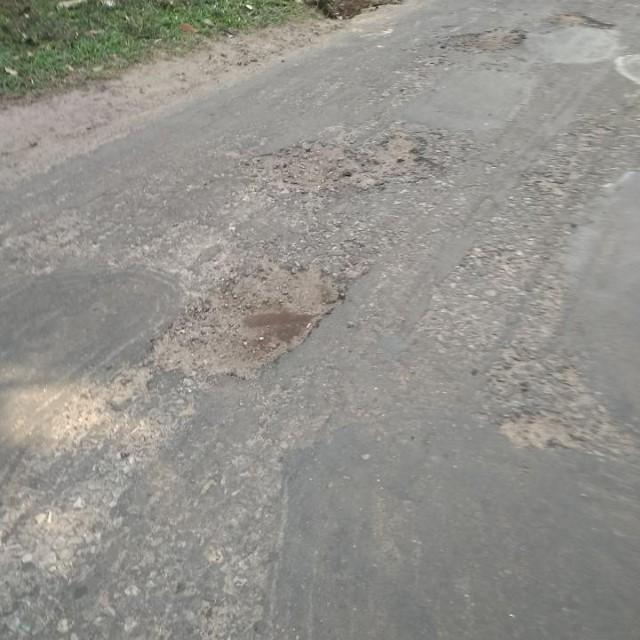

In [ ]:
import numpy as np
from PIL import Image

# let's take a random training example
idx = 20

# load image
image = dataset[idx]["image"]
image

In [ ]:
# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(image, input_boxes=[[prompt]], return_tensors="pt").to(device)
for k,v in inputs.items():
  print(k,v.shape)

pixel_values torch.Size([1, 3, 1024, 1024])
original_sizes torch.Size([1, 2])
reshaped_input_sizes torch.Size([1, 2])
input_boxes torch.Size([1, 1, 4])


In [ ]:
model.eval()

# forward pass
with torch.no_grad():
  outputs = model(**inputs, multimask_output=False)

In [ ]:
# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
print(medsam_seg_prob)
print(medsam_seg_prob.shape)
medsam_seg_prob = nn.functional.interpolate(medsam_seg_prob,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

tensor([[[[0.0264, 0.0236, 0.0298,  ..., 0.0246, 0.0295, 0.0273],
          [0.0266, 0.0264, 0.0308,  ..., 0.0275, 0.0278, 0.0306],
          [0.0290, 0.0254, 0.0308,  ..., 0.0271, 0.0289, 0.0308],
          ...,
          [0.0216, 0.0219, 0.0223,  ..., 0.0191, 0.0181, 0.0207],
          [0.0199, 0.0204, 0.0205,  ..., 0.0208, 0.0197, 0.0219],
          [0.0218, 0.0234, 0.0215,  ..., 0.0229, 0.0205, 0.0218]]]],
       device='cuda:0')
torch.Size([1, 1, 256, 256])


In [ ]:
medsam_seg = nn.functional.interpolate(medsam_seg,
                size=(640, 640),
                mode='bilinear',
                align_corners=False)

AttributeError: ignored

In [ ]:
import torch.nn.functional as F
from typing import Tuple
from torch.nn import MSELoss

loss_fn = MSELoss()

def postprocess_masks(masks: torch.Tensor, input_size: Tuple[int, ...], original_size: Tuple[int, ...], image_size=1024) -> torch.Tensor:
    """
    Remove padding and upscale masks to the original image size.

    Args:
      masks (torch.Tensor):
        Batched masks from the mask_decoder, in BxCxHxW format.
      input_size (tuple(int, int)):
        The size of the image input to the model, in (H, W) format. Used to remove padding.
      original_size (tuple(int, int)):
        The original size of the image before resizing for input to the model, in (H, W) format.

    Returns:
      (torch.Tensor): Batched masks in BxCxHxW format, where (H, W)
        is given by original_size.
    """
    masks = F.interpolate(
        masks,
        (image_size, image_size),
        mode="bilinear",
        align_corners=False,
    )
    masks = masks[..., : input_size[0], : input_size[1]]
    masks = F.interpolate(masks, original_size, mode="bilinear", align_corners=False)
    return masks

In [ ]:
upscaled_masks = postprocess_masks(medsam_seg.squeeze(1), batch["reshaped_input_sizes"][0].tolist(), batch["original_sizes"][0].tolist()).to(device)
medsam_seg = normalize(threshold(upscaled_masks, 0.0, 0)).squeeze(1)

ValueError: ignored

In [ ]:
medsam_seg

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
np.where(medsam_seg > 0)

(array([ 79,  79,  79,  79,  80,  80,  80,  80,  80,  80,  80,  80,  80,
         80,  80,  81,  81,  81,  81,  81,  81,  81,  81,  81,  81,  81,
         81,  81,  81,  82,  82,  82,  82,  82,  82,  82,  82,  82,  82,
         82,  82,  82,  82,  82,  82,  82,  82,  82,  82,  83,  83,  83,
         83,  83,  83,  83,  83,  83,  83,  83,  83,  83,  83,  83,  83,
         83,  83,  83,  83,  83,  83,  83,  83,  84,  84,  84,  84,  84,
         84,  84,  84,  84,  84,  84,  84,  84,  84,  84,  84,  84,  84,
         84,  84,  84,  84,  84,  84,  84,  84,  85,  85,  85,  85,  85,
         85,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,  85,
         85,  85,  85,  85,  85,  85,  85,  85,  86,  86,  86,  86,  86,
         86,  86,  86,  86,  86,  86,  86,  86,  86,  86,  86,  86,  86,
         86,  86,  86,  86,  86,  86,  86,  86,  86,  86,  87,  87,  87,
         87,  87,  87,  87,  87,  87,  87,  87,  87,  87,  87,  87,  87,
         87,  87,  87,  87,  87,  87,  87,  87,  87

In [ ]:
medsam_seg.shape

(640, 640)

In [ ]:
ground_truth_mask.shape

(640, 640)

(-0.5, 639.5, 639.5, -0.5)

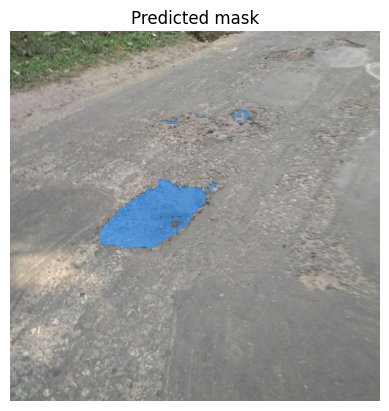

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(medsam_seg, axes)
axes.title.set_text(f"Predicted mask")
axes.axis("off")

Compare this to the ground truth segmentation:

(-0.5, 639.5, 639.5, -0.5)

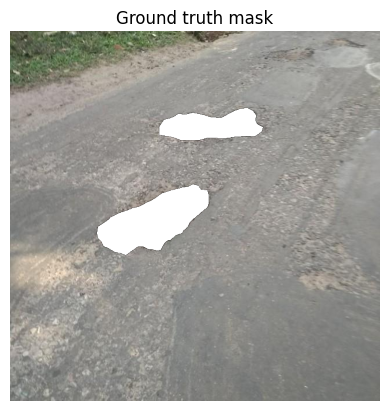

In [ ]:
fig, axes = plt.subplots()

axes.imshow(np.array(image))
show_mask(ground_truth_mask, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")